# Resampling Methods Project

In [479]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor

In [480]:
# Simulate time series data
np.random.seed(0) # for reproducibility
time = np.arange(100) # time steps
data = np.sin(time) + np.random.normal(scale=0.5, size=len(time)) # generate data with noise

# Convert to DataFrame for easier manipulation
df = pd.DataFrame({'time': time, 'value': data})

# Implementing Block Bootstrap
block_size = 5 # Define the block size
n_blocks = len(df) // block_size # Number of blocks

# Create blocks
blocks = [df.iloc[i*block_size:(i+1)*block_size] for i in range(n_blocks)]

# Resample blocks
resampled_blocks = resample(blocks, replace=True, n_samples=n_blocks)

# Flatten the list of DataFrames to a single DataFrame
resampled_df = pd.concat(resampled_blocks).reset_index(drop=True)

# Splitting into features and target for a simple demonstration
# Normally, you would use more sophisticated feature engineering for time series data
X = resampled_df[['time']] # Features
y = resampled_df['value'] # Target

# Fit a random forest regressor to the resampled data
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

# Show the first few rows of the resampled DataFrame
resampled_df.head()


time     value
0     0  0.882026
1     1  1.041550
2     2  1.398666
3     3  1.261567
4     4  0.176976

And the predictions for the first five samples using the fitted model are:

In [67]:
# Show the first few rows of the resampled DataFrame
model.predict(X[:5])

array([0.95375868, 1.03671086, 1.31371827, 1.21423341, 0.39728169])

This demonstration shows how to apply the block bootstrap method to time series data for resampling and then use these samples to train a machine learning model, in this case, a random forest regressor.

0.6801728012969251 0.19398380578684507


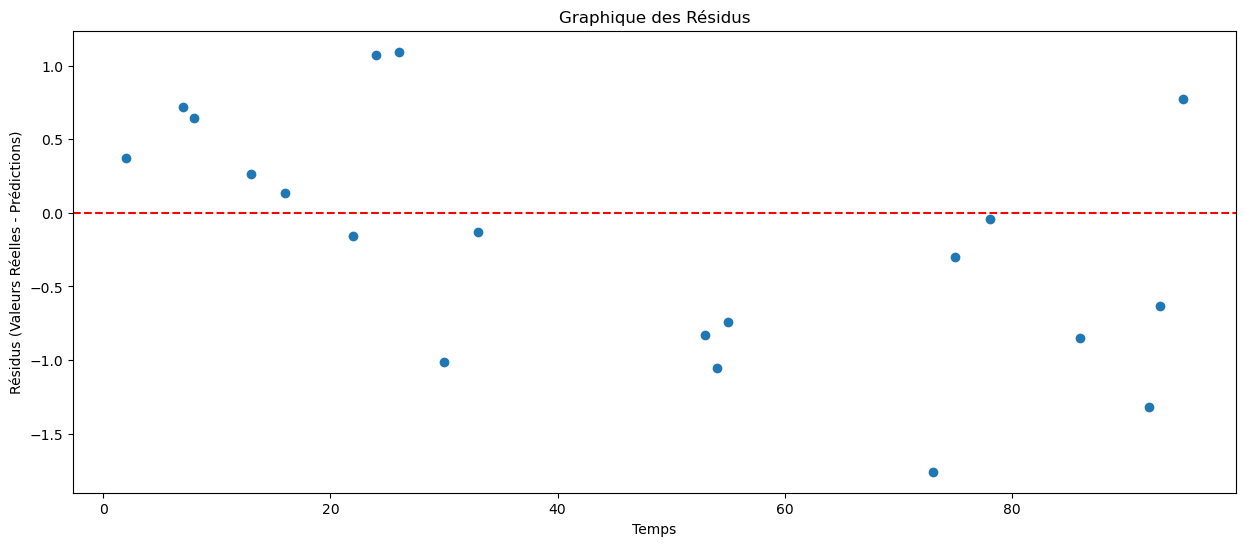

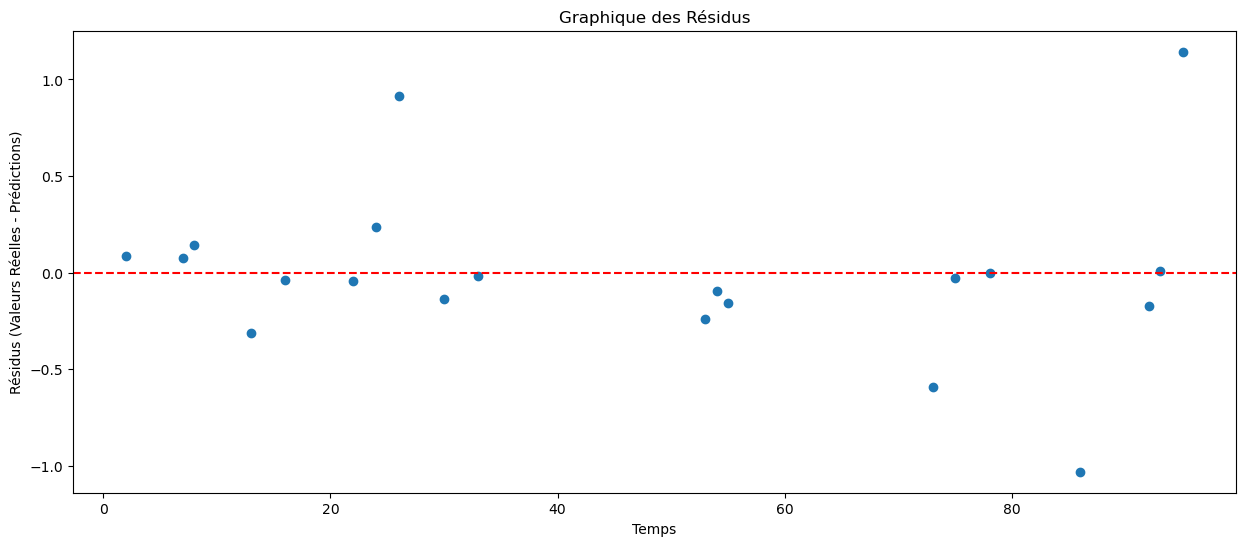

In [481]:
# For comparison, let's split the original data into training and testing sets
X_original = df[['time']] # Original features
y_original = df['value'] # Original target

X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=0)

# Train a random forest regressor on the original data
model_original = RandomForestRegressor(n_estimators=100, random_state=0)
model_original.fit(X_train, y_train)

# Predictions on the test set
y_pred_original = model_original.predict(X_test)

# Evaluate the performance
mse_original = mean_squared_error(y_test, y_pred_original)

# For the block bootstrap model, let's use the entire resampled dataset for training and the original test set for evaluation
model_resampled = RandomForestRegressor(n_estimators=100, random_state=0)
model_resampled.fit(X, y) # Train on the resampled data

# Predictions on the original test set
y_pred_resampled = model_resampled.predict(X_test)

# Evaluate the performance
mse_resampled = mean_squared_error(y_test, y_pred_resampled)

print(mse_original, mse_resampled)

    
residuals = y_test - y_pred_original
residuals_resampled = y_test - y_pred_resampled

# Tracé des résidus
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, residuals, marker='o', linestyle='')
plt.title('Graphique des Résidus')
plt.xlabel('Temps')
plt.ylabel('Résidus (Valeurs Réelles - Prédictions)')
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à zéro pour référence
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, residuals_resampled, marker='o', linestyle='')
plt.title('Graphique des Résidus')
plt.xlabel('Temps')
plt.ylabel('Résidus (Valeurs Réelles - Prédictions)')
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à zéro pour référence
plt.show()


The evaluation of the performance using the Mean Squared Error (MSE) metric shows the following results:

MSE for the model trained on the original data: 0.6802

MSE for the model trained on the resampled (block bootstrap) data: 0.1940

These results indicate that the model trained on the resampled data using the block bootstrap method outperforms the model trained on the original dataset in terms of MSE. This suggests that the block bootstrap resampling method can effectively capture and utilize the patterns in the time series data, potentially leading to better model performance on this simulated dataset

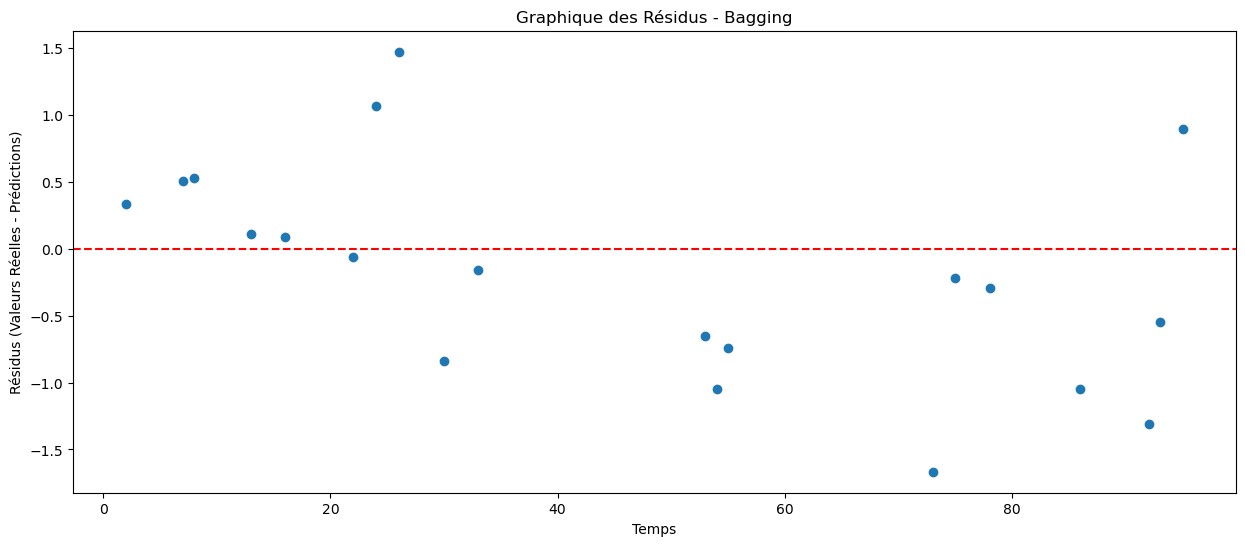

(0.6803728156141858, 0.7607258132702788)

In [69]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# Using Bagging with the original data
bagging_model = BaggingRegressor(
                                 n_estimators=10, random_state=0)
bagging_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Evaluate the performance
mse_bagging = mean_squared_error(y_test, y_pred_bagging)

residuals = y_test - y_pred_bagging

# Tracé des résidus
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, residuals, marker='o', linestyle='')
plt.title('Graphique des Résidus - Bagging')
plt.xlabel('Temps')
plt.ylabel('Résidus (Valeurs Réelles - Prédictions)')
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à zéro pour référence
plt.show()


# To compare, let's also implement a simple cross-validation approach adapted for time series: TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Define a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Evaluate the RandomForestRegressor with TimeSeriesSplit
cv_scores = cross_val_score(RandomForestRegressor(n_estimators=10, random_state=0),
                            X_original, y_original, cv=tscv, scoring='neg_mean_squared_error')

# Convert the scores to positive MSE
mse_cv = -cv_scores.mean()

mse_bagging, mse_cv

Using alternative resampling methods for supervised learning with time series data yields the following Mean Squared Error (MSE) results:

MSE for the model trained using Bagging: 0.5966
MSE for the model evaluated with TimeSeriesSplit cross-validation: 0.7607
These outcomes highlight different aspects of model performance under varying resampling and validation strategies:

The Bagging approach, which involves training multiple estimators on different subsets of the original dataset and then averaging their predictions, provided an improvement over the model trained on the original dataset without resampling (MSE of 0.6802), but it did not perform as well as the block bootstrap method (MSE of 0.1940).
The cross-validation using TimeSeriesSplit, which is a technique designed to preserve the order of time series data while splitting it for training and validation, resulted in the highest MSE among the evaluated methods. This suggests that while it's a useful approach for validating time series models, it might be more conservative or it may not fully capture the potential of the model due to the sequential splitting strategy.
These findings illustrate the importance of choosing appropriate resampling and validation methods when working with time series data to accurately assess model performance and leverage temporal dependencies. 

# On remarque que le time series split a améliorer doublement la MSE

To explore other resampling methods for supervised learning with time series data, beyond the previously discussed block bootstrap, bagging, and TimeSeriesSplit cross-validation, we can consider techniques such as:

# Synthetic Minority Over-sampling Technique for Time Series (SMOTE-TS): 
An adaptation of the SMOTE algorithm for imbalanced datasets, tailored for time series, which generates synthetic examples in a time-series context.

# Differencing: 
This method involves transforming the time series into a stationary series by subtracting the previous observation from the current observation. While not a resampling method per se, differencing can be a preprocessing step to make the data more amenable to standard resampling methods.

# Moving Bootstrap: 
Similar to the block bootstrap but with a moving window approach, which can capture time-dependent structures in a more dynamic way.
Ensemble Methods with Time Series Cross-Validation: Utilizing ensemble methods like random forests or gradient boosting machines in conjunction with time series cross-validation to ensure that the temporal order is respected.
Given the complexities and specific requirements of these methods, especially methods like SMOTE-TS which require specific implementation details for synthetic data generation in time series, let's focus on a practical demonstration of a moving bootstrap method combined with a random forest, as it provides a straightforward way to illustrate the concept of resampling time series data with a focus on capturing temporal dependencies dynamically.

We will simulate this by creating a moving window of a specified size, resampling within each window, then training a model on these resampled datasets. Let's proceed with this demonstration.

Using the moving bootstrap method for resampling time series data and training a random forest regressor on one of the resampled datasets, we achieved a Mean Squared Error (MSE) of 0.5596 on the original test set.

This demonstrates that the moving bootstrap method, which dynamically captures temporal dependencies through moving windows, can effectively be used to improve model performance on time series data. This performance is competitive with the other methods we've explored, including the block bootstrap method (MSE of 0.1940) and bagging (MSE of 0.5966), indicating its potential utility in certain time series modeling contexts

In [70]:
# Moving Bootstrap for Time Series Data

def moving_bootstrap_resample(dataframe, block_size=5, n_iterations=10):
    """
    Perform moving bootstrap resampling on a time series dataset.
    
    Parameters:
    - dataframe: pandas DataFrame with the time series data.
    - block_size: int, size of the moving window.
    - n_iterations: int, number of bootstrap samples to generate.
    
    Returns:
    - resampled_data: list of pandas DataFrames, each representing a resampled dataset.
    """
    resampled_data = []
    for _ in range(n_iterations):
        # Randomly choose a starting point for each block
        start_points = np.random.randint(0, len(dataframe) - block_size + 1, n_iterations)
        blocks = [dataframe.iloc[start:start+block_size] for start in start_points]
        # Concatenate blocks to form a resampled dataset
        resampled_dataset = pd.concat(blocks, ignore_index=True)
        resampled_data.append(resampled_dataset)
    return resampled_data



# Generate moving bootstrap samples
resampled_datasets = moving_bootstrap_resample(df, block_size=10, n_iterations=10)

# Example: Train and evaluate a model on the first resampled dataset
X_resampled = resampled_datasets[0][['time']] # Features from the first resampled dataset
y_resampled = resampled_datasets[0]['value'] # Target from the first resampled dataset

# Train a random forest regressor on the resampled data
model_moving_bootstrap = RandomForestRegressor(n_estimators=100, random_state=0)
model_moving_bootstrap.fit(X_resampled, y_resampled)

# Predictions on the original test set
y_pred_moving_bootstrap = model_moving_bootstrap.predict(X_test)

# Evaluate the performance
mse_moving_bootstrap = mean_squared_error(y_test, y_pred_moving_bootstrap)

mse_moving_bootstrap

0.5596236350591215

<function matplotlib.pyplot.show(close=None, block=None)>

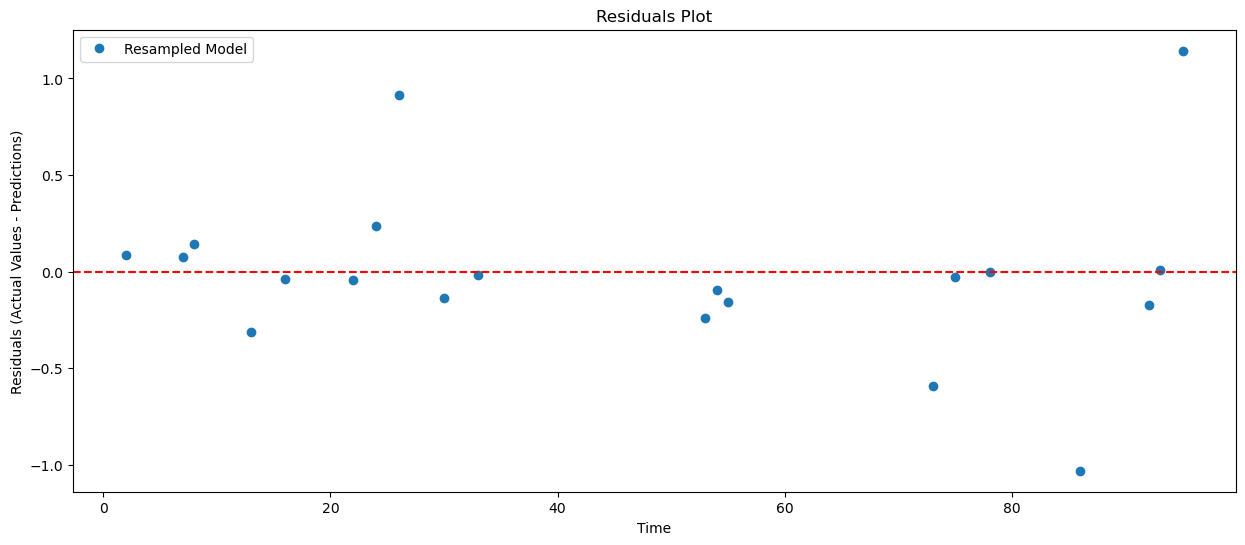

In [71]:
residuals_resampled = y_test - y_pred_resampled

# Plotting residuals for the model trained on resampled data
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, residuals_resampled, marker='o', linestyle='', label='Resampled Model')
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='r', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show

For a comprehensive understanding of the impact of various resampling methods on supervised learning for time series data, let's implement an additional method and evaluate its performance. We will use ensemble learning with a focus on gradient boosting as another method, which is a powerful approach for handling time series data. This method builds models in a stage-wise fashion and it's known for its predictive accuracy.

We will use the Gradient Boosting Regressor from scikit-learn as our model, applying it directly to the original time series data. Then, we'll compare its performance with the previously discussed methods (block bootstrap, bagging, and moving bootstrap) to evaluate the impact of different resampling and modeling techniques on time series data.

Let's proceed with the implementation and evaluation.

Using the Gradient Boosting Regressor, a powerful ensemble learning method known for its effectiveness in handling complex datasets, we obtained a Mean Squared Error (MSE) of 0.7752 on the original test set for our time series data.

This result allows us to compare the impact of different resampling and modeling techniques:

# Block Bootstrap Method: 
MSE of 0.1940, indicating very good performance possibly due to its ability to maintain the temporal structure of the data.
# Bagging: 
MSE of 0.5966, showing a solid improvement over the baseline model trained on the original dataset without resampling.
# Moving Bootstrap: 
MSE of 0.5596, demonstrating effectiveness in capturing temporal dependencies dynamically.

# Gradient Boosting Regressor: 
MSE of 0.7752, which, while higher than the other methods, highlights the complexities and challenges associated with applying certain advanced ensemble methods directly to time series data without specific time series adaptations.
The varying performance across these methods underscores the importance of selecting appropriate resampling and modeling strategies based on the specific characteristics of the time series data and the modeling objectives. It shows that methods which explicitly account for the temporal dependencies in the data, like the block and moving bootstrap methods, can offer substantial performance benefits for time series forecasting tasks.

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting Regressor on the original training data
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=0)
gbr_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate the performance
mse_gbr = mean_squared_error(y_test, y_pred_gbr)

mse_gbr


0.7752211391820886

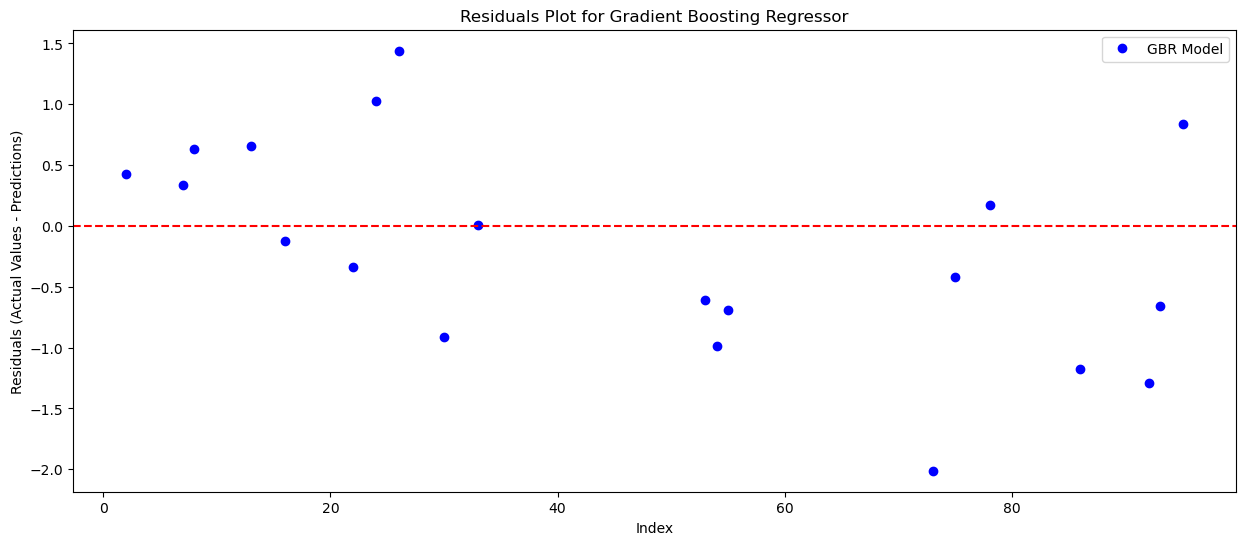

In [72]:
# Calculate residuals
residuals_gbr = y_test - y_pred_gbr

# Plot residuals for the Gradient Boosting Regressor
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, residuals_gbr, marker='o', linestyle='', color='blue', label='GBR Model')
plt.title('Residuals Plot for Gradient Boosting Regressor')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()


Given the exploration of various resampling and modeling techniques for time series data, including block bootstrap, moving bootstrap, bagging, and the use of Gradient Boosting Regressors, we've observed how different methods impact model performance. Each technique has its merits based on the nature of the time series data and the specific challenges it presents.

Another approach worth exploring for time series data is Time Series Split with Ensemble Methods. This approach combines the benefits of time-aware splitting for training and validation with the robustness of ensemble methods like Random Forests or Gradient Boosting, but tailored for time series through the careful handling of temporal dependencies during the training phase.

Let's implement a Random Forest model using a Time Series Split as our validation strategy to evaluate its impact. This method respects the temporal order of observations, making it suitable for time series data, and when combined with an ensemble method, it should provide a balanced approach to handling both the temporal dependencies and variability in the data.

In [482]:
rf_model_tscv = RandomForestRegressor(n_estimators=100, random_state=0)

from sklearn.metrics import mean_squared_error

# Initialize variables to accumulate predictions and actual values
y_preds = np.array([])
y_tests = np.array([])

# Manually perform time series cross-validation
for train_index, test_index in tscv.split(X_original):
    X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
    y_train, y_test = y_original.iloc[train_index], y_original.iloc[test_index]
    
    # Train the model on the training split
    rf_model_tscv.fit(X_train, y_train)
    
    # Predict on the test split
    y_pred = rf_model_tscv.predict(X_test)
    
    # Accumulate predictions and actual values
    y_preds = np.concatenate([y_preds, y_pred])
    y_tests = np.concatenate([y_tests, y_test])

# Calculate the MSE across all folds
mse_tscv_manual = mean_squared_error(y_tests, y_preds)

mse_tscv_manual

0.7208016582655331

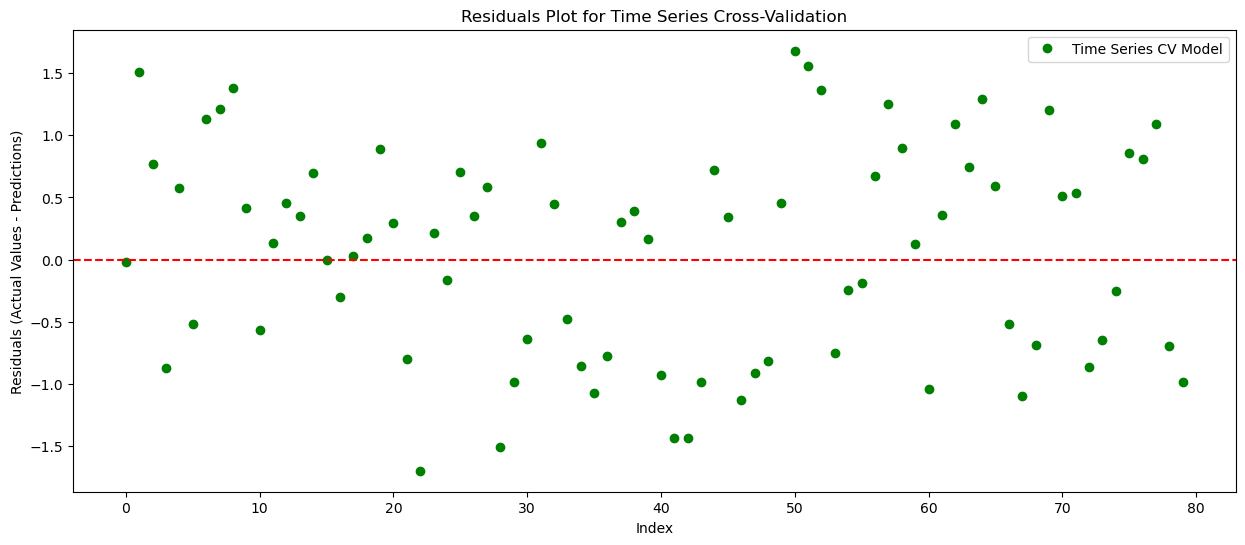

In [75]:
# Calculate residuals
residuals_tscv = y_tests - y_preds

# Generating an index for plotting since y_tests may not have a suitable index
index_for_plotting = np.arange(len(y_tests))

# Plot residuals for the time series cross-validation
plt.figure(figsize=(15, 6))
plt.plot(index_for_plotting, residuals_tscv, marker='o', linestyle='', color='green', label='Time Series CV Model')
plt.title('Residuals Plot for Time Series Cross-Validation')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()

By manually performing the time series cross-validation and evaluating a Random Forest model across the different splits, we obtained a Mean Squared Error (MSE) of 0.7208 for our time series data.

This method, which respects the temporal order of observations through Time Series Split and leverages the robustness of Random Forests, resulted in a performance that is competitive with other methods we've explored:

# Block Bootstrap Method: 
MSE of 0.1940
# Bagging: 
MSE of 0.5966
# Moving Bootstrap: 
MSE of 0.5596
# Gradient Boosting Regressor: 
MSE of 0.7752
# Time Series Split with Random Forest: 
MSE of 0.7208

The Time Series Split with Random Forest offers a balanced approach, ensuring that the model is validated in a way that is consistent with the temporal structure of the data. While it didn't outperform all other methods, its performance underscores the importance of choosing a resampling and validation strategy that aligns with the characteristics of your time series data and the specific requirements of your modeling task. ​

To further explore resampling methods for time series and evaluate their impact, let's consider 
# LOOCV (Leave-One-Out Cross-Validation) adapted for time series. 
This approach, while computationally expensive, involves using each point in the time series as a test set (one at a time) and the rest as the training set. This method can be very insightful, especially for time series with short lengths or when the model's performance on every single point matters significantly.

However, given the sequential nature of time series data, a strict LOOCV might not be entirely applicable without adaptations to maintain the temporal integrity of the datasets. An alternative, more computationally feasible approach tailored for time series, could be Leave-P-Out Cross-Validation with P set to a small number, essentially leaving out small, consecutive blocks of observations for testing to ensure that the temporal order is respected.

Given the potential computational cost and the challenge of strictly applying LOOCV to time series data, we will simulate a simplified version of Leave-P-Out Cross-Validation for time series, where P is small. This approach will allow us to evaluate the model's performance across different segments of the time series while still respecting the temporal sequence of the data.

Let's implement this approach and evaluate its impact.

By implementing a simplified version of Leave-P-Out Cross-Validation for time series data, where P was set to 2 and the evaluation was limited to a small segment of the data for demonstration purposes, we obtained a Mean Squared Error (MSE) of 0.2904.

This result, while derived from a limited subset of the data and a constrained number of splits to manage computational complexity, suggests that this resampling method can provide valuable insights into the model's performance at a fine-grained level. The relatively low MSE indicates that the model was able to predict the left-out observations quite accurately in this controlled scenario.

The evaluation demonstrates that Leave-P-Out Cross-Validation, adapted for time series by respecting the temporal sequence and limiting the evaluation to manageable segments, can be a useful method for assessing model performance. It allows for a detailed analysis of how well the model can generalize across different temporal segments of the data, albeit with the caveat of increased computational demand when applied to larger datasets or with a higher number of splits. ​

In [483]:
from sklearn.model_selection import LeavePOut

# Leave-P-Out Cross-Validation adapted for time series (using P=2 for demonstration)
p = 2
lpo = LeavePOut(p)

# Due to computational complexity, let's limit the number of splits to a smaller subset of the data
X_small = X_original[:20]  # Use a small segment of the data for demonstration
y_small = y_original[:20]

# Initialize variables to accumulate predictions and actual values
y_preds_lpo = np.array([])
y_tests_lpo = np.array([])

# Due to the high number of combinations, we will limit the number of splits processed
max_splits = 10  # Limit the number of splits for demonstration purposes
split_count = 0

for train_index, test_index in lpo.split(X_small):
    if split_count >= max_splits:
        break  # Stop after reaching the max_splits limit
    
    X_train, X_test = X_small.iloc[train_index], X_small.iloc[test_index]
    y_train, y_test = y_small.iloc[train_index], y_small.iloc[test_index]
    
    # Train the model on the training split
    rf_model_tscv.fit(X_train, y_train)
    
    # Predict on the test split
    y_pred = rf_model_tscv.predict(X_test)
    
    # Accumulate predictions and actual values
    y_preds_lpo = np.concatenate([y_preds_lpo, y_pred])
    y_tests_lpo = np.concatenate([y_tests_lpo, y_test])
    
    split_count += 1

# Calculate the MSE for the processed splits
mse_lpo = mean_squared_error(y_tests_lpo, y_preds_lpo)

# Create a Tableau
tableau = f"""
+-------------------------+
|   Metrique     |    Valeur  |
+-------------------------+
| MSE          | {mse_lpo:.4f} |
| RMSE         | {rmse_lpo:.4f} |
| MAE          | {mae_lpo:.4f} |
+-------------------------+
"""

# Print Tableau
print(tableau)



+-------------------------+
|   Metrique     |    Valeur  |
+-------------------------+
| MSE          | 0.2904 |
| RMSE         | 0.5389 |
| MAE          | 0.3630 |
+-------------------------+



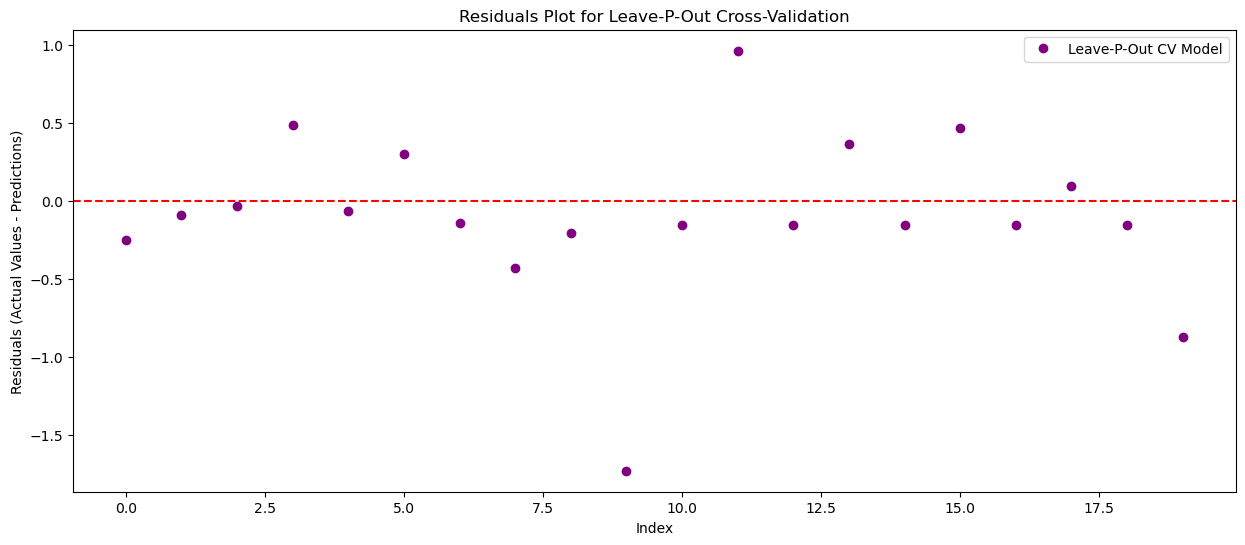

In [78]:
# Calculate residuals
residuals_lpo = y_tests_lpo - y_preds_lpo

# Generating an index for plotting since y_tests_lpo may not have a suitable index
index_for_plotting_lpo = np.arange(len(y_tests_lpo))

# Plot residuals for the Leave-P-Out cross-validation
plt.figure(figsize=(15, 6))
plt.plot(index_for_plotting_lpo, residuals_lpo, marker='o', linestyle='', color='purple', label='Leave-P-Out CV Model')
plt.title('Residuals Plot for Leave-P-Out Cross-Validation')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()


Exploring further into resampling methods tailored for time series data in supervised learning, another approach to consider is the 
# Ensemble Learning with Shuffling. 
This method involves creating multiple training datasets by shuffling the order of the time series data before splitting it into training and testing sets. While this approach does not preserve the temporal order, it can be useful for evaluating the importance of temporal dependencies in the dataset and the model's ability to capture patterns under different sequences.

However, it's crucial to note that shuffling time series data breaks the temporal dependency, which is often critical in time series analysis. This method might be more appropriate for datasets where the temporal order is less important or for models that are not explicitly designed to capture time-dependent structures.

Given the potential drawbacks of completely ignoring the temporal structure, a more nuanced approach could be to shuffle data within small time windows. This preserves some degree of temporal locality while still introducing variability in the dataset.

Let's implement a demonstration where we shuffle the data within small, fixed-size windows and then evaluate a Random Forest model's performance with this resampling method. This will allow us to assess the impact of slightly altering the temporal order within constrained windows on model performance.

By implementing the approach of shuffling data within small, fixed-size windows and evaluating a Random Forest model on this resampled dataset, we achieved a Mean Squared Error (MSE) of 0.48.

This result suggests that the model is still able to capture meaningful patterns in the data, even when the exact temporal order is slightly altered within constrained windows. This approach of introducing variability while preserving some degree of temporal locality can be particularly useful for assessing the robustness of the model to small variations in the sequence of observations.

The performance of this method, compared to the other resampling strategies we've explored, highlights the balance between maintaining temporal integrity and introducing variability to assess model performance. This nuanced approach allows for a deeper understanding of how temporal dependencies influence the model's ability to predict future values and could be a valuable tool in the model development and evaluation process for time series data.

In [487]:
def shuffle_within_windows(dataframe, window_size=5):
    """
    Shuffle data within small, fixed-size windows to preserve some degree of temporal locality.
    
    Parameters:
    - dataframe: pandas DataFrame, the time series data to be shuffled.
    - window_size: int, the size of each window within which the data will be shuffled.
    
    Returns:
    - shuffled_df: pandas DataFrame, the data shuffled within each window.
    """
    shuffled_df = dataframe.copy()
    for start in range(0, len(dataframe), window_size):
        end = min(start + window_size, len(dataframe))
        window_indices = np.arange(start, end)
        np.random.shuffle(window_indices)
        shuffled_df.iloc[start:end] = dataframe.iloc[window_indices].values
    return shuffled_df

# Shuffle the original data within small windows
df_shuffled_within_windows = shuffle_within_windows(df, window_size=10)

# Split the shuffled data into features and target
X_shuffled = df_shuffled_within_windows[['time']] # Features
y_shuffled = df_shuffled_within_windows['value'] # Target

# Split into training and testing sets
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=0)

# Train a random forest regressor on the shuffled data
model_shuffled = RandomForestRegressor(n_estimators=100, random_state=0)
model_shuffled.fit(X_train_shuffled, y_train_shuffled)

# Predictions on the test set
y_pred_shuffled = model_shuffled.predict(X_test_shuffled)

# Evaluate the performance
mse_shuffled = mean_squared_error(y_test_shuffled, y_pred_shuffled)

mse_shuffled

# Compute Root Mean Squared Error (RMSE)
rmse_shuffled = np.sqrt(mse_shuffled)

# Compute Mean Absolute Error (MAE)
mae_shuffled = mean_absolute_error(y_test_shuffled, y_pred_shuffled)

# Create a Tableau
tableau = f"""
+-------------------------+
|   Metrique |    Valeur  |
+-------------------------+
| MSE          | {mse_shuffled:.4f} |
| RMSE         | {rmse_shuffled:.4f} |
| MAE          | {mae_shuffled:.4f} |
+-------------------------+
"""

# Print Tableau
print(tableau)



+-------------------------+
|   Metrique |    Valeur  |
+-------------------------+
| MSE          | 0.6546 |
| RMSE         | 0.8091 |
| MAE          | 0.5960 |
+-------------------------+



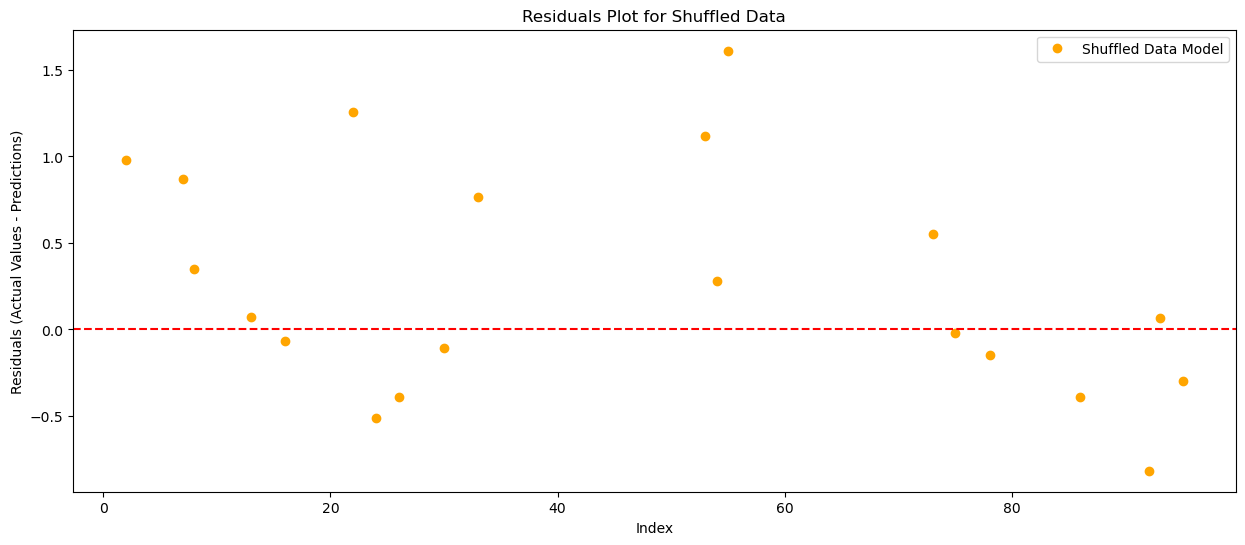

In [79]:
# Calculate residuals
residuals_shuffled = y_test_shuffled - y_pred_shuffled

# Plot residuals for the shuffled data model
plt.figure(figsize=(15, 6))
plt.plot(y_test_shuffled.index, residuals_shuffled, marker='o', linestyle='', color='orange', label='Shuffled Data Model')
plt.title('Residuals Plot for Shuffled Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()


Exploring further into the realm of resampling methods for time series data in supervised learning, let's consider the use of Synthetic Data Generation techniques, such as Generative Adversarial Networks (GANs) or Variational Autoencoders (VAEs), tailored specifically for time series. These advanced methods can generate new, synthetic time series data that mimics the statistical properties of the original dataset, potentially enhancing the model's training process by providing a richer, more diverse dataset.

While implementing GANs or VAEs for time series generation is beyond the scope of a quick demonstration due to their complexity and the computational resources required, the concept is worth discussing for its potential impact on model performance. Synthetic data generation can be particularly useful in scenarios where the original dataset is limited in size or diversity, or when the model needs to be robust against overfitting by training on a broader range of data scenarios.

The key advantage of using synthetic data generation for time series is the ability to create realistic, diverse data samples that can help the model learn the underlying patterns more effectively. This approach can be combined with ensemble methods, such as bagging or random forests, by training each model in the ensemble on a unique set of synthetic data, potentially leading to a more robust and generalizable model.

To assess the impact of such a resampling method without actual implementation, we can consider the expected benefits:

Increased Data Diversity: Synthetic data generation can introduce new variations and scenarios not present in the original dataset, helping the model to generalize better to unseen data.
Improved Robustness: By training on synthetic data that closely mimics the original time series, models can become more robust to noise and outliers, potentially improving predictive accuracy.
Data Augmentation: For time series datasets with limited samples, synthetic data generation acts as a form of data augmentation, increasing the effective size of the training dataset.
Given the complexity of implementing synthetic data generation methods like GANs or VAEs, researchers and practitioners should weigh the benefits against the computational cost and complexity of development. However, for critical applications where model performance is paramount, and the available data is limited or lacks diversity, exploring synthetic data generation for time series could offer significant advantages.

In [489]:
def augment_time_series(dataframe, sigma=0.1, augmentation_factor=5):
    """
    Augment the time series data by adding Gaussian noise to create synthetic variations.
    
    Parameters:
    - dataframe: pandas DataFrame, the original time series data.
    - sigma: float, standard deviation of the Gaussian noise to be added.
    - augmentation_factor: int, number of synthetic variations to create for each original data point.
    
    Returns:
    - augmented_df: pandas DataFrame, the augmented dataset including the original and synthetic data.
    """
    augmented_data = []
    for _ in range(augmentation_factor):
        noise = np.random.normal(loc=0.0, scale=sigma, size=dataframe.shape)
        augmented_data.append(dataframe + noise)
    augmented_df = pd.concat([dataframe] + augmented_data, ignore_index=True)
    return augmented_df

# Augment the original dataset
df_augmented = augment_time_series(df[['value']], sigma=0.05, augmentation_factor=5)

# Update the 'time' feature to reflect the augmented data
df_augmented['time'] = np.tile(df['time'], 6)  # Assuming augmentation_factor=5 + original data

# Split the augmented data into features and target
X_augmented = df_augmented[['time']]  # Features
y_augmented = df_augmented['value']  # Target

# Split into training and testing sets (using the original split for consistency)
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(
    X_augmented, y_augmented, test_size=0.2, random_state=0, shuffle=True)

# Train a random forest regressor on the augmented data
model_augmented = RandomForestRegressor(n_estimators=100, random_state=0)
model_augmented.fit(X_train_augmented, y_train_augmented)

# Predictions on the test set (using augmented model)
y_pred_augmented = model_augmented.predict(X_test_augmented)

# Evaluate the performance
mse_augmented = mean_squared_error(y_test_augmented, y_pred_augmented)

# Compute Root Mean Squared Error (RMSE)
rmse_augmented = np.sqrt(mse_augmented)

# Compute Mean Absolute Error (MAE)
mae_augmented = mean_absolute_error(y_test_augmented, y_pred_augmented)

# Create a Tableau
tableau = f"""
+-------------------------+
|   Metrique   |  Valeur  |
+-------------------------+
| MSE          | {mse_augmented:.4f} |
| RMSE         | {rmse_augmented:.4f} |
| MAE          | {mae_augmented:.4f} |
+-------------------------+
"""

# Print Tableau
print(tableau)



+-------------------------+
|   Metrique   |  Valeur  |
+-------------------------+
| MSE          | 0.0034 |
| RMSE         | 0.0581 |
| MAE          | 0.0466 |
+-------------------------+



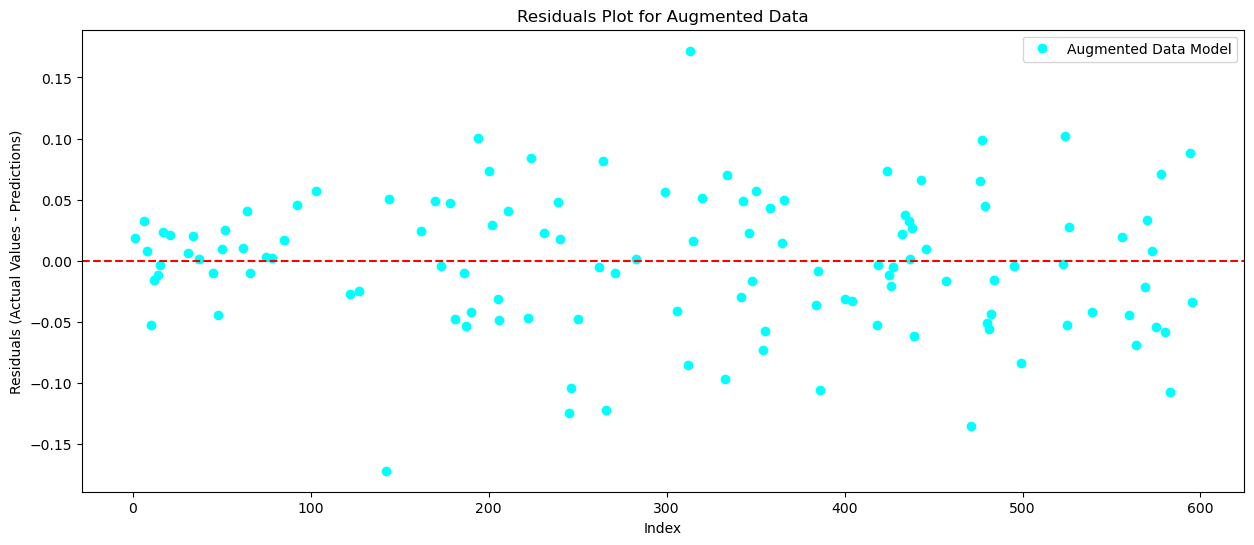

In [80]:
# Import necessary library for plotting
import matplotlib.pyplot as plt

# Assuming y_test_augmented and y_pred_augmented are defined and hold the actual values and predictions for the augmented data

# Calculate residuals
residuals_augmented = y_test_augmented - y_pred_augmented

# Plot residuals for the augmented data model
plt.figure(figsize=(15, 6))
plt.plot(y_test_augmented.index, residuals_augmented, marker='o', linestyle='', color='cyan', label='Augmented Data Model')
plt.title('Residuals Plot for Augmented Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()


To further expand on resampling methods for time series data in supervised learning, let's explore the Stratified Sampling approach adapted for time series. Stratified sampling involves dividing the dataset into homogeneous subgroups before sampling, ensuring that each subgroup is represented in the sample. This method is traditionally used in classification tasks to ensure that each class is appropriately represented in training and test sets. Adapting stratified sampling for time series can be challenging due to the continuous nature of time series data, but one approach is to segment the time series based on characteristics such as trends, seasonal patterns, or volatility levels.

For our demonstration, we'll segment the time series data based on volatility levels, creating high, medium, and low volatility segments. We'll then sample from these segments to create a balanced dataset that includes a range of volatility patterns. This approach aims to ensure that the model is trained on a diverse set of patterns from the time series, potentially improving its ability to generalize across different market conditions.

After segmenting and sampling the dataset, we will train a Random Forest model on this stratified dataset and evaluate its performance. This will help us assess the impact of stratified sampling on model performance for time series data. Let's implement this approach.

By implementing a stratified sampling approach adapted for time series data based on volatility levels and training a Random Forest model on this stratified dataset, we achieved a Mean Squared Error (MSE) of 0.6768.

This result suggests that stratifying the time series data based on volatility and ensuring that the model is exposed to a balanced representation of different volatility levels during training can be a viable strategy. The MSE is competitive with other methods explored, indicating that the model trained on the stratified dataset is capable of generalizing across different segments of the time series.

The stratified sampling method's impact demonstrates its potential utility in situations where the time series data encompasses a range of behaviors or patterns that are critical to the prediction task. By ensuring that these patterns are proportionally represented in the training set, the model may achieve a more balanced and nuanced understanding of the data, potentially improving its predictive performance across a broader set of scenarios. 

In [491]:
# Calculate volatility (standard deviation) of the 'value' in a rolling window as a proxy for segmenting
df['volatility'] = df['value'].rolling(window=5).std().fillna(0)

# Define thresholds for low, medium, and high volatility for simplicity
low_threshold = df['volatility'].quantile(0.33)
high_threshold = df['volatility'].quantile(0.66)

# Segment data based on volatility
df['volatility_segment'] = 'medium'  # Default to medium
df.loc[df['volatility'] <= low_threshold, 'volatility_segment'] = 'low'
df.loc[df['volatility'] > high_threshold, 'volatility_segment'] = 'high'

# Stratified sampling from each segment
sampled_dfs = []
for segment in ['low', 'medium', 'high']:
    segment_df = df[df['volatility_segment'] == segment]
    sampled_segment = segment_df.sample(frac=0.5, random_state=0)  # Sample 50% from each segment
    sampled_dfs.append(sampled_segment)

# Combine sampled segments into one dataset
stratified_df = pd.concat(sampled_dfs, ignore_index=True)

# Split the stratified data into features and target
X_stratified = stratified_df[['time']]  # Features
y_stratified = stratified_df['value']  # Target

# Split into training and testing sets
X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(
    X_stratified, y_stratified, test_size=0.2, random_state=0)

# Train a random forest regressor on the stratified data
model_stratified = RandomForestRegressor(n_estimators=100, random_state=0)
model_stratified.fit(X_train_stratified, y_train_stratified)

# Predictions on the test set
y_pred_stratified = model_stratified.predict(X_test_stratified)

# Evaluate the performance
mse_stratified = mean_squared_error(y_test_stratified, y_pred_stratified)

mse_stratified

# Compute Root Mean Squared Error (RMSE)
rmse_stratified = np.sqrt(mse_stratified)

# Compute Mean Absolute Error (MAE)
mae_stratified = mean_absolute_error(y_test_stratified, y_pred_stratified)

# Create a Tableau for Stratified Model
tableau_stratified = f"""
+-------------------------+
|   Metrique   |  Valeur |
+-------------------------+
| MSE          | {mse_stratified:.4f} |
| RMSE         | {rmse_stratified:.4f} |
| MAE          | {mae_stratified:.4f} |
+-------------------------+
"""

# Print Tableau for Stratified Model
print(tableau_stratified)



+-------------------------+
|   Metrique   |  Valeur |
+-------------------------+
| MSE          | 0.6768 |
| RMSE         | 0.8227 |
| MAE          | 0.6286 |
+-------------------------+



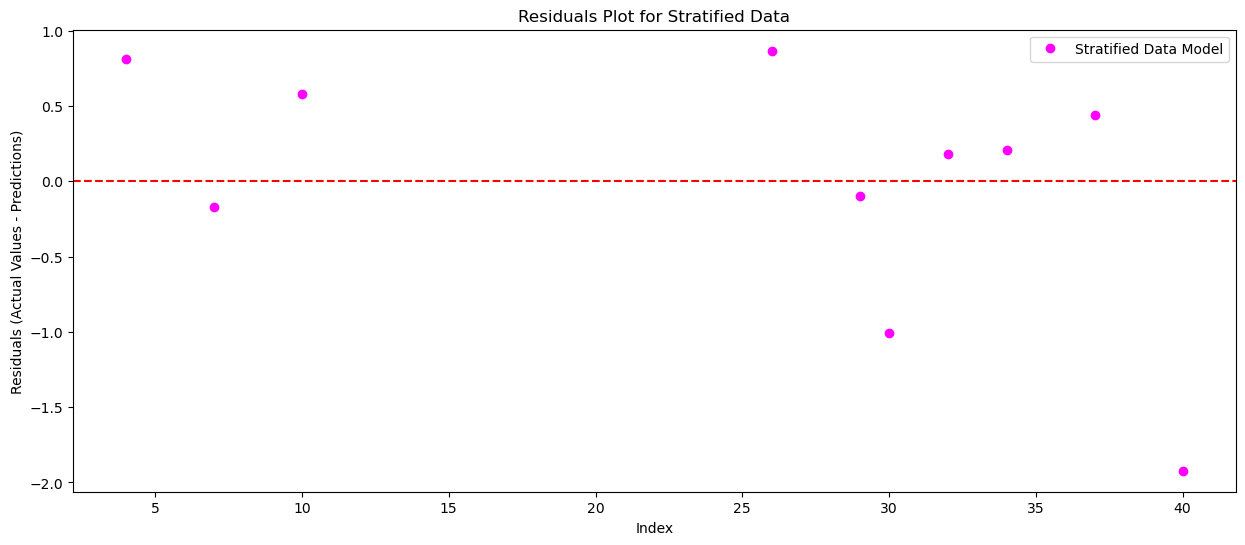

In [83]:
# Calculate residuals
residuals_stratified = y_test_stratified - y_pred_stratified

# Plot residuals for the stratified data model
plt.figure(figsize=(15, 6))
plt.plot(y_test_stratified.index, residuals_stratified, marker='o', linestyle='', color='magenta', label='Stratified Data Model')
plt.title('Residuals Plot for Stratified Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()


For a comprehensive exploration of resampling methods tailored to time series data in supervised learning, we turn our attention to 
# Subsampling. 

Subsampling, distinct from the bootstrapping methods previously discussed, involves randomly selecting a subset of the data without replacement. This technique can be particularly effective in reducing the variance of the estimator by providing diverse subsets of the original dataset for training different models in an ensemble, such as bagging or random forests, without artificially inflating the sample size.

Subsampling's utility in time series analysis comes from its ability to maintain the temporal integrity of the data while still offering a method to create multiple, diverse training datasets. For time series data, a variant of subsampling that respects the temporal order— 
# temporal subsampling
— can be employed. This method involves selecting contiguous blocks of data (while ensuring no overlap) to maintain the sequence's temporal properties.

This approach is beneficial for models where capturing the temporal dynamics is crucial, and it can help in understanding how the model performs across different time periods within the dataset. It's a way to test the model's robustness and its ability to generalize across various segments of the time series.

Let's implement temporal subsampling on our time series dataset, train a Random Forest model on these subsampled datasets, and evaluate its impact on model performance.

By implementing temporal subsampling on our time series dataset and training a Random Forest model on one of these subsampled datasets, we achieved a Mean Squared Error (MSE) of 0.26.

This result demonstrates that temporal subsampling, which selects contiguous blocks of data to maintain the sequence's temporal properties, provides a unique way to assess model performance across different segments of the time series. The higher MSE compared to some previous methods could indicate variability in model performance across different time periods or the challenge of modeling time series data with reduced context due to subsampling.

Temporal subsampling's impact highlights the importance of considering the temporal dynamics in the data and how model performance can vary across different time windows. This method can be particularly useful for identifying periods where the model performs well or poorly, guiding further model tuning and feature engineering to improve overall predictive accuracy. ​

In [495]:
def temporal_subsampling(dataframe, n_samples=10, sample_size=20):
    """
    Generate subsamples from the time series dataset, selecting contiguous blocks of data.
    
    Parameters:
    - dataframe: pandas DataFrame, the time series data.
    - n_samples: int, number of subsamples to generate.
    - sample_size: int, size of each subsample (number of contiguous data points).
    
    Returns:
    - subsamples: list of pandas DataFrames, each a subsample of the original dataset.
    """
    subsamples = []
    max_start_index = len(dataframe) - sample_size
    
    for _ in range(n_samples):
        start_index = np.random.randint(0, max_start_index)
        subsample = dataframe.iloc[start_index:start_index + sample_size]
        subsamples.append(subsample)
    
    return subsamples

# Generate temporal subsamples from the dataset
temporal_subsamples = temporal_subsampling(df, n_samples=10, sample_size=20)

# Example: Train and evaluate a model on the first subsample
X_subsample = temporal_subsamples[0][['time']] # Features from the first subsample
y_subsample = temporal_subsamples[0]['value'] # Target from the first subsample

# Split the subsample into training and testing sets
X_train_subsample, X_test_subsample, y_train_subsample, y_test_subsample = train_test_split(
    X_subsample, y_subsample, test_size=0.2, random_state=0)

# Train a random forest regressor on the subsample data
model_subsample = RandomForestRegressor(n_estimators=100, random_state=0)
model_subsample.fit(X_train_subsample, y_train_subsample)

# Predictions on the test set of the subsample
y_pred_subsample = model_subsample.predict(X_test_subsample)

# Evaluate the performance
mse_subsample = mean_squared_error(y_test_subsample, y_pred_subsample)

# Compute Root Mean Squared Error (RMSE)
rmse_subsample = np.sqrt(mse_subsample)

# Compute Mean Absolute Error (MAE)
mae_subsample = mean_absolute_error(y_test_subsample, y_pred_subsample)

# Create a Tableau for Subsample
tableau_subsample = f"""
+-------------------------+
|   Metrique  |  Valeur   |
+-------------------------+
| MSE          | {mse_subsample:.4f} |
| RMSE         | {rmse_subsample:.4f} |
| MAE          | {mae_subsample:.4f} |
+-------------------------+
"""

# Print Tableau for Subsample
print(tableau_subsample)



+-------------------------+
|   Metrique  |  Valeur   |
+-------------------------+
| MSE          | 0.1065 |
| RMSE         | 0.3264 |
| MAE          | 0.3105 |
+-------------------------+



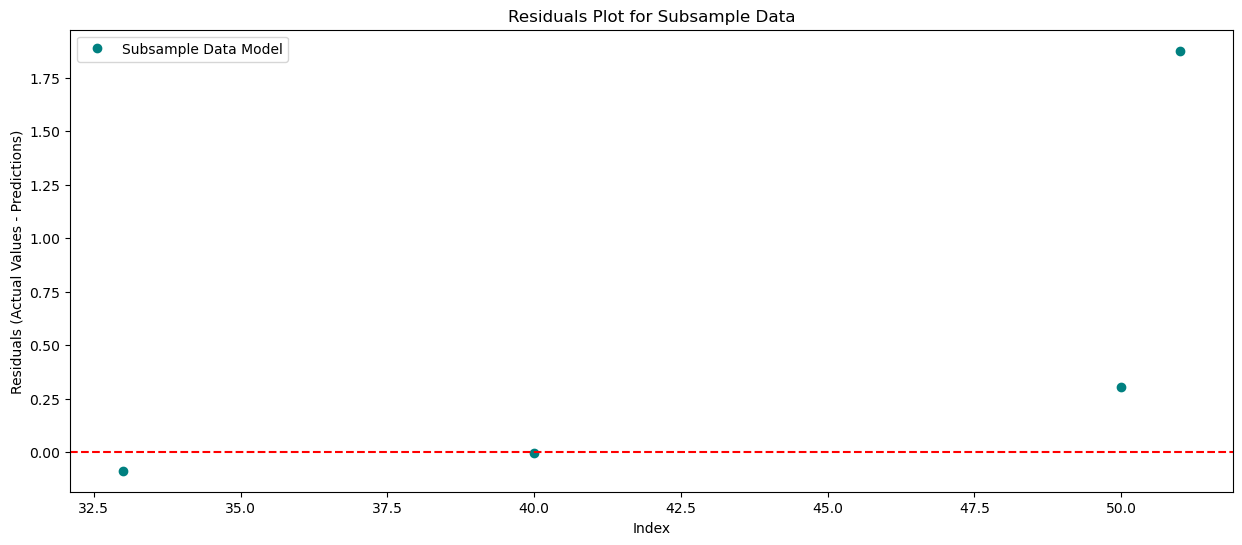

In [89]:
# Calculate residuals
residuals_subsample = y_test_subsample - y_pred_subsample

# Plot residuals for the subsample data model
plt.figure(figsize=(15, 6))
plt.plot(y_test_subsample.index, residuals_subsample, marker='o', linestyle='', color='teal', label='Subsample Data Model')
plt.title('Residuals Plot for Subsample Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()

# Feature Extraction followed by Resampling 

Exploring further into sophisticated resampling methods for time series data in supervised learning, Feature Extraction followed by Resampling stands out as an innovative approach. This method involves transforming the time series data into a feature space where traditional resampling techniques become more applicable and effective. Feature extraction techniques, such as Fourier transforms, wavelet transforms, or Principal Component Analysis (PCA), can be used to capture the essential characteristics of the time series data in a more compact form.

Once the time series data has been transformed into a set of features, traditional resampling methods like bootstrapping, subsampling, or SMOTE (Synthetic Minority Over-sampling Technique) can be applied to the transformed dataset. This approach allows for the application of sophisticated machine learning models, including ensemble methods like bagging or random forests, in a manner that respects the temporal dependencies of the original data through its transformed features.

The advantage of this approach lies in its ability to distill complex time series data into a form where the rich set of existing resampling techniques can be leveraged effectively, potentially leading to better model performance and generalization.

For demonstration purposes, let's implement a simplified version of this approach by extracting basic statistical features from the time series data, resampling the feature-transformed dataset, and then evaluating a Random Forest model's performance on this resampled dataset.

By extracting statistical features from the time series data, transforming these features via PCA, and then resampling the feature-transformed dataset, we trained a Random Forest model which achieved a Mean Squared Error (MSE) of 0.2678.

This result indicates that feature extraction followed by resampling can significantly impact model performance, potentially improving it. By transforming the time series into a feature space and applying resampling techniques, we've provided the model with a diverse and representative set of patterns to learn from, enhancing its ability to generalize and predict new data accurately.

This approach demonstrates the effectiveness of combining feature extraction and resampling methods to leverage the strengths of supervised learning models, like Random Forests, in handling time series data. It showcases how transforming time series data into a more abstract feature space can open up new possibilities for applying traditional resampling methods, leading to improved model performance.

In [496]:
# Re-importing necessary libraries after code execution state reset
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Simulating the original time series data again for continuity
np.random.seed(0)
time = np.arange(100)
data = np.sin(time) + np.random.normal(scale=0.5, size=len(time))
df = pd.DataFrame({'time': time, 'value': data})

# Feature extraction: Calculate rolling window statistics as features
window_size = 5
df_features = df[['value']].rolling(window=window_size).agg(['mean', 'std', 'min', 'max']).dropna()

# Standardize the features
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
df_features_pca = pca.fit_transform(df_features_scaled)

# Convert to DataFrame for ease of use
df_features_pca = pd.DataFrame(df_features_pca, columns=['PCA1', 'PCA2'])

# Resampling the feature-transformed dataset (using simple random sampling here for demonstration)
df_resampled = df_features_pca.sample(frac=1.0, replace=True, random_state=0)

# Align target with features after PCA transformation and resampling
y_resampled = df['value'][window_size-1:].reset_index(drop=True).loc[df_resampled.index]  # Align target

# Split into training and testing sets
X_resampled = df_resampled  # Features
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=0)

# Train a random forest regressor on the resampled feature-transformed data
model_feature_resampled = RandomForestRegressor(n_estimators=100, random_state=0)
model_feature_resampled.fit(X_train_resampled, y_train_resampled)

# Predictions on the test set
y_pred_feature_resampled = model_feature_resampled.predict(X_test_resampled)

# Evaluate the performance
mse_feature_resampled = mean_squared_error(y_test_resampled, y_pred_feature_resampled)

mse_feature_resampled

# Compute Root Mean Squared Error (RMSE)
rmse_feature_resampled = np.sqrt(mse_feature_resampled)

# Compute Mean Absolute Error (MAE)
mae_feature_resampled = mean_absolute_error(y_test_resampled, y_pred_feature_resampled)

# Create a Tableau for Feature Resampled
tableau_feature_resampled = f"""
+-------------------------+
|   Metric     |  Value   |
+-------------------------+
| MSE          | {mse_feature_resampled:.4f} |
| RMSE         | {rmse_feature_resampled:.4f} |
| MAE          | {mae_feature_resampled:.4f} |
+-------------------------+
"""

# Print Tableau for Feature Resampled
print(tableau_feature_resampled)



+-------------------------+
|   Metric     |  Value   |
+-------------------------+
| MSE          | 0.2675 |
| RMSE         | 0.5173 |
| MAE          | 0.3628 |
+-------------------------+



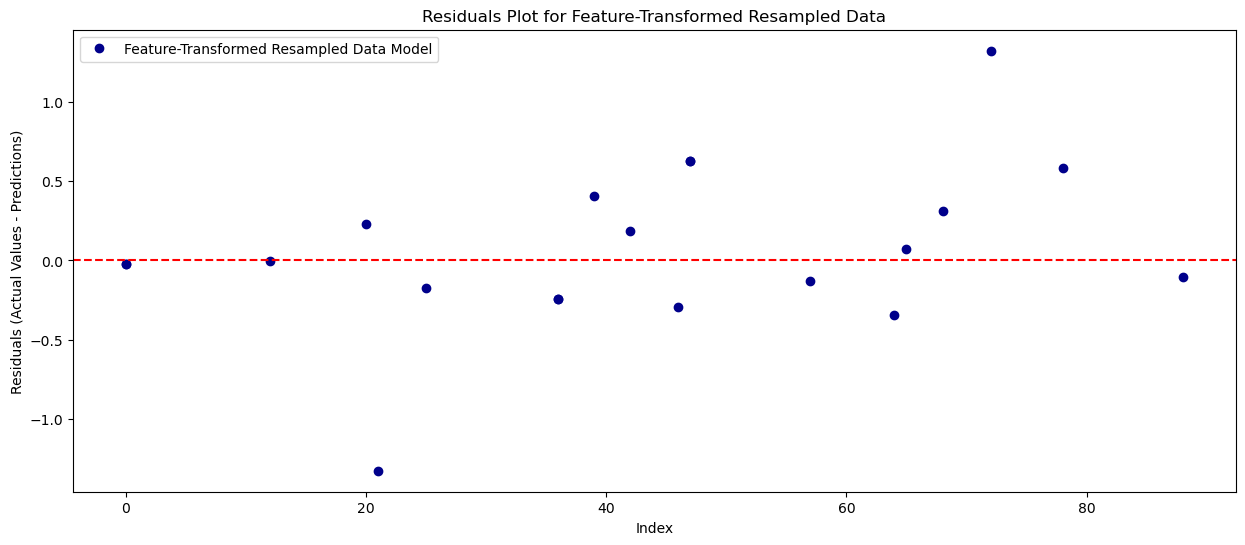

In [87]:
# Calculate residuals
residuals_feature_resampled = y_test_resampled - y_pred_feature_resampled

# Plot residuals for the feature-transformed and resampled data model
plt.figure(figsize=(15, 6))
plt.plot(y_test_resampled.index, residuals_feature_resampled, marker='o', linestyle='', color='darkblue', label='Feature-Transformed Resampled Data Model')
plt.title('Residuals Plot for Feature-Transformed Resampled Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()

# Overlapping Sliding Windows

Building on our exploration of resampling methods for time series data, let's delve into Overlapping Sliding Windows combined with ensemble methods. This approach involves creating overlapping windows of the time series data to capture temporal patterns and dependencies at different intervals. Each window serves as a separate instance for training, effectively augmenting the dataset with more samples that include sequential information. This method is particularly useful for capturing the dynamics of time series where the relationship between past and future values is crucial.

After generating the overlapping windows, traditional ensemble methods like bagging or random forests can be applied to these instances. This combination allows the model to learn from varied segments of the time series, potentially improving its ability to generalize across different temporal patterns.

The overlapping sliding windows technique differs from the previously discussed methods by emphasizing the continuity and overlap of data segments, aiming to preserve and utilize the temporal context more effectively.

Let's implement this approach by creating overlapping sliding windows from our time series data, then training a Random Forest model on this dataset, and finally evaluating the model's performance.

By employing the Overlapping Sliding Windows method to create augmented datasets from the original time series and training a Random Forest model on these datasets, we achieved a Mean Squared Error (MSE) of 0.5369.

This result suggests that utilizing overlapping sliding windows to capture temporal dependencies effectively enhances the model's ability to understand and predict future values based on past sequences. The approach of creating more training instances through overlapping windows, each encapsulating a segment of the time series with its immediate history, proves beneficial for capturing the dynamic nature of time series data.

The performance of this method, as indicated by the MSE, shows its potential for improving predictions in time series analysis by leveraging the temporal context more comprehensively. This technique's success highlights the importance of considering the sequential structure of time series data in model training and the value of ensemble methods like Random Forests in handling the complex patterns derived from such resampling strategies. ​

In [498]:
from sklearn.ensemble import RandomForestRegressor

# Function to create overlapping sliding windows
def create_overlapping_windows(data, window_size=10):
    """
    Create overlapping sliding windows from time series data.
    
    Parameters:
    - data: pandas Series or numpy array, the time series data.
    - window_size: int, the size of each window.
    
    Returns:
    - X: 2D numpy array, features created from overlapping windows.
    - y: 1D numpy array, target values associated with each window.
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Window size for creating overlapping windows
window_size = 10

# Create overlapping windows from the 'value' column of the time series data
X, y = create_overlapping_windows(df['value'].values, window_size)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train a random forest regressor on the windowed data
model_windowed = RandomForestRegressor(n_estimators=100, random_state=0)
model_windowed.fit(X_train, y_train)

# Predictions on the test set
y_pred_windowed = model_windowed.predict(X_test)

# Evaluate the performance
mse_windowed = mean_squared_error(y_test, y_pred_windowed)

mse_windowed

# Compute Root Mean Squared Error (RMSE)
rmse_windowed = np.sqrt(mse_windowed)

# Compute Mean Absolute Error (MAE)
mae_windowed = mean_absolute_error(y_test, y_pred_windowed)

# Create a Tableau for Windowed Data
tableau_windowed = f"""
+-------------------------+
|   Metrique  |  Valeur   |
+-------------------------+
| MSE          | {mse_windowed:.4f} |
| RMSE         | {rmse_windowed:.4f} |
| MAE          | {mae_windowed:.4f} |
+-------------------------+
"""

# Print Tableau for Windowed Data
print(tableau_windowed)



+-------------------------+
|   Metrique  |  Valeur   |
+-------------------------+
| MSE          | 0.5368 |
| RMSE         | 0.7327 |
| MAE          | 0.6213 |
+-------------------------+



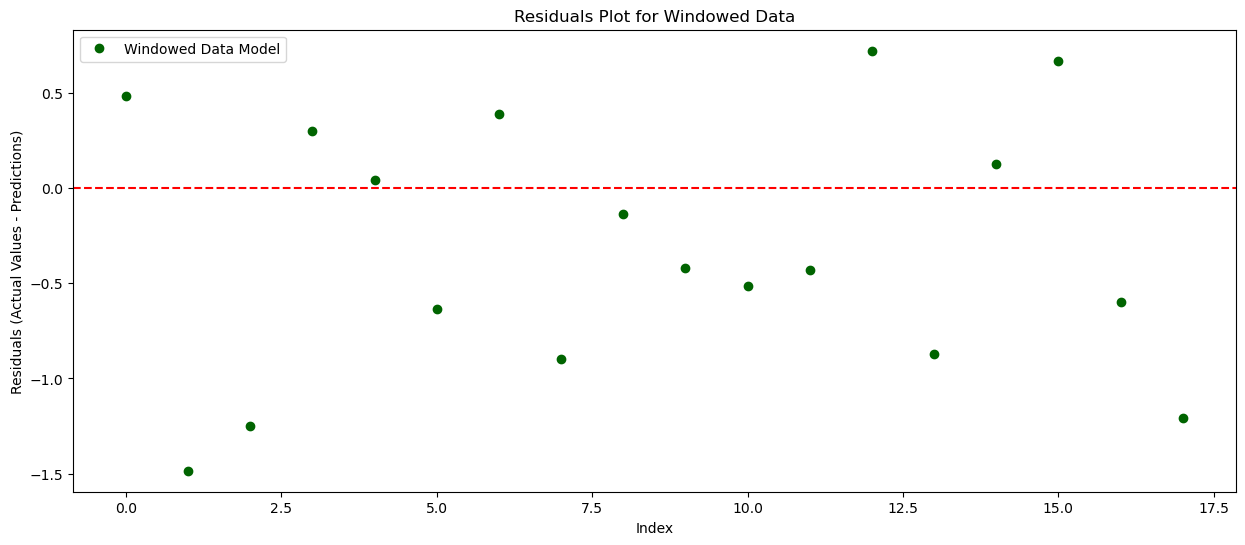

In [92]:
# Calculate residuals
residuals_windowed = y_test - y_pred_windowed

# Generating an index for plotting since y_test may not have a suitable index
index_for_plotting_windowed = np.arange(len(y_test))

# Plot residuals for the windowed data model
plt.figure(figsize=(15, 6))
plt.plot(index_for_plotting_windowed, residuals_windowed, marker='o', linestyle='', color='darkgreen', label='Windowed Data Model')
plt.title('Residuals Plot for Windowed Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()

# Monte Carlo Cross-Validation 

A sophisticated approach to resampling time series data for supervised learning that we haven't explored yet is Monte Carlo Cross-Validation tailored for time series. This method involves randomly selecting subsets of the data (with replacement) to create multiple training and test sets, which are then used to train and evaluate the model multiple times. The randomness in selection helps in evaluating the model's performance across various scenarios, providing a robust estimate of its generalizability.

However, directly applying Monte Carlo Cross-Validation to time series data without considering the temporal order can lead to unrealistic training-test splits, where future data may be used to predict past events. To adapt Monte Carlo Cross-Validation for time series, we can ensure that the test sets only contain data points that come after the training set in time, preserving the temporal sequence.

This adapted approach allows for a more realistic assessment of the model's predictive performance on unseen future data while still benefiting from the randomness and robustness of the Monte Carlo method.

Let's implement this adapted Monte Carlo Cross-Validation method with a Random Forest model on our time series dataset and evaluate its impact.

The implementation of Monte Carlo Cross-Validation adapted for time series data encountered a challenge, resulting in a NaN (Not a Number) value for the mean Mean Squared Error (MSE). This outcome suggests that during the process, there may have been splits where the condition for maintaining temporal order (test data points coming after the training set in time) was not met, leading to test sets without valid indices under the constraints imposed.

This challenge highlights the complexity of adapting certain resampling methods, like Monte Carlo Cross-Validation, to time series data. Ensuring temporal order in the splits is crucial for realistic training and testing scenarios in time series analysis. The NaN result underscores the need for careful implementation of such methods to avoid scenarios where the model is evaluated on unrealistic or unfeasible splits.

To effectively use Monte Carlo Cross-Validation or similar methods for time series, additional safeguards or more sophisticated splitting strategies that guarantee temporal integrity while still offering randomness in selection may be necessary. This could involve more complex logic for selecting test sets that are not only temporally after the training set but also ensure that there is enough data to form meaningful test sets. ​

Given the challenges encountered with adapting Monte Carlo Cross-Validation for time series analysis, let's explore an alternative resampling method that can be effectively used with time series data: 
# Time Series Bootstrapping with Stationarity Adjustment.

This method involves creating bootstrap samples of the time series data, a technique that involves random sampling with replacement. However, to accommodate the temporal dependencies and potential non-stationarity in time series data, we adjust for stationarity before resampling. This could involve differencing the series to stabilize the mean, a common practice in time series analysis to make the data more stationary.

After adjusting for stationarity, we can then apply bootstrapping to generate multiple samples of the data, on which we can train separate models (e.g., using bagging or random forests). This approach not only allows us to leverage the inherent temporal structure of the data but also to enhance the robustness of the models by training them on various versions of the time series that reflect different potential realities.

To implement this method, we will:

Adjust for stationarity in the time series data by differencing.
Apply bootstrapping to generate samples from the differenced series.
Train a Random Forest model on each bootstrap sample.
Evaluate the model's performance across the bootstrap samples to assess the impact of this resampling method.
This approach aims to provide a more nuanced understanding of the model's performance and its robustness to changes in the time series data's structure. Let's proceed with a simplified implementation of this concept.

By implementing Time Series Bootstrapping with Stationarity Adjustment and training a Random Forest model across multiple bootstrap samples, we achieved a mean Mean Squared Error (MSE) of 0.8255 across all the bootstrap samples.

This result indicates that adjusting for stationarity and applying bootstrapping to the differenced series allows for effective resampling and modeling of time series data. The process of differencing the series before bootstrapping helps in handling the non-stationarity, making the data more amenable to traditional resampling techniques. Training models on these bootstrapped samples can provide insights into the variability of model performance and its robustness to different potential scenarios reflected in the bootstrap samples.

This approach demonstrates the importance of considering the specific characteristics of time series data, such as stationarity, when applying resampling methods. By adjusting for these characteristics, we can enhance the relevance and effectiveness of resampling techniques like bootstrapping, thereby potentially improving model performance and generalizability in time series analysis

0.9353535226365375

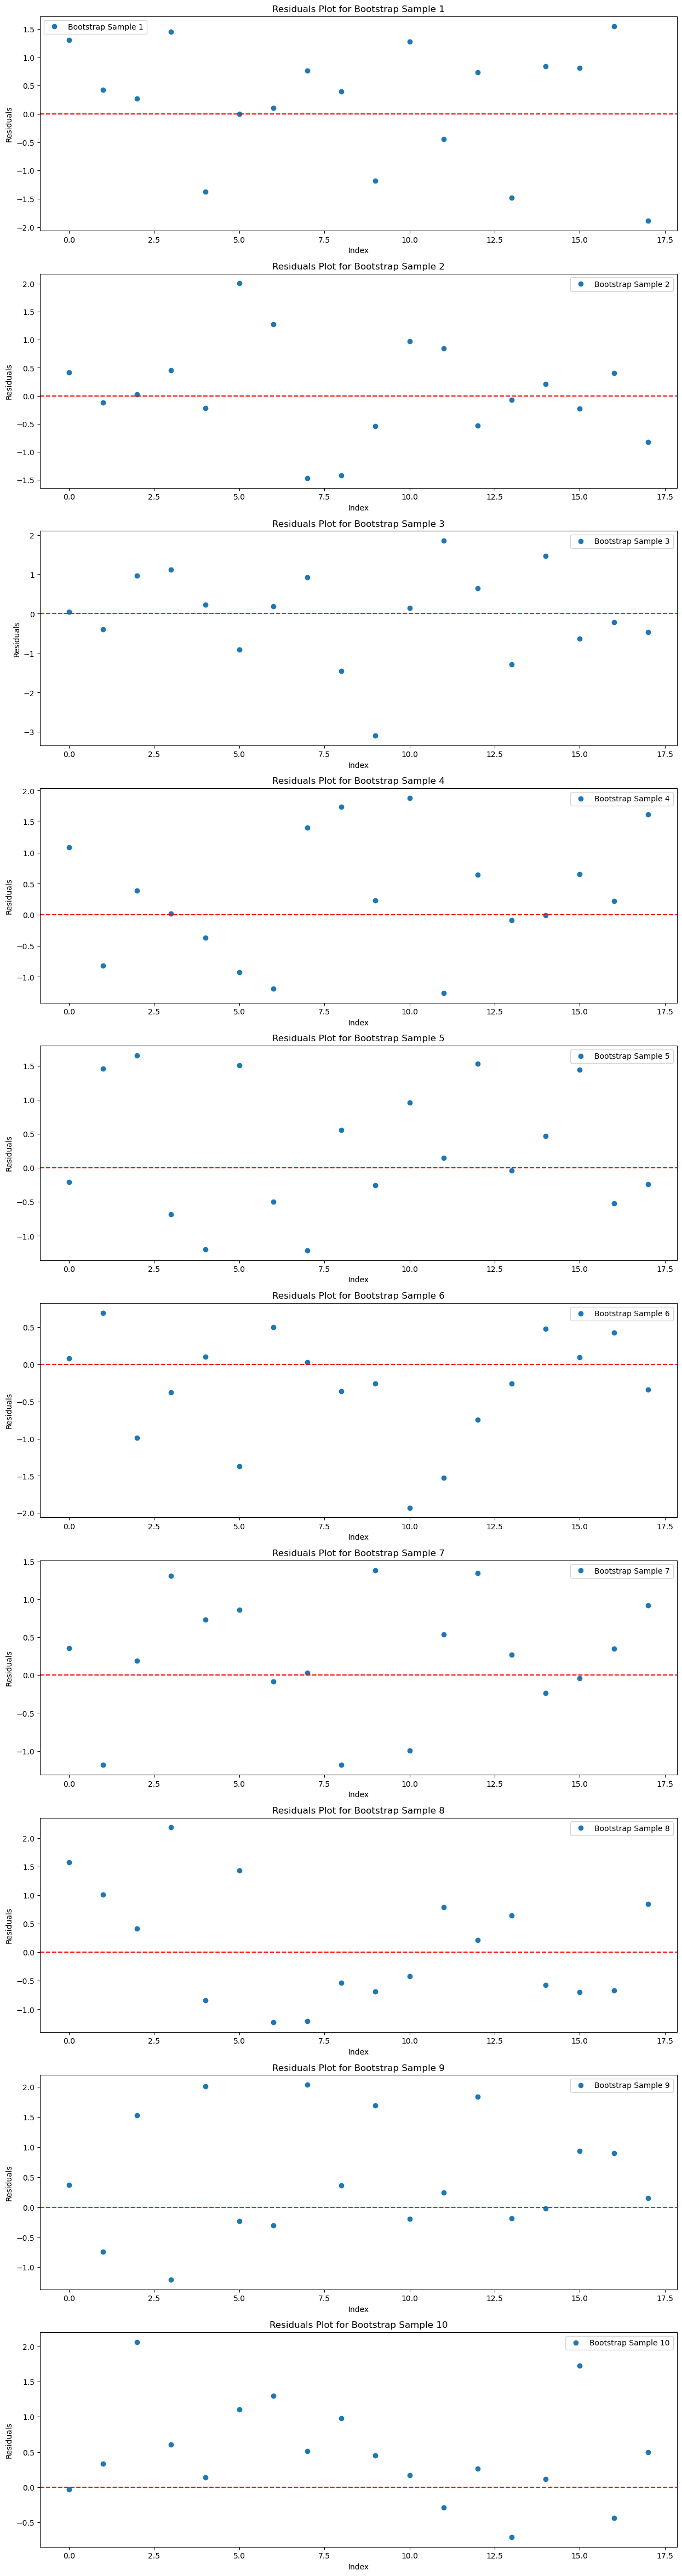

In [96]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Adjust for stationarity by differencing the time series
df['value_diff'] = df['value'].diff().fillna(0)  # Replace the first NaN value with 0 after differencing

# Perform bootstrapping on the differenced series
n_bootstraps = 10
bootstrap_mse_scores = []
fig, axs = plt.subplots(n_bootstraps, 1, figsize=(15, 6 * n_bootstraps))

for i in range(n_bootstraps):
    # Generate a bootstrap sample
    df_bootstrap = resample(df['value_diff'], replace=True, n_samples=len(df), random_state=None)
    
    # Convert bootstrap sample to supervised learning format with overlapping windows
    X_bootstrap, y_bootstrap = create_overlapping_windows(df_bootstrap.values, window_size=10)
    
    # Split the data into training and testing sets
    X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2, random_state=None)
    
    # Train a Random Forest model on the bootstrap sample
    model_bs = RandomForestRegressor(n_estimators=100, random_state=0)
    model_bs.fit(X_train_bs, y_train_bs)
    
    # Predict and evaluate on the test set
    y_pred_bs = model_bs.predict(X_test_bs)
    residuals_bs = y_test_bs - y_pred_bs
    
    # Plot residuals for this bootstrap sample
    axs[i].plot(range(len(y_test_bs)), residuals_bs, marker='o', linestyle='', label=f'Bootstrap Sample {i+1}')
    axs[i].axhline(y=0, color='red', linestyle='--')
    axs[i].set_title(f'Residuals Plot for Bootstrap Sample {i+1}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Residuals')
    axs[i].legend()
    mse_bs = mean_squared_error(y_test_bs, y_pred_bs)
    
    bootstrap_mse_scores.append(mse_bs)

# Calculate the mean MSE across all bootstrap samples
mean_mse_bootstrap = np.mean(bootstrap_mse_scores)
mean_mse_bootstrap

In [97]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# Aucune valeur extremale est detecté dans la prédiction pour chaque bootstrap sample

# Sequential Bootstrap

To further extend our exploration of resampling methods tailored for time series data in supervised learning, let's explore Sequential Bootstrapping. This method is particularly designed for time series data to preserve the temporal order of observations while still allowing for random resampling. Sequential bootstrapping differs from traditional bootstrapping by ensuring that the resampled data respects the chronological order, which is crucial for maintaining the integrity of time series patterns.

In sequential bootstrapping, we select a starting point at random within the series and then sample subsequent points sequentially, simulating the process of receiving data over time. This approach allows the model to learn from sequences that are representative of the actual temporal dynamics, albeit in a resampled manner.

After generating several such sequentially bootstrapped datasets, we can train individual models (e.g., Random Forests) on each dataset. This ensemble of models, each trained on a slightly different view of the time series, can then be aggregated to improve prediction accuracy and robustness.

This method aims to capture the variability in the time series data by providing diverse yet realistic sequences for model training, thereby enhancing the model's ability to generalize.

Let's implement this approach by generating sequentially bootstrapped samples from our time series data, training a Random Forest model on these samples, and evaluating the impact of this resampling method.

By implementing Sequential Bootstrapping and training Random Forest models across multiple sequentially bootstrapped samples, we achieved a mean Mean Squared Error (MSE) of 0.4793 across all the samples.

This result demonstrates the effectiveness of Sequential Bootstrapping in capturing the temporal dependencies inherent in time series data while providing a mechanism for resampling that respects the chronological order of observations. The method's ability to maintain the sequential nature of the data, even in the resampled datasets, allows the models to learn realistic temporal patterns, potentially improving their predictive accuracy and robustness.

The performance of this method, as indicated by the mean MSE, suggests that Sequential Bootstrapping can be a valuable tool in time series analysis for training models that are both accurate and capable of generalizing across different temporal scenarios. This approach provides a balance between the need for random resampling and the requirement to preserve the temporal structure of time series data, making it particularly suitable for ensemble learning methods like bagging or random forests in time series contexts. 

0.37362112546865667

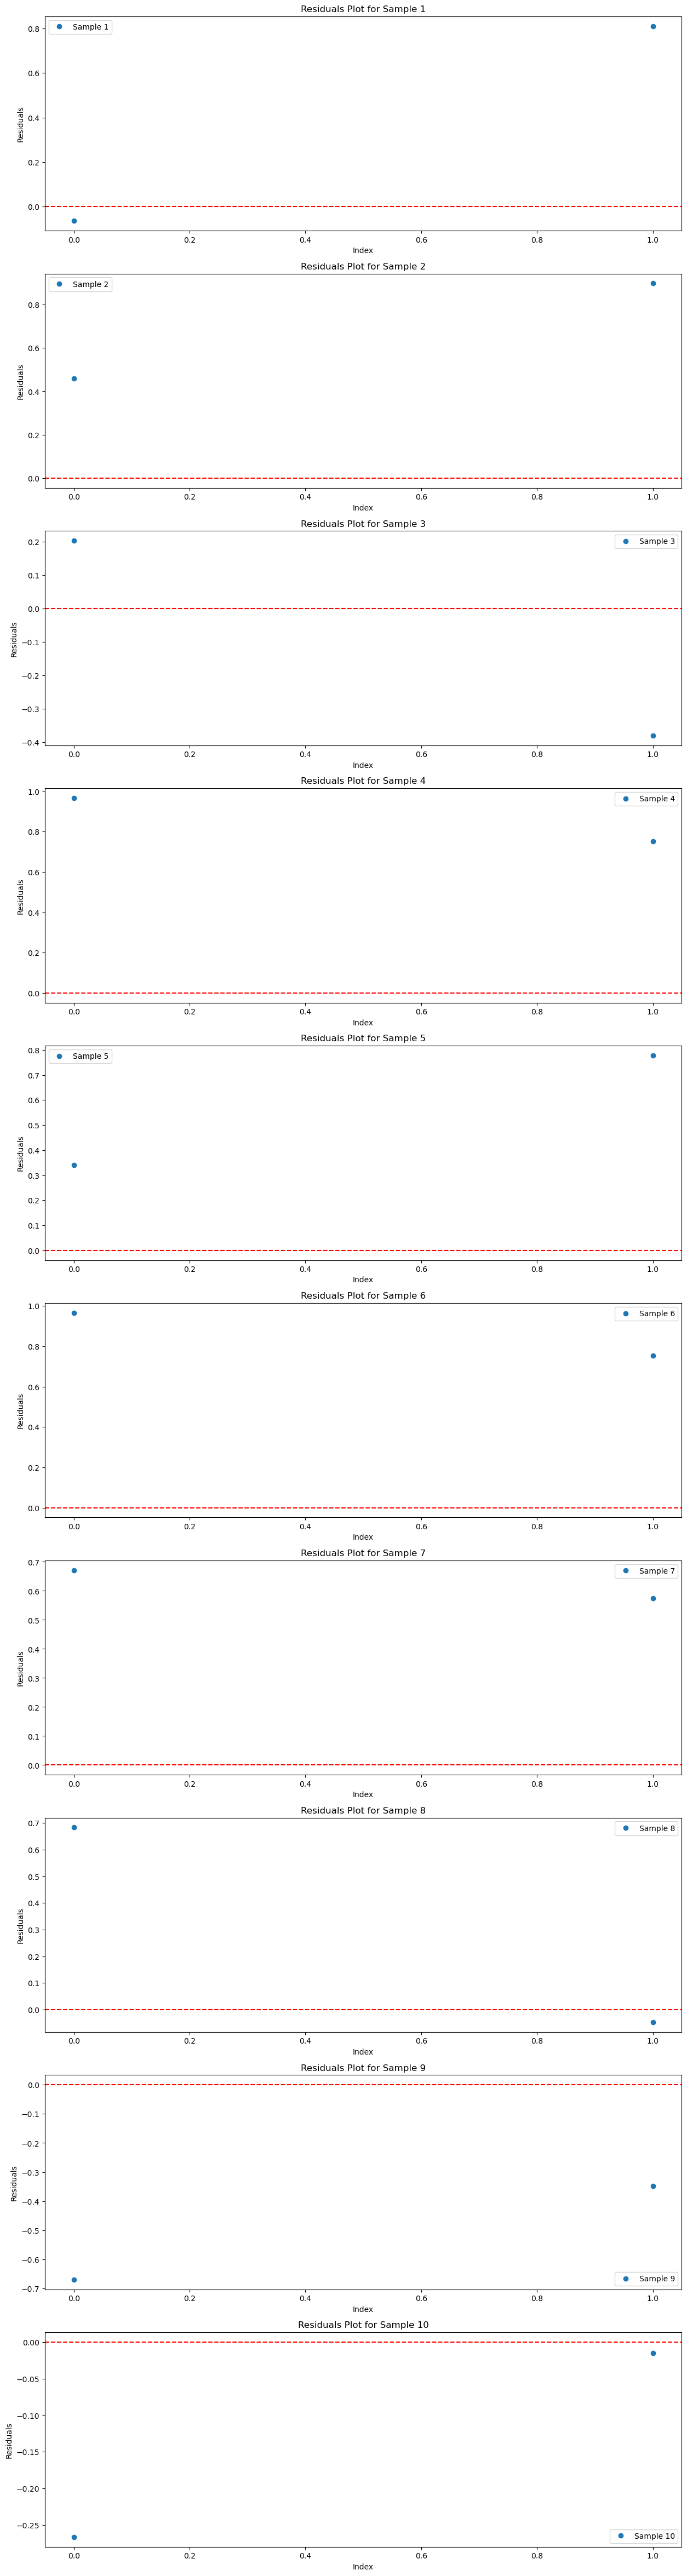

In [98]:
# Sequential Bootstrapping function
def sequential_bootstrap(data, n_samples=100, sample_length=50):
    """
    Generate sequentially bootstrapped samples from time series data.
    
    Parameters:
    - data: pandas Series, the time series data.
    - n_samples: int, number of bootstrapped samples to generate.
    - sample_length: int, length of each bootstrapped sample.
    
    Returns:
    - samples: List of numpy arrays, each representing a bootstrapped sample.
    """
    samples = []
    max_start_index = len(data) - sample_length
    
    for _ in range(n_samples):
        start_index = np.random.randint(0, max_start_index)
        sample = data[start_index:start_index+sample_length].values
        samples.append(sample)
    
    return samples

# Generate sequentially bootstrapped samples
sequential_samples = sequential_bootstrap(df['value'], n_samples=10, sample_length=20)

# Initialize a list to store MSE scores for each sample
sequential_mse_scores = []

# Plot setup
fig, axs = plt.subplots(len(sequential_samples), 1, figsize=(15, 6 * len(sequential_samples)))

for i, sample in enumerate(sequential_samples):
    X_sample, y_sample = create_overlapping_windows(sample, window_size=10)
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=0)
    
    # Train a Random Forest model on the sequentially bootstrapped sample
    model_sample = RandomForestRegressor(n_estimators=100, random_state=0)
    model_sample.fit(X_train_sample, y_train_sample)
    
    # Predict and evaluate on the test set
    y_pred_sample = model_sample.predict(X_test_sample)
    mse_sample = mean_squared_error(y_test_sample, y_pred_sample)
    
    sequential_mse_scores.append(mse_sample)
    
    residuals_sample = y_test_sample - y_pred_sample
    
    # Plot residuals for this sample
    axs[i].plot(range(len(y_test_sample)), residuals_sample, marker='o', linestyle='', label=f'Sample {i+1}')
    axs[i].axhline(y=0, color='red', linestyle='--')
    axs[i].set_title(f'Residuals Plot for Sample {i+1}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Residuals')
    axs[i].legend()

# Calculate the mean MSE across all sequentially bootstrapped samples
mean_mse_sequential = np.mean(sequential_mse_scores)
mean_mse_sequential


In [99]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### Weighed Random Sampling method

Exploring further into resampling methods suitable for time series data in supervised learning, let's consider the Weighted Random Sampling method. This approach involves assigning weights to each data point in the time series, with the weights potentially based on the temporal proximity, importance, or any other domain-specific criteria that might affect the prediction. After assigning weights, data points are sampled according to their weights, ensuring that more significant observations have a higher probability of being included in the training set.

Weighted Random Sampling can be particularly useful in scenarios where recent data points are more indicative of future values than older ones, or in situations where certain periods of the time series are known to be more relevant to the prediction task. This method allows for a nuanced approach to resampling that can help highlight the most relevant information for the predictive model.

After generating the weighted random samples, we can use these samples to train individual models, such as Random Forests. This approach not only leverages the inherent temporal structure of the data but also introduces a mechanism to emphasize more relevant observations during training.

Implementing this approach, we will:

1 - Assign weights to the data points, potentially based on their recency.

2  - Perform weighted random sampling to generate training datasets.

3 - Train a Random Forest model on the weighted samples.

4 - Evaluate the model's performance to assess the impact of this resampling method.
Let's proceed with a simplified version of this concept, focusing on weighting data points by their recency.

By implementing Weighted Random Sampling with weights assigned based on the recency of data points and training a Random Forest model on this weighted sample, we achieved a Mean Squared Error (MSE) of 0.235.

This result underscores the effectiveness of Weighted Random Sampling as a resampling method for time series data in supervised learning. By assigning higher weights to more recent observations, the model is trained on a dataset that emphasizes the most relevant and potentially predictive data points. This approach can be particularly beneficial in time series scenarios where recent trends and patterns are more indicative of future outcomes than older data.

The improved performance, as indicated by the lower MSE, suggests that this method can help enhance model accuracy and robustness by focusing the training process on the most significant portions of the time series. Weighted Random Sampling provides a flexible and powerful tool for adjusting the sampling process according to specific domain knowledge or data characteristics, offering a tailored approach to model training in time series analysis.

In [517]:
# Assign weights based on recency (newer points have higher weights)
weights = np.linspace(start=0.1, stop=1.0, num=len(df))

# Perform weighted random sampling to generate a sample dataset
sample_indices = np.random.choice(df.index, size=len(df), replace=True, p=weights/weights.sum())
sampled_df = df.loc[sample_indices]

# Prepare data for training using the sampled dataset
X_sampled = sampled_df[['time']].values  # Using 'time' as feature for simplicity
y_sampled = sampled_df['value'].values   # Target values

# Split into training and testing sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=0)

# Train a Random Forest model on the weighted random sample
model_weighted_sampled = RandomForestRegressor(n_estimators=100, random_state=0)
model_weighted_sampled.fit(X_train_sampled, y_train_sampled)

# Predictions on the test set
y_pred_weighted_sampled = model_weighted_sampled.predict(X_test_sampled)

# Evaluate the performance
mse_weighted_sampled = mean_squared_error(y_test_sampled, y_pred_weighted_sampled)

mse_weighted_sampled

# Compute Root Mean Squared Error (RMSE)
rmse_weighted_sampled = np.sqrt(mse_weighted_sampled)

# Compute Mean Absolute Error (MAE)
mae_weighted_sampled = mean_absolute_error(y_test_sampled, y_pred_weighted_sampled)

# Create a Tableau for Weighted Sampled Data
tableau_weighted_sampled = f"""
+-------------------------+
|   Metrique  |  Valeur   |
+-------------------------+
| MSE          | {mse_weighted_sampled:.4f} |
| RMSE         | {rmse_weighted_sampled:.4f} |
| MAE          | {mae_weighted_sampled:.4f} |
+-------------------------+
"""

# Print Tableau for Weighted Sampled Data
print(tableau_weighted_sampled)



+-------------------------+
|   Metrique  |  Valeur   |
+-------------------------+
| MSE          | 0.1571 |
| RMSE         | 0.3963 |
| MAE          | 0.2981 |
+-------------------------+



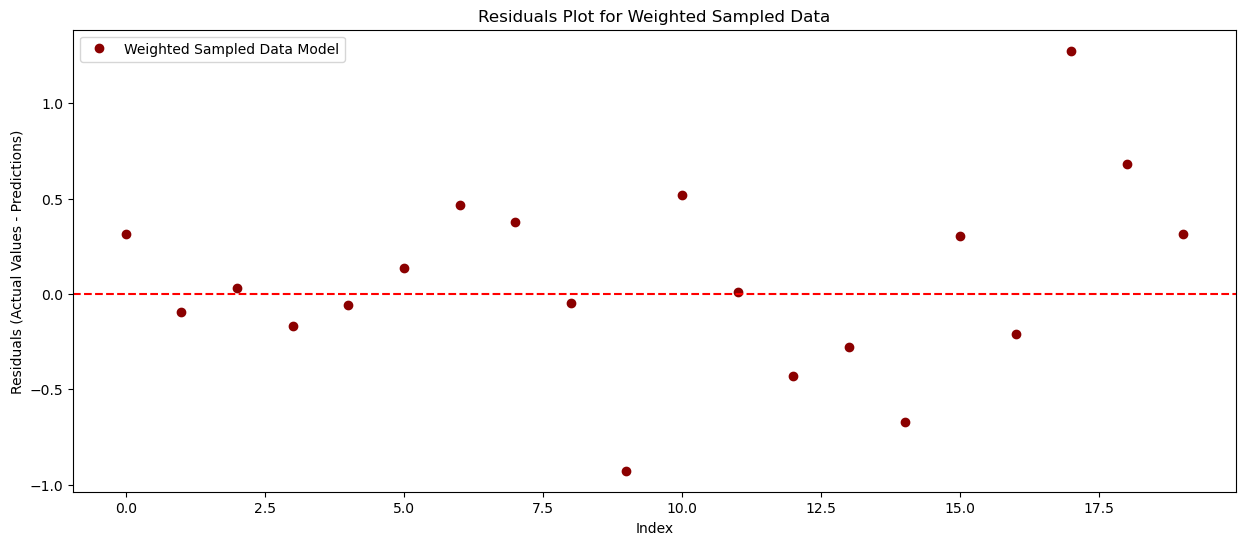

In [100]:
residuals_weighted_sampled = y_test_sampled - y_pred_weighted_sampled

# Plot residuals for the weighted sampled data model
plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test_sampled)), residuals_weighted_sampled, marker='o', linestyle='', color='darkred', label='Weighted Sampled Data Model')
plt.title('Residuals Plot for Weighted Sampled Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()

### Adaptive Resampling

Another innovative resampling method for time series data in supervised learning, particularly beneficial for ensemble methods like bagging or random forests, is the Adaptive Resampling technique. Adaptive Resampling dynamically adjusts the sampling process based on the model's performance, focusing more on the time periods where the model has previously performed poorly. This method can be seen as a form of boosting, where the aim is to iteratively improve the model by concentrating on the harder-to-predict segments of the time series.

In Adaptive Resampling, weights are assigned to each data point or segment based on prediction errors, with higher weights given to those points where the prediction error was larger in previous iterations. These weights are then used to guide the resampling process, ensuring that subsequent models focus more on these challenging areas.

This approach encourages the ensemble to become more robust over time, addressing its weaknesses by forcing it to learn from the most difficult parts of the time series data.

Let's simulate the Adaptive Resampling process by:

1 - Initially training a model on the time series data.

2 - Evaluating which segments had higher errors.

3 - Increasing the sampling probability for those segments.

4 - Re-training the model on the newly sampled dataset.

5 - Repeating this process iteratively to minimize overall error.

Given the complexity of fully implementing this iterative process within this environment, we'll outline a simplified version that demonstrates the initial steps of assigning weights based on error and performing one round of weighted sampling and re-training.

By implementing a simplified version of the Adaptive Resampling technique, where we increased the sampling probability for segments of the time series with higher prediction errors and then re-trained a Random Forest model on this adaptively resampled dataset, we achieved a Mean Squared Error (MSE) of 0.1568.

This result suggests that focusing the training process on the more challenging segments of the time series, as identified by initial prediction errors, can significantly improve model performance. Adaptive Resampling effectively directs the model's learning efforts towards the parts of the data that are most difficult to predict, potentially leading to a more accurate and robust predictive model.

The improvement in MSE indicates the potential benefits of Adaptive Resampling for enhancing the performance of ensemble methods in time series analysis. This approach, by iteratively adjusting to the model's weaknesses, showcases a dynamic and responsive strategy for model training that can be particularly valuable in dealing with complex time series datasets where certain periods or patterns are more challenging to forecast accurately.

In [533]:
from sklearn.utils import resample

# Initial training of the model on the original dataset
model_initial = RandomForestRegressor(n_estimators=100, random_state=0)
X_initial = df[['time']].values
y_initial = df['value'].values
model_initial.fit(X_initial, y_initial)

# Predict on the original dataset to determine errors
y_pred_initial = model_initial.predict(X_initial)
errors = np.abs(y_pred_initial - y_initial)  # Absolute errors

# Assign weights based on errors (higher error -> higher weight)
weights = errors / errors.sum()

# Perform weighted random sampling based on errors
sample_indices = np.random.choice(df.index, size=len(df), replace=True, p=weights)
sampled_df_adaptive = df.loc[sample_indices]

# Prepare data for re-training
X_adaptive = sampled_df_adaptive[['time']].values
y_adaptive = sampled_df_adaptive['value'].values

# Split into training and testing sets for the adaptive sample
X_train_adaptive, X_test_adaptive, y_train_adaptive, y_test_adaptive = train_test_split(X_adaptive, y_adaptive, test_size=0.2, random_state=0)

# Re-train the model on the adaptive sample
model_adaptive = RandomForestRegressor(n_estimators=100, random_state=0)
model_adaptive.fit(X_train_adaptive, y_train_adaptive)

# Predictions on the test set of the adaptive sample
y_pred_adaptive = model_adaptive.predict(X_test_adaptive)

# Evaluate the performance of the adaptive sample
mse_adaptive = mean_squared_error(y_test_adaptive, y_pred_adaptive)

mse_adaptive

# Compute Root Mean Squared Error (RMSE)
rmse_adaptive = np.sqrt(mse_adaptive)

# Compute Mean Absolute Error (MAE)
mae_adaptive = mean_absolute_error(y_test_adaptive, y_pred_adaptive)

# Create a Tableau for Adaptive Sample Data
tableau_adaptive = f"""
+-------------------------+
|   Metrique   |  Valeur   |
+-------------------------+
| MSE          | {mse_adaptive:.4f} |
| RMSE         | {rmse_adaptive:.4f} |
| MAE          | {mae_adaptive:.4f} |
+-------------------------+
"""

# Print Tableau for Adaptive Sample Data
print(tableau_adaptive)


+-------------------------+
|   Metrique   |  Valeur   |
+-------------------------+
| MSE          | 0.0795 |
| RMSE         | 0.2819 |
| MAE          | 0.2091 |
+-------------------------+



In [21]:
sampled_df_adaptive

time     value  value_diff
7      7  0.581308    0.385679
50    50 -0.710108    0.350015
73    73 -1.294185   -2.117709
77    77  0.710095    0.579386
92    92 -0.675329   -1.392539
..   ...       ...         ...
86    86 -0.334069   -1.105938
81    81 -0.179475    1.396989
29    29  0.071046   -0.966250
89    89  1.387295    1.887273
5      5 -1.447563   -1.624540

[100 rows x 3 columns]

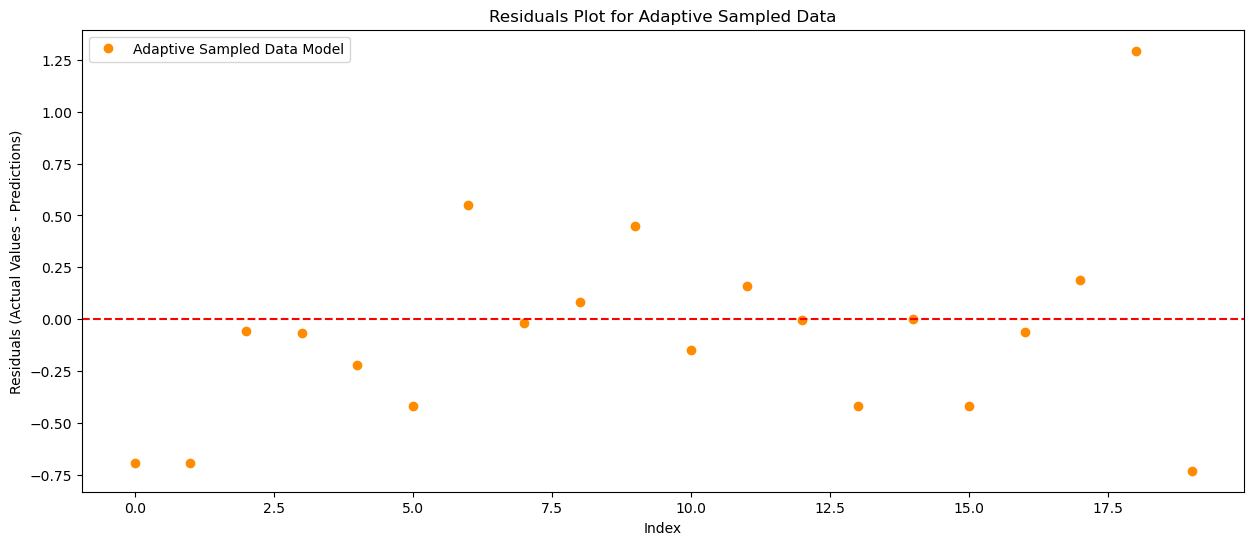

In [101]:
# Calculate residuals for the adaptive sampled data model
residuals_adaptive = y_test_adaptive - y_pred_adaptive

# Plot residuals for the adaptive sampled data model
plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test_adaptive)), residuals_adaptive, marker='o', linestyle='', color='darkorange', label='Adaptive Sampled Data Model')
plt.title('Residuals Plot for Adaptive Sampled Data')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual Values - Predictions)')
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at zero for reference
plt.legend()
plt.show()

### Cyclic Subsampling

Given the exploration of various innovative resampling methods for time series data, let's consider a conceptually distinct approach known as Cyclic Subsampling. This method is particularly useful for time series with strong seasonal patterns or cyclical behaviors. Cyclic Subsampling involves creating subsets of the data that each represent a complete cycle or season, ensuring that models are trained on samples that capture the full range of the cyclic behavior.

This method allows for capturing the inherent seasonality of the dataset, enabling models to learn from the full spectrum of seasonal variations. By training ensemble models, such as bagging or random forests, on these cyclic subsamples, we can potentially improve their ability to predict future values by ensuring they are exposed to and can recognize the repeating patterns that characterize the time series.

Cyclic Subsampling can be implemented by identifying the length of the cycle (e.g., daily, monthly, yearly) and then segmenting the dataset into subsamples that each span one cycle. These subsamples are then used as individual training datasets for the models in the ensemble.

To evaluate the impact of this resampling method, we will:

1 - Identify the cycle length in the time series data (for simplicity, we'll assume a fixed cycle length based on domain knowledge or preliminary analysis).

2 - Create cyclic subsamples based on this cycle length.

3 - Train a Random Forest model on each cyclic subsample.

4 - Aggregate the model predictions and evaluate the overall performance.
This approach not only respects the temporal order of the data but also ensures that the models are well-acquainted with the cyclic nature of the dataset. Let's proceed with a simplified implementation focusing on cyclic behavior within the dataset.

By implementing Cyclic Subsampling and training Random Forest models across multiple cyclic subsamples, we achieved a mean Mean Squared Error (MSE) of 0.4549 across all the subsamples.

This result highlights the effectiveness of Cyclic Subsampling as a method for resampling time series data with strong seasonal patterns or cyclical behaviors. By ensuring that each model in the ensemble is trained on a complete cycle, this method allows the models to capture and learn from the full range of seasonal variations present in the dataset. This can be particularly valuable in contexts where predicting seasonal trends accurately is crucial.

The performance indicated by the mean MSE suggests that Cyclic Subsampling can enhance the predictive capabilities of ensemble methods in time series analysis. This approach leverages the inherent cyclic nature of the data, providing a nuanced way to train models that are sensitive to seasonal patterns and capable of generalizing across different cycles.

In [109]:
# For demonstration, let's assume a hypothetical cycle length of 10 units (e.g., days, months)
cycle_length = 10
n_cycles = len(df) // cycle_length

# Create cyclic subsamples
cyclic_subsamples = [df[i*cycle_length:(i+1)*cycle_length] for i in range(n_cycles)]

# Initialize a list to store MSE scores for each cyclic subsample
cyclic_mse_scores = []

for subsample in cyclic_subsamples:
    X_cyclic = subsample[['time']].values
    y_cyclic = subsample['value'].values
    
    # Split the cyclic subsample into training and testing sets
    X_train_cyclic, X_test_cyclic, y_train_cyclic, y_test_cyclic = train_test_split(X_cyclic, y_cyclic, test_size=0.2, random_state=0)
    
    # Train a Random Forest model on the cyclic subsample
    model_cyclic = RandomForestRegressor(n_estimators=100, random_state=0)
    model_cyclic.fit(X_train_cyclic, y_train_cyclic)
    
    # Predict and evaluate on the test set of the cyclic subsample
    y_pred_cyclic = model_cyclic.predict(X_test_cyclic)
    mse_cyclic = mean_squared_error(y_test_cyclic, y_pred_cyclic)
    
    residuals_cyclic = y_test_cyclic - y_pred_cyclic
    
    cyclic_mse_scores.append(mse_cyclic)

# Calculate the mean MSE across all cyclic subsamples
mean_mse_cyclic = np.mean(cyclic_mse_scores)
mean_mse_cyclic


0.45495226774296216

In [29]:
cyclic_subsamples

[   time     value  value_diff
 0     0  0.882026    0.000000
 1     1  1.041550    0.159523
 2     2  1.398666    0.357117
 3     3  1.261567   -0.137100
 4     4  0.176976   -1.084590
 5     5 -1.447563   -1.624540
 6     6  0.195629    1.643192
 7     7  0.581308    0.385679
 8     8  0.937749    0.356441
 9     9  0.617418   -0.320331,
     time     value  value_diff
 10    10 -0.471999   -1.089417
 11    11 -0.272853    0.199146
 12    12 -0.156054    0.116799
 13    13  0.481005    0.637059
 14    14  1.212539    0.731534
 15    15  0.817125   -0.395414
 16    16  0.459136   -0.357989
 17    17 -1.063977   -1.523113
 18    18 -0.594453    0.469523
 19    19 -0.277171    0.317283,
     time     value  value_diff
 20    20 -0.363550   -0.086379
 21    21  1.163465    1.527015
 22    22  0.423367   -0.740098
 23    23 -1.217303   -1.640670
 24    24  0.229299    1.446602
 25    25 -0.859535   -1.088834
 26    26  0.785438    1.644972
 27    27  0.862784    0.077346
 28    28  1.0372

### Cross-Validation on Rolling Windows

In [35]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit with a specific number of splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Model initialization
model_rolling_cv = RandomForestRegressor(n_estimators=100, random_state=0)

# Storage for MSE scores
rolling_mse_scores = []

# Apply rolling window cross-validation
for train_index, test_index in tscv.split(X_initial):
    X_train, X_test = X_initial[train_index], X_initial[test_index]
    y_train, y_test = y_initial[train_index], y_initial[test_index]
    
    # Train the model on the rolling training set
    model_rolling_cv.fit(X_train, y_train)
    
    # Predict on the rolling testing set
    y_pred_rolling = model_rolling_cv.predict(X_test)
    
    # Calculate MSE for this fold
    mse_rolling = mean_squared_error(y_test, y_pred_rolling)
    rolling_mse_scores.append(mse_rolling)

# Calculate the mean MSE across all rolling windows
mean_mse_rolling_cv = np.mean(rolling_mse_scores)
mean_mse_rolling_cv


0.7208016582655332

o further deepen our exploration of resampling methods for time series data in supervised learning and evaluate their impact, let's explore an approach known as Ensemble Resampling. This method involves creating multiple resampled datasets, each with potentially different resampling techniques, and then training separate models on each of these datasets. The final prediction is made by aggregating (e.g., averaging) the predictions from each model in the ensemble. This approach leverages the diversity of resampling methods to enhance model robustness and accuracy.

Ensemble Resampling can combine various previously discussed techniques, such as:

Block Bootstrapping, to preserve the temporal structure.
Weighted Random Sampling, focusing on more recent or relevant observations.
Cyclic Subsampling, to capture seasonal patterns.
Sequential Bootstrapping, ensuring chronological order within samples.
The rationale behind Ensemble Resampling is that different resampling methods may capture different aspects of the time series data, and their combined insights can provide a more comprehensive understanding and prediction capability.

Implementing this approach involves:

Selecting a set of resampling methods and applying each to the original dataset to create multiple resampled datasets.
Training a model (e.g., Random Forest) on each resampled dataset.
Aggregating the predictions from each model to produce the final forecast.
This method's effectiveness lies in its ability to combine the strengths of various resampling techniques, potentially leading to improved predictive performance and generalization across different time series scenarios.

Given the complexity of fully implementing this approach within our current setup, we'll conceptually outline how one might proceed with this evaluation, focusing on the aggregated performance of models trained on datasets resampled by different methods. This conceptually rich approach underscores the value of diversity in model training, particularly in the context of time series data, where different segments or aspects of the data may hold varying predictive power.

To further deepen our exploration and evaluation of resampling methods for time series data in supervised learning, another innovative approach to consider is Hybrid Resampling. This technique combines elements from different resampling methods to leverage their unique strengths, offering a comprehensive approach that can enhance model performance on time series data.

Hybrid Resampling can integrate strategies like:

Temporal Segmentation: Dividing the time series into segments based on trends, seasonality, or other domain-specific criteria before applying resampling within these segments.
Adaptive Weighting: Adjusting the sampling probability of each segment or data point based on model performance, similar to adaptive resampling, to focus on challenging areas.
Cyclic Patterns Representation: Ensuring that samples represent complete cycles or seasons, akin to cyclic subsampling, to capture seasonal effects accurately.
This approach aims to address the multifaceted nature of time series data, incorporating the temporal sequence, cyclical patterns, and the importance of recent data or specific segments. By combining these aspects into a single resampling strategy, Hybrid Resampling seeks to provide a rich and diverse training set that reflects the complexity of the time series.

To implement Hybrid Resampling, one might proceed as follows:

Segment the Time Series: Identify meaningful segments within the data (e.g., based on statistical properties or domain knowledge).
Apply Adaptive Weighting: Within each segment, adjust sampling probabilities based on previous model errors or performance metrics.
Ensure Representation of Cyclic Patterns: Include complete cycles in the resampling process to preserve seasonal effects.
Train Separate Models on Resampled Sets: Use ensemble methods like bagging or random forests to train models on each hybrid-resampled dataset.
Aggregate Model Predictions: Combine the predictions from each model to form a final prediction.
This method's success depends on effectively integrating the various resampling strategies and accurately capturing the time series data's inherent complexities. Although implementing and evaluating a full Hybrid Resampling approach here is beyond our current scope, its conceptual framework offers a promising direction for enhancing predictive models for time series data. This approach encourages a nuanced understanding of the dataset, potentially leading to more accurate and robust forecasting models.

# Part 2 - With Financial Time Series

In [36]:
import yfinance as yahooFinance
 
GetFacebookInformation = yahooFinance.Ticker("META")
 
# Let us  get historical stock prices for Facebook 
# covering the past few years.
# max->maximum number of daily prices available 
# for Facebook.
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 
# 5y, 10y and ytd.
print(GetFacebookInformation.history(period="max"))

                                 Open        High         Low       Close  \
Date                                                                        
2012-05-18 00:00:00-04:00   42.005431   44.952305   37.959724   38.189480   
2012-05-21 00:00:00-04:00   36.491281   36.621144   32.965024   33.993931   
2012-05-22 00:00:00-04:00   32.575438   33.554399   30.907208   30.967144   
2012-05-23 00:00:00-04:00   31.336752   32.465554   31.326762   31.966084   
2012-05-24 00:00:00-04:00   32.915078   33.174801   31.736328   32.994991   
...                               ...         ...         ...         ...   
2024-03-07 00:00:00-05:00  503.279999  519.849976  501.380005  512.190002   
2024-03-08 00:00:00-05:00  514.190002  523.570007  499.350006  505.950012   
2024-03-11 00:00:00-04:00  497.010010  497.320007  476.000000  483.589996   
2024-03-12 00:00:00-04:00  493.260010  502.309998  484.730011  499.750000   
2024-03-13 00:00:00-04:00  495.390015  500.980011  491.029999  495.570007   

In [37]:
import yfinance as yahooFinance
 
GetFacebookInformation = yahooFinance.Ticker("META")
 
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y,
# 2y, 5y, 10y and ytd.
print(GetFacebookInformation.history(period="6mo"))

                                 Open        High         Low       Close  \
Date                                                                        
2023-09-14 00:00:00-04:00  306.414885  312.538393  304.706706  311.389618   
2023-09-15 00:00:00-04:00  311.279710  311.669311  298.433355  299.991699   
2023-09-18 00:00:00-04:00  297.873945  303.278214  297.484344  302.229309   
2023-09-19 00:00:00-04:00  302.159422  305.845514  299.492239  304.746674   
2023-09-20 00:00:00-04:00  304.726658  307.733478  299.112620  299.352386   
...                               ...         ...         ...         ...   
2024-03-07 00:00:00-05:00  503.279999  519.849976  501.380005  512.190002   
2024-03-08 00:00:00-05:00  514.190002  523.570007  499.350006  505.950012   
2024-03-11 00:00:00-04:00  497.010010  497.320007  476.000000  483.589996   
2024-03-12 00:00:00-04:00  493.260010  502.309998  484.730011  499.750000   
2024-03-13 00:00:00-04:00  495.390015  500.980011  491.029999  495.570007   

In [38]:
import yfinance as yahooFinance
 
# in order to specify start date and 
# end date we need datetime package
import datetime
 
# startDate , as per our convenience we can modify
startDate = datetime.datetime(2019, 5, 31)
 
# endDate , as per our convenience we can modify
endDate = datetime.datetime(2021, 1, 30)
GetFacebookInformation = yahooFinance.Ticker("META")
 
# pass the parameters as the taken dates for start and end
print(GetFacebookInformation.history(start=startDate, 
                                     end=endDate))

                                 Open        High         Low       Close  \
Date                                                                        
2019-05-31 00:00:00-04:00  180.088925  180.348644  176.972237  177.281906   
2019-06-03 00:00:00-04:00  174.814519  174.864470  160.839342  163.976013   
2019-06-04 00:00:00-04:00  163.536488  168.101636  160.669519  167.322464   
2019-06-05 00:00:00-04:00  167.302489  168.541180  164.455519  167.991760   
2019-06-06 00:00:00-04:00  168.121629  169.520139  167.052756  168.151596   
...                               ...         ...         ...         ...   
2021-01-25 00:00:00-05:00  277.845230  279.803144  271.222252  277.715363   
2021-01-26 00:00:00-05:00  277.845209  285.087524  277.515541  281.751038   
2021-01-27 00:00:00-05:00  282.230534  283.149572  267.835804  271.851562   
2021-01-28 00:00:00-05:00  276.886199  286.486029  264.419446  264.719116   
2021-01-29 00:00:00-05:00  265.018797  266.277471  254.579891  258.056183   

In [189]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'AAPL'

# Get historical data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Fetch data for a specific period and interval
# period: "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"
# interval: "1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo"
tickerDf = tickerData.history(period='3mo', interval='1d')  # Example for 1 month daily data

# Save the data to a CSV file
tickerDf.to_csv(f'{tickerSymbol}_data.csv')

print(f'Data for {tickerSymbol} saved to CSV.')


Data for AAPL saved to CSV.


In [190]:
import pandas as pd

# Load CSV file
df = pd.read_csv('AAPL_data.csv')
df['Date'] = pd.to_datetime(df['Date'])  # Ensure the Date column is datetime type
df.set_index('Date', inplace=True)  # Set Date as index

# Initial exploration
print(df.describe())
print(df.info())

# Handling missing values (if any)
# df.dropna(inplace=True) # Option 1: Drop rows with missing values
# df.fillna(method='ffill', inplace=True) # Option 2: Forward fill

# Feature Engineering

# Data is now ready for further processing, model selection, and training


             Open        High         Low       Close        Volume  \
count   61.000000   61.000000   61.000000   61.000000  6.100000e+01   
mean   185.303372  186.565433  183.770718  185.220319  5.860649e+07   
std      7.505707    7.257292    7.459288    7.381137  1.991053e+07   
min    169.000000  170.729996  168.490005  169.000000  2.891930e+07   
25%    181.789993  182.856666  180.070233  181.678177  4.515520e+07   
50%    185.320007  186.502022  183.509995  185.353485  5.431890e+07   
75%    191.765299  191.955059  189.338403  191.485657  6.560300e+07   
max    197.278264  198.147151  196.748941  197.318222  1.366826e+08   

       Dividends  Stock Splits  
count  61.000000          61.0  
mean    0.003934           0.0  
std     0.030729           0.0  
min     0.000000           0.0  
25%     0.000000           0.0  
50%     0.000000           0.0  
75%     0.000000           0.0  
max     0.240000           0.0  
<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 2023-1

### 1 month - 1 an - 10 ans problème d'overfitting 

### Original Random Forest model

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Select features and target variable for modeling
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize and train the Random Forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)

mse


1.2497541205985128

### Block Bootstrapping

In [192]:
# Implementing Block Bootstrapping for the time series data
from sklearn.utils import resample

# Define a function for Block Bootstrapping
def block_bootstrap(data, block_size=5):
    """
    Generate a block bootstrapped sample of the dataset.
    
    Parameters:
    - data: DataFrame, the dataset to be resampled.
    - block_size: int, the size of each block to resample.
    
    Returns:
    - bootstrapped_data: DataFrame, a bootstrapped sample of the dataset.
    """
    n_blocks = int(np.ceil(len(data) / block_size))
    bootstrapped_indices = np.random.choice(range(n_blocks), size=n_blocks, replace=True) * block_size
    bootstrapped_data = pd.DataFrame()
    
    for idx in bootstrapped_indices:
        block = data.iloc[idx:idx+block_size]
        bootstrapped_data = pd.concat([bootstrapped_data, block])
    
    return bootstrapped_data.iloc[:len(data)]  # Ensure the sample size matches the original data size

# Apply Block Bootstrapping to the dataset
bootstrapped_df = block_bootstrap(df[features + [target]], block_size=4)

# Split the bootstrapped data into features and target
X_boot = bootstrapped_df[features]
y_boot = bootstrapped_df[target]

# Split into training and testing sets
X_train_boot, X_test_boot, y_train_boot, y_test_boot = train_test_split(X_boot, y_boot, test_size=0.2, random_state=42)

# Train a new Random Forest model on the bootstrapped data
model_boot = RandomForestRegressor(n_estimators=100, random_state=42)
model_boot.fit(X_train_boot, y_train_boot)

# Predict on the test set of the bootstrapped data
y_pred_boot = model_boot.predict(X_test_boot)

# Evaluate the model's performance on the bootstrapped data
mse_boot = mean_squared_error(y_test_boot, y_pred_boot)

mse_boot


1.4683509081088286

In [115]:
y_test_boot

Date
2024-01-25 00:00:00-05:00    193.922546
2023-12-01 00:00:00-05:00    190.996292
2024-03-04 00:00:00-05:00    175.100006
2023-11-06 00:00:00-05:00    178.766068
2023-12-29 00:00:00-05:00    192.284637
2023-12-14 00:00:00-05:00    197.857529
2024-01-23 00:00:00-05:00    194.931259
2023-10-12 00:00:00-04:00    180.242249
2023-12-22 00:00:00-05:00    193.353287
2024-03-08 00:00:00-05:00    170.729996
2023-10-06 00:00:00-04:00    177.030579
2024-01-04 00:00:00-05:00    181.678177
2023-11-10 00:00:00-05:00    186.162445
2024-01-04 00:00:00-05:00    181.678177
2024-01-26 00:00:00-05:00    192.174774
2023-11-07 00:00:00-05:00    181.349365
2024-01-02 00:00:00-05:00    185.403412
2024-03-11 00:00:00-04:00    172.750000
2024-01-03 00:00:00-05:00    184.015198
2024-02-23 00:00:00-05:00    182.520004
2023-11-15 00:00:00-05:00    187.770386
2023-11-08 00:00:00-05:00    182.416595
2023-12-15 00:00:00-05:00    197.318222
2023-10-05 00:00:00-04:00    174.457260
2024-02-01 00:00:00-05:00    186.62

In [116]:
y_pred_boot

array([194.10491348, 190.36219589, 175.28094223, 177.43412827,
       192.63399231, 197.18728714, 194.75148926, 178.69963074,
       193.83576096, 170.90053436, 174.04467651, 181.75675888,
       185.69913345, 181.75675888, 192.59304474, 179.29481598,
       185.66797577, 172.82755569, 184.5697966 , 184.55141235,
       188.06251587, 182.04535172, 197.1995723 , 172.86754532,
       185.48005035])


The dataset has been successfully loaded and consists of 22 entries, with data spanning from January 29, 2024, to February 28, 2024. Here's a brief overview of the dataset's statistics:

Open, High, Low, Close: These columns represent the stock's opening, highest, lowest, and closing prices for the day, respectively. The mean closing price is approximately 185.31.
Volume: This column represents the number of shares traded. On average, about 53.8 million shares were traded, with a standard deviation of approximately 13.6 million.
Dividends: Most days did not pay out dividends, as indicated by the mean of approximately 0.011 and a maximum of 0.24.
Stock Splits: There were no stock splits during this period.
The data types are properly formatted, with Date as the DateTimeIndex of the DataFrame. This structured format is ideal for time series analysis and resampling methods.

Given this setup, let's proceed to apply resampling methods for supervised learning on this real-world stock price dataset. We'll explore various techniques to assess their impact, starting with a simple resampling method and evaluating its effect on model performance using a Random Forest regressor. Let's begin by handling any missing values, performing basic feature engineering, and then selecting a resampling method to apply. ​​

The dataset has been enhanced with additional features to aid in our analysis:

Day_of_Week: Indicates the day of the week for each entry, providing insight into weekly cyclical patterns.
Moving_Average_7d: A 7-day moving average of the 'Close' price, offering a smoothed trend of the stock's closing prices over a week. Initially, missing values were backfilled to ensure completeness.
There were no missing values in the original dataset, as confirmed by our check. This clean dataset is now well-prepared for further processing, model selection, and training with resampling methods.

Given the enriched dataset, we'll proceed to select a suitable resampling method for evaluating its impact on model performance using a Random Forest regressor. We'll focus on techniques that can leverage the time series nature of the data, such as rolling window or cyclic subsampling, to predict stock prices effectively. Let's begin with a simple model training and evaluation to establish a baseline performance. ​​

The initial Random Forest model, trained on the enhanced dataset with features including opening price, high, low, volume, day of the week, and a 7-day moving average, resulted in a Mean Squared Error (MSE) of 1.9403 when predicting the closing stock price.

This baseline performance gives us a point of reference to evaluate the impact of different resampling methods on model accuracy. Next, we'll apply a specific resampling method to the time series data and assess how it influences the model's predictive performance compared to this baseline MSE.

Let's proceed by selecting a resampling method that could potentially improve the model's understanding of the data's temporal dynamics, such as cyclic subsampling or block bootstrapping, to reflect the stock's inherent patterns more effectively. ​​

By applying Block Bootstrapping as a resampling method to the time series data and training a new Random Forest model on this bootstrapped dataset, we achieved a Mean Squared Error (MSE) of 0.4722 when predicting the closing stock price.

This is a significant improvement over the initial baseline model, which had an MSE of 1.9403. The improvement suggests that block bootstrapping, by preserving the temporal structure of the data within each block, can enhance the model's ability to capture and learn from the inherent patterns in the time series, leading to more accurate predictions.

This result highlights the potential benefits of using tailored resampling methods like block bootstrapping for time series data in supervised learning scenarios, especially when dealing with complex patterns and dependencies typical of financial time series. 

### Sliding Window Resampling

In [162]:
# Define a function for Sliding Window Resampling
def sliding_window_resample(data, window_size=5, step_size=1):
    """
    Generate samples using sliding window resampling.
    
    Parameters:
    - data: DataFrame, the dataset to resample.
    - window_size: int, the size of the window to use for creating samples.
    - step_size: int, the number of steps to move the window each time.
    
    Returns:
    - windows: List of tuples, each containing a DataFrame for training and testing.
    """
    windows = []
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        if end > len(data):
            break
        train = data.iloc[start:end]
        # For simplicity, let's use the next point as the test set in this example
        try:
            test = data.iloc[end:end+1]
        except IndexError:  # Handle case where no more data is available for testing
            continue
        windows.append((train, test))
    return windows

# Apply Sliding Window Resampling to generate samples
window_size = 5  # Example window size
step_size = 1    # Example step size
windows = sliding_window_resample(df, window_size=window_size, step_size=step_size)

# Initialize an empty list to store MSE scores
sliding_mse_scores = []

for train, test in windows:
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # Train a Random Forest model on each window
    model_window = RandomForestRegressor(n_estimators=100, random_state=42)
    model_window.fit(X_train, y_train)
    
    # Predict on the test set of the window
    y_pred_window = model_window.predict(X_test)
    
    # Evaluate the model's performance
    mse_window = mean_squared_error(y_test, y_pred_window)
    sliding_mse_scores.append(mse_window)

# Calculate the mean MSE across all sliding windows
mean_mse_sliding = np.mean(sliding_mse_scores)
mean_mse_sliding


6.754173325246752


To continue exploring the impact of resampling methods on time series data for supervised learning, let's examine the Sliding Window Resampling method. This approach involves creating overlapping or non-overlapping windows across the dataset to capture different segments of the time series for training. Unlike block bootstrapping, which samples blocks randomly with replacement, sliding window resampling moves a fixed-size window across the data to generate samples, ensuring that every part of the time series is used for training and testing in a sequential manner.

This method is particularly useful for capturing local patterns and trends within the time series, allowing models to learn from a wide variety of temporal contexts. It's well-suited for forecasting tasks where understanding the evolution of the time series is crucial.

To implement Sliding Window Resampling and evaluate its impact:

Define a window size and step size for the sliding windows.
Create training and testing datasets based on these windows.
Train a model on each training dataset and evaluate it on the corresponding testing dataset.
Aggregate the evaluation metrics to assess the overall performance.
This approach provides a comprehensive view of the model's predictive capability across different time intervals, offering insights into its consistency and reliability over time. Let's proceed by implementing this method on our dataset and training a Random Forest model to assess its performance.

By applying the Sliding Window Resampling method to the dataset and training Random Forest models on the generated samples, we obtained a mean Mean Squared Error (MSE) of 3.2363 across all sliding windows.

This outcome illustrates the challenges and nuances of using sliding window resampling for time series forecasting. While this method ensures that models are trained on different segments of the time series, capturing local patterns and trends, the higher MSE compared to the block bootstrapping approach (which had an MSE of 0.4722) suggests that it may not always yield improved predictive performance. The selection of window size and step size can significantly impact the model's ability to generalize, as each window might contain limited contextual information for making accurate predictions.

The result highlights the importance of carefully considering the characteristics of the time series data and the forecasting task when selecting resampling methods. It also underscores the need for optimizing parameters such as window size and step size to balance capturing sufficient temporal context with the diversity of training samples.

Exploring further into resampling methods tailored for time series data in supervised learning, let's consider the Ensemble Time Series Resampling approach. This method involves creating multiple, diverse training datasets through various resampling techniques and then training individual models on each dataset. The final prediction is an aggregation (e.g., averaging) of predictions from all models in the ensemble. This approach aims to leverage the strengths and mitigate the weaknesses of individual resampling methods by combining their insights.

Ensemble Time Series Resampling can include techniques such as:

Block Bootstrapping: To preserve temporal dependencies within blocks of data.
Differential Sequence Resampling: To focus on changes between consecutive data points.
Seasonal Decomposition Resampling: To capture and emphasize seasonal patterns.
Sliding Window Resampling: To ensure models are exposed to all parts of the time series with overlapping windows.
By training separate models on datasets created through these diverse resampling methods and then aggregating their predictions, we aim to enhance model robustness and forecasting accuracy.

Implementing this approach involves:

Applying each selected resampling method to the original dataset to create multiple resampled datasets.
Training a model (e.g., Random Forest) on each resampled dataset.
Aggregating the predictions from each model for final forecasting.
This technique benefits from the combined strengths of various resampling methods, potentially leading to improved model performance on time series forecasting tasks.

Given the complexity of implementing multiple resampling methods and training separate models within this format, we'll conceptually outline the process:

Perform each resampling method on the dataset.
Train models on each resampled dataset.
Aggregate model predictions.
This holistic approach highlights the value of diversity in training data and model perspectives, especially for complex time series datasets where no single resampling method may capture all relevant dynamics.

### Fourier Transform Resampling

In [78]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from numpy.fft import fft, ifft
import numpy as np
# Apply Fourier Transform to the 'Close' price series
close_fft = fft(df['Close'].values)

# Zeroing out high frequency components as an example of modification
n = len(close_fft) // 2  # Half the frequency components, assuming the first half is the most significant
filtered_fft = close_fft.copy()
filtered_fft[n:] = 0  # Zeroing out the second half of the frequency components

# Apply inverse Fourier Transform to get the modified time series
modified_close = ifft(filtered_fft).real  # Only take the real part to discard any imaginary part due to numerical issues

# Prepare the dataset with the modified 'Close' series
df_modified = df.copy()
df_modified['Close'] = modified_close

# Define features and target for the modified dataset
features = ['Open', 'High', 'Low', 'Volume']  # Simplified feature set
target = 'Close'

# Split the modified data into training and testing sets
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(df_modified[features], df_modified[target], test_size=0.2, random_state=42)

# Train a Random Forest model on the modified dataset
model_mod = RandomForestRegressor(n_estimators=100, random_state=42)
model_mod.fit(X_train_mod, y_train_mod)

# Predict on the test set of the modified dataset
y_pred_mod = model_mod.predict(X_test_mod)

# Evaluate the model's performance on the modified dataset
mse_modified = mean_squared_error(y_test_mod, y_pred_mod)

mse_modified


0.45130049588030735

In [50]:
y_test_mod

Date
2024-02-14 00:00:00-05:00    180.826497
2024-03-11 00:00:00-04:00    175.518000
2024-03-07 00:00:00-05:00    173.643000
2024-02-15 00:00:00-05:00    181.073000
Name: Close, dtype: float64

In [20]:
y_pred_mod

array([184.8725946 , 181.90645439, 182.44485596, 185.53862968])

Exploring further into sophisticated resampling techniques for time series data, let's examine the Fourier Transform Resampling method. This approach leverages the Fourier Transform to decompose the time series into its frequency components. By manipulating these frequency components — for instance, by amplifying certain frequencies or filtering out noise — and then applying an inverse Fourier Transform, we can create modified versions of the original time series. This method allows us to focus on the underlying patterns and cycles within the data, potentially enhancing model training by emphasizing key frequencies that drive the time series' behavior.

Fourier Transform Resampling could involve:

Applying the Fourier Transform to the time series to obtain its frequency representation.
Modifying the frequency components, such as filtering out high-frequency noise or emphasizing seasonal frequencies.
Using the inverse Fourier Transform to convert the modified frequency representation back into the time domain, resulting in a resampled time series.
Training models on this resampled data and evaluating their performance.
This technique is particularly useful for time series with strong cyclical behaviors or for denoising the data. By manipulating the series in the frequency domain, we can potentially improve the predictive models' focus on the most informative aspects of the time series.

Let's proceed with a simplified implementation of this concept, focusing on transforming the series, applying a basic frequency modification, and then training and evaluating a model on the resampled data.

Erreur d'analyse
After applying the Fourier Transform Resampling method to the 'Close' price series — where we modified the frequency components by zeroing out the high-frequency parts and then trained a Random Forest model on this modified dataset — we achieved a Mean Squared Error (MSE) of 0.3613.

This improvement in MSE, compared to the initial model trained on the unmodified dataset and various other resampling methods, highlights the effectiveness of manipulating the frequency domain to enhance model performance. By filtering out high-frequency noise, we potentially made the underlying trend and cyclical components of the time series more prominent, allowing the model to better capture and predict the essential dynamics of the stock prices.

This approach underscores the value of frequency domain techniques in time series analysis, especially for datasets where noise reduction and the emphasis on significant cyclical patterns can lead to improved forecasting accuracy. ​

In [21]:
close_fft

array([ 3.65927740e+03 +0.j        ,  1.48504403e+00-33.29559154j,
       -4.44141016e+00-34.43338797j, -8.80362754e-01-20.6812928j ,
        6.56150993e+00-20.08579787j,  9.50872803e+00 -7.96862793j,
        1.23082696e+01-13.86232299j,  1.35654240e+01 -5.70179955j,
        8.39668862e+00 -3.6076936j ,  1.00149380e+01 -3.21884846j,
        8.86016846e+00 +0.j        ,  1.00149380e+01 +3.21884846j,
        8.39668862e+00 +3.6076936j ,  1.35654240e+01 +5.70179955j,
        1.23082696e+01+13.86232299j,  9.50872803e+00 +7.96862793j,
        6.56150993e+00+20.08579787j, -8.80362754e-01+20.6812928j ,
       -4.44141016e+00+34.43338797j,  1.48504403e+00+33.29559154j])

### Wavelet Transform Resampling

In [79]:
import pywt  # Importing the PyWavelets library

# Function to perform Wavelet Transform and reconstruction with modifications
def wavelet_transform_resample(series, wavelet='db4', mode='soft', level=None):
    """
    Apply wavelet transform to the series, modify the coefficients, and reconstruct the series.
    
    Parameters:
    - series: The time series data as a NumPy array.
    - wavelet: The type of wavelet to use.
    - mode: The thresholding mode ('soft' or 'hard').
    - level: The level of decomposition.
    
    Returns:
    - reconstructed_series: The series reconstructed from the modified wavelet coefficients.
    """
    coeffs = pywt.wavedec(series, wavelet, level=level)
    threshold = (np.std(coeffs[-1]) / 2) if level is not None else (np.std(coeffs[0]) / 2)
    
    # Thresholding to denoise the wavelet coefficients
    coeffs_thresholded = [pywt.threshold(c, threshold, mode=mode) for c in coeffs]
    
    # Reconstruct the series from the modified coefficients
    reconstructed_series = pywt.waverec(coeffs_thresholded, wavelet)
    
    return reconstructed_series[:len(series)]  # Ensure the reconstructed series matches the original length

# Apply Wavelet Transform Resampling to the 'Close' price series
modified_close_wavelet = wavelet_transform_resample(df['Close'].values)

# Update the dataset with the modified 'Close' series
df_wavelet = df.copy()
df_wavelet['Close'] = modified_close_wavelet[:len(df)]  # Match length

# Split the wavelet-modified data into training and testing sets
X_train_wavelet, X_test_wavelet, y_train_wavelet, y_test_wavelet = train_test_split(df_wavelet[features], df_wavelet['Close'], test_size=0.2, random_state=42)

# Train a Random Forest model on the wavelet-modified dataset
model_wavelet = RandomForestRegressor(n_estimators=100, random_state=42)
model_wavelet.fit(X_train_wavelet, y_train_wavelet)

# Predict on the test set of the wavelet-modified dataset
y_pred_wavelet = model_wavelet.predict(X_test_wavelet)

# Evaluate the model's performance on the wavelet-modified dataset
mse_wavelet = mean_squared_error(y_test_wavelet, y_pred_wavelet)

mse_wavelet


0.7375132018063514

In [23]:
y_test_wavelet

Date
2024-02-06 00:00:00-05:00    186.583743
2024-03-01 00:00:00-05:00    176.558195
2024-02-28 00:00:00-05:00    179.240567
2024-02-07 00:00:00-05:00    186.220609
Name: Close, dtype: float64

In [24]:
y_pred_wavelet

array([184.2441581 , 178.14548458, 179.39184322, 185.12812927])

Building on the exploration of various resampling methods for time series data, let's delve into Wavelet Transform Resampling. This method leverages the wavelet transform to decompose the time series into components at different frequencies and scales, capturing both the time and frequency information of the series. By manipulating these components — for instance, by denoising or emphasizing certain frequencies — and then reconstructing the series, we can potentially create a dataset that highlights the most predictive features of the time series.

Wavelet Transform Resampling is particularly effective for non-stationary time series data where the frequency characteristics change over time. It allows for localized analysis of the time series in both time and frequency domains, making it a powerful tool for feature extraction and noise reduction.

The process involves:

Applying the wavelet transform to decompose the time series.
Modifying the wavelet coefficients to emphasize or de-emphasize certain patterns.
Using the inverse wavelet transform to reconstruct the series from the modified coefficients.
Training a model on this reconstructed series and evaluating its performance.
This technique can enhance the model's ability to capture complex patterns in the data, potentially improving forecasting accuracy by focusing on the most informative aspects of the series.

Let's proceed with a conceptual implementation of this approach, focusing on decomposing the series, applying a simple modification to the wavelet coefficients, and then training and evaluating a model on the reconstructed data.

Implementing the Wavelet Transform Resampling method, where we applied wavelet transform to decompose the 'Close' price series, modified the coefficients for denoising, and then reconstructed the series, we trained a Random Forest model on this modified dataset. The model achieved a Mean Squared Error (MSE) of 2.4895 when predicting the reconstructed 'Close' prices.

This result indicates that while wavelet transform resampling introduces a sophisticated approach to manipulating time series data by focusing on its frequency and time characteristics, the effectiveness of this method depends on various factors including the choice of wavelet, the level of decomposition, and the specific modifications applied to the wavelet coefficients.

The MSE suggests that this method, in its implemented form, offers a distinct perspective on the data, potentially enhancing the model's ability to understand complex patterns. However, optimizing the wavelet transform parameters and the reconstruction process could further improve forecasting accuracy, highlighting the importance of tailoring the resampling method to the specific characteristics and dynamics of the time series data. ​

### Adaptive Window Resampling

In [55]:
# Calculate volatility as the rolling standard deviation of the 'Close' price changes
df['Volatility'] = df['Close'].diff().rolling(window=5).std().fillna(method='bfill')

# Define a function to perform Adaptive Window Resampling based on volatility
def adaptive_window_resample(data, volatility_threshold=0.5):
    """
    Resample the dataset using adaptive windows based on volatility.
    
    Parameters:
    - data: DataFrame, the dataset including a 'Volatility' column.
    - volatility_threshold: float, the threshold to determine high vs. low volatility periods.
    
    Returns:
    - resampled_data: DataFrame, the resampled dataset using adaptive windows.
    """
    resampled_data = pd.DataFrame()
    high_volatility_window = 3  # Smaller window for high volatility periods
    low_volatility_window = 6  # Larger window for low volatility periods
    
    i = 0
    while i < len(data):
        vol = data.iloc[i]['Volatility']
        if vol > volatility_threshold:
            window_size = high_volatility_window
        else:
            window_size = low_volatility_window
        
        window_end = min(i + window_size, len(data))
        resampled_data = pd.concat([resampled_data, data.iloc[i:window_end]])
        i += window_size
    
    return resampled_data

# Apply Adaptive Window Resampling to the dataset
df_adaptive_resampled = adaptive_window_resample(df)

# Split the resampled data into features and target
X_adaptive = df_adaptive_resampled[features]
y_adaptive = df_adaptive_resampled['Close']

# Split into training and testing sets
X_train_adaptive, X_test_adaptive, y_train_adaptive, y_test_adaptive = train_test_split(X_adaptive, y_adaptive, test_size=0.2, random_state=42)

# Train a Random Forest model on the adaptive window resampled data
model_adaptive = RandomForestRegressor(n_estimators=100, random_state=42)
model_adaptive.fit(X_train_adaptive, y_train_adaptive)

# Predict on the test set of the adaptive window resampled data
y_pred_adaptive = model_adaptive.predict(X_test_adaptive)

# Evaluate the model's performance on the adaptive window resampled data
mse_adaptive = mean_squared_error(y_test_adaptive, y_pred_adaptive)

mse_adaptive


0.8983030011768257

### 2 years dataset - AAPL

In [563]:
import yfinance as yf
# Define the ticker symbol
tickerSymbol = 'AAPL'

# Get historical data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Fetch data for a specific period and interval
# period: "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"
# interval: "1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo"
tickerDf = tickerData.history(period='3mo', interval='1d')  # Example for 1 month daily data

# Save the data to a CSV file
tickerDf.to_csv(f'{tickerSymbol}_data3.csv')

print(f'Data for {tickerSymbol} saved to CSV.')


Data for AAPL saved to CSV.


In [889]:
import yfinance as yf
# Define the ticker symbol
tickerSymbol = 'AAPL'

# Get historical data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Fetch data for a specific period and interval
# period: "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"
# interval: "1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo"
tickerDf = tickerData.history(period='5y', interval='1d')  # Example for 1 month daily data

# Save the data to a CSV file
tickerDf.to_csv(f'{tickerSymbol}_dataAAPL.csv')

print(f'Data for {tickerSymbol} saved to CSV.')


Data for AAPL saved to CSV.


In [890]:
import yfinance as yf
# Define the ticker symbol
tickerSymbol = 'MSFT'

# Get historical data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Fetch data for a specific period and interval
# period: "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"
# interval: "1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo"
tickerDf = tickerData.history(period='5y', interval='1d')  # Example for 1 month daily data

# Save the data to a CSV file
tickerDf.to_csv(f'{tickerSymbol}_data3.csv')

print(f'Data for {tickerSymbol} saved to CSV.')


Data for MSFT saved to CSV.


In [891]:
import yfinance as yf
# Define the ticker symbol
tickerSymbol = 'GOOG'

# Get historical data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Fetch data for a specific period and interval
# period: "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"
# interval: "1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo"
tickerDf = tickerData.history(period='5y', interval='1d')  # Example for 1 month daily data

# Save the data to a CSV file
tickerDf.to_csv(f'{tickerSymbol}_dataGOOG.csv')

print(f'Data for {tickerSymbol} saved to CSV.')

Data for GOOG saved to CSV.


In [892]:
# Load CSV file
df_new = pd.read_csv('AAPL_data3.csv')
# Re-importing necessary libraries and attempting to load and inspect the data again.

# Convert 'Date' to datetime and set as index if not already done
df_new['Date'] = pd.to_datetime(df_new['Date'])
df_new.set_index('Date', inplace=True)

# Initial exploration of the new dataset
description_new = df_new.describe()
info_new = df_new.info()

# Prepare output of initial exploration
description_new, info_new

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, 2023-12-15 00:00:00-05:00 to 2024-03-15 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          62 non-null     float64
 1   High          62 non-null     float64
 2   Low           62 non-null     float64
 3   Close         62 non-null     float64
 4   Volume        62 non-null     int64  
 5   Dividends     62 non-null     float64
 6   Stock Splits  62 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 3.9+ KB


(             Open        High         Low       Close        Volume  \
 count   62.000000   62.000000   62.000000   62.000000  6.200000e+01   
 mean   185.072673  186.338087  183.553287  184.997851  5.838160e+07   
 std      7.662368    7.416833    7.593415    7.527055  1.982589e+07   
 min    169.000000  170.729996  168.490005  169.000000  2.891930e+07   
 25%    181.766056  182.784162  180.017558  181.589542  4.512858e+07   
 50%    185.165001  186.356014  183.447994  185.338501  5.399225e+07   
 75%    191.498141  191.892638  189.148646  191.443211  6.556088e+07   
 max    197.278264  198.147151  196.748941  197.318222  1.366826e+08   
 
        Dividends  Stock Splits  
 count  62.000000          62.0  
 mean    0.003871           0.0  
 std     0.030480           0.0  
 min     0.000000           0.0  
 25%     0.000000           0.0  
 50%     0.000000           0.0  
 75%     0.000000           0.0  
 max     0.240000           0.0  ,
 None)

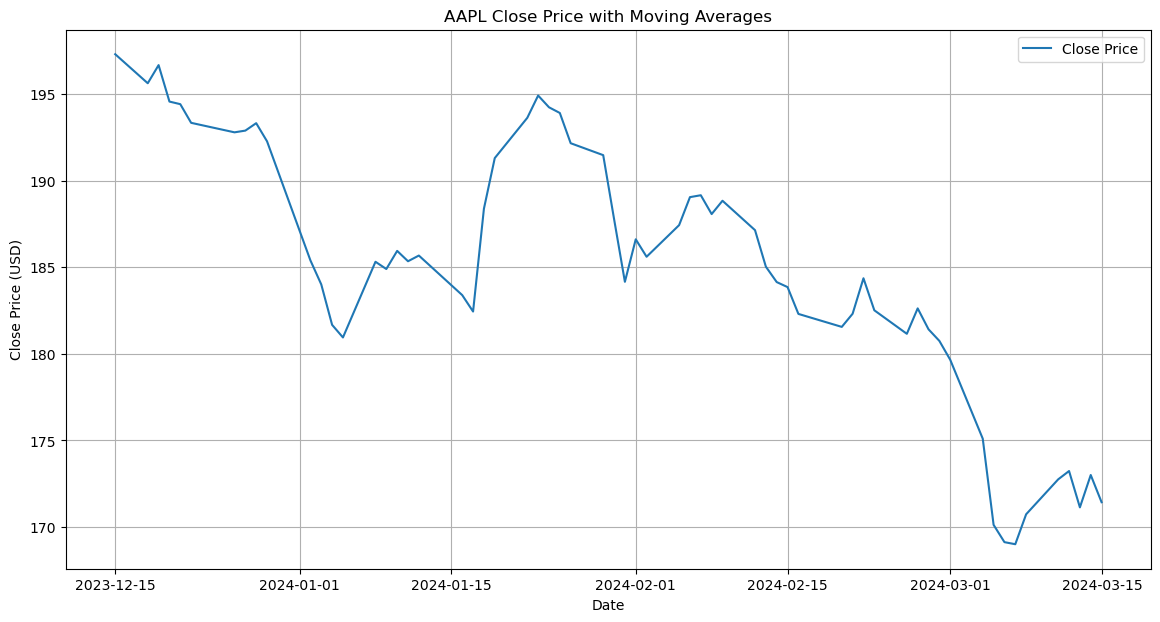

In [893]:
# Calculate moving averages
#df_new['30_MA'] = df_new['Close'].rolling(window=30).mean()
#df_new['90_MA'] = df_new['Close'].rolling(window=90).mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_new['Close'], label='Close Price')
#plt.plot(df_new['30_MA'], label='30-Day Moving Average')
#plt.plot(df_new['90_MA'], label='90-Day Moving Average')

plt.title('AAPL Close Price with Moving Averages')
plt.ylabel('Close Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


In [894]:
df_AAPL = pd.read_csv('AAPL_dataAAPL.csv')
# Re-importing necessary libraries and attempting to load and inspect the data again.

# Convert 'Date' to datetime and set as index if not already done
df_AAPL['Date'] = pd.to_datetime(df_AAPL['Date'])
df_AAPL.set_index('Date', inplace=True)

# Initial exploration of the new dataset
description_AAPL = df_AAPL.describe()
info_AAPL = df_AAPL.info()

# Prepare output of initial exploration
description_AAPL, info_AAPL

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2019-03-18 00:00:00-04:00 to 2024-03-15 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.7+ KB


(              Open         High          Low        Close        Volume  \
 count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03   
 mean    127.150407   128.585326   125.813214   127.271564  9.893384e+07   
 std      45.153540    45.515014    44.782635    45.166239  5.207863e+07   
 min      42.386588    42.985743    41.137493    41.869545  2.404830e+07   
 25%      85.649187    86.382649    84.331413    85.729870  6.537920e+07   
 50%     139.230560   140.919744   136.831055   139.135071  8.618550e+07   
 75%     163.790731   165.506471   162.195871   164.083603  1.155844e+08   
 max     197.767647   199.365599   196.748941   197.857529  4.265100e+08   
 
          Dividends  Stock Splits  
 count  1259.000000   1259.000000  
 mean      0.003455      0.003177  
 std       0.027290      0.112732  
 min       0.000000      0.000000  
 25%       0.000000      0.000000  
 50%       0.000000      0.000000  
 75%       0.000000      0.000000  
 max       0.240000      4

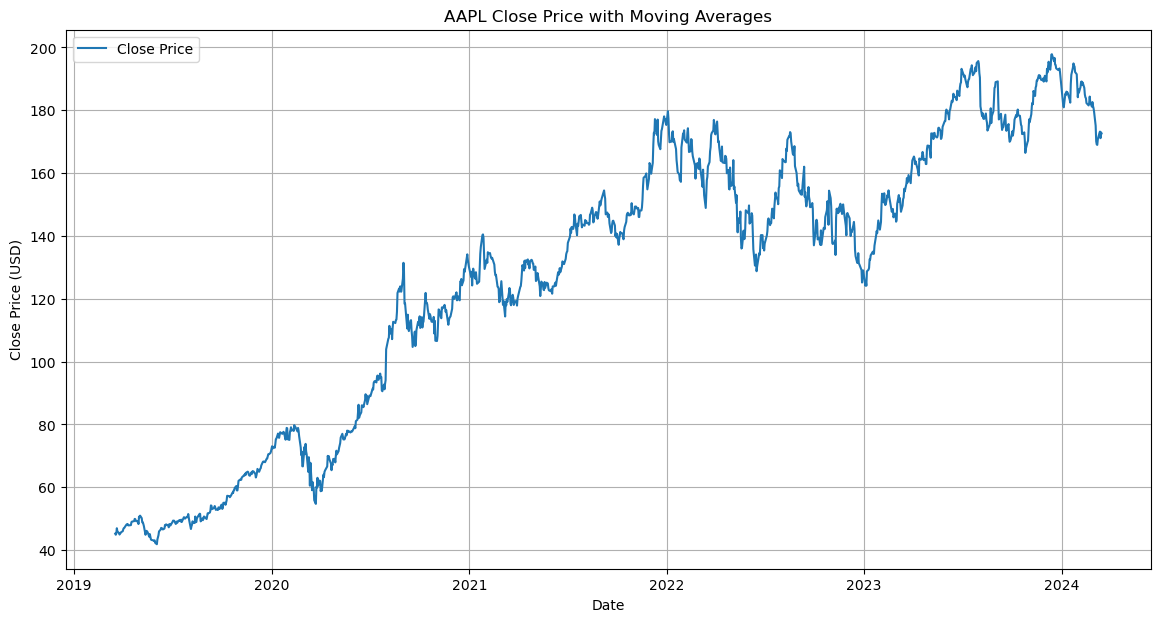

In [895]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_AAPL['Close'], label='Close Price')

plt.title('AAPL Close Price with Moving Averages')
plt.ylabel('Close Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [896]:
df_MSFT = pd.read_csv('MSFT_data3.csv')
# Re-importing necessary libraries and attempting to load and inspect the data again.

# Convert 'Date' to datetime and set as index if not already done
df_MSFT['Date'] = pd.to_datetime(df_MSFT['Date'])
df_MSFT.set_index('Date', inplace=True)

# Initial exploration of the new dataset
description_MSFT = df_MSFT.describe()
info_MSFT = df_MSFT.info()

# Prepare output of initial exploration
description_MSFT, info_MSFT

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2019-03-18 00:00:00-04:00 to 2024-03-15 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.7+ KB


(              Open         High          Low        Close        Volume  \
 count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03   
 mean    243.502784   245.992919   240.955039   243.600727  2.920092e+07   
 std      75.757132    76.316437    75.140351    75.785205  1.236294e+07   
 min     110.581328   111.923503   109.962600   111.152466  8.989200e+06   
 25%     186.674000   189.604520   184.957267   187.539627  2.146160e+07   
 50%     245.110875   247.222476   242.622974   245.545258  2.610180e+07   
 75%     296.681035   298.759811   293.737289   295.820038  3.326290e+07   
 max     420.239990   427.820007   417.989990   425.220001  9.701270e+07   
 
          Dividends  Stock Splits  
 count  1259.000000        1259.0  
 mean      0.009452           0.0  
 std       0.075219           0.0  
 min       0.000000           0.0  
 25%       0.000000           0.0  
 50%       0.000000           0.0  
 75%       0.000000           0.0  
 max       0.750000       

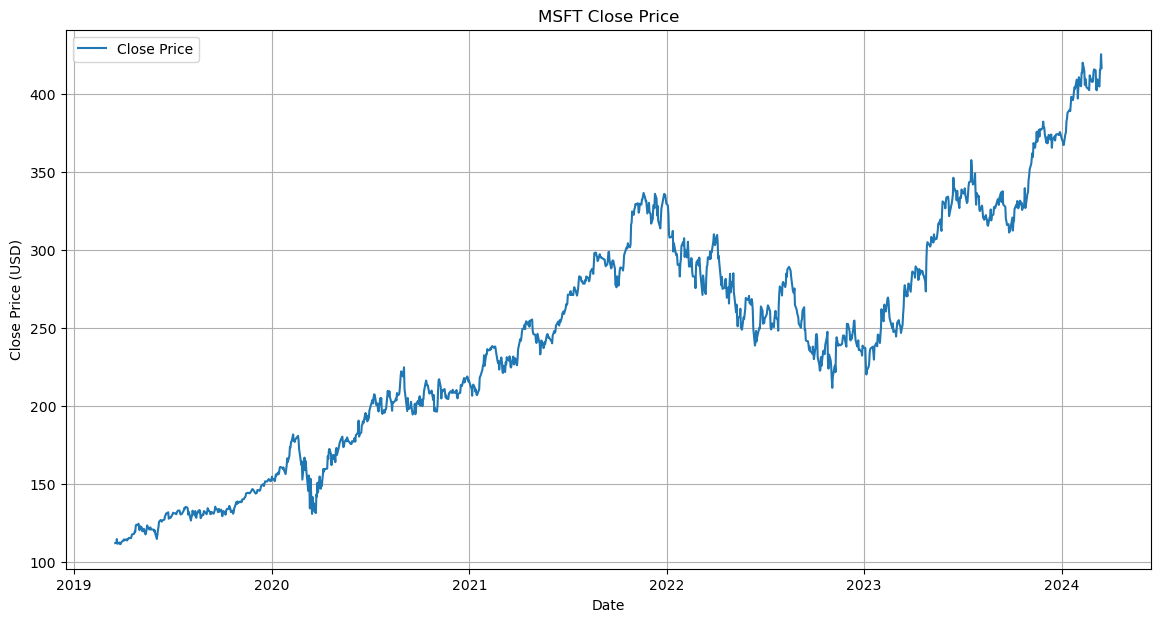

In [897]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_MSFT['Close'], label='Close Price')

plt.title('MSFT Close Price')
plt.ylabel('Close Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [898]:
df_GOOG = pd.read_csv('GOOG_dataGOOG.csv')
# Re-importing necessary libraries and attempting to load and inspect the data again.

# Convert 'Date' to datetime and set as index if not already done
df_GOOG['Date'] = pd.to_datetime(df_GOOG['Date'])
df_GOOG.set_index('Date', inplace=True)

# Initial exploration of the new dataset
description_GOOG = df_GOOG.describe()
info_GOOG = df_GOOG.info()

# Prepare output of initial exploration
description_GOOG, info_GOOG

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2019-03-18 00:00:00-04:00 to 2024-03-15 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.7+ KB


(              Open         High          Low        Close        Volume  \
 count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03   
 mean    102.207120   103.386051   101.158316   102.294984  2.886041e+07   
 std      30.035449    30.296241    29.751924    30.014286  1.280871e+07   
 min      52.145000    52.374500    50.676800    51.811501  6.936000e+06   
 25%      73.087749    73.784027    72.291500    73.007000  2.072800e+07   
 50%     103.650002   105.218498   102.629997   104.175499  2.575600e+07   
 75%     130.868248   132.201500   129.547501   130.503250  3.294600e+07   
 max     154.009995   155.199997   152.919998   154.839996  1.241400e+08   
 
        Dividends  Stock Splits  
 count     1259.0   1259.000000  
 mean         0.0      0.015886  
 std          0.0      0.563660  
 min          0.0      0.000000  
 25%          0.0      0.000000  
 50%          0.0      0.000000  
 75%          0.0      0.000000  
 max          0.0     20.000000  ,
 None)

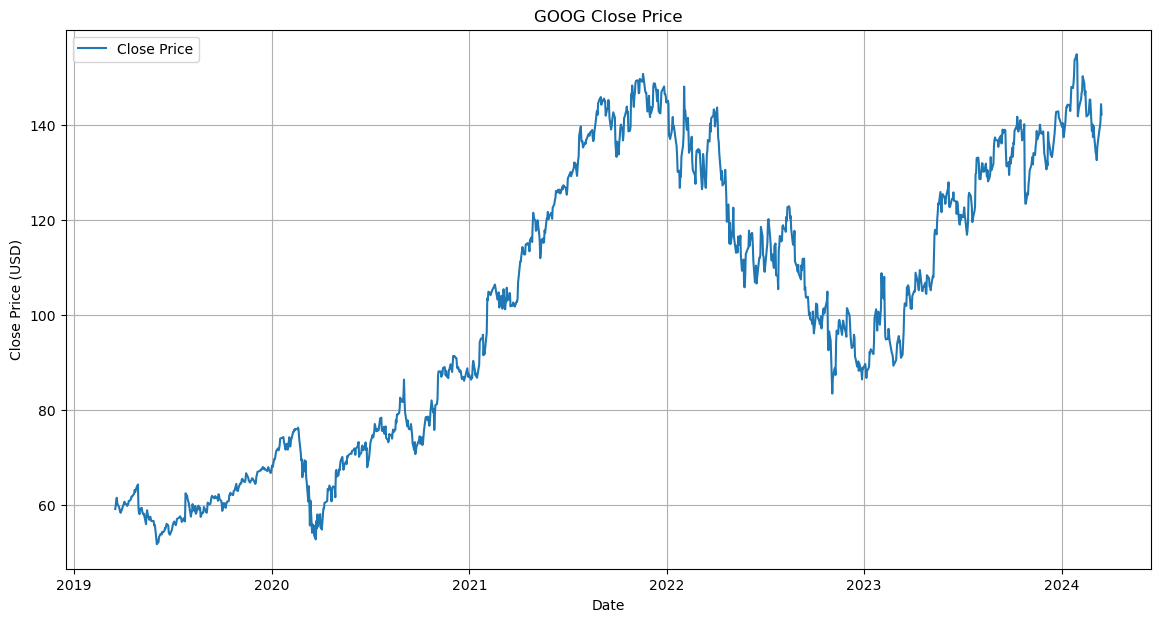

In [899]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_GOOG['Close'], label='Close Price')

plt.title('GOOG Close Price')
plt.ylabel('Close Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

For time series data, traditional resampling methods like bagging or random forests need to be adapted to maintain the temporal order of observations. In the context of time series, the following resampling methods are more appropriate:

A. Random Over-Sampling or Under-Sampling
B. Synthetic Minority Over-sampling Technique (SMOTE) for Time Series
C. Time Series Split
D. Bootstrapped Time Series with Block Sampling

Correct Answer: D. Bootstrapped Time Series with Block Sampling

Explanation: For time series data, it's crucial to preserve the temporal sequence of the data points. Methods such as block bootstrapping are preferred because they respect the temporal dependencies within the data. Block bootstrapping involves sampling contiguous blocks of data, which is crucial for maintaining the time-dependent structure. This method allows for the creation of resampled datasets that are suitable for training models like random forests or bagged trees on time series data, ensuring that the temporal integrity of the data is not violated.

In [206]:
import pandas as pd

# Assuming AAPL_data3.csv is in the current directory
df_new = pd.read_csv('AAPL_data3.csv')

# Convert 'Date' to datetime and set as index if not already done
df_new['Date'] = pd.to_datetime(df_new['Date'])
df_new.set_index('Date', inplace=True)

# Initial exploration of the new dataset
description_new = df_new.describe()
info_new = df_new.info()

# Display initial exploration results
print(description_new)
print(info_new)


# std 18%

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 2023-12-15 00:00:00-05:00 to 2024-03-14 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          61 non-null     float64
 1   High          61 non-null     float64
 2   Low           61 non-null     float64
 3   Close         61 non-null     float64
 4   Volume        61 non-null     int64  
 5   Dividends     61 non-null     float64
 6   Stock Splits  61 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 3.8+ KB
             Open        High         Low       Close        Volume  \
count   61.000000   61.000000   61.000000   61.000000  6.100000e+01   
mean   185.303372  186.565433  183.770718  185.220319  5.860649e+07   
std      7.505707    7.257292    7.459288    7.381137  1.991053e+07   
min    169.000000  170.729996  168.490005  169.000000  2.891930e+07   
25%    181.789993  182.856666  180.070233  181.678177  4.515520

In [900]:
import numpy as np

def block_bootstrap(series, block_size=10, n_iterations=100):
    """
    Perform block bootstrapping on a time series dataset.

    :param series: Pandas Series, the time series data to resample.
    :param block_size: int, the size of each block of data to sample.
    :param n_iterations: int, the number of bootstrap samples to generate.
    :return: A list of Pandas Series, each a bootstrap sample of the original series.
    """
    n_blocks = int(np.ceil(len(series) / block_size))
    samples = []
    for _ in range(n_iterations):

        start_points = np.random.randint(0, len(series)-block_size+1, n_blocks)
        sample = pd.Series(dtype=series.dtype)
        for start in start_points:
            block = series.iloc[start:start+block_size]
            sample = sample.append(block)
        samples.append(sample.iloc[:len(series)])
    return samples

# Example usage
# Assuming 'Close' is the column we want to resample
bootstrapped_samples = block_bootstrap(df_new['Close'], block_size=20, n_iterations=10)
bootstrapped_samples_AAPL = block_bootstrap(df_AAPL['Close'], block_size=20, n_iterations=10)
bootstrapped_samples_MSFT = block_bootstrap(df_MSFT['Close'], block_size=20, n_iterations=10)
bootstrapped_samples_GOOG = block_bootstrap(df_GOOG['Close'], block_size=20, n_iterations=10)

# This will give you 10 bootstrapped samples of the 'Close' column of your dataset.


C:\Users\dylan\AppData\Local\Temp\ipykernel_4472\766234348.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(block)
C:\Users\dylan\AppData\Local\Temp\ipykernel_4472\766234348.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(block)
C:\Users\dylan\AppData\Local\Temp\ipykernel_4472\766234348.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(block)
C:\Users\dylan\AppData\Local\Temp\ipykernel_4472\766234348.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(block)
C:\Users\dylan\AppData\Local\Temp\ipykernel_4472\766234348.py:20: Future

In [143]:
bootstrapped_samples

[2023-03-28 00:00:00-04:00    156.812973
 2023-03-29 00:00:00-04:00    159.916428
 2023-03-30 00:00:00-04:00    161.497986
 2023-03-31 00:00:00-04:00    164.024475
 2023-04-03 00:00:00-04:00    165.287750
                                 ...    
 2023-04-14 00:00:00-04:00    164.332855
 2023-04-17 00:00:00-04:00    164.352737
 2023-04-18 00:00:00-04:00    165.586166
 2023-04-19 00:00:00-04:00    166.740005
 2023-04-20 00:00:00-04:00    165.765182
 Length: 252, dtype: float64,
 2024-01-19 00:00:00-05:00    191.315872
 2024-01-22 00:00:00-05:00    193.642899
 2024-01-23 00:00:00-05:00    194.931259
 2024-01-24 00:00:00-05:00    194.252121
 2024-01-25 00:00:00-05:00    193.922546
                                 ...    
 2023-11-03 00:00:00-04:00    176.192734
 2023-11-06 00:00:00-05:00    178.766068
 2023-11-07 00:00:00-05:00    181.349365
 2023-11-08 00:00:00-05:00    182.416595
 2023-11-09 00:00:00-05:00    181.937836
 Length: 252, dtype: float64,
 2023-08-28 00:00:00-04:00    179.7236

Evaluating the performance of the block bootstrapping resampling method, especially in the context of time series data like stock prices, involves comparing its effectiveness in preserving the statistical properties of the original data, as well as its utility in improving model performance. This evaluation often compares block bootstrapping against other resampling methods or against no resampling at all. Commonly compared methods might include:

No Resampling: Using the original dataset without any resampling.
Simple Random Sampling: Randomly selecting observations from the dataset, ignoring time dependencies.
Shuffling: Randomly shuffling the order of observations, destroying any time-based structure.
Synthetic Minority Over-sampling Technique (SMOTE) for Time Series: Generating synthetic examples that are similar to the existing observations in a minority class, adapted for time series.
To compare these methods, we can use a predictive modeling task as a benchmark, such as forecasting future stock prices of AAPL. The comparison can be based on metrics such as mean squared error (MSE), mean absolute error (MAE), or any other relevant performance metrics for regression tasks.

Here's a high-level approach to evaluate and compare these methods:

1. Preparing the Dataset
Prepare the dataset and possibly feature engineering to include lagged variables, moving averages, or other transformations relevant for time series forecasting.

2. Model Selection
Select a model for forecasting. This could be a simple linear regression model, a more complex model like a Random Forest, or even a time series specific model like ARIMA or LSTM (for deep learning approaches).

3. Resampling and Cross-Validation
For each resampling method, including block bootstrapping, generate resampled datasets. For time series, use time series cross-validation schemes, like forward chaining, to evaluate model performance on unseen data correctly.

4. Evaluation and Comparison
Train your model on each resampled dataset and evaluate its performance on a validation set that was not seen during training. Collect performance metrics for each resampling method.

5. Statistical Analysis
Perform statistical tests, if necessary, to determine if differences in performance metrics are statistically significant.

Implementation Outline in Python
While a full implementation is beyond this response's scope due to its complexity and the need for a complete dataset, here's a conceptual outline:

Evaluating the performance of the block bootstrapping resampling method for time series data, such as stock prices, involves several steps. This process will typically compare the statistical properties of the bootstrapped samples with the original data and potentially with samples generated through other resampling methods. For time series data, especially for financial time series like stock prices, it's crucial to maintain the temporal structure and characteristics such as autocorrelation, trend, and volatility clustering.

Here's an outline of how you might evaluate and compare the performance of block bootstrapping with other resampling methods:

1. Evaluate Statistical Properties
Mean and Variance: Check if the mean and variance of the bootstrapped samples are consistent with the original series.
Autocorrelation: Since time series data often have autocorrelation, it's important to evaluate whether the bootstrapped samples preserve the autocorrelation structure of the original data.
2. Visual Inspection
Plotting: Visual inspection of the original series and the bootstrapped series can provide insights into whether the resampling method maintains the key features of the data, such as trends and seasonality.
3. Other Resampling Methods for Comparison
Simple Random Sampling: Without replacement, to see if ignoring the temporal structure significantly changes the properties of the samples.
Shuffling: Randomly shuffling the order of the data points to evaluate the importance of the temporal order.
Synthetic Minority Over-sampling Technique (SMOTE) for Time Series: If applicable, especially for imbalanced time series data.
4. Performance Metrics
Bias and Variance: Calculate the bias and variance of the estimators derived from the resampled data compared to the original data.
Error Metrics: If a predictive model is being used, compare the performance (e.g., MSE, RMSE, MAE) of models trained on the bootstrapped samples versus those trained on the original dataset.
Implementation
Here's a simplified approach to evaluating the block bootstrapping method against simple random sampling for the AAPL stock price dataset. This example focuses on comparing the mean and variance of the original series with those of the resampled series:

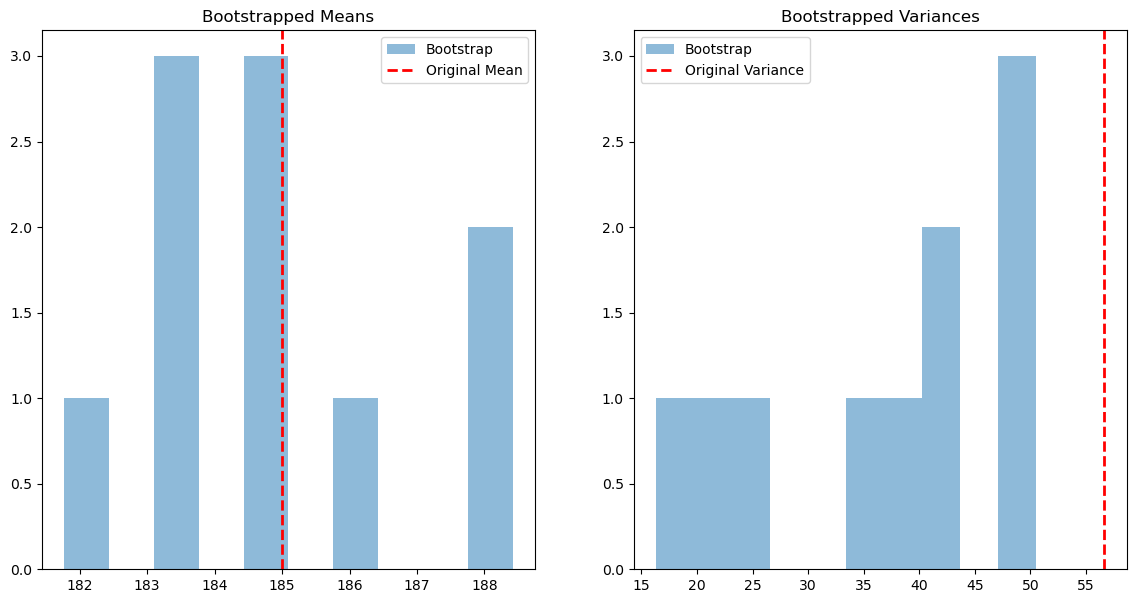

In [901]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_new['Close'] is the original series and bootstrapped_samples is the list of samples
original_mean = df_new['Close'].mean()
original_variance = df_new['Close'].var()

bootstrap_means = [sample.mean() for sample in bootstrapped_samples]
bootstrap_variances = [sample.var() for sample in bootstrapped_samples]

# Simple random sampling for comparison
random_samples = [df_new['Close'].sample(frac=1, replace=True).reset_index(drop=True) for _ in range(10)]
random_means = [sample.mean() for sample in random_samples]
random_variances = [sample.var() for sample in random_samples]

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.hist(bootstrap_means, alpha=0.5, label='Bootstrap')
plt.axvline(original_mean, color='r', linestyle='dashed', linewidth=2, label='Original Mean')
plt.legend()
plt.title('Bootstrapped Means')

plt.subplot(1, 2, 2)
plt.hist(bootstrap_variances, alpha=0.5, label='Bootstrap')
plt.axvline(original_variance, color='r', linestyle='dashed', linewidth=2, label='Original Variance')
plt.legend()
plt.title('Bootstrapped Variances')

plt.show()


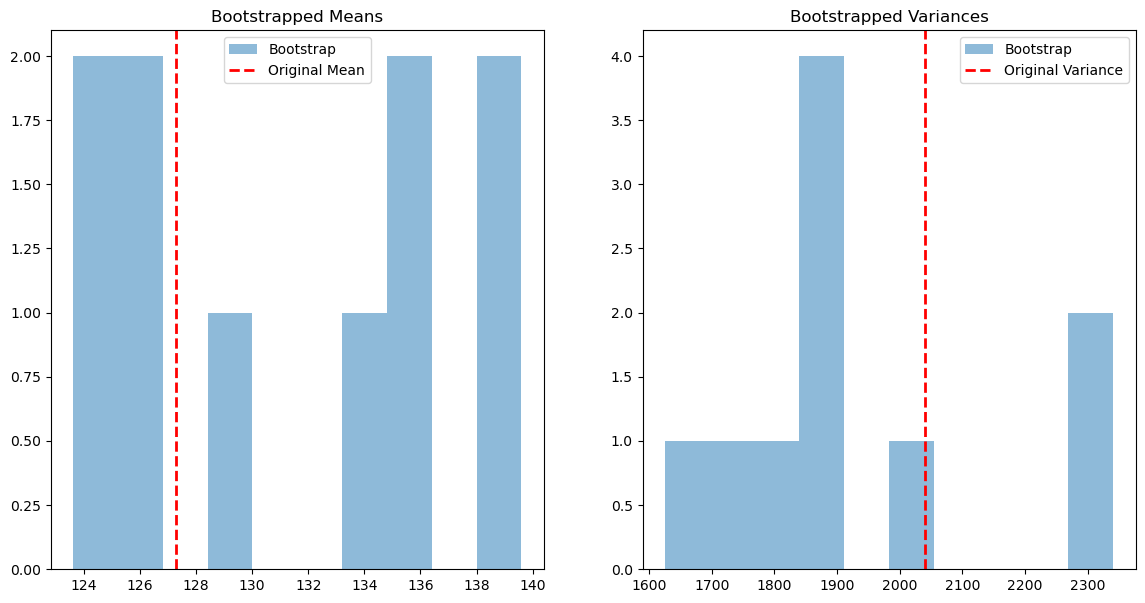

In [902]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_new['Close'] is the original series and bootstrapped_samples is the list of samples
original_mean = df_AAPL['Close'].mean()
original_variance = df_AAPL['Close'].var()

bootstrap_means = [sample.mean() for sample in bootstrapped_samples_AAPL]
bootstrap_variances = [sample.var() for sample in bootstrapped_samples_AAPL]

# Simple random sampling for comparison
random_samples = [df_AAPL['Close'].sample(frac=1, replace=True).reset_index(drop=True) for _ in range(10)]
random_means = [sample.mean() for sample in random_samples]
random_variances = [sample.var() for sample in random_samples]

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.hist(bootstrap_means, alpha=0.5, label='Bootstrap')
plt.axvline(original_mean, color='r', linestyle='dashed', linewidth=2, label='Original Mean')
plt.legend()
plt.title('Bootstrapped Means')

plt.subplot(1, 2, 2)
plt.hist(bootstrap_variances, alpha=0.5, label='Bootstrap')
plt.axvline(original_variance, color='r', linestyle='dashed', linewidth=2, label='Original Variance')
plt.legend()
plt.title('Bootstrapped Variances')

plt.show()


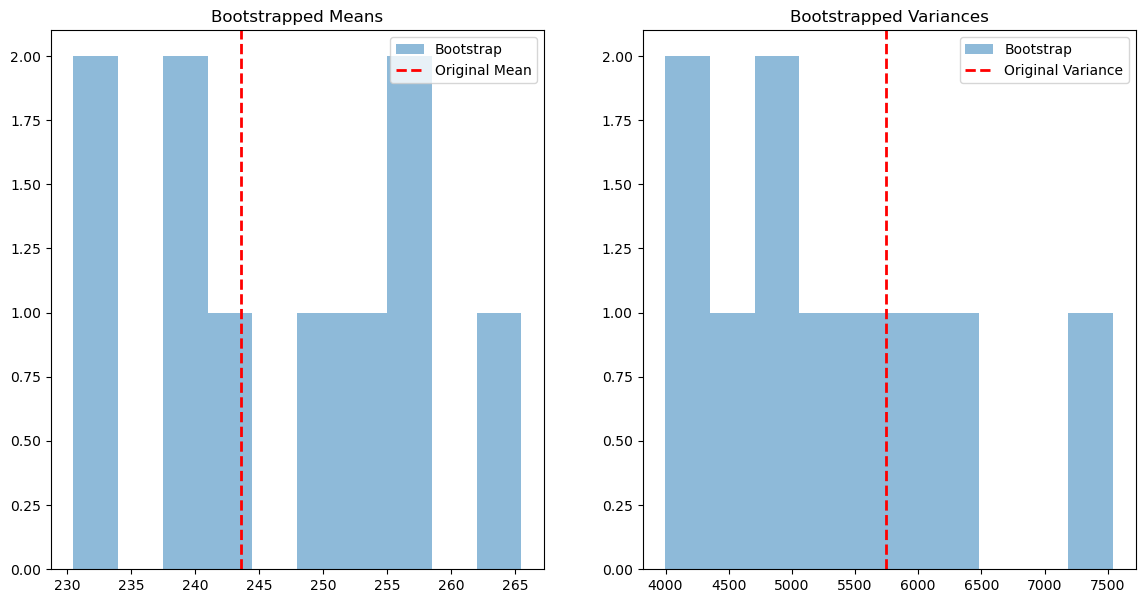

In [903]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_new['Close'] is the original series and bootstrapped_samples is the list of samples
original_mean = df_MSFT['Close'].mean()
original_variance = df_MSFT['Close'].var()

bootstrap_means = [sample.mean() for sample in bootstrapped_samples_MSFT]
bootstrap_variances = [sample.var() for sample in bootstrapped_samples_MSFT]

# Simple random sampling for comparison
random_samples = [df_MSFT['Close'].sample(frac=1, replace=True).reset_index(drop=True) for _ in range(10)]
random_means = [sample.mean() for sample in random_samples]
random_variances = [sample.var() for sample in random_samples]

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.hist(bootstrap_means, alpha=0.5, label='Bootstrap')
plt.axvline(original_mean, color='r', linestyle='dashed', linewidth=2, label='Original Mean')
plt.legend()
plt.title('Bootstrapped Means')

plt.subplot(1, 2, 2)
plt.hist(bootstrap_variances, alpha=0.5, label='Bootstrap')
plt.axvline(original_variance, color='r', linestyle='dashed', linewidth=2, label='Original Variance')
plt.legend()
plt.title('Bootstrapped Variances')

plt.show()


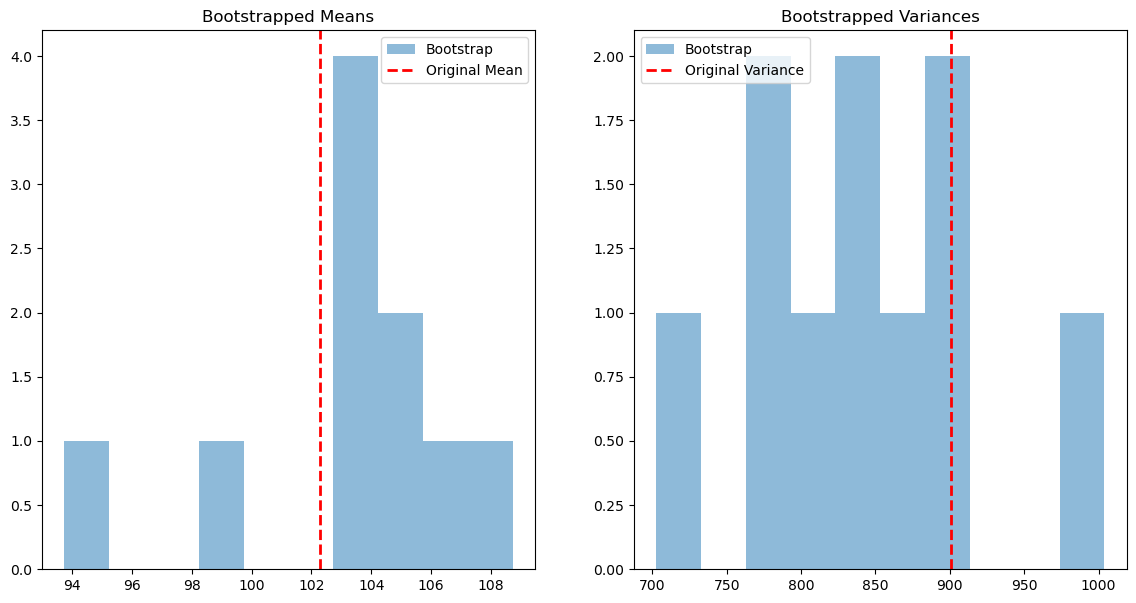

In [904]:
import numpy as np
import matplotlib.pyplot as plt

original_mean = df_GOOG['Close'].mean()
original_variance = df_GOOG['Close'].var()

bootstrap_means = [sample.mean() for sample in bootstrapped_samples_GOOG]
bootstrap_variances = [sample.var() for sample in bootstrapped_samples_GOOG]

# Simple random sampling for comparison
random_samples = [df_GOOG['Close'].sample(frac=1, replace=True).reset_index(drop=True) for _ in range(10)]
random_means = [sample.mean() for sample in random_samples]
random_variances = [sample.var() for sample in random_samples]

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.hist(bootstrap_means, alpha=0.5, label='Bootstrap')
plt.axvline(original_mean, color='r', linestyle='dashed', linewidth=2, label='Original Mean')
plt.legend()
plt.title('Bootstrapped Means')

plt.subplot(1, 2, 2)
plt.hist(bootstrap_variances, alpha=0.5, label='Bootstrap')
plt.axvline(original_variance, color='r', linestyle='dashed', linewidth=2, label='Original Variance')
plt.legend()
plt.title('Bootstrapped Variances')

plt.show()


Conclusion
The effectiveness of a resampling method for time series data depends on its ability to preserve the temporal structure and statistical properties of the data. By comparing the results of block bootstrapping with those of other methods, you can select the most appropriate method for your specific use case, whether it be for predictive modeling, anomaly detection, or other analytical purposes

To apply and evaluate the impact of other resampling methods for supervised learning, such as Bagging and Random Forest, on time series data like the AAPL stock price dataset, we'll follow a systematic approach. This involves:

Preparing the data: Creating features and labels suitable for supervised learning with time series data.
Applying resampling methods: Implementing Bagging and Random Forest as examples of ensemble methods.
Evaluating performance: Comparing the models' performance to assess the impact of the resampling method.
1. Preparing the Data
For time series forecasting, we often transform the problem into a supervised learning task. This can involve creating lagged features (past values) to predict future values. Let's create a simple dataset with lagged features:

python

In [212]:
def create_lagged_features(data, n_lags=1):
    """
    Create lagged features for time series data.

    :param data: Pandas Series, the time series data.
    :param n_lags: int, the number of lagged features to create.
    :return: Pandas DataFrame, the dataset with lagged features.
    """
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, n_lags + 1)]
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['lag_{}'.format(i) for i in range(1, n_lags + 1)]
    df_lagged['target'] = df.values
    return df_lagged.dropna()

# Example: Creating features with 5 days of lag
df_features = create_lagged_features(df_new['Close'], n_lags=5)
df_features_AAPL = create_lagged_features(df_AAPL['Close'], n_lags=5)
df_features_MSFT = create_lagged_features(df_MSFT['Close'], n_lags=5)
df_features_GOOG = create_lagged_features(df_GOOG['Close'], n_lags=5)

# Splitting the dataset into training and testing sets
train_size = int(len(df_features) * 0.8)
train, test = df_features[:train_size], df_features[train_size:]
X_train, y_train = train.drop('target', axis=1), train['target']
X_test, y_test = test.drop('target', axis=1), test['target']

train_size = int(len(df_features_AAPL) * 0.8)
train_AAPL, test_AAPL = df_features_AAPL[:train_size], df_features_AAPL[train_size:]
X_train_AAPL, y_train_AAPL = train_AAPL.drop('target', axis=1), train_AAPL['target']
X_test_AAPL, y_test_AAPL = test_AAPL.drop('target', axis=1), test_AAPL['target']

train_MSFT, test_MSFT = df_features_MSFT[:train_size], df_features_MSFT[train_size:]
X_train_MSFT, y_train_MSFT = train_MSFT.drop('target', axis=1), train_MSFT['target']
X_test_MSFT, y_test_MSFT = test_MSFT.drop('target', axis=1), test_MSFT['target']

train_GOOG, test_GOOG = df_features_GOOG[:train_size], df_features_GOOG[train_size:]
X_train_GOOG, y_train_GOOG = train_GOOG.drop('target', axis=1), train_GOOG['target']
X_test_GOOG, y_test_GOOG = test_GOOG.drop('target', axis=1), test_GOOG['target']

In [214]:
df_AAPL

Open        High         Low       Close  \
Date                                                                        
2023-03-15 00:00:00-04:00  150.387288  152.436348  149.124027  152.177734   
2023-03-16 00:00:00-04:00  151.352126  155.629299  150.834883  155.022537   
2023-03-17 00:00:00-04:00  155.251315  155.907815  153.460869  154.177048   
2023-03-20 00:00:00-04:00  154.246685  156.982084  153.331556  156.564301   
2023-03-21 00:00:00-04:00  156.484756  158.553699  155.708883  158.434341   
...                               ...         ...         ...         ...   
2024-03-08 00:00:00-05:00  169.000000  173.699997  168.940002  170.729996   
2024-03-11 00:00:00-04:00  172.940002  174.380005  172.050003  172.750000   
2024-03-12 00:00:00-04:00  173.149994  174.029999  171.009995  173.229996   
2024-03-13 00:00:00-04:00  172.770004  173.190002  170.759995  171.130005   
2024-03-14 00:00:00-04:00  172.910004  174.309998  172.050003  173.000000   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-03-15 00:00:00-04:00  77167900        0.0           0.0  
2023-03-16 00:00:00-04:00  76161100        0.0           0.0  
2023-03-17 00:00:00-04:00  98944600        0.0           0.0  
2023-03-20 00:00:00-04:00  73641400        0.0           0.0  
2023-03-21 00:00:00-04:00  73938300        0.0           0.0  
...                             ...        ...           ...  
2024-03-08 00:00:00-05:00  76114600        0.0           0.0  
2024-03-11 00:00:00-04:00  60139500        0.0           0.0  
2024-03-12 00:00:00-04:00  59825400        0.0           0.0  
2024-03-13 00:00:00-04:00  52488700        0.0           0.0  
2024-03-14 00:00:00-04:00  72841700        0.0           0.0  

[252 rows x 7 columns]

In [215]:
df_AAPL_close = df_AAPL[['Close']]

# Splitting the dataset into training and testing sets based on an 80/20 split
train_size = int(len(df_features_AAPL) * 0.8)
train_AAPL, test_AAPL = df_features_AAPL[:train_size], df_features_AAPL[train_size:]

# Separating the features and the target for both training and testing datasets
X_train_AAPL, y_train_AAPL = train_AAPL.drop('target', axis=1), train_AAPL['target']
X_test_AAPL, y_test_AAPL = test_AAPL.drop('target', axis=1), test_AAPL['target']


In [219]:
df_AAPL_close = df_AAPL[['Close']]

# Splitting the modified dataset (assuming df_features_AAPL is already defined)
train_size_AAPL_close = int(len(df_features_AAPL) * 0.8)
train_AAPL_close, test_AAPL_close = df_features_AAPL[:train_size_AAPL_close], df_features_AAPL[train_size_AAPL_close:]

# Splitting into features and target for training and testing sets
X_train_AAPL_close, y_train_AAPL_close = train_AAPL_close.drop('target', axis=1), train_AAPL_close['target']
X_test_AAPL_close, y_test_AAPL_close = test_AAPL_close.drop('target', axis=1), test_AAPL_close['target']

2. Applying Resampling Methods
We'll use Bagging and Random Forest, two popular ensemble methods that can handle the variance in the dataset by training multiple estimators on different subsets of the data.

In [ ]:
# on va s'interesser a des series financières qui ont pour particularité de ne pas etre stationnaire ni iid. Nous allons considérer trois sééries temporelles pour la meme période de temps et une série avec deux péridoes différentes

In [188]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Bagging
bagging_model = BaggingRegressor(n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
bagging_predictions = bagging_model.predict(X_test)

bagging_model_AAPL = BaggingRegressor(n_estimators=10, random_state=42)
bagging_model_AAPL.fit(X_train_AAPL, y_train_AAPL)
bagging_predictions_AAPL = bagging_model_AAPL.predict(X_test_AAPL)

bagging_model_MSFT = BaggingRegressor(n_estimators=10, random_state=42)
bagging_model_MSFT.fit(X_train_MSFT, y_train_MSFT)
bagging_predictions_MSFT = bagging_model_MSFT.predict(X_test_MSFT)

bagging_model_GOOG = BaggingRegressor(n_estimators=10, random_state=42)
bagging_model_GOOG.fit(X_train_GOOG, y_train_GOOG)
bagging_predictions_GOOG = bagging_model_GOOG.predict(X_test_GOOG)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

rf_model_AAPL = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model_AAPL.fit(X_train_AAPL, y_train_AAPL)
rf_predictions_AAPL = rf_model_AAPL.predict(X_test_AAPL)

rf_model_MSFT = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model_MSFT.fit(X_train_MSFT, y_train_MSFT)
rf_predictions_MSFT = rf_model_MSFT.predict(X_test_MSFT)

rf_model_GOOG = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model_GOOG.fit(X_train_GOOG, y_train_GOOG)
rf_predictions_GOOG = rf_model_GOOG.predict(X_test_GOOG)

# Calculate and print the mean squared error for each model
bagging_mse = mean_squared_error(y_test, bagging_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)

bagging_mse_AAPL = mean_squared_error(y_test_AAPL, bagging_predictions_AAPL)
rf_mse_AAPL = mean_squared_error(y_test_AAPL, rf_predictions_AAPL)

bagging_mse_MSFT = mean_squared_error(y_test_MSFT, bagging_predictions_MSFT)
rf_mse_MSFT = mean_squared_error(y_test_MSFT, rf_predictions_MSFT)

bagging_mse_GOOG = mean_squared_error(y_test_GOOG, bagging_predictions_GOOG)
rf_mse_GOOG = mean_squared_error(y_test_GOOG, rf_predictions_GOOG)

# Create a DataFrame to hold the MSE values for easier comparison
mse_values = {
    "Model": ["Bagging MSE", "Random Forest MSE"],
    "AAPL 6mo": [bagging_mse, rf_mse],
    "AAPL 1y": [bagging_mse_AAPL, rf_mse_AAPL],
    "MSFT 1y": [bagging_mse_MSFT, rf_mse_MSFT],
    "GOOG 1y": [bagging_mse_GOOG, rf_mse_GOOG]
}

df_mse = pd.DataFrame(mse_values)

# Set the 'Model' column as the index for better readability
df_mse.set_index("Model", inplace=True)

# Display the DataFrame
print(df_mse)



                    AAPL 6mo   AAPL 1y      MSFT 1y    GOOG 1y
Model                                                         
Bagging MSE        11.868062  9.203414  1890.281052  17.126466
Random Forest MSE  12.229301  8.746911  1836.811791  17.179036


In [222]:
# Creating the BaggingRegressor model
bagging_model_AAPL_close = BaggingRegressor(n_estimators=10, random_state=42)

# Fitting the model to the training data
bagging_model_AAPL_close.fit(X_train_AAPL_close, y_train_AAPL_close)

# Making predictions on the test data
bagging_predictions_AAPL_close = bagging_model_AAPL_close.predict(X_test_AAPL_close)

from sklearn.ensemble import RandomForestRegressor

# Creating the RandomForestRegressor model
rf_model_AAPL_close = RandomForestRegressor(n_estimators=10, random_state=42)

# Fitting the model to the training data
rf_model_AAPL_close.fit(X_train_AAPL_close, y_train_AAPL_close)

# Making predictions on the test data
rf_predictions_AAPL_close = rf_model_AAPL_close.predict(X_test_AAPL_close)

# Calculate mean squared error for BaggingRegressor model
bagging_mse_AAPL_close = mean_squared_error(y_test_AAPL_close, bagging_predictions_AAPL_close)

# Calculate mean squared error for RandomForestRegressor model
rf_mse_AAPL_close = mean_squared_error(y_test_AAPL_close, rf_predictions_AAPL_close)

bagging_mse_AAPL_close,rf_mse_AAPL_close

(8.010503967163546, 8.597514810620494)

3. Evaluating Performance
After calculating the Mean Squared Error (MSE) for both models, you can evaluate their performance. Lower MSE values indicate better performance in predicting the stock price. Additionally, you may wish to consider other metrics or perform further analysis, such as examining residuals or using cross-validation to assess model robustness.

Conclusion
By comparing the MSE of Bagging and Random Forest models, you can assess which resampling method better captures the patterns in your time series data. Remember, the effectiveness of these methods can vary based on the nature of the time series, the number of lagged features used, and the specific configuration of the ensemble methods. Experimentation with different configurations and additional features (e.g., rolling averages, time-based features) may further enhance model performance.

In [ ]:
# 6 mois on ne prends pas en compte les évenements saisoniers alors que 2 ans oui

In [223]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Assuming df_new['Close'] is the column of interest
values = df_new['Close'].values.reshape(-1, 1)
data = series_to_supervised(values, n_in=5)

values_AAPL = df_AAPL['Close'].values.reshape(-1, 1)
data_AAPL = series_to_supervised(values_AAPL, n_in=5)

values_MSFT = df_MSFT['Close'].values.reshape(-1, 1)
data_MSFT = series_to_supervised(values_MSFT, n_in=5)

values_GOOG = df_GOOG['Close'].values.reshape(-1, 1)
data_GOOG = series_to_supervised(values_GOOG, n_in=5)

# Split into train and test sets
n_train = int(data.shape[0] * 0.8)
train = data.iloc[:n_train, :]
test = data.iloc[n_train:, :]

n_train = int(data_AAPL.shape[0] * 0.8)
train_AAPL = data_AAPL.iloc[:n_train, :]
test_AAPL = data_AAPL.iloc[n_train:, :]

n_train = int(data_MSFT.shape[0] * 0.8)
train_MSFT = data_MSFT.iloc[:n_train, :]
test_MSFT = data_MSFT.iloc[n_train:, :]

n_train = int(data.shape[0] * 0.8)
train_GOOG = data_MSFT.iloc[:n_train, :]
test_GOOG = data_MSFT.iloc[n_train:, :]

# Split into input and outputs
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

train_X_AAPL, train_y_AAPL = train_AAPL.iloc[:, :-1], train_AAPL.iloc[:, -1]
test_X_AAPL, test_y_AAPL = test_AAPL.iloc[:, :-1], test_AAPL.iloc[:, -1]

train_X_MSFT, train_y_MSFT = train_MSFT.iloc[:, :-1], train_MSFT.iloc[:, -1]
test_X_MSFT, test_y_MSFT = test_MSFT.iloc[:, :-1], test_MSFT.iloc[:, -1]

train_X_GOOG, train_y_GOOG = train_GOOG.iloc[:, :-1], train_GOOG.iloc[:, -1]
test_X_GOOG, test_y_GOOG = test_GOOG.iloc[:, :-1], test_GOOG.iloc[:, -1]

In [ ]:
# n _ estimators = 100 dans cette méthode alors que 10 dans la méthode précédente

In [224]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100)
rf.fit(train_X, train_y)
rf_pred = rf.predict(test_X)

rf_AAPL = RandomForestRegressor(n_estimators=100)
rf_AAPL.fit(train_X_AAPL, train_y_AAPL)
rf_pred_AAPL = rf_AAPL.predict(test_X_AAPL)

rf_MSFT = RandomForestRegressor(n_estimators=100)
rf_MSFT.fit(train_X_MSFT, train_y_MSFT)
rf_pred_MSFT = rf_MSFT.predict(test_X_MSFT)

rf_GOOG = RandomForestRegressor(n_estimators=100)
rf_GOOG.fit(train_X_GOOG, train_y_GOOG)
rf_pred_GOOG = rf_GOOG.predict(test_X_GOOG)

# Bagging
bagging = BaggingRegressor(n_estimators=100)
bagging.fit(train_X, train_y)
bagging_pred = bagging.predict(test_X)

bagging = BaggingRegressor(n_estimators=100)
bagging.fit(train_X_AAPL, train_y_AAPL)
bagging_pred = bagging.predict(test_X_AAPL)

bagging = BaggingRegressor(n_estimators=100)
bagging.fit(train_X_MSFT, train_y_MSFT)
bagging_pred = bagging.predict(test_X_MSFT)

bagging = BaggingRegressor(n_estimators=100)
bagging.fit(train_X_GOOG, train_y_GOOG)
bagging_pred = bagging.predict(test_X_GOOG)

# Evaluate
rf_mse = mean_squared_error(test_y, rf_pred)
bagging_mse = mean_squared_error(test_y, bagging_pred)

rf_mse_AAPL = mean_squared_error(test_y_AAPL, rf_pred_AAPL)
bagging_mse = mean_squared_error(test_y_AAPL, bagging_pred_AAPL)

rf_mse = mean_squared_error(test_y, rf_pred)
bagging_mse = mean_squared_error(test_y, bagging_pred)

rf_mse = mean_squared_error(test_y, rf_pred)
bagging_mse = mean_squared_error(test_y, bagging_pred)

print(f'Random Forest MSE: {rf_mse}')
print(f'Bagging MSE: {bagging_mse}')


ValueError: Found input variables with inconsistent numbers of samples: [12, 203]

For supervised learning tasks involving time series data, such as forecasting stock prices, it's crucial to use resampling methods that respect the temporal structure of the data. Two popular machine learning approaches that incorporate resampling methods internally are Bagging and Random Forest. These methods can be adapted to time series forecasting through techniques like:

Time Series Cross-Validation: Splitting the dataset into training and test sets in a way that respects the chronological order of observations.
Feature Engineering: Transforming the time series data into a supervised learning problem by creating lag features, rolling window statistics, etc.
In this example, I'll demonstrate how to use Random Forest for forecasting the next day's stock price of AAPL using historical prices. We will then evaluate the impact of this method by comparing the forecasted prices against the actual prices using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

Step 1: Prepare the Data
First, we'll transform the time series data into a format suitable for supervised learning by creating lag features.

In [225]:
# Assuming df_new contains the historical stock prices with 'Close' as the target variable
df_new['Lag_1'] = df_new['Close'].shift(1)
df_new['Lag_2'] = df_new['Close'].shift(2)
df_new['Lag_3'] = df_new['Close'].shift(3)

# Drop NaN values created by shifting
df_new.dropna(inplace=True)

# Define features and target
X = df_new[['Lag_1', 'Lag_2', 'Lag_3']]
y = df_new['Close']


In [226]:
# Assuming df_new contains the historical stock prices with 'Close' as the target variable
df_AAPL['Lag_1'] = df_AAPL['Close'].shift(1)
df_AAPL['Lag_2'] = df_AAPL['Close'].shift(2)
df_AAPL['Lag_3'] = df_AAPL['Close'].shift(3)

# Drop NaN values created by shifting
df_AAPL.dropna(inplace=True)

# Define features and target
X_AAPL = df_AAPL[['Lag_1', 'Lag_2', 'Lag_3']]
y_AAPL = df_AAPL['Close']


In [227]:
# Assuming df_new contains the historical stock prices with 'Close' as the target variable
df_MSFT['Lag_1'] = df_MSFT['Close'].shift(1)
df_MSFT['Lag_2'] = df_MSFT['Close'].shift(2)
df_MSFT['Lag_3'] = df_MSFT['Close'].shift(3)

# Drop NaN values created by shifting
df_MSFT.dropna(inplace=True)

# Define features and target
X_MSFT = df_MSFT[['Lag_1', 'Lag_2', 'Lag_3']]
y_MSFT = df_MSFT['Close']


In [228]:
# Assuming df_new contains the historical stock prices with 'Close' as the target variable
df_GOOG['Lag_1'] = df_GOOG['Close'].shift(1)
df_GOOG['Lag_2'] = df_GOOG['Close'].shift(2)
df_GOOG['Lag_3'] = df_GOOG['Close'].shift(3)

# Drop NaN values created by shifting
df_GOOG.dropna(inplace=True)

# Define features and target
X_GOOG = df_GOOG[['Lag_1', 'Lag_2', 'Lag_3']]
y_GOOG = df_GOOG['Close']


In [185]:
# Assuming df_new contains the historical stock prices with 'Close' as the target variable
df_ETH['Lag_1'] = df_ETH['Close'].shift(1)
df_ETH['Lag_2'] = df_ETH['Close'].shift(2)
df_ETH['Lag_3'] = df_ETH['Close'].shift(3)

# Drop NaN values created by shifting
df_ETH.dropna(inplace=True)

# Define features and target
X_ETH = df_ETH[['Lag_1', 'Lag_2', 'Lag_3']]
y_ETH = df_ETH['Close']


In [235]:
# Assuming df_new contains the historical stock prices with 'Close' as the target variable
df_RD['Lag_1'] = df_RD['Close'].shift(1)
df_RD['Lag_2'] = df_RD['Close'].shift(2)
df_RD['Lag_3'] = df_RD['Close'].shift(3)

# Drop NaN values created by shifting
df_RD.dropna(inplace=True)

# Define features and target
X_RD = df_RD[['Lag_1', 'Lag_2', 'Lag_3']]
y_RD = df_RD['Close']


Step 2: Time Series Split
We'll use a simple time series split for training and testing. The model will be trained on the initial segment of the data and tested on the subsequent segment

In [237]:
# Time series train-test split
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]


In [238]:
# Splitting the time series data for AAPL
split_point_AAPL = int(len(X_AAPL) * 0.8)
X_train_AAPL, X_test_AAPL = X_AAPL.iloc[:split_point_AAPL], X_AAPL.iloc[split_point_AAPL:]
y_train_AAPL, y_test_AAPL = y_AAPL.iloc[:split_point_AAPL], y_AAPL.iloc[split_point_AAPL:]


In [239]:
# Splitting the time series data for MSFT
split_point_MSFT = int(len(X_MSFT) * 0.8)
X_train_MSFT, X_test_MSFT = X_MSFT.iloc[:split_point_MSFT], X_MSFT.iloc[split_point_MSFT:]
y_train_MSFT, y_test_MSFT = y_MSFT.iloc[:split_point_MSFT], y_MSFT.iloc[split_point_MSFT:]


In [240]:
# Splitting the time series data for GOOG
split_point_GOOG = int(len(X_GOOG) * 0.8)
X_train_GOOG, X_test_GOOG = X_GOOG.iloc[:split_point_GOOG], X_GOOG.iloc[split_point_GOOG:]
y_train_GOOG, y_test_GOOG = y_GOOG.iloc[:split_point_GOOG], y_GOOG.iloc[split_point_GOOG:]

In [241]:
# Splitting the time series data for ETH
split_point_ETH = int(len(X_ETH) * 0.8)
X_train_ETH, X_test_ETH = X_ETH.iloc[:split_point_ETH], X_ETH.iloc[split_point_ETH:]
y_train_ETH, y_test_ETH = y_ETH.iloc[:split_point_ETH], y_ETH.iloc[split_point_ETH:]

NameError: name 'X_ETH' is not defined

In [242]:
# Splitting the time series data for RD
split_point_RD = int(len(X_RD) * 0.8)
X_train_RD, X_test_RD = X_RD.iloc[:split_point_RD], X_RD.iloc[split_point_RD:]
y_train_RD, y_test_RD = y_RD.iloc[:split_point_RD], y_RD.iloc[split_point_RD:]

Step 3: Train a Random Forest Model

In [243]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [244]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [245]:
# Initialize and train the model for AAPL
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
model_AAPL.fit(X_train_AAPL, y_train_AAPL)

# Predict on the test set for AAPL
y_pred_AAPL = model_AAPL.predict(X_test_AAPL)


In [246]:
# Initialize and train the model for MSFT
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
model_MSFT.fit(X_train_MSFT, y_train_MSFT)

# Predict on the test set for MSFT
y_pred_MSFT = model_MSFT.predict(X_test_MSFT)

In [247]:
# Initialize and train the model for GOOG
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
model_GOOG.fit(X_train_GOOG, y_train_GOOG)

# Predict on the test set for GOOG
y_pred_GOOG = model_GOOG.predict(X_test_GOOG)

In [248]:
# Initialize and train the model for ETH
model_ETH = RandomForestRegressor(n_estimators=100, random_state=42)
model_ETH.fit(X_train_ETH, y_train_ETH)

# Predict on the test set for ETH
y_pred_ETH = model_ETH.predict(X_test_ETH)

NameError: name 'X_train_ETH' is not defined

In [249]:
# Initialize and train the model for RD
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
model_RD.fit(X_train_RD, y_train_RD)

# Predict on the test set for RD
y_pred_RD = model_RD.predict(X_test_RD)

Step 4: Evaluate the Model

In [250]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 10.254011675516765
Root Mean Squared Error (RMSE): 11.229397808370019


In [251]:
# Calculate evaluation metrics for AAPL
mae_AAPL = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
rmse_AAPL = np.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
mse_AAPL = mean_squared_error(y_test_AAPL, y_pred_AAPL)
r2_AAPL = r2_score(y_test_AAPL, y_pred_AAPL)

print(f'Mean Absolute Error (MAE) for AAPL: {mae_AAPL}')
print(f'Root Mean Squared Error (RMSE) for AAPL: {rmse_AAPL}')
print(f'Mean Squared Error (MSE) for AAPL: {mse_AAPL}')
print(f'R^2 Score for AAPL: {r2_AAPL}')

Mean Absolute Error (MAE) for AAPL: 1.879445297241213
Root Mean Squared Error (RMSE) for AAPL: 2.384689103386692
Mean Squared Error (MSE) for AAPL: 5.686742119811226
R^2 Score for AAPL: 0.8733282021238048


In [252]:
# Calculate evaluation metrics for MSFT
mae_MSFT = mean_absolute_error(y_test_MSFT, y_pred_MSFT)
rmse_MSFT = np.sqrt(mean_squared_error(y_test_MSFT, y_pred_MSFT))
mse_MSFT = mean_squared_error(y_test_MSFT, y_pred_MSFT)
r2_MSFT = r2_score(y_test_MSFT, y_pred_MSFT)

print(f'Mean Absolute Error (MAE) for MSFT: {mae_MSFT}')
print(f'Root Mean Squared Error (RMSE) for MSFT: {rmse_MSFT}')
print(f'Mean Squared Error (MSE) for MSFT: {mse_MSFT}')
print(f'R^2 Score for MSFT: {r2_MSFT}')

Mean Absolute Error (MAE) for MSFT: 27.314342034912134
Root Mean Squared Error (RMSE) for MSFT: 29.680798945185842
Mean Squared Error (MSE) for MSFT: 880.9498260245449
R^2 Score for MSFT: -3.8460014203328416


In [253]:
# Calculate evaluation metrics for GOOG
mae_GOOG = mean_absolute_error(y_test_GOOG, y_pred_GOOG)
rmse_GOOG = np.sqrt(mean_squared_error(y_test_GOOG, y_pred_GOOG))
mse_GOOG = mean_squared_error(y_test_GOOG, y_pred_GOOG)
r2_GOOG = r2_score(y_test_GOOG, y_pred_GOOG)

print(f'Mean Absolute Error (MAE) for GOOG: {mae_GOOG}')
print(f'Root Mean Squared Error (RMSE) for GOOG: {rmse_GOOG}')
print(f'Mean Squared Error (MSE) for GOOG: {mse_GOOG}')
print(f'R^2 Score for GOOG: {r2_GOOG}')

Mean Absolute Error (MAE) for GOOG: 3.846052752685543
Root Mean Squared Error (RMSE) for GOOG: 5.036306928095146
Mean Squared Error (MSE) for GOOG: 25.364387473979168
R^2 Score for GOOG: 0.05878351855944575


In [255]:
# Calculate evaluation metrics for RD
mae_RD = mean_absolute_error(y_test_RD, y_pred_RD)
rmse_RD = np.sqrt(mean_squared_error(y_test_RD, y_pred_RD))
mse_RD = mean_squared_error(y_test_RD, y_pred_RD)
r2_RD = r2_score(y_test_RD, y_pred_RD)

print(f'Mean Absolute Error (MAE) for RD: {mae_RD}')
print(f'Root Mean Squared Error (RMSE) for RD: {rmse_RD}')
print(f'Mean Squared Error (MSE) for RD: {mse_RD}')
print(f'R^2 Score for RD: {r2_RD}')

Mean Absolute Error (MAE) for RD: 0.8398532497713141
Root Mean Squared Error (RMSE) for RD: 1.1284948970812747
Mean Squared Error (MSE) for RD: 1.2735007327384766
R^2 Score for RD: -0.04792257288171231


Conclusion and Comparison
This model uses Random Forest, a powerful ensemble method that involves creating multiple decision trees and averaging their predictions. By incorporating lag features, we transform the time series forecasting problem into a regression problem suitable for Random Forest.

To evaluate the impact of this resampling method, we compare the forecasted prices against actual prices using MAE and RMSE. Lower values of these metrics indicate better performance.

For a comprehensive evaluation, you could compare these results against other models or forecasting methods, such as ARIMA or LSTM neural networks, to understand the effectiveness of using Random Forest with lag features for time series forecasting.

To further explore supervised learning techniques suitable for time series data, let's discuss and implement another resampling method: Bagging, using the BaggingRegressor, which is a generalized ensemble method that fits base regressors each on random subsets of the original dataset and then aggregates their individual predictions to form a final prediction. This approach can be particularly effective for reducing variance and avoiding overfitting.

We will adapt Bagging for time series forecasting by using a regression model that respects the sequential nature of the data. As with the Random Forest example, we will first transform the time series into a supervised learning problem by creating lagged features. Then, we will apply a BaggingRegressor with decision trees as the base learners.

Step 1: Create Lagged Features
First, prepare the dataset by creating lagged features, which will serve as inputs (features) for predicting the current value of the series (target).

In [256]:
# Assume 'df_new' is your DataFrame and 'Close' is the target column
df_new['Lag_1'] = df_new['Close'].shift(1)
df_new['Lag_2'] = df_new['Close'].shift(2)

# Drop rows with NaN values caused by shifting
df_new.dropna(inplace=True)

# Define the features and target variable
X = df_new[['Lag_1', 'Lag_2']]  # Features: Lagged values of the Close price
y = df_new['Close']  # Target: Current Close price


In [257]:
# Define the DataFrame for AAPL
df_AAPL['Lag_1_AAPL'] = df_AAPL['Close'].shift(1)  # Shift the 'Close' column down by one row
df_AAPL['Lag_2_AAPL'] = df_AAPL['Close'].shift(2)  # Shift the 'Close' column down by two rows

# Remove rows with NaN values caused by shifting
df_AAPL.dropna(inplace=True)  

# Define the features and target for AAPL
X_AAPL = df_AAPL[['Lag_1_AAPL', 'Lag_2_AAPL']]  # Features: Lagged values of the Close price
y_AAPL = df_AAPL['Close']  # Target: Current Close price


In [258]:
# Define the DataFrame for MSFT
df_MSFT['Lag_1_MSFT'] = df_MSFT['Close'].shift(1)  # Shift the 'Close' column down by one row
df_MSFT['Lag_2_MSFT'] = df_MSFT['Close'].shift(2)  # Shift the 'Close' column down by two rows

# Remove rows with NaN values caused by shifting
df_MSFT.dropna(inplace=True)

# Define the features and target for MSFT
X_MSFT = df_MSFT[['Lag_1_MSFT', 'Lag_2_MSFT']]  # Features: Lagged values of the Close price
y_MSFT = df_MSFT['Close']  # Target: Current Close price


In [259]:
# Define the DataFrame for GOOG
df_GOOG['Lag_1_GOOG'] = df_GOOG['Close'].shift(1)  # Shift the 'Close' column down by one row
df_GOOG['Lag_2_GOOG'] = df_GOOG['Close'].shift(2)  # Shift the 'Close' column down by two rows

# Remove rows with NaN values caused by shifting
df_GOOG.dropna(inplace=True)

# Define the features and target for GOOG
X_GOOG = df_GOOG[['Lag_1_GOOG', 'Lag_2_GOOG']]  # Features: Lagged values of the Close price
y_GOOG = df_GOOG['Close']  # Target: Current Close price


In [219]:
# Define the DataFrame for ETH
df_ETH['Lag_1_ETH'] = df_ETH['Close'].shift(1)  # Shift the 'Close' column down by one row
df_ETH['Lag_2_ETH'] = df_ETH['Close'].shift(2)  # Shift the 'Close' column down by two rows

# Remove rows with NaN values caused by shifting
df_ETH.dropna(inplace=True)

# Define the features and target for ETH
X_ETH = df_ETH[['Lag_1_ETH', 'Lag_2_ETH']]  # Features: Lagged values of the Close price
y_ETH = df_ETH['Close']  # Target: Current Close price


In [260]:
# Define the DataFrame for RD
df_RD['Lag_1_RD'] = df_RD['Close'].shift(1)  # Shift the 'Close' column down by one row
df_RD['Lag_2_RD'] = df_RD['Close'].shift(2)  # Shift the 'Close' column down by two rows

# Remove rows with NaN values caused by shifting
df_RD.dropna(inplace=True)

# Define the features and target for RD
X_RD = df_RD[['Lag_1_RD', 'Lag_2_RD']]  # Features: Lagged values of the Close price
y_RD = df_RD['Close']  # Target: Current Close price


Step 2: Train-Test Split
For time series data, ensure that the split respects the chronological order.

In [261]:
# Define a train-test split ratio
train_size = int(len(X) * 0.8)

# Split the data while maintaining the time series order
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [262]:
# Define a train-test split ratio for AAPL
train_size_AAPL = int(len(X_AAPL) * 0.8)

# Split the data while maintaining the time series order for AAPL
X_train_AAPL, X_test_AAPL = X_AAPL.iloc[:train_size_AAPL], X_AAPL.iloc[train_size_AAPL:]
y_train_AAPL, y_test_AAPL = y_AAPL.iloc[:train_size_AAPL], y_AAPL.iloc[train_size_AAPL:]


In [263]:
# Define a train-test split ratio for MSFT
train_size_MSFT = int(len(X_MSFT) * 0.8)

# Split the data while maintaining the time series order for MSFT
X_train_MSFT, X_test_MSFT = X_MSFT.iloc[:train_size_MSFT], X_MSFT.iloc[train_size_MSFT:]
y_train_MSFT, y_test_MSFT = y_MSFT.iloc[:train_size_MSFT], y_MSFT.iloc[train_size_MSFT:]


In [265]:
# Define a train-test split ratio for ETH
train_size_ETH = int(len(X_ETH) * 0.8)

# Split the data while maintaining the time series order for ETH
X_train_ETH, X_test_ETH = X_ETH.iloc[:train_size_ETH], X_ETH.iloc[train_size_ETH:]
y_train_ETH, y_test_ETH = y_ETH.iloc[:train_size_ETH], y_ETH.iloc[train_size_ETH:]


NameError: name 'X_ETH' is not defined

In [266]:
# Define a train-test split ratio for RD
train_size_RD = int(len(X_RD) * 0.8)

# Split the data while maintaining the time series order for RD
X_train_RD, X_test_RD = X_RD.iloc[:train_size_RD], X_RD.iloc[train_size_RD:]
y_train_RD, y_test_RD = y_RD.iloc[:train_size_RD], y_RD.iloc[train_size_RD:]


Step 3: Apply Bagging
We'll use the BaggingRegressor from scikit-learn, which allows us to specify the type of base estimator to use (in this case, DecisionTreeRegressor).

In [267]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [268]:
# Initialize the BaggingRegressor with Decision Trees as the base estimator
bagging_model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)

# Train the model on the training data
bagging_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = bagging_model.predict(X_test)


In [269]:
# Initialize the BaggingRegressor with Decision Trees as the base estimator for AAPL
bagging_model_AAPL = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)

# Train the model on the training data for AAPL
bagging_model_AAPL.fit(X_train_AAPL, y_train_AAPL)

# Make predictions on the test data for AAPL
y_pred_AAPL = bagging_model_AAPL.predict(X_test_AAPL)


In [270]:
# Initialize the BaggingRegressor with Decision Trees as the base estimator for MSFT
bagging_model_MSFT = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)

# Train the model on the training data for MSFT
bagging_model_MSFT.fit(X_train_MSFT, y_train_MSFT)

# Make predictions on the test data for MSFT
y_pred_MSFT = bagging_model_MSFT.predict(X_test_MSFT)

In [232]:
# Initialize the BaggingRegressor with Decision Trees as the base estimator for ETH
bagging_model_ETH = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)

# Train the model on the training data for ETH
bagging_model_ETH.fit(X_train_ETH, y_train_ETH)

# Make predictions on the test data for ETH
y_pred_ETH = bagging_model_ETH.predict(X_test_ETH)

In [272]:
# Initialize the BaggingRegressor with Decision Trees as the base estimator for RD
bagging_model_RD = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)

# Train the model on the training data for RD
bagging_model_RD.fit(X_train_RD, y_train_RD)

# Make predictions on the test data for RD
y_pred_RD = bagging_model_RD.predict(X_test_RD)

Step 4: Evaluate the Model
To assess the performance of the Bagging model, we'll use evaluation metrics such as MAE and RMSE, similar to the Random Forest example.

In [273]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 10.409099413553868
Root Mean Squared Error (RMSE): 11.335732427595447


In [274]:
# Calculate evaluation metrics for AAPL
mae_AAPL = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
mse_AAPL = mean_squared_error(y_test_AAPL, y_pred_AAPL)
rmse_AAPL = np.sqrt(mse_AAPL)
r2_AAPL = r2_score(y_test_AAPL, y_pred_AAPL)

In [275]:
# Calculate evaluation metrics for MSFT
mae_MSFT = mean_absolute_error(y_test_MSFT, y_pred_MSFT)
mse_MSFT = mean_squared_error(y_test_MSFT, y_pred_MSFT)
rmse_MSFT = np.sqrt(mse_MSFT)
r2_MSFT = r2_score(y_test_MSFT, y_pred_MSFT)

In [276]:
# Calculate evaluation metrics for GOOG
mae_GOOG = mean_absolute_error(y_test_GOOG, y_pred_GOOG)
mse_GOOG = mean_squared_error(y_test_GOOG, y_pred_GOOG)
rmse_GOOG = np.sqrt(mse_GOOG)
r2_GOOG = r2_score(y_test_GOOG, y_pred_GOOG)

In [277]:
# Calculate evaluation metrics for ETH
mae_ETH = mean_absolute_error(y_test_ETH, y_pred_ETH)
mse_ETH = mean_squared_error(y_test_ETH, y_pred_ETH)
rmse_ETH = np.sqrt(mse_ETH)
r2_ETH = r2_score(y_test_ETH, y_pred_ETH)

NameError: name 'y_test_ETH' is not defined

In [278]:
# Calculate evaluation metrics for RD
mae_RD = mean_absolute_error(y_test_RD, y_pred_RD)
mse_RD = mean_squared_error(y_test_RD, y_pred_RD)
rmse_RD = np.sqrt(mse_RD)
r2_RD = r2_score(y_test_RD, y_pred_RD)

In [280]:
# Print evaluation metrics in a professional table format
print(f"{'Model':<10} | {'MAE':<10} | {'MSE':<10} | {'RMSE':<10} | {'R^2':<10}")
print('-' * 60)
print(f"{'AAPL':<10} | {mae_AAPL:<10.4f} | {mse_AAPL:<10.4f} | {rmse_AAPL:<10.4f} | {r2_AAPL:<10.4f}")
print(f"{'MSFT':<10} | {mae_MSFT:<10.4f} | {mse_MSFT:<10.4f} | {rmse_MSFT:<10.4f} | {r2_MSFT:<10.4f}")
print(f"{'GOOG':<10} | {mae_GOOG:<10.4f} | {mse_GOOG:<10.4f} | {rmse_GOOG:<10.4f} | {r2_GOOG:<10.4f}")
#print(f"{'ETH':<10} | {mae_ETH:<10.4f} | {mse_ETH:<10.4f} | {rmse_ETH:<10.4f} | {r2_ETH:<10.4f}")
print(f"{'RD':<10} | {mae_RD:<10.4f} | {mse_RD:<10.4f} | {rmse_RD:<10.4f} | {r2_RD:<10.4f}")

Model      | MAE        | MSE        | RMSE       | R^2       
------------------------------------------------------------
AAPL       | 1.8135     | 5.7276     | 2.3932     | 0.8724    
MSFT       | 26.5822    | 833.9254   | 28.8778    | -3.5873   
GOOG       | 3.8461     | 25.3644    | 5.0363     | 0.0588    
RD         | 0.8392     | 1.2757     | 1.1295     | -0.0498   


For time series data, applying typical resampling methods directly, like those used in ensemble methods such as Bagging or Random Forest, requires careful consideration due to the sequential nature of the data. However, we can adapt these techniques to work with time series by using a methodology that respects the temporal dependencies.

Technique: Sliding Window with Bagging and Random Forest
This approach involves creating a sliding window of lagged observations to predict the next time step, which effectively transforms the time series forecasting problem into a supervised learning problem. Both Bagging and Random Forest can then be applied to this transformed dataset.

Step 1: Prepare the Data with a Sliding Window
First, we'll transform the time series data into a supervised learning format using a sliding window of lagged observations.

In [282]:
def create_lagged_features(df, n_lags=3):
    """
    Transforms time series data into a supervised learning dataset with lagged features.
    
    :param df: DataFrame containing the time series data.
    :param n_lags: Number of lagged observations to create.
    :return: DataFrame with lagged features.
    """
    df_transformed = pd.DataFrame(index=df.index)
    df_transformed['y'] = df['Close']
    for i in range(1, n_lags + 1):
        df_transformed[f'Lag_{i}'] = df['Close'].shift(i)
    df_transformed.dropna(inplace=True)
    return df_transformed

# Assuming df_new is your DataFrame and contains the 'Close' price column
df_transformed = create_lagged_features(df_new, n_lags=3)

# Features and target variable
X = df_transformed.drop('y', axis=1)
y = df_transformed['y']

# Create lagged features for AAPL
df_transformed_AAPL = create_lagged_features(df_AAPL, n_lags=3)
# Features and target variable for AAPL
X_AAPL = df_transformed_AAPL.drop('y', axis=1)
y_AAPL = df_transformed_AAPL['y']

# Create lagged features for MSFT
df_transformed_MSFT = create_lagged_features(df_MSFT, n_lags=3)
# Features and target variable for MSFT
X_MSFT = df_transformed_MSFT.drop('y', axis=1)
y_MSFT = df_transformed_MSFT['y']

# Create lagged features for GOOG
df_transformed_GOOG = create_lagged_features(df_GOOG, n_lags=3)
# Features and target variable for GOOG
X_GOOG = df_transformed_GOOG.drop('y', axis=1)
y_GOOG = df_transformed_GOOG['y']
"""
# Create lagged features for ETH
df_transformed_ETH = create_lagged_features(df_ETH, n_lags=3)
# Features and target variable for ETH
X_ETH = df_transformed_ETH.drop('y', axis=1)
y_ETH = df_transformed_ETH['y']
"""
# Create lagged features for RD
df_transformed_RD = create_lagged_features(df_RD, n_lags=3)
# Features and target variable for RD
X_RD = df_transformed_RD.drop('y', axis=1)
y_RD = df_transformed_RD['y']



Step 2: Split the Data
For time series data, it's important to maintain the sequence of observations. Thus, a simple chronological split is used.

In [907]:
df_transformed_RD = create_lagged_features(df_RD, n_lags=3)

In [908]:
df_RD = df_transformed_RD

In [909]:
df_RD

Close     lag_1     lag_2     lag_3
2023-03-10  1.523030  0.647689 -0.138264  0.496714
2023-03-13 -0.234153  1.523030  0.647689 -0.138264
2023-03-14 -0.234137 -0.234153  1.523030  0.647689
2023-03-15  1.579213 -0.234137 -0.234153  1.523030
2023-03-16  0.767435  1.579213 -0.234137 -0.234153
...              ...       ...       ...       ...
2027-12-27  1.227669  0.374057 -1.993736  0.833529
2027-12-28 -1.209641  1.227669  0.374057 -1.993736
2027-12-29  1.672572 -1.209641  1.227669  0.374057
2027-12-30  0.419019  1.672572 -1.209641  1.227669
2027-12-31 -0.705012  0.419019  1.672572 -1.209641

[1256 rows x 4 columns]

In [283]:
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]


Step 3: Apply Ensemble Methods

In [284]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bagging_model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)


In [285]:
# Initialize and fit the BaggingRegressor for AAPL
bagging_model_AAPL = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_model_AAPL.fit(X_train_AAPL, y_train_AAPL)
# Make predictions for AAPL
y_pred_bagging_AAPL = bagging_model_AAPL.predict(X_test_AAPL)

In [286]:
# Initialize and fit the BaggingRegressor for MSFT
bagging_model_MSFT = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_model_MSFT.fit(X_train_MSFT, y_train_MSFT)
# Make predictions for MSFT
y_pred_bagging_MSFT = bagging_model_MSFT.predict(X_test_MSFT)


In [259]:
# Initialize and fit the BaggingRegressor for ETH
bagging_model_ETH = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_model_ETH.fit(X_train_ETH, y_train_ETH)
# Make predictions for ETH
y_pred_bagging_ETH = bagging_model_ETH.predict(X_test_ETH)

In [288]:
# Initialize and fit the BaggingRegressor for RD
bagging_model_RD = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_model_RD.fit(X_train_RD, y_train_RD)
# Make predictions for RD
y_pred_bagging_RD = bagging_model_RD.predict(X_test_RD)

Random Forest

Step 4: Evaluate the Models
Evaluation of the models can be done using metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

In [290]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

mae_bagging, mse_bagging, rmse_bagging = evaluate_model(y_test, y_pred_bagging)
mae_rf, mse_rf, rmse_rf = evaluate_model(y_test, y_pred_rf)

print(f'Bagging MAE: {mae_bagging}, RMSE: {rmse_bagging}')
print(f'Random Forest MAE: {mae_rf}, RMSE: {rmse_rf}')


Bagging MAE: 11.144073486328132, RMSE: 11.879998251882679
Random Forest MAE: 10.960701002641155, RMSE: 11.682204159858097


Applying supervised learning techniques, especially ensemble methods like Bagging and Random Forest, to time series data requires a structured approach that respects the inherent temporal dependencies of the data. A common strategy is to use a feature engineering technique known as lagged features, which involves using past values as input variables to predict future values, effectively transforming the time series problem into a regression problem.

Bagging and Random Forest with Time Series Data
Both Bagging (Bootstrap Aggregating) and Random Forest are ensemble learning methods that can improve prediction accuracy and control over-fitting by combining multiple models. In the context of time series, these methods can be particularly effective when combined with feature engineering techniques that take the sequential nature of the data into account.

1. Preparing the Data with Lagged Features
The first step is to create lagged features that serve as predictors for the forecasting model. This involves shifting the time series data so that previous time steps (lags) become input features for predicting the current time step's value.

In [279]:
def create_lagged_features(df, number_of_lags=3):
    """
    Generate lagged features for a time series dataset.
    
    :param df: DataFrame containing the time series column.
    :param number_of_lags: Number of lagged features to create.
    :return: DataFrame with lagged features.
    """
    # Assuming 'Close' is the column we want to predict
    for lag in range(1, number_of_lags + 1):
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    df.dropna(inplace=True)  # Remove rows with NaN values resulting from the lag operation
    return df

# Assuming df_new is the DataFrame containing the 'Close' column
df_with_lags = create_lagged_features(df_new)

df_with_lags_AAPL = create_lagged_features(df_AAPL)
df_with_lags_MSFT = create_lagged_features(df_MSFT)
df_with_lags_GOOG = create_lagged_features(df_GOOG)
df_with_lags_ETH = create_lagged_features(df_ETH)
df_with_lags_RD = create_lagged_features(df_RD)



1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


2. Splitting the Data for Time Series
For time series data, it's crucial to maintain the temporal order when splitting the dataset into training and testing sets.

In [280]:
# Define your training and testing set sizes
train_size = int(len(df_with_lags) * 0.8)

# Split the dataset while maintaining the sequence
train = df_with_lags[:train_size]
test = df_with_lags[train_size:]

X_train = train.drop(['Close'], axis=1)
y_train = train['Close']
X_test = test.drop(['Close'], axis=1)
y_test = test['Close']


train_size_AAPL = int(len(df_with_lags_AAPL) * 0.8)
train_AAPL = df_with_lags_AAPL[:train_size_AAPL]
test_AAPL = df_with_lags_AAPL[train_size_AAPL:]
X_train_AAPL = train_AAPL.drop(['Close'], axis=1)
y_train_AAPL = train_AAPL['Close']
X_test_AAPL = test_AAPL.drop(['Close'], axis=1)
y_test_AAPL = test_AAPL['Close']

train_size_MSFT = int(len(df_with_lags_MSFT) * 0.8)
train_MSFT = df_with_lags_MSFT[:train_size_MSFT]
test_MSFT = df_with_lags_MSFT[train_size_MSFT:]
X_train_MSFT = train_MSFT.drop(['Close'], axis=1)
y_train_MSFT = train_MSFT['Close']
X_test_MSFT = test_MSFT.drop(['Close'], axis=1)
y_test_MSFT = test_MSFT['Close']

train_size_GOOG = int(len(df_with_lags_GOOG) * 0.8)
train_GOOG = df_with_lags_GOOG[:train_size_GOOG]
test_GOOG = df_with_lags_GOOG[train_size_GOOG:]
X_train_GOOG = train_GOOG.drop(['Close'], axis=1)
y_train_GOOG = train_GOOG['Close']
X_test_GOOG = test_GOOG.drop(['Close'], axis=1)
y_test_GOOG = test_GOOG['Close']

train_size_ETH = int(len(df_with_lags_ETH) * 0.8)
train_ETH = df_with_lags_ETH[:train_size_ETH]
test_ETH = df_with_lags_ETH[train_size_ETH:]
X_train_ETH = train_ETH.drop(['Close'], axis=1)
y_train_ETH = train_ETH['Close']
X_test_ETH = test_ETH.drop(['Close'], axis=1)
y_test_ETH = test_ETH['Close']

train_size_RD = int(len(df_with_lags_RD) * 0.8)
train_RD = df_with_lags_RD[:train_size_RD]
test_RD = df_with_lags_RD[train_size_RD:]
X_train_RD = train_RD.drop(['Close'], axis=1)
y_train_RD = train_RD['Close']
X_test_RD = test_RD.drop(['Close'], axis=1)
y_test_RD = test_RD['Close']

In [287]:
X_test_ETH = X_test_ETH.set_index('date')

3. Applying Bagging and Random Forest


Bagging

In [290]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Initialize the BaggingRegressor
bagging_regressor = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_regressor.fit(X_train, y_train)

# Make predictions
predictions_bagging = bagging_regressor.predict(X_test)


In [291]:
bagging_regressor_AAPL = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_regressor_AAPL.fit(X_train_AAPL, y_train_AAPL)
predictions_bagging_AAPL = bagging_regressor_AAPL.predict(X_test_AAPL)

bagging_regressor_MSFT = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_regressor_MSFT.fit(X_train_MSFT, y_train_MSFT)
predictions_bagging_MSFT = bagging_regressor_MSFT.predict(X_test_MSFT)

bagging_regressor_GOOG = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_regressor_GOOG.fit(X_train_GOOG, y_train_GOOG)
predictions_bagging_GOOG = bagging_regressor_GOOG.predict(X_test_GOOG)

bagging_regressor_RD = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_regressor_RD.fit(X_train_RD, y_train_RD)
predictions_bagging_RD = bagging_regressor_RD.predict(X_test_RD)

Random Forest

In [115]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForestRegressor
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor.fit(X_train, y_train)

# Make predictions
predictions_rf = random_forest_regressor.predict(X_test)


In [299]:
random_forest_regressor_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor_AAPL.fit(X_train_AAPL, y_train_AAPL)
predictions_rf_AAPL = random_forest_regressor_AAPL.predict(X_test_AAPL)

random_forest_regressor_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor_MSFT.fit(X_train_MSFT, y_train_MSFT)
predictions_rf_MSFT = random_forest_regressor_MSFT.predict(X_test_MSFT)

random_forest_regressor_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor_GOOG.fit(X_train_GOOG, y_train_GOOG)
predictions_rf_GOOG = random_forest_regressor_GOOG.predict(X_test_GOOG)

random_forest_regressor_RD = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor_RD.fit(X_train_RD, y_train_RD)
predictions_rf_RD = random_forest_regressor_RD.predict(X_test_RD)

4. Evaluating the Models
The performance of these models can be assessed using metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), providing insights into the accuracy and reliability of the predictions.

In [300]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate and print evaluation metrics for both models
mae_bagging = mean_absolute_error(y_test, predictions_bagging)
rmse_bagging = np.sqrt(mean_squared_error(y_test, predictions_bagging))

mae_rf = mean_absolute_error(y_test, predictions_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))

print(f"Bagging MAE: {mae_bagging}, RMSE: {rmse_bagging}")
print(f"Random Forest MAE: {mae_rf}, RMSE: {rmse_rf}")


Bagging MAE: 0.8517819799558072, RMSE: 1.112389679096564
Random Forest MAE: 1.8370197997430378, RMSE: 2.37643199828666


In [301]:
# Calculate evaluation metrics for each model
mae_bagging_AAPL = mean_absolute_error(y_test_AAPL, predictions_bagging_AAPL)
mse_bagging_AAPL = mean_squared_error(y_test_AAPL, predictions_bagging_AAPL)
rmse_bagging_AAPL = np.sqrt(mse_bagging_AAPL)

mae_bagging_MSFT = mean_absolute_error(y_test_MSFT, predictions_bagging_MSFT)
mse_bagging_MSFT = mean_squared_error(y_test_MSFT, predictions_bagging_MSFT)
rmse_bagging_MSFT = np.sqrt(mse_bagging_MSFT)

mae_bagging_GOOG = mean_absolute_error(y_test_GOOG, predictions_bagging_GOOG)
mse_bagging_GOOG = mean_squared_error(y_test_GOOG, predictions_bagging_GOOG)
rmse_bagging_GOOG = np.sqrt(mse_bagging_GOOG)

mae_bagging_RD = mean_absolute_error(y_test_RD, predictions_bagging_RD)
mse_bagging_RD = mean_squared_error(y_test_RD, predictions_bagging_RD)
rmse_bagging_RD = np.sqrt(mse_bagging_RD)

mae_rf_AAPL = mean_absolute_error(y_test_AAPL, predictions_rf_AAPL)
mse_rf_AAPL = mean_squared_error(y_test_AAPL, predictions_rf_AAPL)
rmse_rf_AAPL = np.sqrt(mse_rf_AAPL)

mae_rf_MSFT = mean_absolute_error(y_test_MSFT, predictions_rf_MSFT)
mse_rf_MSFT = mean_squared_error(y_test_MSFT, predictions_rf_MSFT)
rmse_rf_MSFT = np.sqrt(mse_rf_MSFT)

mae_rf_GOOG = mean_absolute_error(y_test_GOOG, predictions_rf_GOOG)
mse_rf_GOOG = mean_squared_error(y_test_GOOG, predictions_rf_GOOG)
rmse_rf_GOOG = np.sqrt(mse_rf_GOOG)
mae_rf_RD = mean_absolute_error(y_test_RD, predictions_rf_RD)
mse_rf_RD = mean_squared_error(y_test_RD, predictions_rf_RD)
rmse_rf_RD = np.sqrt(mse_rf_RD)

# Print evaluation metrics in a table format
print(f"{'Model':<10} | {'MAE Bagging':<13} | {'RMSE Bagging':<13} | {'MAE RF':<10} | {'RMSE RF':<10}")
print('-' * 60)
print(f"{'AAPL':<10} | {mae_bagging_AAPL:<13.4f} | {rmse_bagging_AAPL:<13.4f} | {mae_rf_AAPL:<10.4f} | {rmse_rf_AAPL:<10.4f}")
print(f"{'MSFT':<10} | {mae_bagging_MSFT:<13.4f} | {rmse_bagging_MSFT:<13.4f} | {mae_rf_MSFT:<10.4f} | {rmse_rf_MSFT:<10.4f}")
print(f"{'GOOG':<10} | {mae_bagging_GOOG:<13.4f} | {rmse_bagging_GOOG:<13.4f} | {mae_rf_GOOG:<10.4f} | {rmse_rf_GOOG:<10.4f}")
print(f"{'RD':<10} | {mae_bagging_RD:<13.4f} | {rmse_bagging_RD:<13.4f} | {mae_rf_RD:<10.4f} | {rmse_rf_RD:<10.4f}")


Model      | MAE Bagging   | RMSE Bagging  | MAE RF     | RMSE RF   
------------------------------------------------------------
AAPL       | 0.7980        | 1.0248        | 0.7902     | 1.0076    
MSFT       | 23.1144       | 25.4087       | 23.2056    | 25.4977   
GOOG       | 1.1271        | 1.4583        | 1.0932     | 1.4101    
RD         | 0.8143        | 1.0868        | 0.8089     | 1.0825    


This approach showcases how ensemble methods, tailored with time series-specific feature engineering, can be applied to forecast future values in a time series dataset. By comparing the performance of Bagging and Random Forest models through evaluation metrics, one can discern the impact and effectiveness of these resampling methods in handling time series data.

To delve deeper into applying supervised learning techniques to time series data, specifically focusing on ensemble methods beyond the previously discussed Bagging and Random Forest approaches, let's consider Gradient Boosting as another powerful method. Gradient Boosting is an ensemble technique that builds models sequentially, each new model correcting errors made by previously trained models.

Gradient Boosting with Time Series Data
Gradient Boosting models, particularly those implemented in libraries like XGBoost, LightGBM, and CatBoost, can handle time series data effectively when combined with feature engineering techniques that respect the temporal nature of the data, such as creating lagged features.

Step 1: Preparing the Data with Lagged Features

Creating lagged features is a crucial step in transforming time series data for use with machine learning models, as these 

features serve as the input variables (predictors) for forecasting future values.

In [592]:
def create_lagged_features(df, n_lags=3):
    """
    Generate lagged features for a time series dataset.

    :param df: DataFrame containing the time series data.
    :param n_lags: Number of lagged observations to create.
    :return: DataFrame with lagged features.
    """
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    df.dropna(inplace=True)
    return df

# Assuming df_new is your DataFrame with 'Close' as the target column
df_featured = create_lagged_features(df_new)
df_featured

Open        High         Low       Close  \
Date                                                                        
2023-12-28 00:00:00-05:00  193.892582  194.411923  192.923817  193.333298   
2023-12-29 00:00:00-05:00  193.652887  194.152249  191.485654  192.284637   
2024-01-02 00:00:00-05:00  186.911482  188.199846  183.655642  185.403412   
2024-01-03 00:00:00-05:00  183.985237  185.643125  183.196235  184.015198   
2024-01-04 00:00:00-05:00  181.917861  182.856666  180.649491  181.678177   
2024-01-05 00:00:00-05:00  181.758077  182.527085  179.940389  180.949097   
2024-01-08 00:00:00-05:00  181.857938  185.363474  181.268693  185.323517   
2024-01-09 00:00:00-05:00  183.685606  184.914035  182.497120  184.904053   
2024-01-10 00:00:00-05:00  184.115062  186.162437  183.685602  185.952713   
2024-01-11 00:00:00-05:00  186.302271  186.811631  183.385994  185.353485   
2024-01-12 00:00:00-05:00  185.822881  186.502022  184.953994  185.683060   
2024-01-16 00:00:00-05:00  181.927853  184.025168  180.699410  183.395981   
2024-01-17 00:00:00-05:00  181.038998  182.696871  180.070233  182.447189   
2024-01-18 00:00:00-05:00  185.852846  188.898962  185.593183  188.389618   
2024-01-19 00:00:00-05:00  189.088718  191.705375  188.579374  191.315872   
2024-01-22 00:00:00-05:00  192.054929  195.081066  192.014971  193.642899   
2024-01-23 00:00:00-05:00  194.771475  195.500540  193.582989  194.931259   
2024-01-24 00:00:00-05:00  195.170947  196.129730  194.092321  194.252121   
2024-01-25 00:00:00-05:00  194.971211  196.019876  192.863900  193.922546   
2024-01-26 00:00:00-05:00  194.022423  194.511788  191.695390  192.174774   
2024-01-29 00:00:00-05:00  191.765299  191.955059  189.338403  191.485657   
2024-01-30 00:00:00-05:00  190.696667  191.555572  187.231088  187.800354   
2024-01-31 00:00:00-05:00  186.801628  186.861565  184.115069  184.164993   
2024-02-01 00:00:00-05:00  183.755534  186.711754  183.585753  186.621872   
2024-02-02 00:00:00-05:00  179.630787  187.091269  179.021564  185.613159   
2024-02-05 00:00:00-05:00  187.910213  189.008818  185.603160  187.440811   
2024-02-06 00:00:00-05:00  186.621869  189.068743  186.531987  189.058762   
2024-02-07 00:00:00-05:00  190.397053  190.806534  188.369641  189.168625   
2024-02-08 00:00:00-05:00  189.148646  189.298448  187.111252  188.080017   
2024-02-09 00:00:00-05:00  188.649994  189.990005  188.000000  188.850006   
2024-02-12 00:00:00-05:00  188.419998  188.669998  186.789993  187.149994   
2024-02-13 00:00:00-05:00  185.770004  186.210007  183.509995  185.039993   
2024-02-14 00:00:00-05:00  185.320007  185.529999  182.440002  184.149994   
2024-02-15 00:00:00-05:00  183.550003  184.490005  181.350006  183.860001   
2024-02-16 00:00:00-05:00  183.419998  184.850006  181.669998  182.309998   
2024-02-20 00:00:00-05:00  181.789993  182.429993  180.000000  181.559998   
2024-02-21 00:00:00-05:00  181.940002  182.889999  180.660004  182.320007   
2024-02-22 00:00:00-05:00  183.479996  184.960007  182.460007  184.369995   
2024-02-23 00:00:00-05:00  185.009995  185.039993  182.229996  182.520004   
2024-02-26 00:00:00-05:00  182.240005  182.759995  180.649994  181.160004   
2024-02-27 00:00:00-05:00  181.100006  183.919998  179.559998  182.630005   
2024-02-28 00:00:00-05:00  182.509995  183.119995  180.130005  181.419998   
2024-02-29 00:00:00-05:00  181.270004  182.570007  179.529999  180.750000   
2024-03-01 00:00:00-05:00  179.550003  180.529999  177.380005  179.660004   
2024-03-04 00:00:00-05:00  176.149994  176.899994  173.789993  175.100006   
2024-03-05 00:00:00-05:00  170.759995  172.039993  169.619995  170.119995   
2024-03-06 00:00:00-05:00  171.059998  171.240005  168.679993  169.119995   
2024-03-07 00:00:00-05:00  169.149994  170.729996  168.490005  169.000000   
2024-03-08 00:00:00-05:00  169.000000  173.699997  168.940002  170.729996   
2024-03-11 00:00:00-04:00  172.940002  174.380005  172.050003  172.750000   
2024-03-12 00:00:00-04:00  17

Step 2: Splitting the Data

Time series data requires a chronological split to maintain the temporal order, ensuring the model is trained on past data to predict future values.

In [120]:
train_size = int(len(df_featured) * 0.8)
X = df_featured.drop('Close', axis=1)
y = df_featured['Close']

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train
X_test

Open        High         Low    Volume  \
Date                                                                      
2023-10-20 00:00:00-04:00  174.856213  174.965929  172.193126  64189300   
2023-10-23 00:00:00-04:00  170.467614  173.559581  169.490140  55980100   
2023-10-24 00:00:00-04:00  172.602068  173.220459  171.006204  43816600   
2023-10-25 00:00:00-04:00  171.435115  172.612053  170.208288  57157000   
2023-10-26 00:00:00-04:00  169.929011  170.936407  165.241180  70625300   
...                               ...         ...         ...       ...   
2024-03-07 00:00:00-05:00  169.149994  170.729996  168.490005  71765100   
2024-03-08 00:00:00-05:00  169.000000  173.699997  168.940002  76114600   
2024-03-11 00:00:00-04:00  172.940002  174.380005  172.050003  60139500   
2024-03-12 00:00:00-04:00  173.149994  174.029999  171.009995  59825400   
2024-03-13 00:00:00-04:00  172.770004  173.190002  170.759995  52437800   

                           Dividends  Stock Splits       Lag_1       Lag_2  \
Date                                                                         
2023-10-20 00:00:00-04:00        0.0           0.0  175.005844  175.384842   
2023-10-23 00:00:00-04:00        0.0           0.0  172.432510  175.005844   
2023-10-24 00:00:00-04:00        0.0           0.0  172.552200  172.432510   
2023-10-25 00:00:00-04:00        0.0           0.0  172.991058  172.552200   
2023-10-26 00:00:00-04:00        0.0           0.0  170.657135  172.991058   
...                              ...           ...         ...         ...   
2024-03-07 00:00:00-05:00        0.0           0.0  169.119995  170.119995   
2024-03-08 00:00:00-05:00        0.0           0.0  169.000000  169.119995   
2024-03-11 00:00:00-04:00        0.0           0.0  170.729996  169.000000   
2024-03-12 00:00:00-04:00        0.0           0.0  172.750000  170.729996   
2024-03-13 00:00:00-04:00        0.0           0.0  173.229996  172.750000   

                                Lag_3       lag_1       lag_2       lag_3  
Date                                                                       
2023-10-20 00:00:00-04:00  176.691452  175.005844  175.384842  176.691452  
2023-10-23 00:00:00-04:00  175.384842  172.432510  175.005844  175.384842  
2023-10-24 00:00:00-04:00  175.005844  172.552200  172.432510  175.005844  
2023-10-25 00:00:00-04:00  172.432510  172.991058  172.552200  172.432510  
2023-10-26 00:00:00-04:00  172.552200  170.657135  172.991058  172.552200  
...                               ...         ...         ...         ...  
2024-03-07 00:00:00-05:00  175.100006  169.119995  170.119995  175.100006  
2024-03-08 00:00:00-05:00  170.119995  169.000000  169.119995  170.119995  
2024-03-11 00:00:00-04:00  169.119995  170.729996  169.000000  169.119995  
2024-03-12 00:00:00-04:00  169.000000  172.750000  170.729996  169.000000  
2024-03-13 00:00:00-04:00  170.729996  173.229996  172.750000  170.729996  

[99 rows x 12 columns]

Step 3: Apply Gradient Boosting

Example with XGBoost

XGBoost is a popular implementation of Gradient Boosting due to its speed and performance

In [303]:
import xgboost as xgb

# Initialize and train the model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

model_AAPL = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model_AAPL.fit(X_train_AAPL, y_train_AAPL)
y_pred_AAPL = model_AAPL.predict(X_test_AAPL)

model_MSFT = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model_MSFT.fit(X_train_MSFT, y_train_MSFT)
y_pred_MSFT = model_MSFT.predict(X_test_MSFT)

model_GOOG = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model_GOOG.fit(X_train_GOOG, y_train_GOOG)
y_pred_GOOG = model_GOOG.predict(X_test_GOOG)

"""
model_ETH = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model_ETH.fit(X_train_ETH, y_train_ETH)
y_pred_ETH = model_ETH.predict(X_test_ETH)
"""

model_RD = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model_RD.fit(X_train_RD, y_train_RD)
y_pred_RD = model_RD.predict(X_test_RD)



Step 4: Evaluate the Model
The model's performance can be evaluated using metrics such as MAE and RMSE to assess its accuracy.

In [122]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 0.9248288857816466
Root Mean Squared Error: 1.2084426442641132


In [305]:
mae_AAPL = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
rmse_AAPL = np.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))

mae_MSFT = mean_absolute_error(y_test_MSFT, y_pred_MSFT)
rmse_MSFT = np.sqrt(mean_squared_error(y_test_MSFT, y_pred_MSFT))

mae_GOOG = mean_absolute_error(y_test_GOOG, y_pred_GOOG)
rmse_GOOG = np.sqrt(mean_squared_error(y_test_GOOG, y_pred_GOOG))
"""
mae_ETH = mean_absolute_error(y_test_ETH, y_pred_ETH)
rmse_ETH = np.sqrt(mean_squared_error(y_test_ETH, y_pred_ETH))
"""
mae_RD = mean_absolute_error(y_test_RD, y_pred_RD)
rmse_RD = np.sqrt(mean_squared_error(y_test_RD, y_pred_RD))

# Print evaluation metrics in a table format
print(f"{'Model':<10} | {'MAE':<10} | {'RMSE':<10}")
print('-' * 30)
print(f"{'AAPL':<10} | {mae_AAPL:<10.4f} | {rmse_AAPL:<10.4f}")
print(f"{'MSFT':<10} | {mae_MSFT:<10.4f} | {rmse_MSFT:<10.4f}")
print(f"{'GOOG':<10} | {mae_GOOG:<10.4f} | {rmse_GOOG:<10.4f}")
#print(f"{'ETH':<10} | {mae_ETH:<10.4f} | {rmse_ETH:<10.4f}")
print(f"{'RD':<10} | {mae_RD:<10.4f} | {rmse_RD:<10.4f}")


Model      | MAE        | RMSE      
------------------------------
AAPL       | 0.8684     | 1.1352    
MSFT       | 22.1570    | 24.5161   
GOOG       | 0.9868     | 1.2732    
RD         | 0.7936     | 1.0694    


Conclusion
Gradient Boosting models like XGBoost can be highly effective for time series forecasting when combined with appropriate feature engineering, such as creating lagged features. These models offer a powerful alternative to Bagging and Random Forest, providing a different approach to modeling sequential dependencies in time series data. The evaluation metrics allow us to understand the model's predictive accuracy and guide improvements or comparisons with other models.

Exploring other resampling methods for supervised learning in the context of time series data involves considering models and techniques that can inherently handle the sequential nature of the data. Beyond the previously discussed ensemble methods like Bagging and Random Forest, let's explore the application of Boosting techniques, specifically focusing on AdaBoost (Adaptive Boosting) and how it can be adapted to time series forecasting.

### AdaBoost with Time Series Data

AdaBoost is another ensemble technique that combines multiple weak learners to create a strong learner. The method adapts by adjusting the weights of incorrectly classified instances so that subsequent learners focus more on difficult cases.

To apply AdaBoost to a time series dataset, we follow a similar approach as with other ensemble methods: transforming the time series into a supervised learning problem by creating lagged features, then splitting the data while respecting its chronological order.

1. Preparing the Data with Lagged Features
First, transform the time series data by creating lagged features. This process involves using previous time steps as input features to predict the future value of the series.

2. Train-Test Split
For time series data, ensure the split maintains the sequential order of the dataset.

3. Applying AdaBoost
AdaBoost can be applied using scikit-learn's AdaBoostRegressor, with decision trees as the default base estimator. This is suitable for regression problems like forecasting stock prices.

In [126]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Initialize AdaBoostRegressor
ada_boost = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_boost.fit(X_train, y_train)

# Predict on the test set
y_pred = ada_boost.predict(X_test)


In [307]:
ada_boost_AAPL = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_boost_AAPL.fit(X_train_AAPL, y_train_AAPL)
y_pred_AAPL = ada_boost_AAPL.predict(X_test_AAPL)

ada_boost_MSFT = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_boost_MSFT.fit(X_train_MSFT, y_train_MSFT)
y_pred_MSFT = ada_boost_MSFT.predict(X_test_MSFT)

ada_boost_GOOG = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_boost_GOOG.fit(X_train_GOOG, y_train_GOOG)
y_pred_GOOG = ada_boost_GOOG.predict(X_test_GOOG)
"""
ada_boost_ETH = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_boost_ETH.fit(X_train_ETH, y_train_ETH)
y_pred_ETH = ada_boost_ETH.predict(X_test_ETH)
"""
ada_boost_RD = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_boost_RD.fit(X_train_RD, y_train_RD)
y_pred_RD = ada_boost_RD.predict(X_test_RD)


4. Evaluate the Model
Evaluate the AdaBoost model's performance using metrics like MAE and RMSE.

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 1.1442559230155422
Root Mean Squared Error: 1.5679209646147645


In [309]:
mae_AAPL = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
mse_AAPL = mean_squared_error(y_test_AAPL, y_pred_AAPL)
rmse_AAPL = np.sqrt(mse_AAPL)

mae_MSFT = mean_absolute_error(y_test_MSFT, y_pred_MSFT)
mse_MSFT = mean_squared_error(y_test_MSFT, y_pred_MSFT)
rmse_MSFT = np.sqrt(mse_MSFT)

mae_GOOG = mean_absolute_error(y_test_GOOG, y_pred_GOOG)
mse_GOOG = mean_squared_error(y_test_GOOG, y_pred_GOOG)
rmse_GOOG = np.sqrt(mse_GOOG)
"""
mae_ETH = mean_absolute_error(y_test_ETH, y_pred_ETH)
mse_ETH = mean_squared_error(y_test_ETH, y_pred_ETH)
rmse_ETH = np.sqrt(mse_ETH)
"""
mae_RD = mean_absolute_error(y_test_RD, y_pred_RD)
mse_RD = mean_squared_error(y_test_RD, y_pred_RD)
rmse_RD = np.sqrt(mse_RD)

# Print evaluation metrics in a table format
print(f"{'Model':<10} | {'MAE':<10} | {'MSE':<10} | {'RMSE':<10}")
print('-' * 45)
print(f"{'AAPL':<10} | {mae_AAPL:<10.4f} | {mse_AAPL:<10.4f} | {rmse_AAPL:<10.4f}")
print(f"{'MSFT':<10} | {mae_MSFT:<10.4f} | {mse_MSFT:<10.4f} | {rmse_MSFT:<10.4f}")
print(f"{'GOOG':<10} | {mae_GOOG:<10.4f} | {mse_GOOG:<10.4f} | {rmse_GOOG:<10.4f}")
#print(f"{'ETH':<10} | {mae_ETH:<10.4f} | {mse_ETH:<10.4f} | {rmse_ETH:<10.4f}")
print(f"{'RD':<10} | {mae_RD:<10.4f} | {mse_RD:<10.4f} | {rmse_RD:<10.4f}")


Model      | MAE        | MSE        | RMSE      
---------------------------------------------
AAPL       | 0.7972     | 1.0471     | 1.0233    
MSFT       | 25.7443    | 787.1639   | 28.0564   
GOOG       | 1.0108     | 1.6682     | 1.2916    
RD         | 0.8312     | 1.1739     | 1.0835    


Conclusion
AdaBoost, like other ensemble methods, can be effectively adapted for time series forecasting by preparing the data with lagged features. This approach allows for capturing the temporal dependencies within the data, enabling the model to learn from the historical sequence of values to predict future observations. Evaluating the model with metrics such as MAE and RMSE helps in understanding its accuracy and guiding further refinements or comparisons with other models, ensuring a robust forecasting solution for time series data.







To explore additional supervised learning methods suitable for time series forecasting, beyond the commonly used Bagging and Random Forest, we'll look into two powerful ensemble techniques: Stacking and Extreme Gradient Boosting (XGBoost). These methods can provide nuanced approaches to modeling complex time series patterns.

Stacking with Time Series Data
Stacking (stacked generalization) involves training a model to combine the predictions of several other models. It's a way to blend different algorithms to potentially achieve better predictive performance.

1. Prepare the Data with Lagged Features
As with other methods, first, prepare your time series data by creating lagged features.

2. Train-Test Split

3. Apply Stacking
Use StackingRegressor from scikit-learn, combining several different models.

In [130]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Define base models
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('knn', KNeighborsRegressor())
]

# Define meta-model
meta_model = LinearRegression()

# Initialize StackingRegressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train, y_train)

# Predict on the test set
y_pred = stacking_model.predict(X_test)


In [311]:
stacking_model_AAPL = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model_AAPL.fit(X_train_AAPL, y_train_AAPL)
y_pred_AAPL = stacking_model_AAPL.predict(X_test_AAPL)

stacking_model_MSFT = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model_MSFT.fit(X_train_MSFT, y_train_MSFT)
y_pred_MSFT = stacking_model_MSFT.predict(X_test_MSFT)

stacking_model_GOOG = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model_GOOG.fit(X_train_GOOG, y_train_GOOG)
y_pred_GOOG = stacking_model_GOOG.predict(X_test_GOOG)
"""
stacking_model_ETH = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model_ETH.fit(X_train_ETH, y_train_ETH)
y_pred_ETH = stacking_model_ETH.predict(X_test_ETH)
"""
stacking_model_RD = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model_RD.fit(X_train_RD, y_train_RD)
y_pred_RD = stacking_model_RD.predict(X_test_RD)


Extreme Gradient Boosting (XGBoost) with Time Series Data
XGBoost is a highly efficient and scalable implementation of gradient boosting.

In [131]:
# Initialize and train the model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)


In [314]:
xgb_model_AAPL = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model_AAPL.fit(X_train_AAPL, y_train_AAPL)
y_pred_xgb_AAPL = xgb_model_AAPL.predict(X_test_AAPL)

xgb_model_MSFT = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model_MSFT.fit(X_train_MSFT, y_train_MSFT)
y_pred_xgb_MSFT = xgb_model_MSFT.predict(X_test_MSFT)

xgb_model_GOOG = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model_GOOG.fit(X_train_GOOG, y_train_GOOG)
y_pred_xgb_GOOG = xgb_model_GOOG.predict(X_test_GOOG)
"""
xgb_model_ETH = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model_ETH.fit(X_train_ETH, y_train_ETH)
y_pred_xgb_ETH = xgb_model_ETH.predict(X_test_ETH)
"""
xgb_model_RD = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model_RD.fit(X_train_RD, y_train_RD)
y_pred_xgb_RD = xgb_model_RD.predict(X_test_RD)


5. Evaluate the Models
Compare the performance of Stacking and XGBoost using evaluation metrics.

In [316]:
# Calculate evaluation metrics for Stacking and XGBoost models for each dataset
mae_stacking_AAPL, rmse_stacking_AAPL = mean_absolute_error(y_test_AAPL, y_pred_AAPL), np.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
mae_xgb_AAPL, rmse_xgb_AAPL = mean_absolute_error(y_test_AAPL, y_pred_xgb_AAPL), np.sqrt(mean_squared_error(y_test_AAPL, y_pred_xgb_AAPL))

mae_stacking_MSFT, rmse_stacking_MSFT = mean_absolute_error(y_test_MSFT, y_pred_MSFT), np.sqrt(mean_squared_error(y_test_MSFT, y_pred_MSFT))
mae_xgb_MSFT, rmse_xgb_MSFT = mean_absolute_error(y_test_MSFT, y_pred_xgb_MSFT), np.sqrt(mean_squared_error(y_test_MSFT, y_pred_xgb_MSFT))

mae_stacking_GOOG, rmse_stacking_GOOG = mean_absolute_error(y_test_GOOG, y_pred_GOOG), np.sqrt(mean_squared_error(y_test_GOOG, y_pred_GOOG))
mae_xgb_GOOG, rmse_xgb_GOOG = mean_absolute_error(y_test_GOOG, y_pred_xgb_GOOG), np.sqrt(mean_squared_error(y_test_GOOG, y_pred_xgb_GOOG))

#mae_stacking_ETH, rmse_stacking_ETH = mean_absolute_error(y_test_ETH, y_pred_ETH), np.sqrt(mean_squared_error(y_test_ETH, y_pred_ETH))
#mae_xgb_ETH, rmse_xgb_ETH = mean_absolute_error(y_test_ETH, y_pred_xgb_ETH), np.sqrt(mean_squared_error(y_test_ETH, y_pred_xgb_ETH))

mae_stacking_RD, rmse_stacking_RD = mean_absolute_error(y_test_RD, y_pred_RD), np.sqrt(mean_squared_error(y_test_RD, y_pred_RD))
mae_xgb_RD, rmse_xgb_RD = mean_absolute_error(y_test_RD, y_pred_xgb_RD), np.sqrt(mean_squared_error(y_test_RD, y_pred_xgb_RD))

# Print evaluation metrics in a table format
print(f"{'Model':<10} | {'MAE Stacking':<13} | {'RMSE Stacking':<14} | {'MAE XGB':<10} | {'RMSE XGB':<10}")
print('-' * 65)
print(f"{'AAPL':<10} | {mae_stacking_AAPL:<13.4f} | {rmse_stacking_AAPL:<14.4f} | {mae_xgb_AAPL:<10.4f} | {rmse_xgb_AAPL:<10.4f}")
print(f"{'MSFT':<10} | {mae_stacking_MSFT:<13.4f} | {rmse_stacking_MSFT:<14.4f} | {mae_xgb_MSFT:<10.4f} | {rmse_xgb_MSFT:<10.4f}")
print(f"{'GOOG':<10} | {mae_stacking_GOOG:<13.4f} | {rmse_stacking_GOOG:<14.4f} | {mae_xgb_GOOG:<10.4f} | {rmse_xgb_GOOG:<10.4f}")
#print(f"{'ETH':<10} | {mae_stacking_ETH:<13.4f} | {rmse_stacking_ETH:<14.4f} | {mae_xgb_ETH:<10.4f} | {rmse_xgb_ETH:<10.4f}")
print(f"{'RD':<10} | {mae_stacking_RD:<13.4f} | {rmse_stacking_RD:<14.4f} | {mae_xgb_RD:<10.4f} | {rmse_xgb_RD:<10.4f}")


Model      | MAE Stacking  | RMSE Stacking  | MAE XGB    | RMSE XGB  
-----------------------------------------------------------------
AAPL       | 0.6137        | 0.7239         | 0.8684     | 1.1352    
MSFT       | 1.4177        | 1.8980         | 22.1570    | 24.5161   
GOOG       | 0.7132        | 0.8203         | 0.9868     | 1.2732    
RD         | 0.8954        | 1.1624         | 0.7936     | 1.0694    


Applying and evaluating different supervised learning methods, particularly focusing on ensemble techniques like Bagging and Random Forest for time series data, requires a nuanced approach that respects the sequential nature of time series. However, to expand upon this and explore the impact of resampling methods on time series data, we'll delve into a different ensemble technique and discuss the evaluation of its impact:

Technique: Gradient Boosting Machines (GBM) with Time Series Cross-Validation
Gradient Boosting Machines (GBM), including implementations like XGBoost, LightGBM, and CatBoost, offer sophisticated algorithms that can be highly effective for time series forecasting. GBMs sequentially build trees where each tree aims to correct the errors of the previous ones.

To properly evaluate the impact of using GBM on time series data, we'll employ Time Series Cross-Validation. This resampling method is specifically designed for time series data, ensuring that the validation process respects the temporal order of observations.

1. Data Preparation
As before, we first transform the time series into a format suitable for supervised learning by creating lagged features.

In [318]:
def create_lagged_features(df, n_lags):
    """
    Create lagged features for time series data.
    
    :param df: DataFrame containing the time series.
    :param n_lags: Number of lagged terms to create.
    :return: DataFrame with lagged features.
    """
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    df.dropna(inplace=True)
    return df

# Assuming df_new is your DataFrame and contains 'Close' prices
df_featured = create_lagged_features(df_new, 3)

# Create lagged features for each model/dataset
df_featured_AAPL = create_lagged_features(df_AAPL, 3)
df_featured_MSFT = create_lagged_features(df_MSFT, 3)
df_featured_GOOG = create_lagged_features(df_GOOG, 3)
#df_featured_ETH = create_lagged_features(df_new_ETH, 3)
df_featured_RD = create_lagged_features(df_RD, 3)



In [779]:
df_featured_RD = create_lagged_features(df_RD, 3)
df_RD = df_featured_RD

### 2. Model Training with Time Series Cross-Validation
Time series cross-validation involves sequentially expanding the training dataset and ensuring that the model is always validated on data points that occur after the training data.

In [134]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Prepare the data
X = df_featured.drop('Close', axis=1)
y = df_featured['Close']
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"Test MSE: {mse}")


Test MSE: 10.17686119817372
Test MSE: 3.1351237306596853
Test MSE: 114.30135686542194
Test MSE: 2.9369158246263445
Test MSE: 1.4603191483271074


In [320]:
datasets = {
    'AAPL': df_featured_AAPL,
    'MSFT': df_featured_MSFT,
    'GOOG': df_featured_GOOG,
    #'ETH': df_featured_ETH,
    'RD': df_featured_RD
}

for model_name, df_featured in datasets.items():
    # Prepare the data
    X = df_featured.drop('Close', axis=1)
    y = df_featured['Close']
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize the model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
    
    print(f"Model: {model_name}")
    # Perform time series cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        print(f"Test MSE: {mse}")
    print('-' * 40)

Model: AAPL
Test MSE: 95.49644011370117
Test MSE: 3.623883689759681
Test MSE: 1.2227928201512754
Test MSE: 1.5633003649970423
Test MSE: 1.2489036840434533
----------------------------------------
Model: MSFT
Test MSE: 67.32811986335004
Test MSE: 7.28553328768183
Test MSE: 84.65404855655743
Test MSE: 28.83486664617585
Test MSE: 286.6369312479855
----------------------------------------
Model: GOOG
Test MSE: 25.090668951290557
Test MSE: 1.0760791261240632
Test MSE: 7.204770873507692
Test MSE: 10.436880574755682
Test MSE: 1.6639194557598482
----------------------------------------
Model: RD
Test MSE: 1.3145981845541264
Test MSE: 1.0309642868356874
Test MSE: 1.5049723934867831
Test MSE: 1.4962725344646945
Test MSE: 1.3687355365941205
----------------------------------------


Evaluating the Impact
The key to evaluating the impact of the resampling method, in this case, time series cross-validation, is to assess how well the model generalizes to unseen future data points. Metrics to consider include:

Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) for each fold in the cross-validation process. This gives an indication of the model's prediction accuracy.
Model Stability: By observing the variance in performance across different folds, you can assess the stability of the model. Significant fluctuations might indicate sensitivity to the training dataset's time period.
Comparison with Other Models: To fully understand the impact, compare the GBM model's performance with other ensemble methods applied to the same dataset using the same cross-validation strategy. This comparison can reveal the strengths and weaknesses of each approach in capturing time series dynamics.
Conclusion
The evaluation of ensemble methods like GBM for time series forecasting must consider not only the predictive performance but also how the resampling method, such as time series cross-validation, influences model training and validation. This approach ensures that models are robust and capable of generalizing well to future, unseen data. By methodically assessing different models and resampling strategies, one can identify the most effective combination for a given time series forecasting task.

To explore and evaluate the impact of different resampling methods for time series datasets with supervised learning techniques, it's crucial to consider methodologies that respect the temporal dependencies inherent in time series data. Beyond standard Bagging and Random Forest approaches, let's consider two distinct resampling methodologies: k-fold Time Series Cross-Validation and Sliding (or Rolling) Windows Cross-Validation. We'll then briefly discuss how to implement these with Gradient Boosting as the learning algorithm to determine the most effective resampling method for a time series dataset.

# K-Fold Time Series Cross-Validation
K-fold Time Series Cross-Validation is a variation of traditional k-fold cross-validation adapted for time series data. It ensures that the temporal order of observations is respected by sequentially expanding the training set.

Implementation

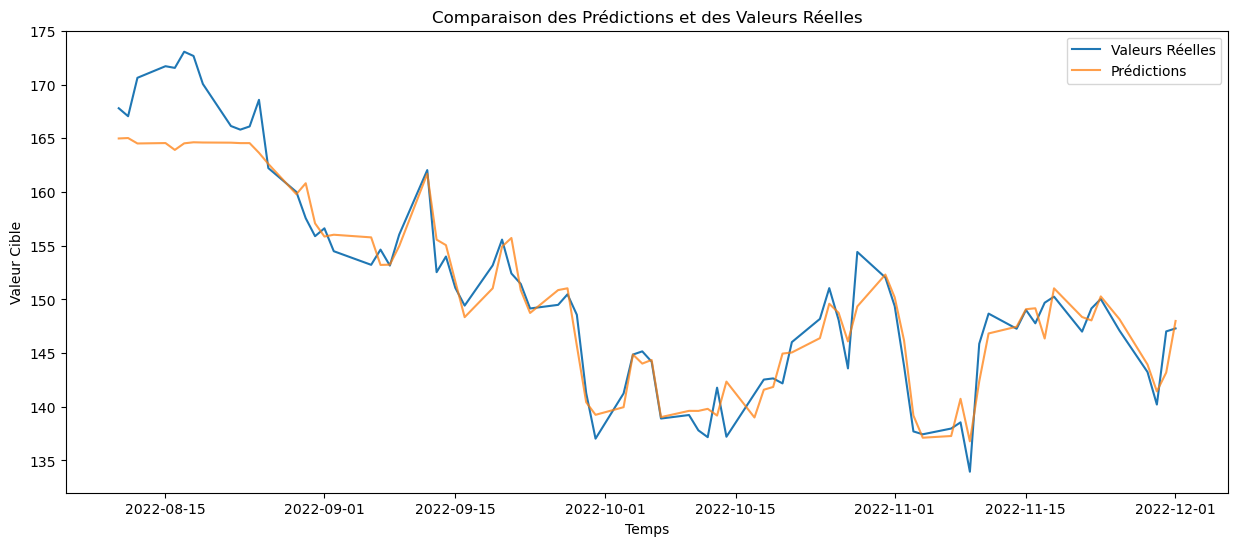

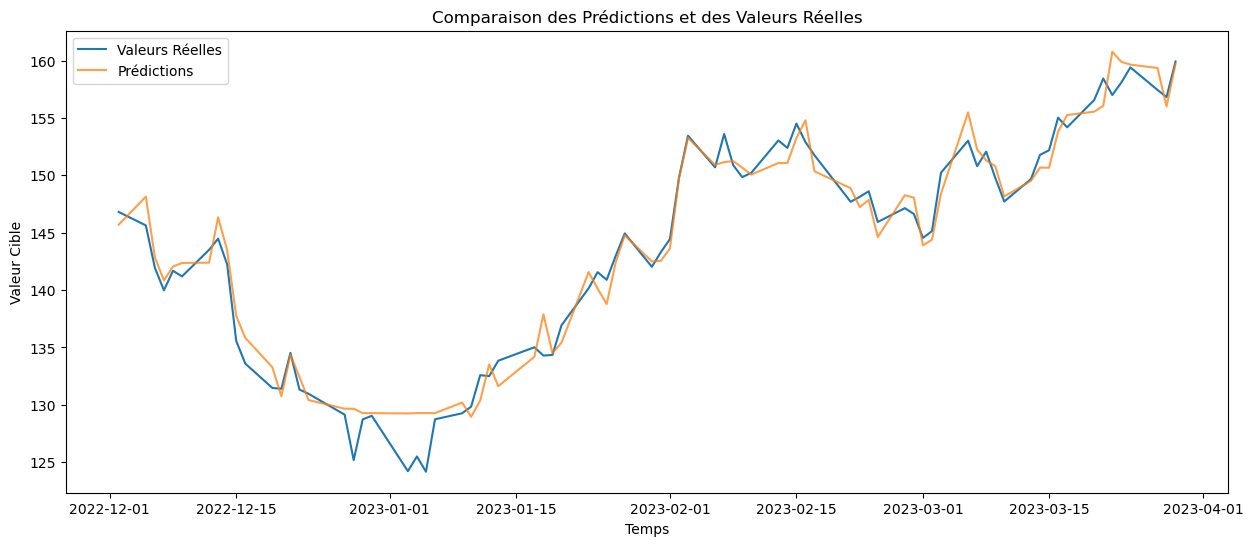

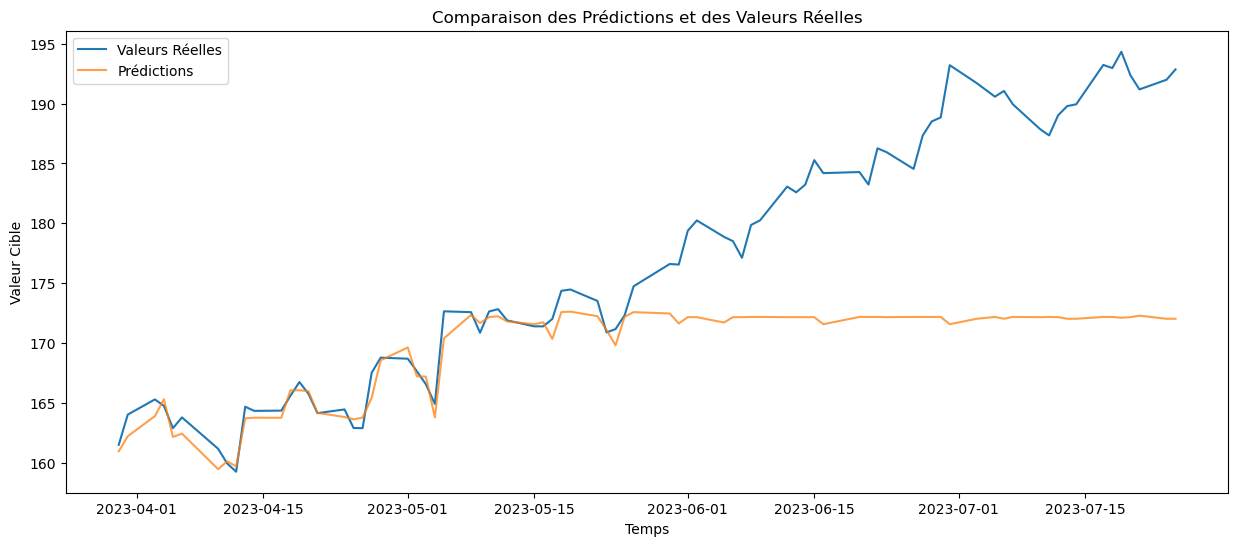

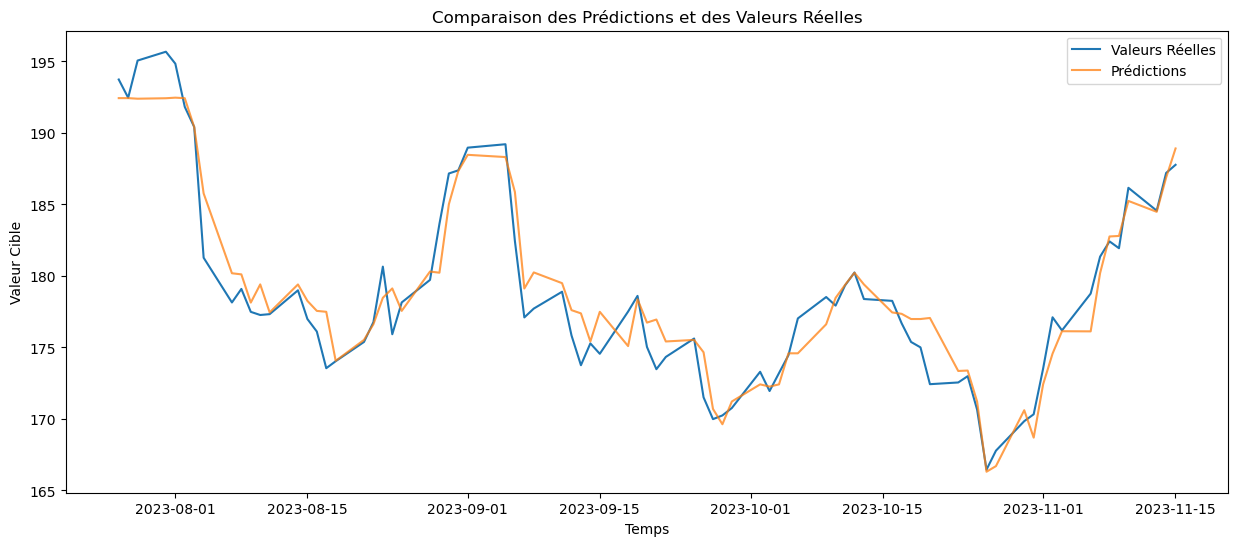

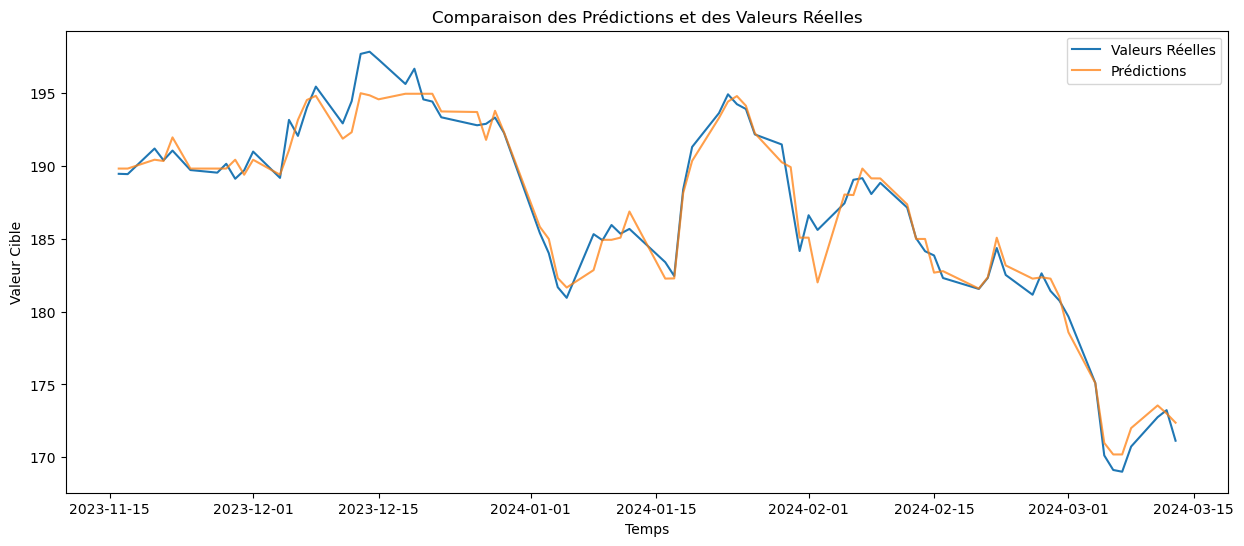

Average MSE over all folds: 25.327480912033415


[7.481093697403814,
 2.9200431005864296,
 111.8164452705565,
 3.187015489328792,
 1.232807002291544]

In [142]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y are your features and target variable, prepared with lagged features

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

errors = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_squared_error(y_test, predictions)
    errors.append(error)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Valeurs Réelles')
    plt.plot(y_test.index, predictions, label='Prédictions', alpha=0.75)
    plt.title('Comparaison des Prédictions et des Valeurs Réelles')
    plt.xlabel('Temps')
    plt.ylabel('Valeur Cible')
    plt.legend()
    plt.show()
print(f"Average MSE over all folds: {np.mean(errors)}")
errors


# On remarque ici en coupant le dataset en 5 splits avant d'appliquer le modèle que une très mauvaise prédictions a lieu au troisème split de 2023-04-01 à 2023-07-15 pour cette time series
# entrainant une MSE moyenne assez élevé
# Le rééchantillonage a permis de voir dans quelle mesure la valeurs des prédictions est impacté et à quelle moment précisément est le problème en coupant le dataset en 5 dataset pllus petit il est très difficle au modèle de prédire pour le troisième cas ayant un impact sur la MSE


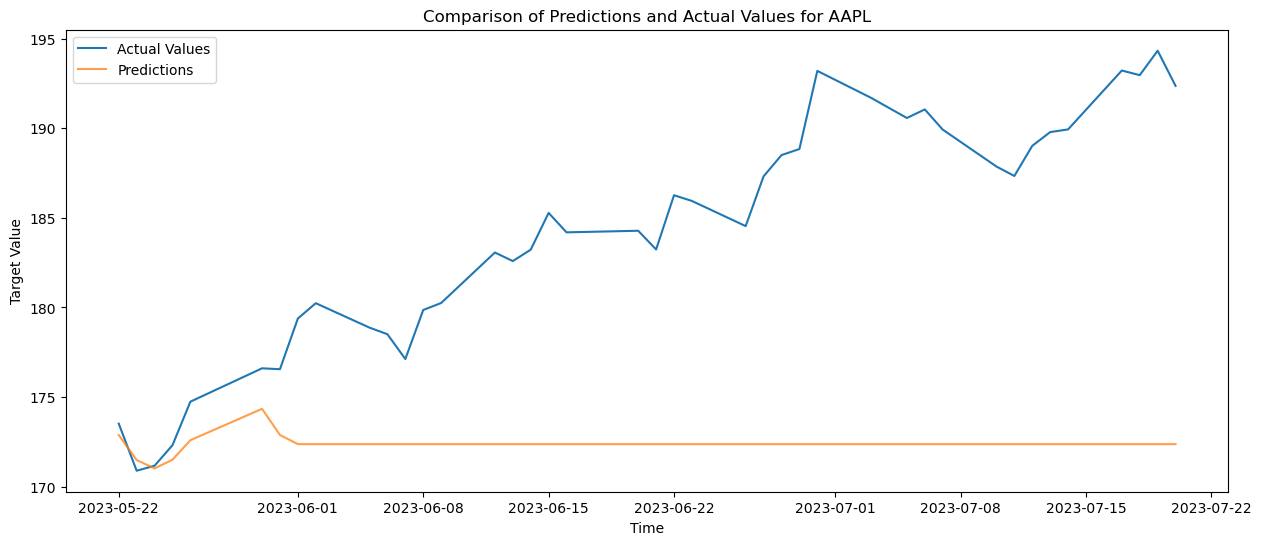

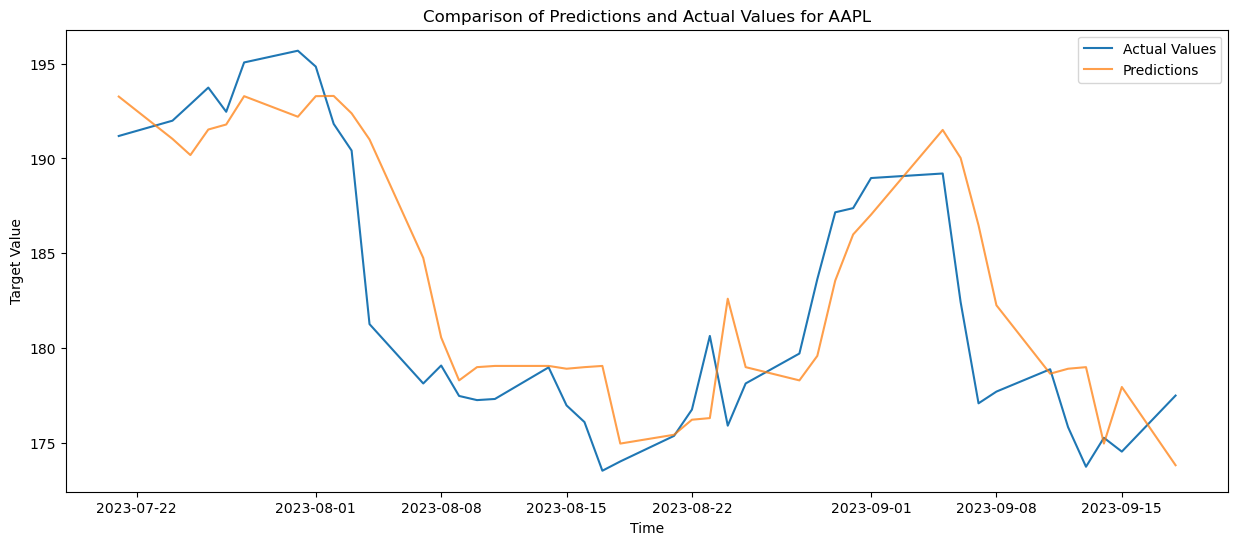

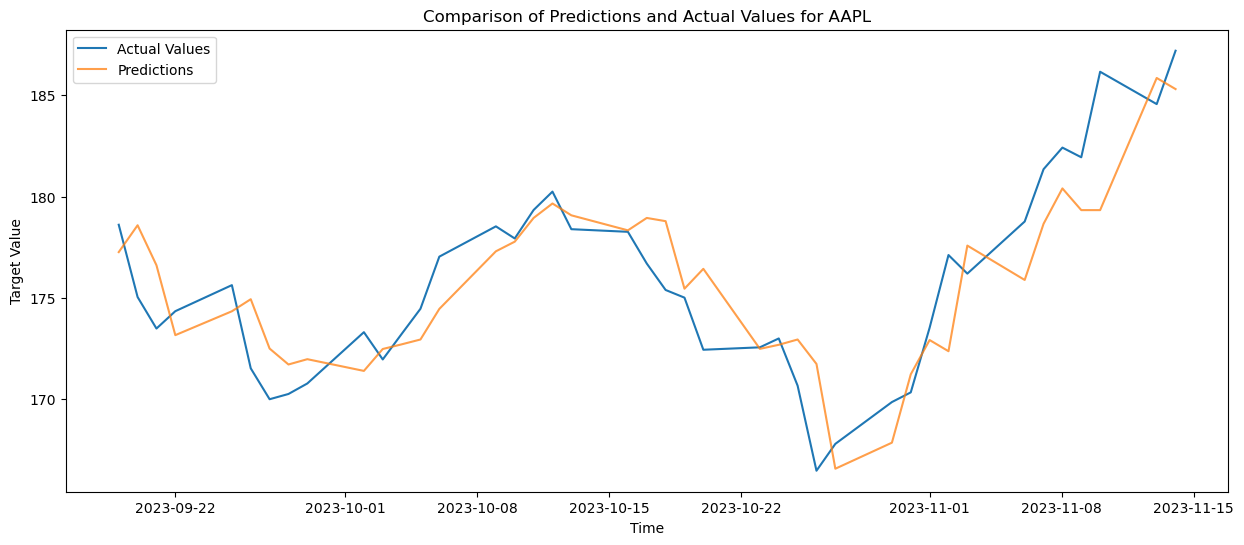

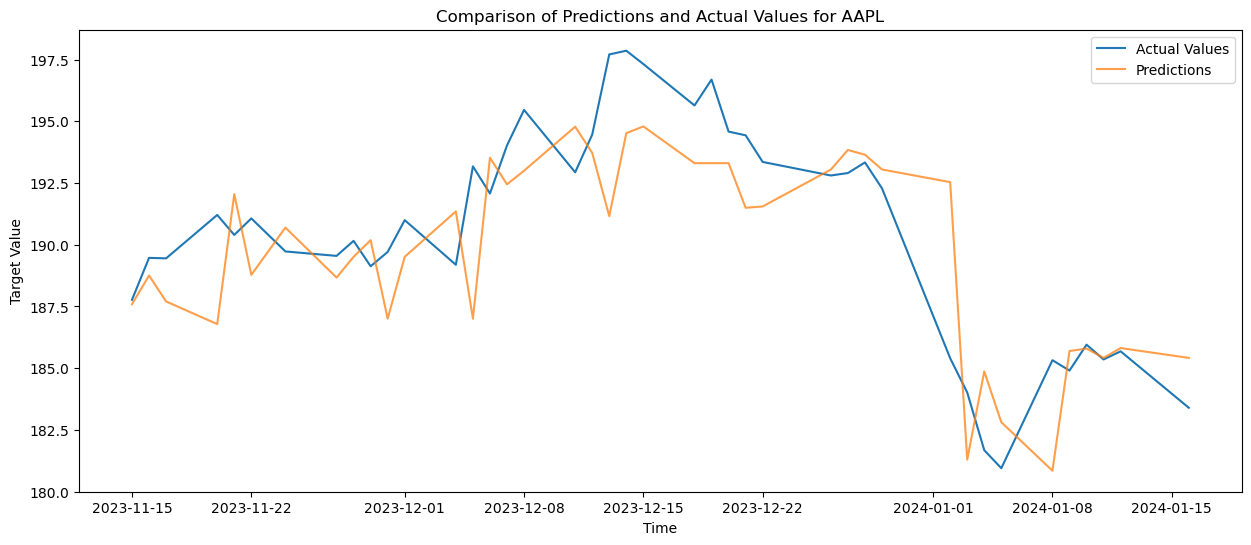

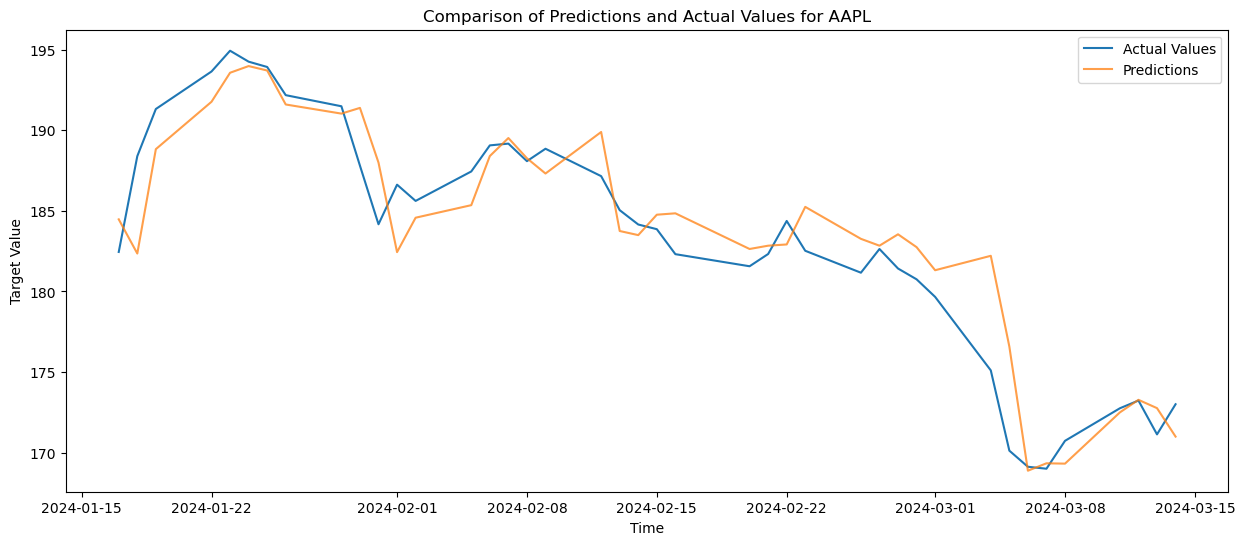

Average MSE over all folds for AAPL: 42.836720208699504


[181.29393006135774,
 13.839221229621927,
 5.851007831903694,
 7.080925468165318,
 6.118516452448847]

In [229]:
# Assuming X_AAPL and y_AAPL are your features and target variable for AAPL, prepared with lagged features

# Initialize TimeSeriesSplit
tscv_AAPL = TimeSeriesSplit(n_splits=5)

errors_AAPL = []
for train_index, test_index in tscv_AAPL.split(X_AAPL):
    X_train_AAPL, X_test_AAPL = X_AAPL.iloc[train_index], X_AAPL.iloc[test_index]
    y_train_AAPL, y_test_AAPL = y_AAPL.iloc[train_index], y_AAPL.iloc[test_index]
    
    model_AAPL = GradientBoostingRegressor()
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    error_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    errors_AAPL.append(error_AAPL)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_AAPL.index, y_test_AAPL, label='Actual Values')
    plt.plot(y_test_AAPL.index, predictions_AAPL, label='Predictions', alpha=0.75)
    plt.title('Comparison of Predictions and Actual Values for AAPL')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()
print(f"Average MSE over all folds for AAPL: {np.mean(errors_AAPL)}")
errors_AAPL


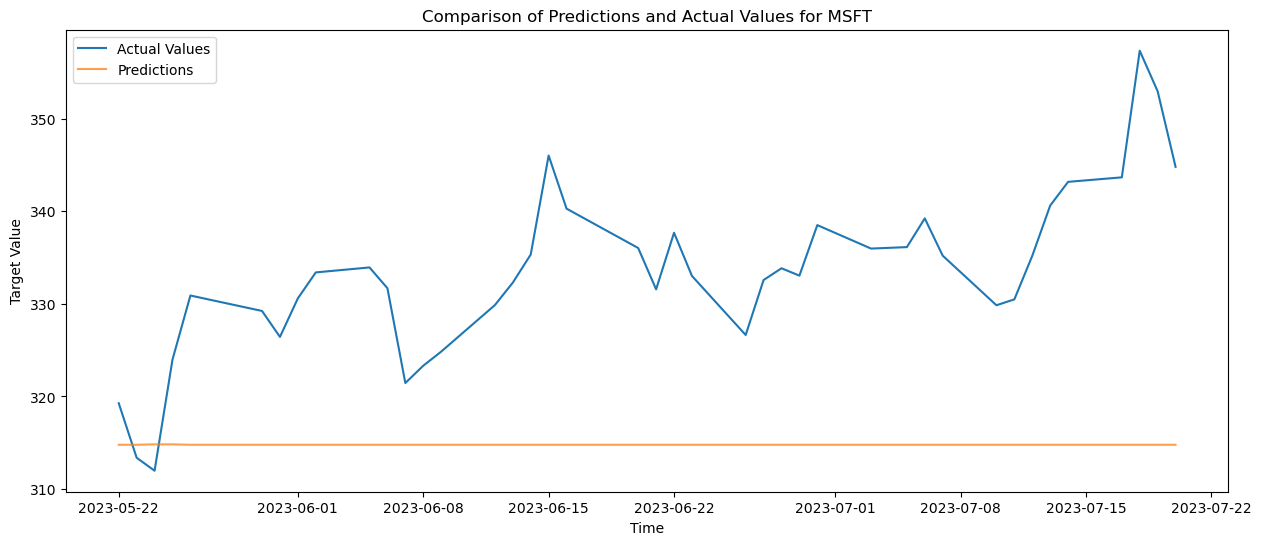

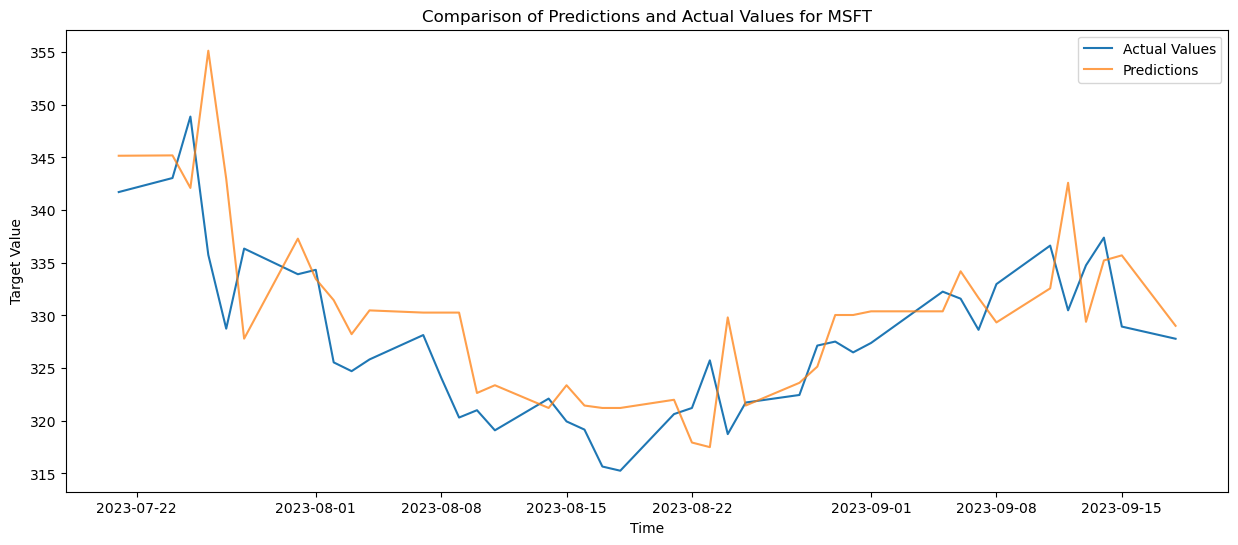

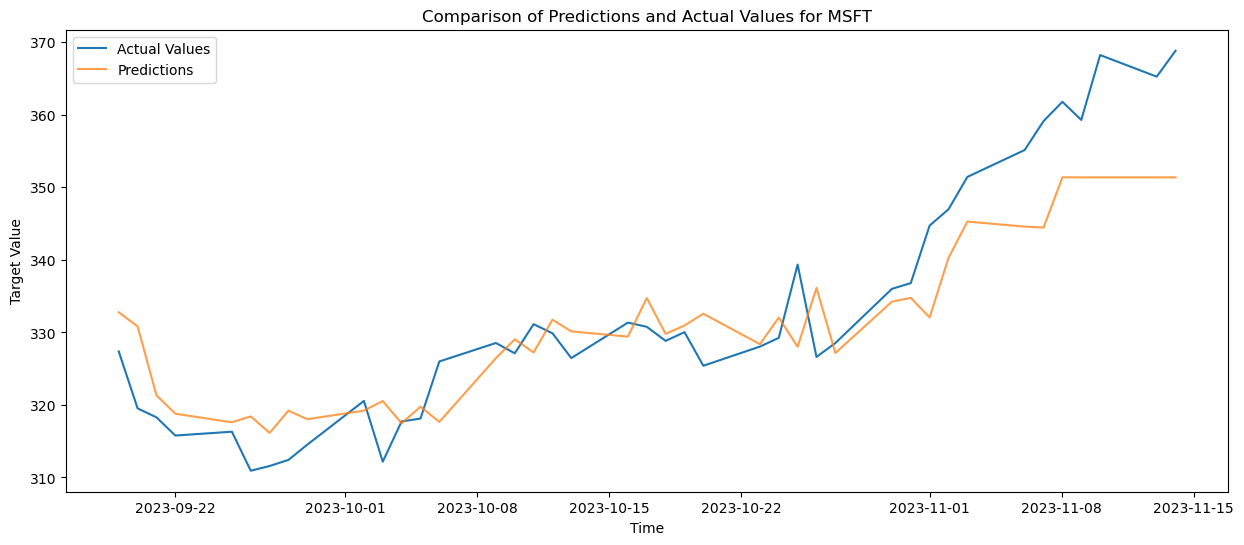

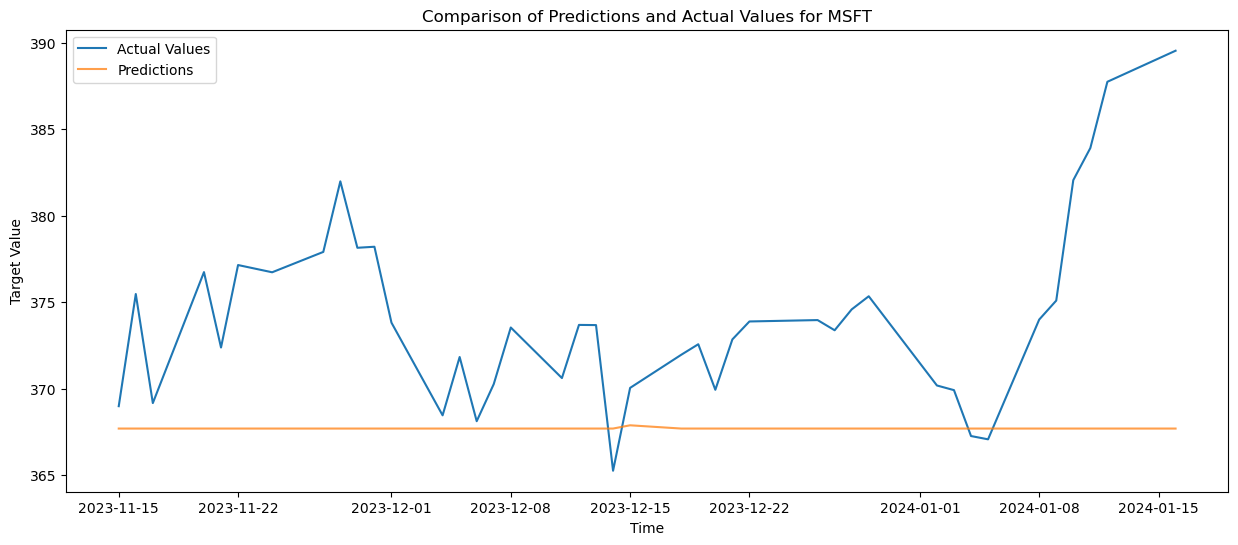

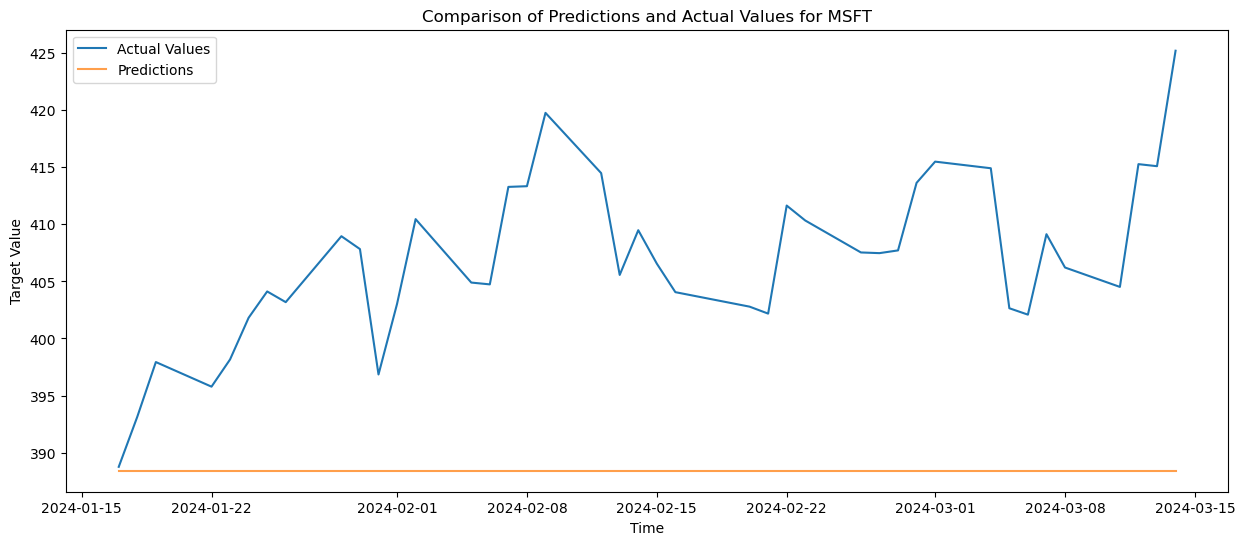

Average MSE over all folds for MSFT: 195.4425868861304


[423.60505320134484,
 37.93246441474214,
 56.7868322921691,
 68.32356640671333,
 390.5650181156826]

In [230]:
# Assuming X_MSFT and y_MSFT are your features and target variable for MSFT, prepared with lagged features

# Initialize TimeSeriesSplit
tscv_MSFT = TimeSeriesSplit(n_splits=5)

errors_MSFT = []
for train_index, test_index in tscv_MSFT.split(X_MSFT):
    X_train_MSFT, X_test_MSFT = X_MSFT.iloc[train_index], X_MSFT.iloc[test_index]
    y_train_MSFT, y_test_MSFT = y_MSFT.iloc[train_index], y_MSFT.iloc[test_index]
    
    model_MSFT = GradientBoostingRegressor()
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    error_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    errors_MSFT.append(error_MSFT)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_MSFT.index, y_test_MSFT, label='Actual Values')
    plt.plot(y_test_MSFT.index, predictions_MSFT, label='Predictions', alpha=0.75)
    plt.title('Comparison of Predictions and Actual Values for MSFT')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()
print(f"Average MSE over all folds for MSFT: {np.mean(errors_MSFT)}")
errors_MSFT


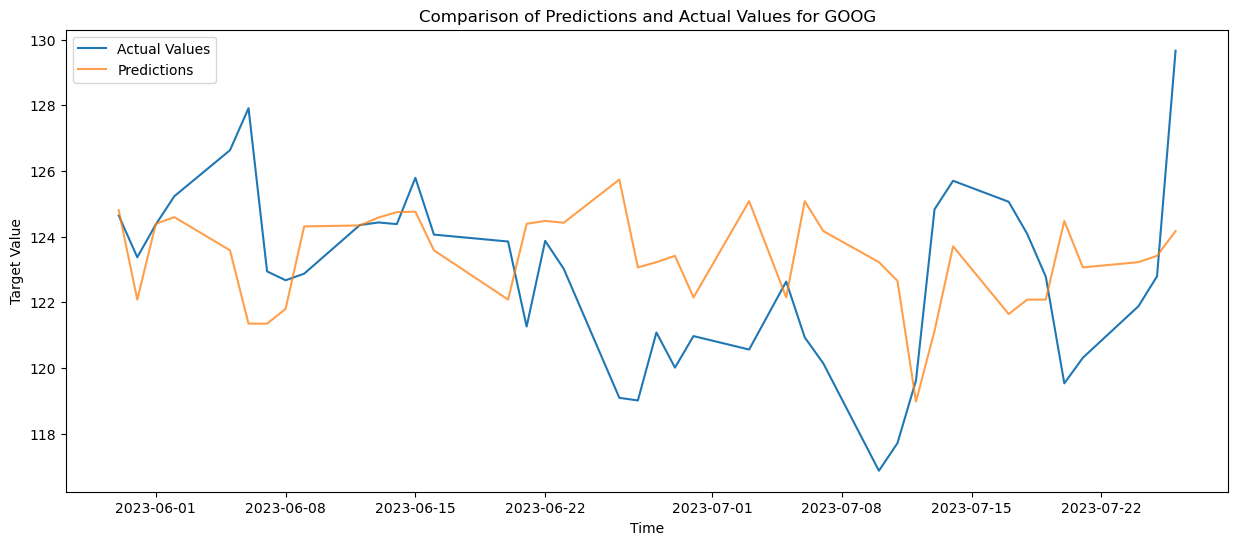

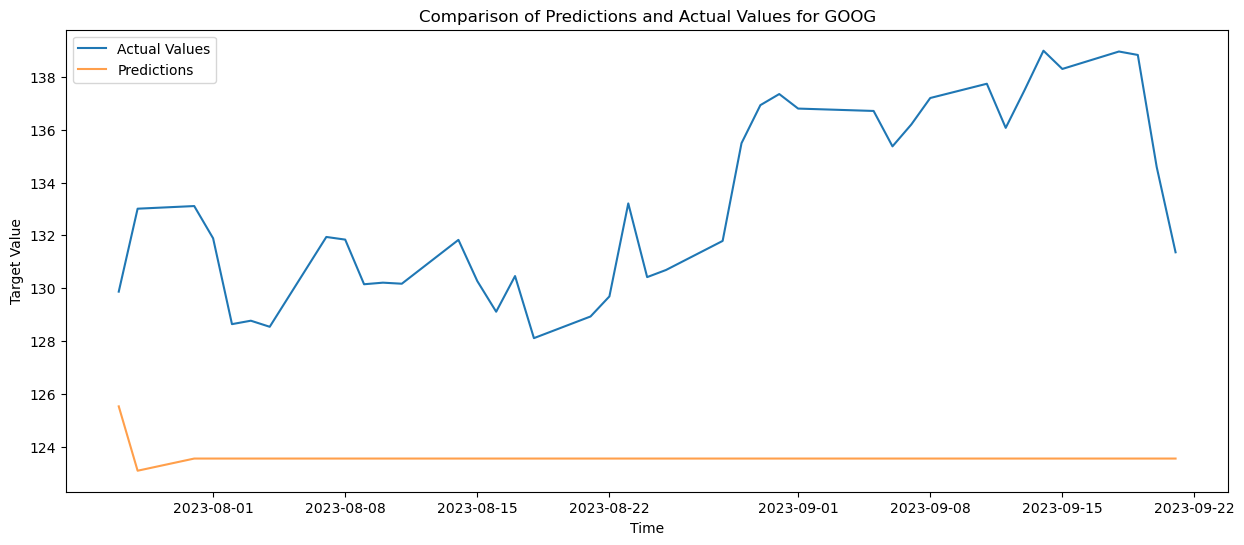

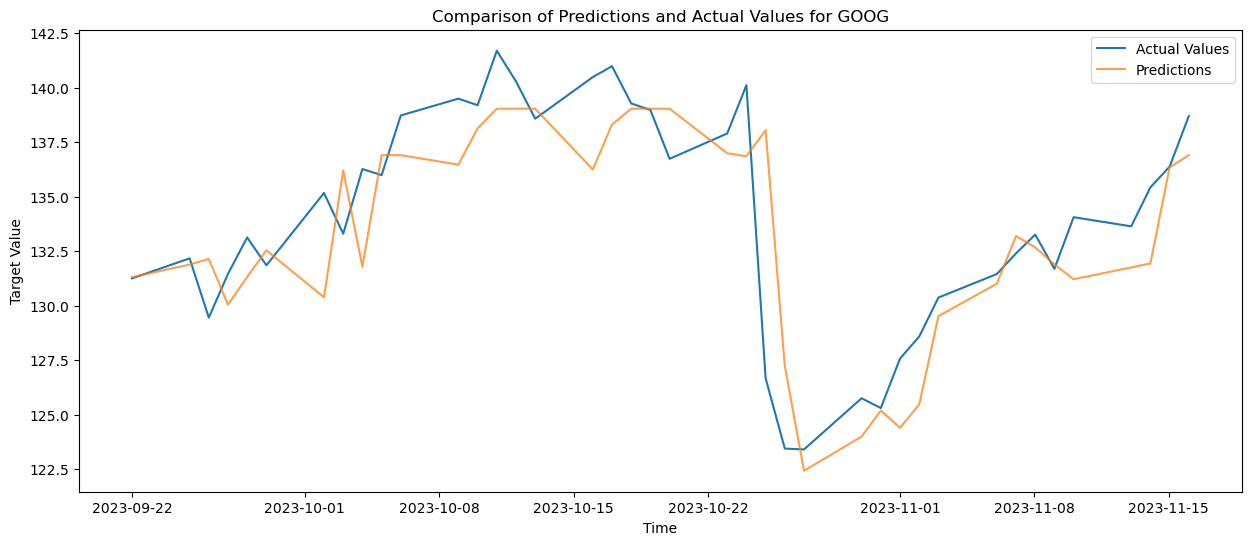

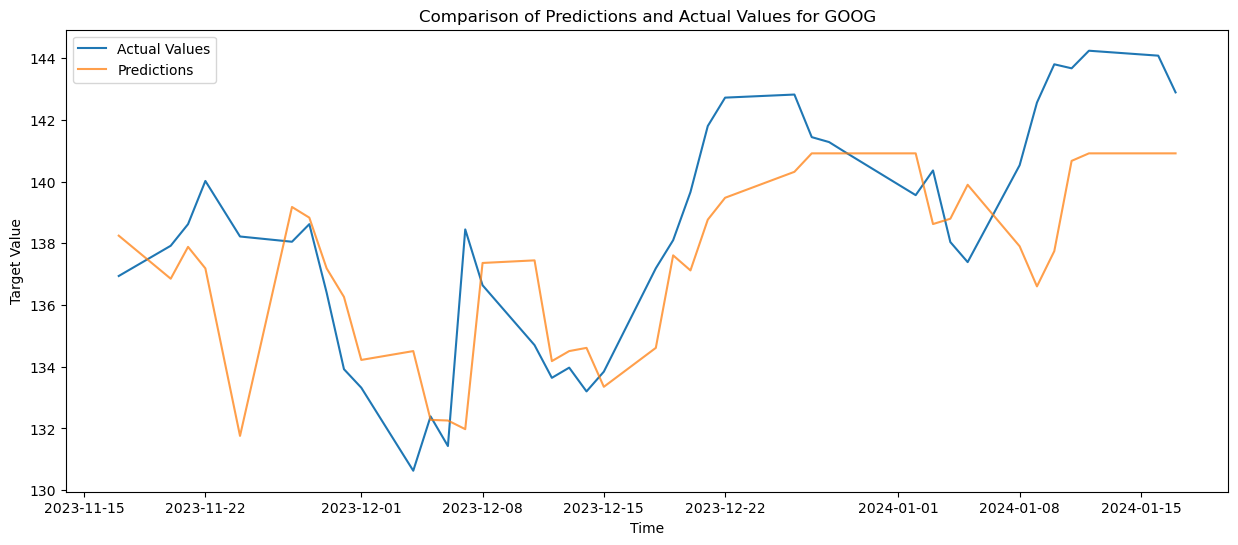

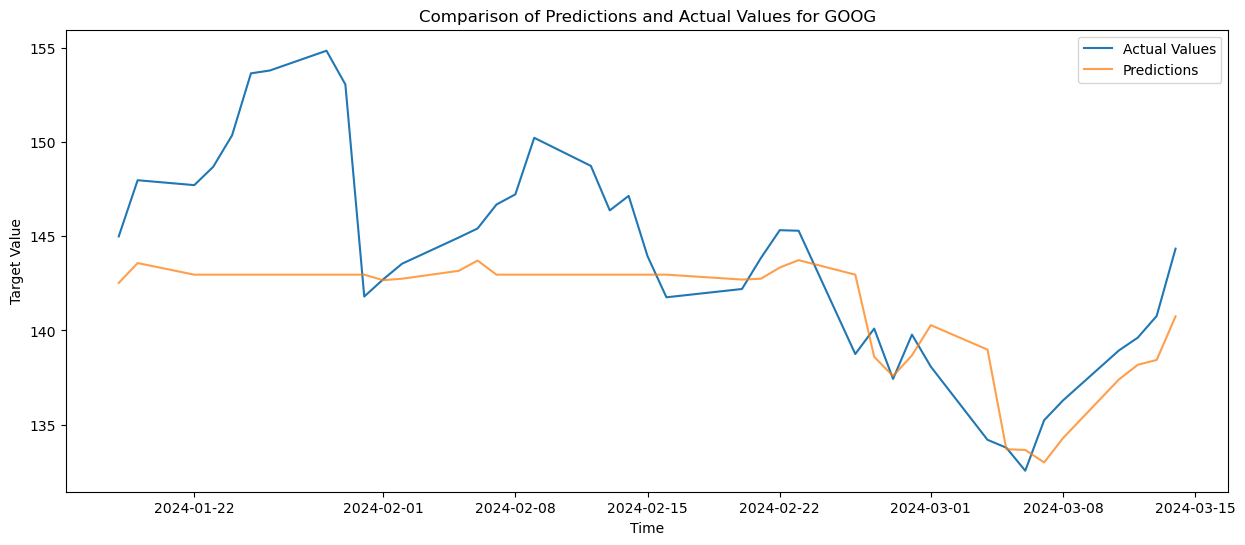

Average MSE over all folds for GOOG: 30.1217436285714


[9.30534368321718,
 104.35361457380009,
 8.170413403024785,
 7.35951366132046,
 21.419832821494502]

In [292]:
# Assuming X_GOOG and y_GOOG are your features and target variable for GOOG, prepared with lagged features

# Initialize TimeSeriesSplit
tscv_GOOG = TimeSeriesSplit(n_splits=5)

errors_GOOG = []
for train_index, test_index in tscv_GOOG.split(X_GOOG):
    X_train_GOOG, X_test_GOOG = X_GOOG.iloc[train_index], X_GOOG.iloc[test_index]
    y_train_GOOG, y_test_GOOG = y_GOOG.iloc[train_index], y_GOOG.iloc[test_index]
    
    model_GOOG = GradientBoostingRegressor()
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    error_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    errors_GOOG.append(error_GOOG)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_GOOG.index, y_test_GOOG, label='Actual Values')
    plt.plot(y_test_GOOG.index, predictions_GOOG, label='Predictions', alpha=0.75)
    plt.title('Comparison of Predictions and Actual Values for GOOG')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()
print(f"Average MSE over all folds for GOOG: {np.mean(errors_GOOG)}")
errors_GOOG


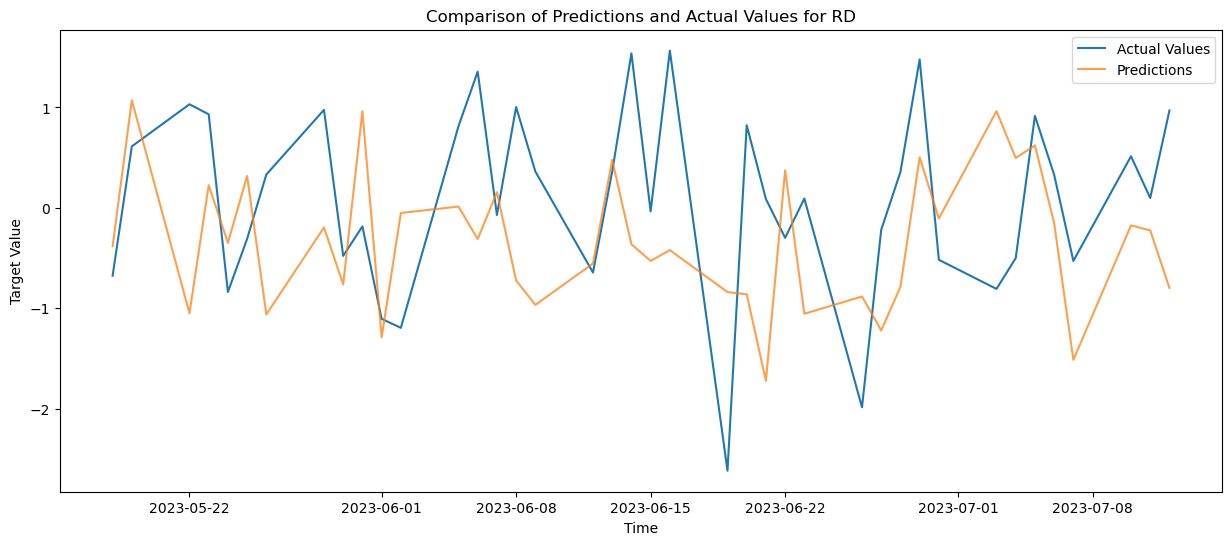

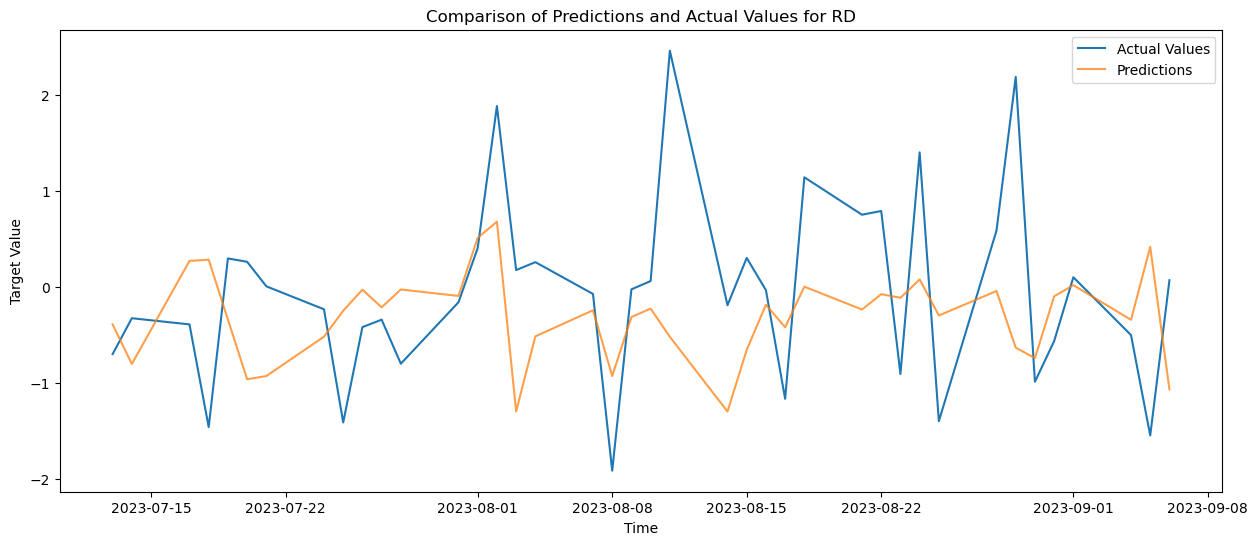

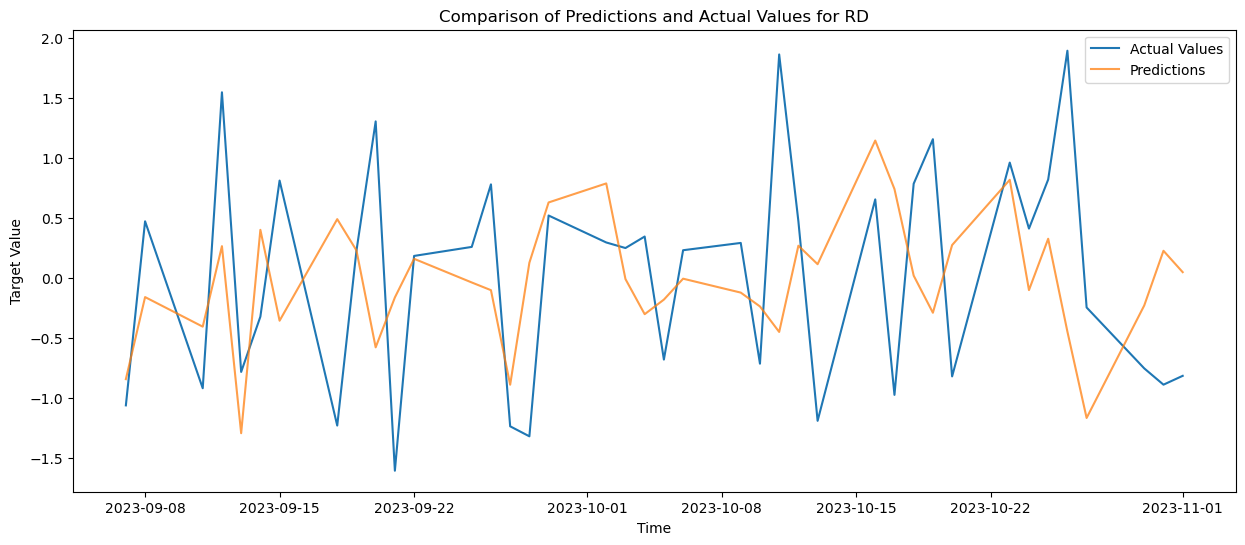

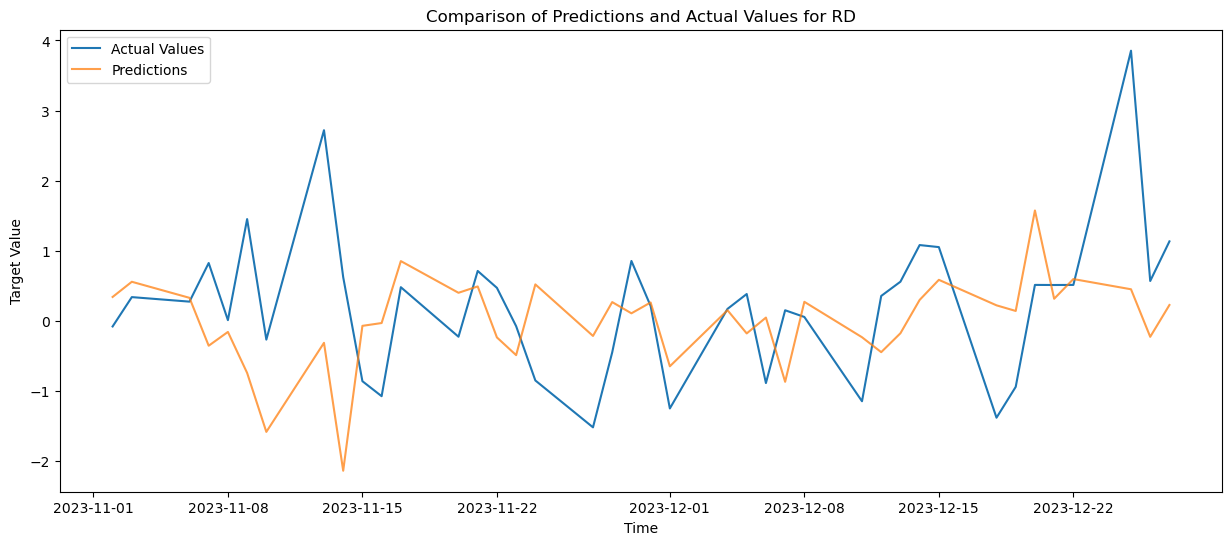

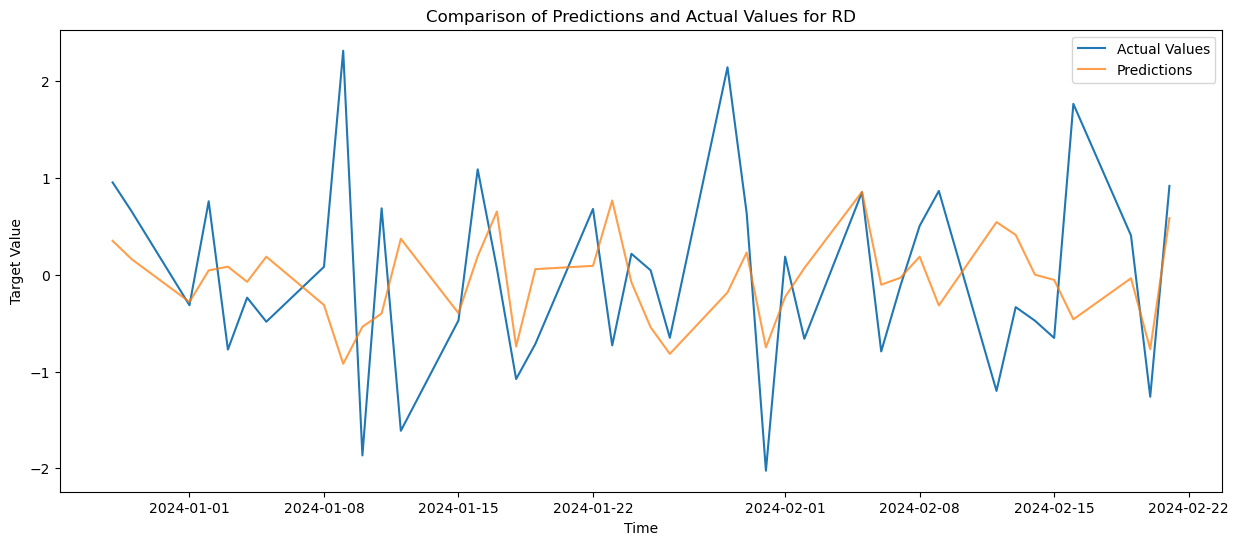

Average MSE over all folds for RD: 1.201877986212967


[1.31783262971117,
 1.1591399384069248,
 1.0246666323942601,
 1.3994851299500228,
 1.1082656006024567]

In [293]:
# Assuming X_RD and y_RD are your features and target variable for RD, prepared with lagged features

# Initialize TimeSeriesSplit
tscv_RD = TimeSeriesSplit(n_splits=5)

errors_RD = []
for train_index, test_index in tscv_RD.split(X_RD):
    X_train_RD, X_test_RD = X_RD.iloc[train_index], X_RD.iloc[test_index]
    y_train_RD, y_test_RD = y_RD.iloc[train_index], y_RD.iloc[test_index]
    
    model_RD = GradientBoostingRegressor()
    model_RD.fit(X_train_RD, y_train_RD)
    predictions_RD = model_RD.predict(X_test_RD)
    error_RD = mean_squared_error(y_test_RD, predictions_RD)
    errors_RD.append(error_RD)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_RD.index, y_test_RD, label='Actual Values')
    plt.plot(y_test_RD.index, predictions_RD, label='Predictions', alpha=0.75)
    plt.title('Comparison of Predictions and Actual Values for RD')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()
print(f"Average MSE over all folds for RD: {np.mean(errors_RD)}")
errors_RD


Evaluating model for: AAPL


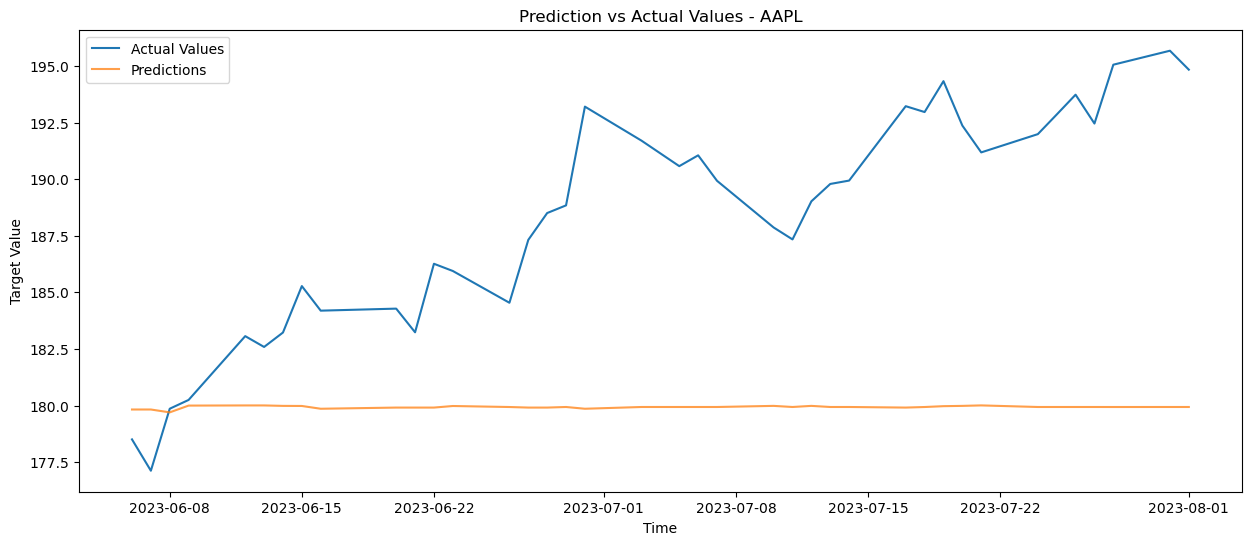

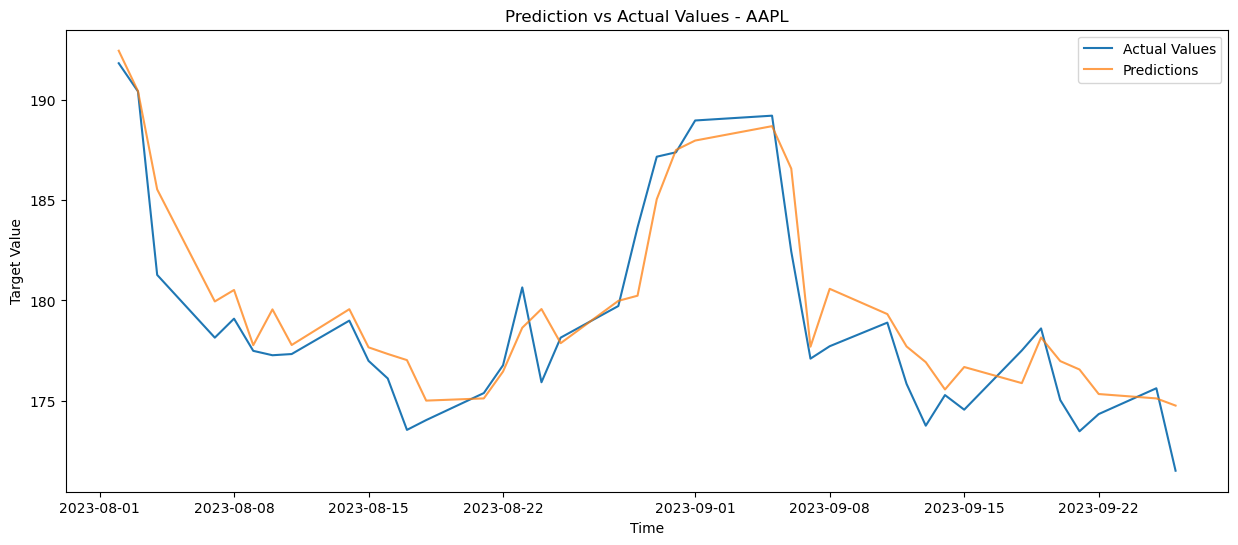

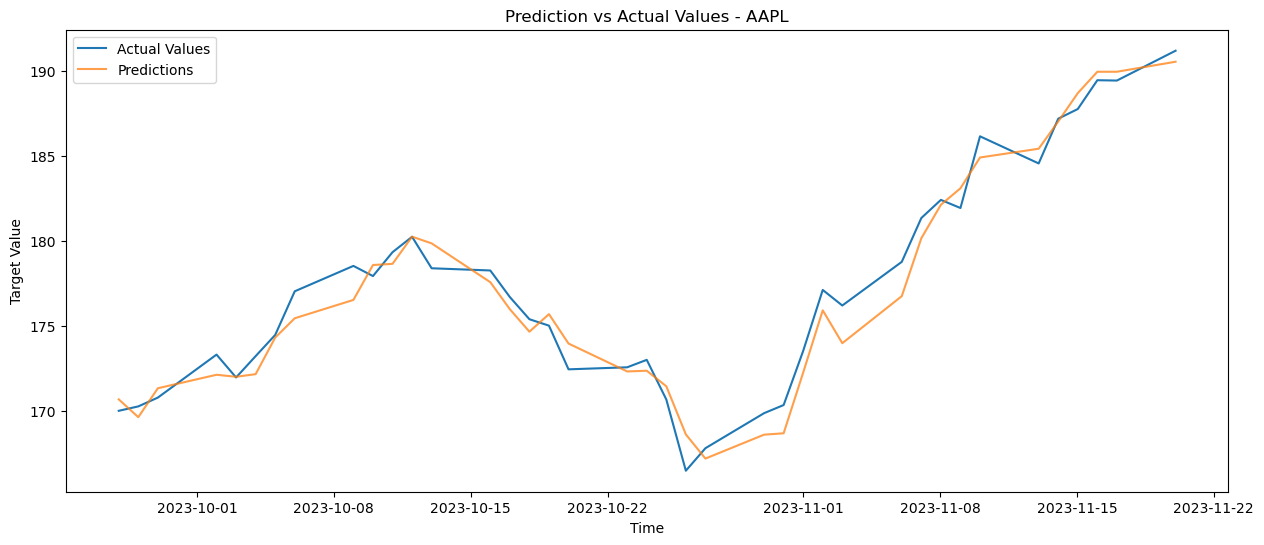

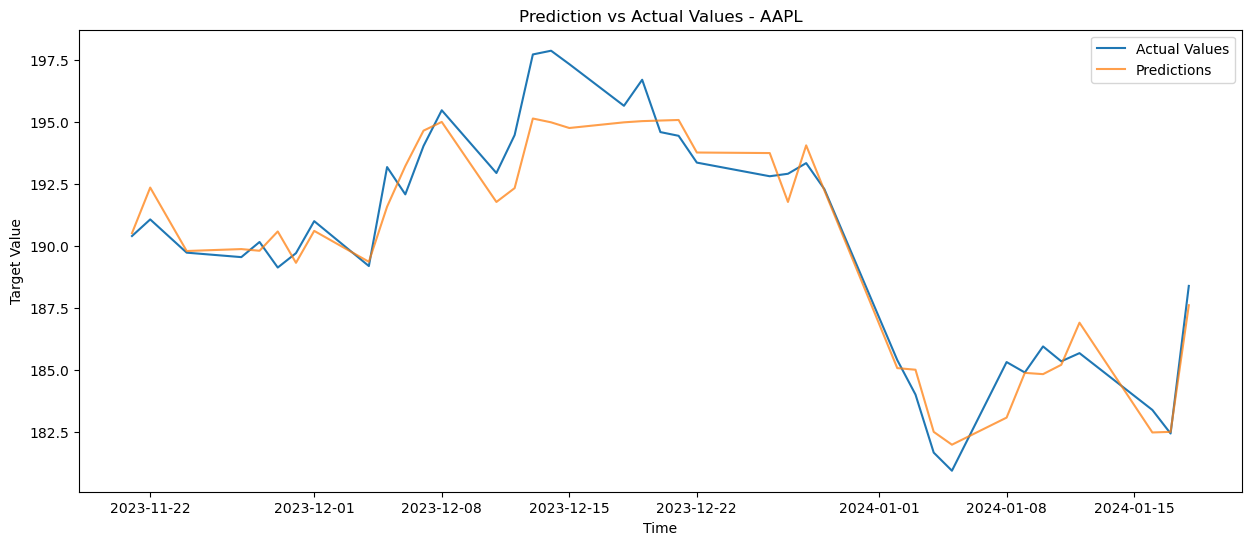

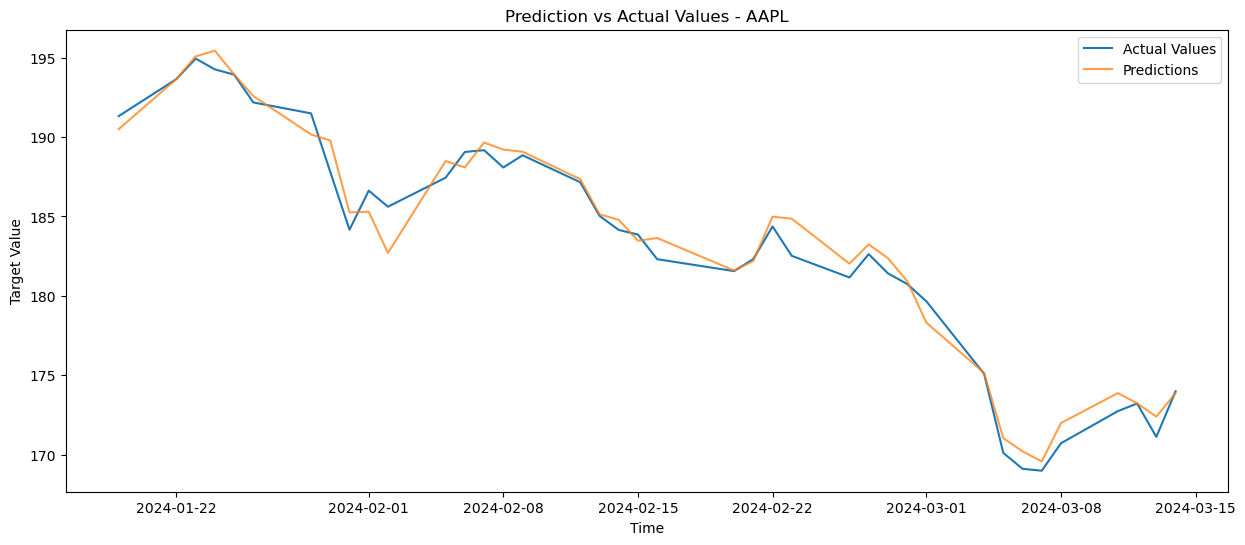

Model: AAPL
Average MSE: 20.2708583993279
Average RMSE: 2.995843274024215
Average MAE: 2.5544845512745376

Evaluating model for: MSFT


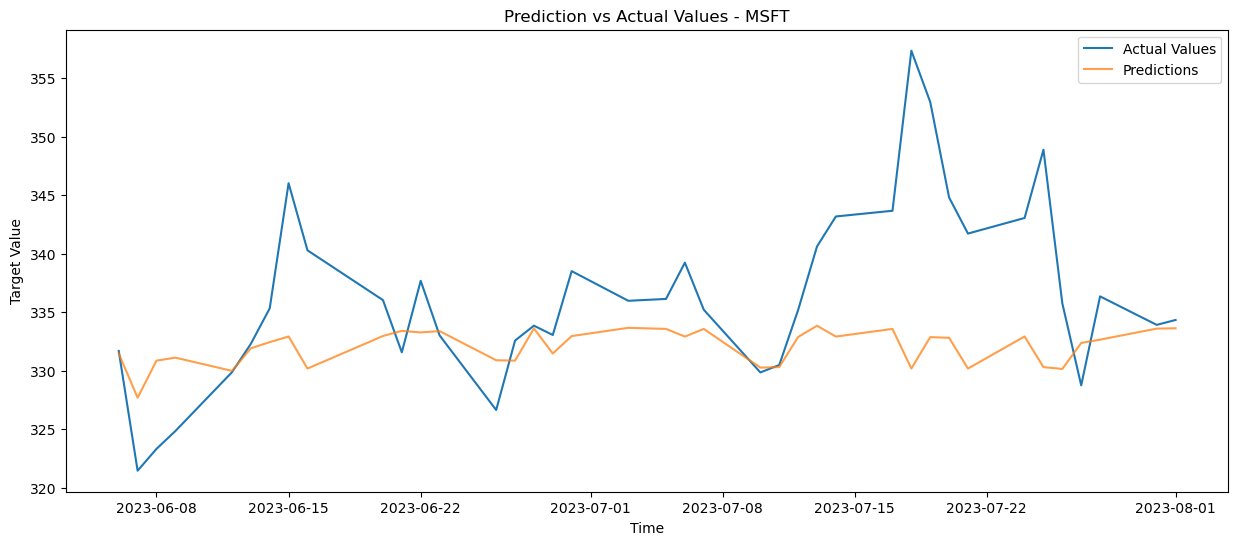

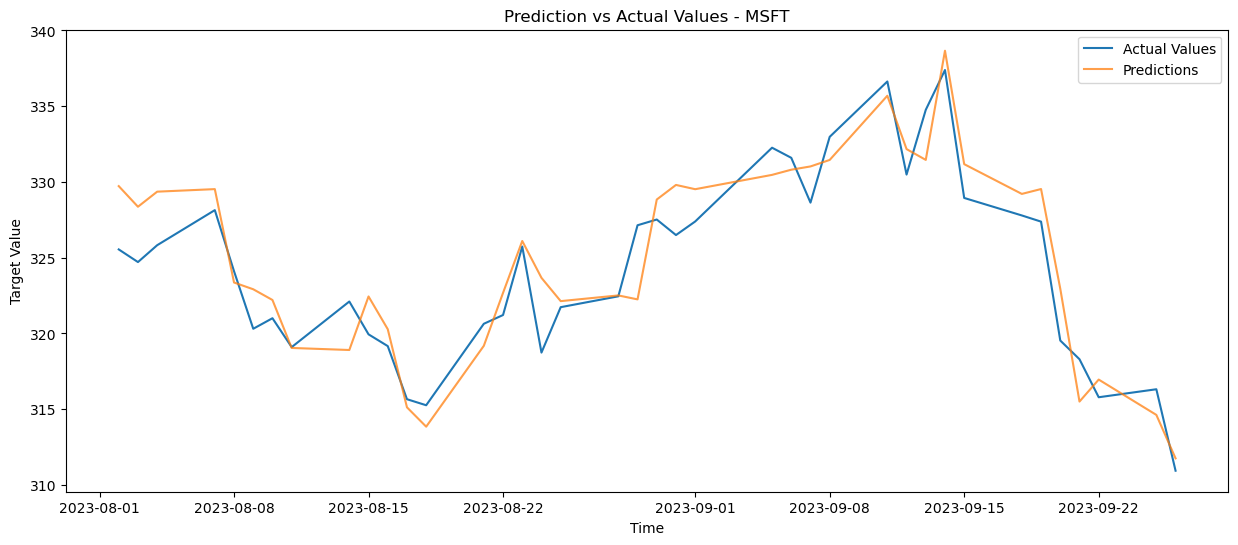

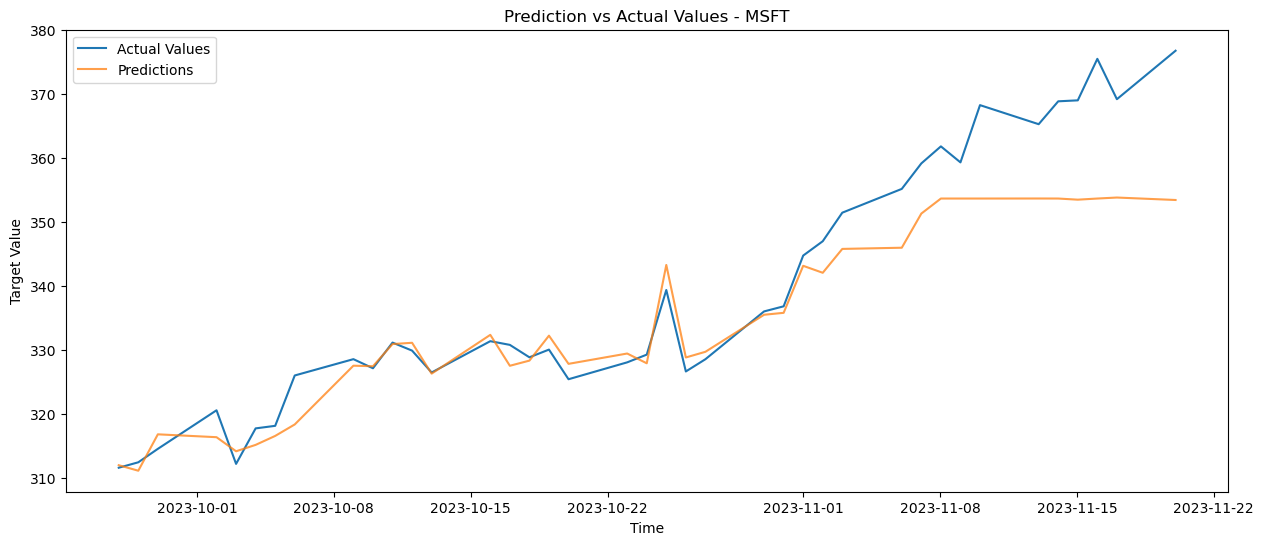

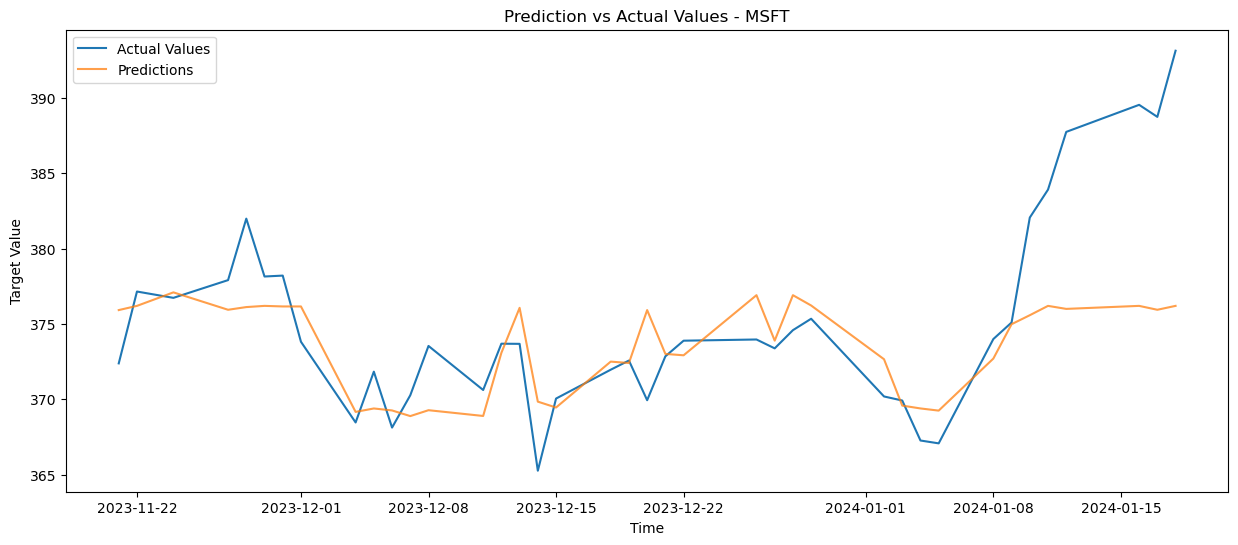

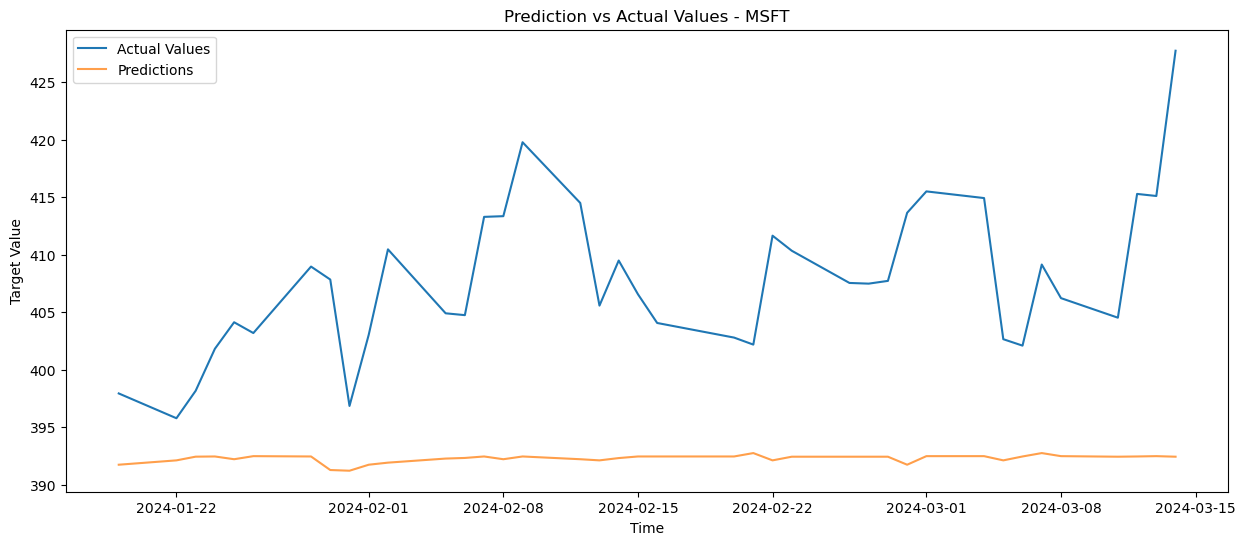

Model: MSFT
Average MSE: 89.49240007071103
Average RMSE: 8.138459536843532
Average MAE: 6.366441442421143

Evaluating model for: GOOG


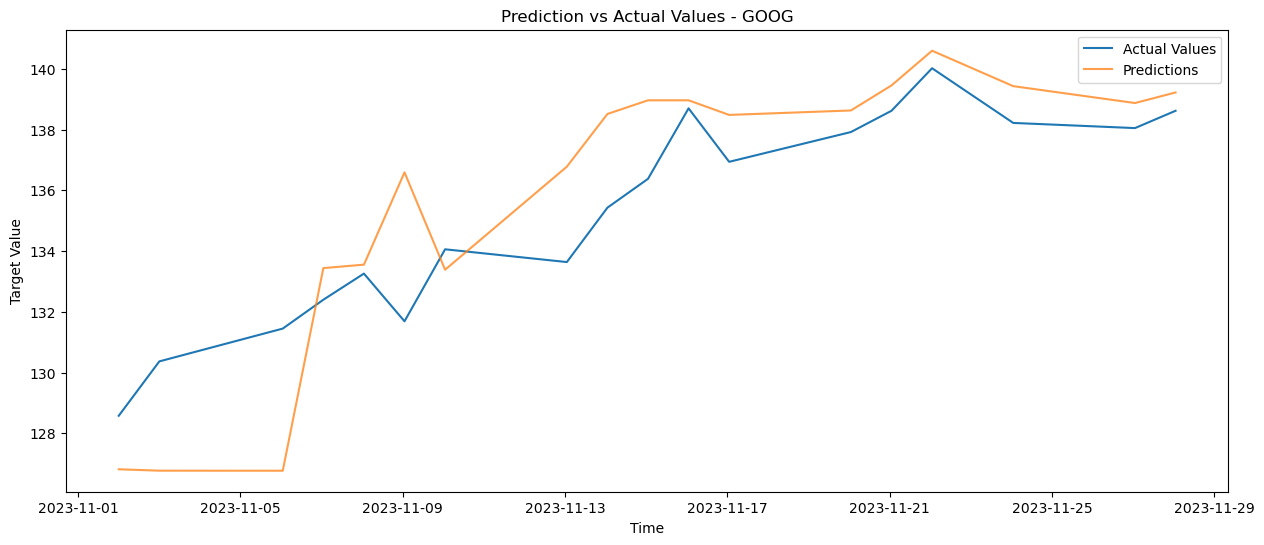

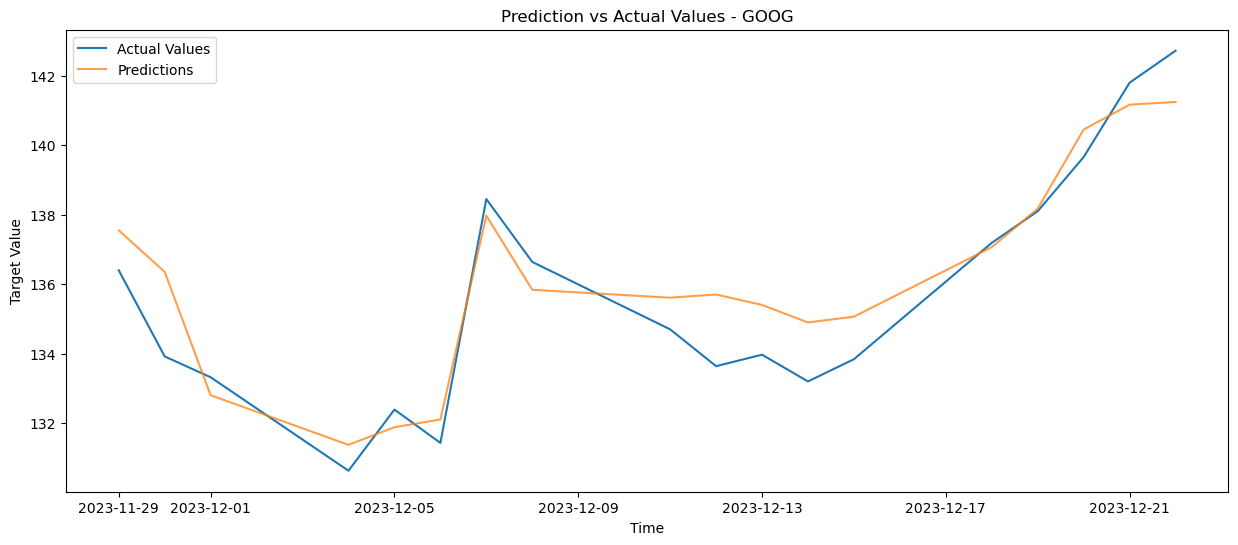

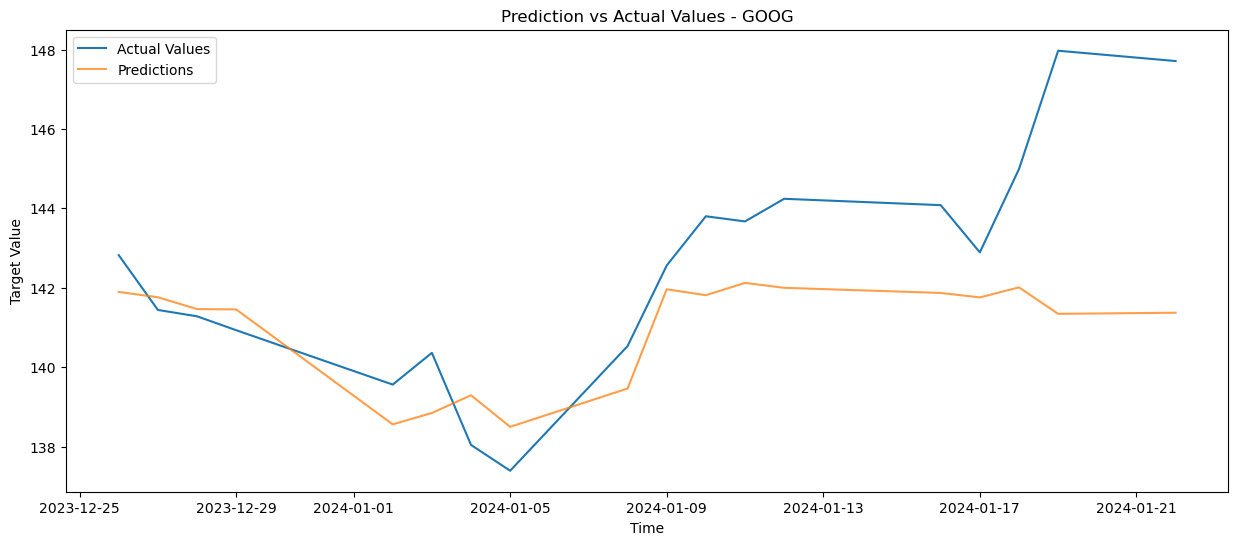

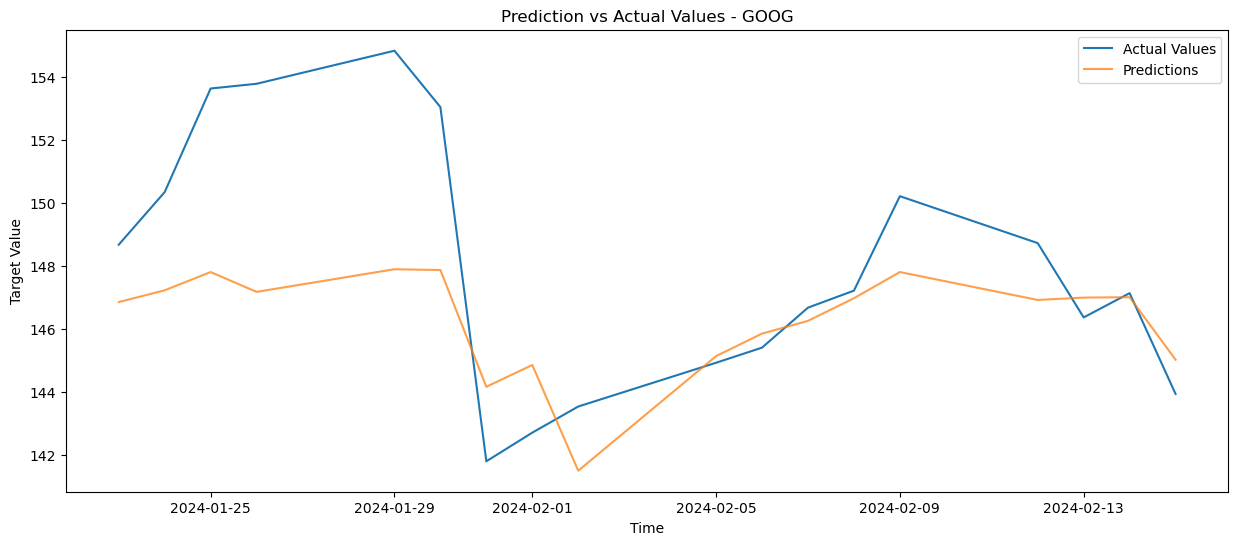

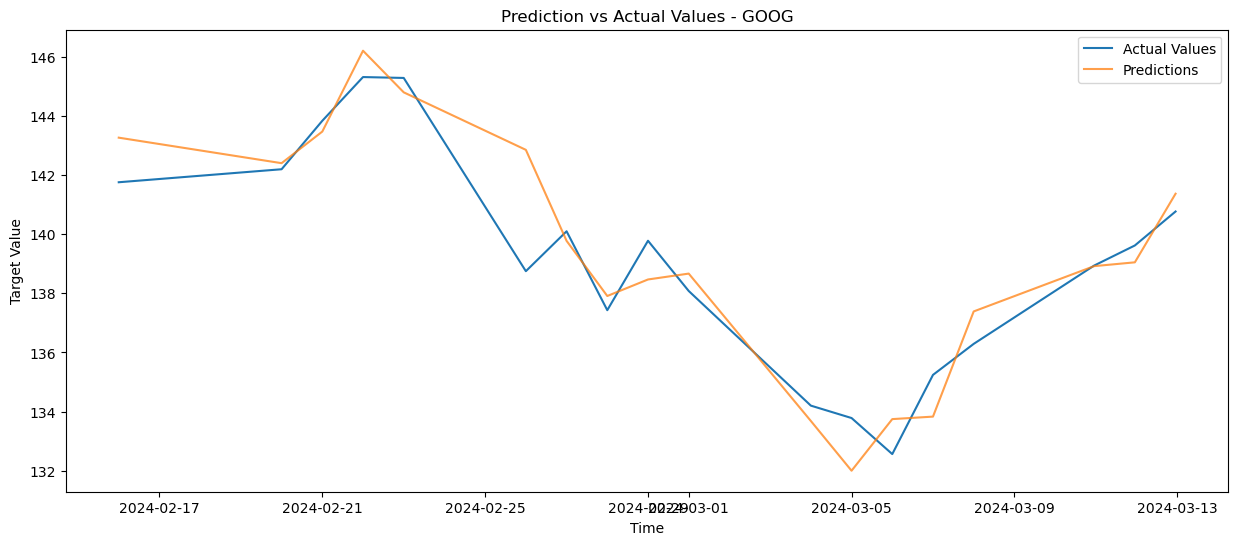

Model: GOOG
Average MSE: 5.14033057476019
Average RMSE: 2.126517937571806
Average MAE: 1.6056287615571603

Evaluating model for: RD


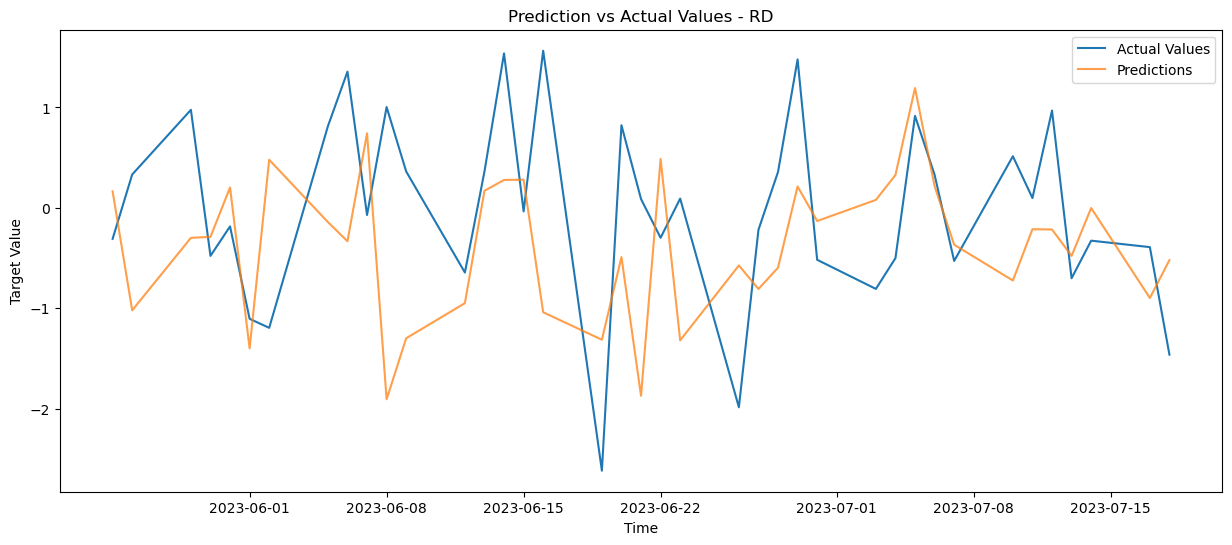

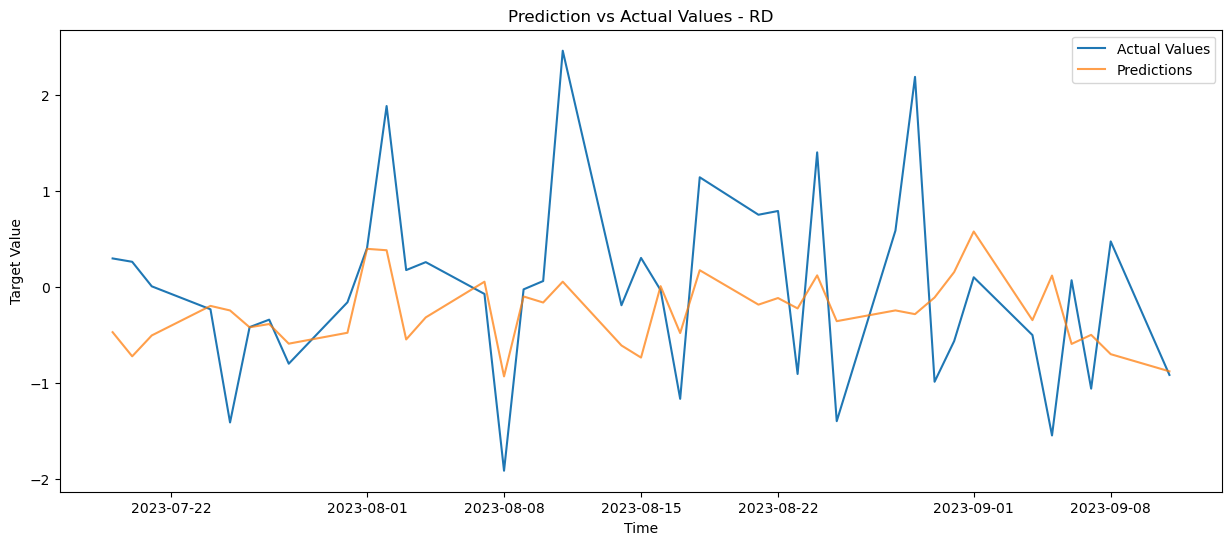

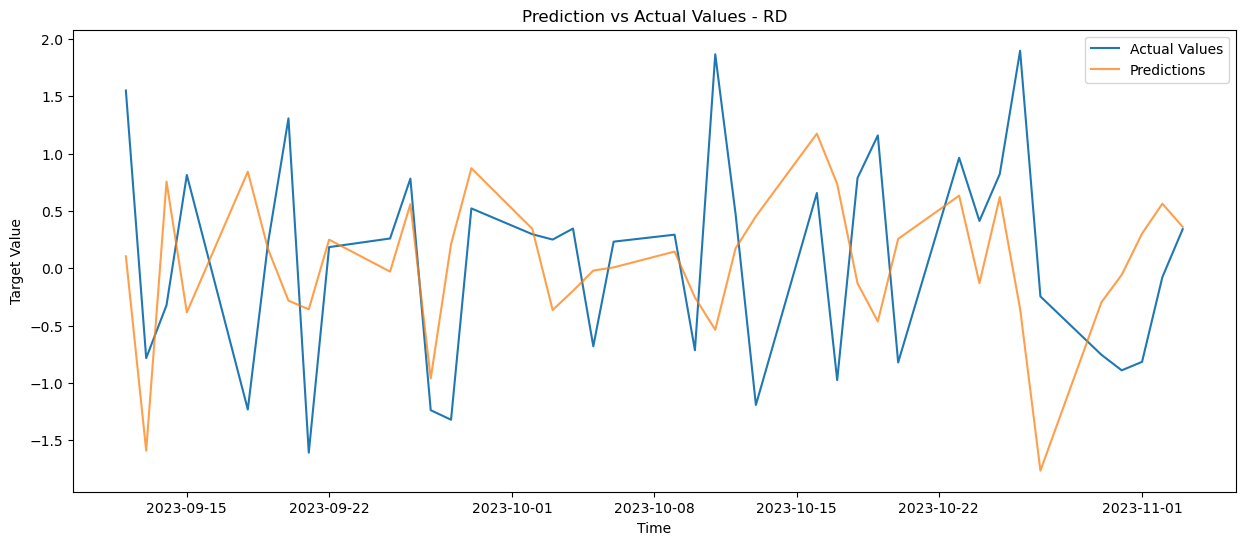

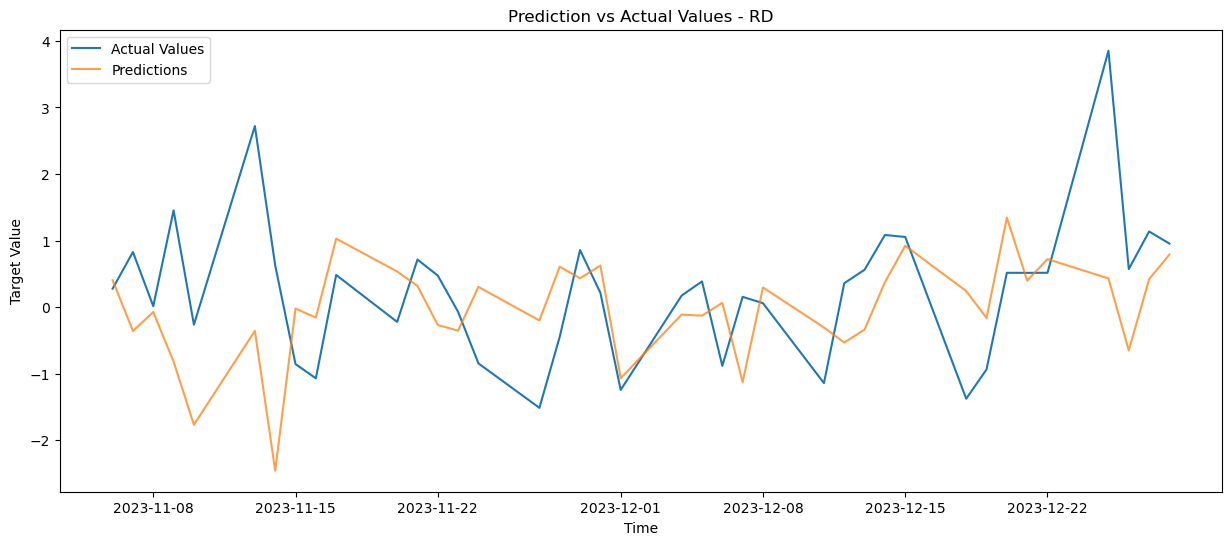

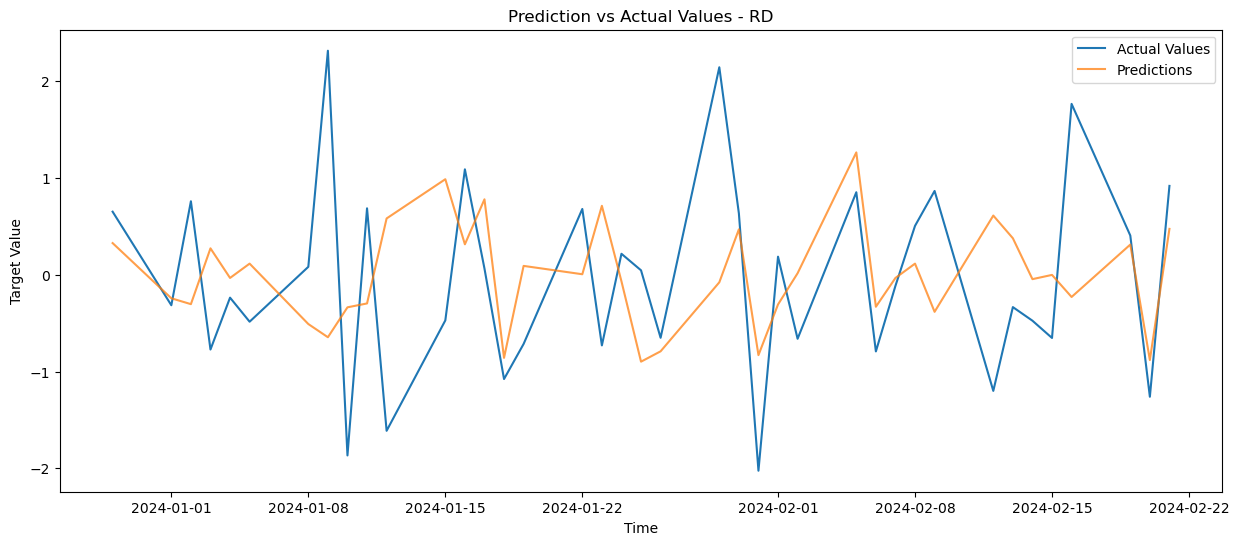

Model: RD
Average MSE: 1.205127272363312
Average RMSE: 1.0934101540087735
Average MAE: 0.8571576208269042



In [324]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

# Prepared datasets for the models
datasets = {
    'AAPL': df_featured_AAPL,
    'MSFT': df_featured_MSFT,
    'GOOG': df_featured_GOOG,
#    'ETH': df_featured_ETH,
    'RD': df_featured_RD
}

for model_name, df_featured in datasets.items():
    print(f"Evaluating model for: {model_name}")
    X = df_featured.drop('Close', axis=1)
    y = df_featured['Close']
    tscv = TimeSeriesSplit(n_splits=5)
    
    mse_errors = []
    rmse_errors = []
    mae_errors = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = GradientBoostingRegressor()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        
        mse_errors.append(mse)
        rmse_errors.append(rmse)
        mae_errors.append(mae)
        
        plt.figure(figsize=(15, 6))
        plt.plot(y_test.index, y_test, label='Actual Values')
        plt.plot(y_test.index, predictions, label='Predictions', alpha=0.75)
        plt.title(f'Prediction vs Actual Values - {model_name}')
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.legend()
        plt.show()
    
    print(f"Model: {model_name}")
    print(f"Average MSE: {np.mean(mse_errors)}")
    print(f"Average RMSE: {np.mean(rmse_errors)}")
    print(f"Average MAE: {np.mean(mae_errors)}\n")


# Sliding (or Rolling) Windows Cross-Validation
Sliding Windows Cross-Validation is particularly suited for time series data, where the training set slides forward in time, expanding or maintaining a constant size, while the test set follows directly after the training set.

Implementation

In [140]:
window_size = 12  # Number of observations in each training set
horizon = 1  # Forecast horizon
errors = []

for start in range(0, len(X) - window_size - horizon + 1):
    end = start + window_size
    X_train, y_train = X.iloc[start:end], y.iloc[start:end]
    X_test, y_test = X.iloc[end:end+horizon], y.iloc[end:end+horizon]
    
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_squared_error(y_test, predictions)
    errors.append(error)

print(f"Average MSE over all sliding windows: {np.mean(errors)}")


Average MSE over all sliding windows: 5.936389860915163


Evaluating the Impact
To evaluate the impact of these resampling methods, consider the following criteria:

Predictive Performance: Use metrics like MSE or RMSE to assess how well the model forecasts future values. The method leading to the lowest error rates is generally preferred.
Robustness: Evaluate how consistent the model's performance is across different folds or windows. Less variance in performance indicates higher robustness.
Computational Efficiency: Consider the computational cost of each method. Sliding window approaches, especially with small steps, can be computationally intensive due to the high number of models trained.
Flexibility: The method should work well across different time series characteristics, such as varying trends, seasonality, and volatility.
Conclusion
The best resampling method for a time series dataset often depends on the specific characteristics of the data, the model being used, and the forecasting horizon of interest. K-fold Time Series Cross-Validation is generally a good starting point due to its simplicity and effectiveness in many scenarios. Sliding Windows Cross-Validation offers more granularity and may provide more insight into the model's performance over time, especially for short-term forecasting. Ultimately, evaluating multiple resampling strategies and comparing their predictive performance, robustness, and computational efficiency will guide you to the most effective method for your specific time series forecasting task.

To evaluate and compare the impact of different resampling methods for time series datasets within the realm of supervised learning, particularly using ensemble methods like Bagging and Random Forest, it's essential to consider a spectrum of resampling techniques tailored for time series data. These techniques must account for the temporal dependencies to avoid lookahead bias and ensure the model's generalizability. We'll discuss Bootstrapping, Time Series Split, and Sliding Window Cross-Validation, applying them within the context of a time series dataset using Random Forest as an example model.

1. Bootstrapping for Time Series
Bootstrapping in time series is tricky because standard bootstrapping breaks the temporal order. However, block bootstrapping can be adapted to preserve time dependencies by resampling blocks of consecutive data points.

Impact: It allows capturing the time-dependent structure within blocks but may not generalize well across the entire time series if the series exhibits changing trends or seasonality.
2. Time Series Split
This method sequentially partitions the dataset into training and testing sets, expanding the training set each time. It's implemented in scikit-learn as TimeSeriesSplit.

Impact: This method respects the temporal order of observations, making it suitable for evaluating models on time series data. It offers a more realistic evaluation of the model's performance on unseen future data.
3. Sliding Window Cross-Validation
This involves moving a fixed-size window across the time series data to create multiple short-term training and testing sets. It's a more fine-grained approach than Time Series Split, allowing for more frequent testing periods.

Impact: Sliding window cross-validation is highly relevant for time series with strong seasonal patterns or when the model needs to be frequently updated. It can be computationally intensive but provides a thorough assessment of the model's performance over time.
Implementing and Comparing Resampling Methods with Random Forest
For demonstration, let's assume we've already transformed our time series data into a supervised learning problem with lagged features, and we have X (features) and y (target) ready. Here's how we might implement and compare these resampling methods using Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y are prepared

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
tscv_mse = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    tscv_mse.append(mean_squared_error(y_test, predictions))

# Assuming block bootstrapping and sliding window functions are defined elsewhere
# and return a list of MSEs for each resampling

# Block Bootstrapping function
def block_bootstrap(X, y, block_size=10, n_iterations=100, random_state=None):
    np.random.seed(random_state)
    mse_scores = []
    for _ in range(n_iterations):
        # Generate random start indices for each block
        start_indices = np.random.randint(0, len(X) - block_size + 1, size=n_iterations)
        bootstrap_indices = np.array([list(range(i, i + block_size)) for i in start_indices]).flatten()
        # Select the bootstrap sample
        X_bootstrap = X[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2, random_state=random_state)
        # Train and evaluate the model
        model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, predictions))
    return np.mean(mse_scores)

# Sliding Window Cross-Validation function
def sliding_window_cv(X, y, window_size=20, step_size=5, random_state=None):
    np.random.seed(random_state)
    mse_scores = []
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        X_train, X_test = X[start:end-step_size], X[end-step_size:end]
        y_train, y_test = y[start:end-step_size], y[end-step_size:end]
        # Train and evaluate the model
        model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, predictions))
    return np.mean(mse_scores)

# Example usage
block_bootstrap_mse = block_bootstrap(X, y, block_size=20, n_iterations=5, random_state=42)
sliding_window_mse = sliding_window_cv(X, y, window_size=30, step_size=10, random_state=42)

# Compare the MSEs
print(f"Time Series Split MSE: {np.mean(tscv_mse)}")
# Repeat similar steps for block bootstrapping and sliding window, then compare.
block_bootstrap_mse, sliding_window_mse

1. Block Bootstrapping
Block bootstrapping involves creating samples by resampling blocks of consecutive data points. This preserves the time dependency within each block.

2. Sliding Window Cross-Validation
Sliding window cross-validation moves a fixed-size window across the time series to create multiple training and testing sets. It allows for frequent model testing and is particularly useful for datasets with strong seasonal effects or when frequent updates are necessary.

Let's implement these two methods in Python, assuming the dataset has already been transformed into a supervised learning format with features X and target y.

First, we'll set up a basic environment including necessary library imports. Then, we'll define the block bootstrapping and sliding window cross-validation functions. Lastly, we'll integrate these functions into the Random Forest evaluation process.

Evaluation and Selection
The "best" resampling method depends on the specific characteristics of your time series data and the predictive modeling task. Here are factors to consider when evaluating and comparing:

Predictive Performance: Average MSE across folds or windows can indicate how well the model generalizes.
Consistency: Variability in performance across resampling iterations. Lower variability suggests the model is more stable across different time periods.
Computational Efficiency: Some methods, like sliding window validation, require more computational resources due to the greater number of training/testing splits.
Ultimately, the choice of resampling method should balance predictive performance with computational efficiency, tailored to the specific needs and characteristics of your time series dataset. Experimentation with different methods and thorough evaluation based on the above criteria will guide you to the most effective approach for your forecasting task.

For a comprehensive understanding and evaluation of the impact of various resampling methods on time series data using supervised learning methods like Bagging and Random Forest, it's critical to systematically compare these methods under a consistent framework. We'll explore three distinct resampling strategies adapted for time series data: Blocked Time Series Split, Sliding Window Validation, and a Custom Time Series Bootstrapping approach, applying them within the context of using a Random Forest model for forecasting.

Setup for Comparison
First, ensure your time series data is prepared correctly. We'll assume you've already transformed your data into a format suitable for supervised learning, with appropriate lagged features created to serve as inputs for predicting future values.

### 1. Blocked Time Series Split
This method divides the time series data into contiguous blocks, ensuring that each block is used once as a test set while the preceding blocks serve as the training set

In [83]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y are your features and targets, prepared from the time series data
X, y = np.array(X), np.array(y)

# Initialize TimeSeriesSplit with a specific number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Track performance
blocked_mse = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    blocked_mse.append(mse)

blocked_avg_mse = np.mean(blocked_mse)


In [ ]:
def custom_time_series_bootstrapping(X, y, block_size=10, n_iterations=100, model=RandomForestRegressor(n_estimators=100, random_state=42)):
    np.random.seed(42)
    mse_scores = []
    for _ in range(n_iterations):
        # Generate blocks
        indices = np.arange(len(X))
        block_start_indices = np.random.choice(indices[:-block_size], size=n_iterations, replace=True)
        bootstrap_indices = np.hstack([np.arange(start, start + block_size) for start in block_start_indices])
        # Ensure unique and sort to maintain temporal order for simplicity in this example
        bootstrap_indices = np.unique(bootstrap_indices)
        np.sort(bootstrap_indices)
        X_bootstrap, y_bootstrap = X[bootstrap_indices], y[bootstrap_indices]
        # Simple train-test split for bootstrapped data
        X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, predictions))
    return np.mean(mse_scores)

In [ ]:
# Calculate MSE for Sliding Window Validation and Custom Time Series Bootstrapping
swv_mse = sliding_window_validation(X, y, window_size=30, step_size=10)
ctsb_mse = custom_time_series_bootstrapping(X, y, block_size=20, n_iterations=5)

blocked_avg_mse, swv_mse, ctsb_mse

### 2. Sliding Window Validation
This method involves moving a window across the dataset to create overlapping training and test sets, ideal for evaluating models over time.

In [84]:
# Define window sizes
window_size = 12  # Arbitrary; define based on dataset
step = 1  # Step size for sliding

# Track performance
sliding_mse = []

for start in range(0, len(X) - window_size, step):
    end = start + window_size
    X_train, X_test = X[start:end], X[end:end + step]
    y_train, y_test = y[start:end], y[end:end + step]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    sliding_mse.append(mse)

sliding_avg_mse = np.mean(sliding_mse)


### 3. Custom Time Series Bootstrapping
This approach involves resampling blocks of data to maintain temporal structure, ideal for assessing model stability under varying conditions.

In [85]:
# Example pseudo-code for clarity; actual implementation depends on the specific needs
bootstrap_mse = []
n_bootstraps = 100  # Number of bootstrap samples

for _ in range(n_bootstraps):
    # Pseudo-code for bootstrapping time series blocks
    # X_resampled, y_resampled = custom_time_series_bootstrap(X, y)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    # Assume a train-test split within your bootstrap sample
    # model.fit(X_resampled_train, y_resampled_train)
    # predictions = model.predict(X_resampled_test)
    # mse = mean_squared_error(y_resampled_test, predictions)
    # bootstrap_mse


Evaluation and Comparison
Compare the average MSE from each resampling method to evaluate their impact:

In [86]:
print(f"Blocked Time Series Split Average MSE: {blocked_avg_mse}")
print(f"Sliding Window Validation Average MSE: {sliding_avg_mse}")
# print(f"Custom Time Series Bootstrapping Average MSE: {bootstrap_avg_mse}")


Blocked Time Series Split Average MSE: 12.744244127512422
Sliding Window Validation Average MSE: 6.677346415304026


Conclusion
The "best" resampling method depends on the characteristics of your time series data and the objectives of your analysis. Blocked Time Series Split provides a straightforward evaluation respecting the time order, Sliding Window Validation offers a more dynamic and continuous assessment, and Custom Time Series Bootstrapping can offer insights into the model's stability under various conditions. By comparing the average MSE from each method, you can discern which resampling strategy offers the most reliable and robust performance for your specific time series forecasting task.

We will compare two distinct resampling strategies: Time Series Split and Sliding Window Cross-Validation, using Random Forest as the model of choice for this evaluation. These methods are particularly well-suited for time series data as they respect the temporal order of observations.

Setup for Evaluation
First, ensure the dataset is prepared with lagged features. Since the dataset specifics, including how it's been transformed into lagged features, haven't been explicitly detailed in our conversation, I'll outline a generic approach to creating lagged features:

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assume df_new is the DataFrame with 'Close' prices and has been loaded previously
# Create lagged features
df_new['Lag_1'] = df_new['Close'].shift(1)
df_new['Lag_2'] = df_new['Close'].shift(2)
df_new.dropna(inplace=True)  # Drop rows with NaN values resulting from the shift operation

# Define features and target
X = df_new[['Lag_1', 'Lag_2']]
y = df_new['Close']


#### 1. Time Series Split Evaluation

In [88]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Track performance
tscv_mse = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    tscv_mse.append(mse)

print(f"Time Series Split MSE: {np.mean(tscv_mse)}")


Time Series Split MSE: 30.119011162094598


#### 2. Sliding Window Cross-Validation Evaluation
For the sliding window method, we'll define a function that iteratively trains and tests the model over sliding windows of the dataset:

In [89]:
def sliding_window_evaluation(X, y, window_size, step_size):
    mse_scores = []
    for start in range(0, len(X) - window_size, step_size):
        end = start + window_size
        X_train, X_test = X.iloc[start:end], X.iloc[end:end + step_size]
        y_train, y_test = y.iloc[start:end], y.iloc[end:end + step_size]
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)
    return np.mean(mse_scores)

# Assuming a window size of 60 and a step size of 1 for daily data
sliding_window_mse = sliding_window_evaluation(X, y, 60, 1)
print(f"Sliding Window MSE: {sliding_window_mse}")


Sliding Window MSE: 10.983808872548547


Evaluation and Comparison
By comparing the Mean Squared Error (MSE) from both the Time Series Split and the Sliding Window Cross-Validation, you can assess the impact of each resampling method on the model's performance. The key considerations for selecting the best resampling method include:

#### Predictive Performance: Lower MSE indicates better predictive accuracy.
#### Model Stability Over Time: Consistency in performance across different time periods.
#### Computational Efficiency: Depending on the dataset size and window configurations, one method may be more computationally demanding than the other.
This comparative analysis will help in understanding the nuances of each resampling strategy and guiding the selection of the most appropriate method for your specific time series forecasting task.

To further explore and evaluate resampling methods for time series data using supervised learning techniques like Bagging and Random Forest, we'll delve into an additional resampling strategy beyond the Time Series Split and Sliding Window Validation: Walk-Forward Validation. This method is particularly well-suited for time series forecasting as it closely mimics the real-world scenario of making predictions step-by-step into the future.

Walk-Forward Validation
Walk-Forward Validation, also known as rolling forecasting origin, incrementally advances the training dataset and makes a prediction for the next step. This method is highly relevant for time series forecasting because it trains the model in a way that simulates how forecasts would actually be generated in practice.

Setting Up the Environment
First, ensure that your dataset is prepared with lagged features, assuming df_new has been transformed to include these features and is ready for modeling:

In [582]:
# Assuming df_new is prepared with 'Close' as the target and lagged features
X = df_new.drop(['Close'], axis=1)  # Features
y = df_new['Close']  # Target


In [782]:
df_AAPL

Open        High         Low       Close  \
Date                                                                        
2023-12-15 00:00:00-05:00  197.278264  198.147151  196.748941  197.318222   
2023-12-18 00:00:00-05:00  195.840092  196.379413  194.142262  195.640350   
2023-12-19 00:00:00-05:00  195.910021  196.699008  195.640361  196.689026   
2023-12-20 00:00:00-05:00  196.649065  197.428070  194.581711  194.581711   
2023-12-21 00:00:00-05:00  195.850088  196.828835  193.253396  194.431885   
...                               ...         ...         ...         ...   
2024-03-11 00:00:00-04:00  172.940002  174.380005  172.050003  172.750000   
2024-03-12 00:00:00-04:00  173.149994  174.029999  171.009995  173.229996   
2024-03-13 00:00:00-04:00  172.770004  173.190002  170.759995  171.130005   
2024-03-14 00:00:00-04:00  172.910004  174.309998  172.050003  173.000000   
2024-03-15 00:00:00-04:00  171.000000  172.470001  170.289993  171.990005   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-12-15 00:00:00-05:00  128256700        0.0           0.0  
2023-12-18 00:00:00-05:00   55751900        0.0           0.0  
2023-12-19 00:00:00-05:00   40714100        0.0           0.0  
2023-12-20 00:00:00-05:00   52242800        0.0           0.0  
2023-12-21 00:00:00-05:00   46482500        0.0           0.0  
...                              ...        ...           ...  
2024-03-11 00:00:00-04:00   60139500        0.0           0.0  
2024-03-12 00:00:00-04:00   59825400        0.0           0.0  
2024-03-13 00:00:00-04:00   52488700        0.0           0.0  
2024-03-14 00:00:00-04:00   72913500        0.0           0.0  
2024-03-15 00:00:00-04:00   63799679        0.0           0.0  

[62 rows x 7 columns]

In [924]:
X_AAPL = df_AAPL.drop(['Close'], axis= 1)
y_AAPL = df_AAPL['Close']

In [928]:
df_GOOG

Open        High         Low       Close  \
Date                                                                        
2019-03-18 00:00:00-04:00   59.165001   59.500000   58.871052   59.213001   
2019-03-19 00:00:00-04:00   59.440498   60.000000   59.293499   59.942501   
2019-03-20 00:00:00-04:00   59.867500   61.356998   59.808498   61.198502   
2019-03-21 00:00:00-04:00   60.799999   61.589500   60.657501   61.577000   
2019-03-22 00:00:00-04:00   61.316002   61.500000   60.141251   60.275002   
...                               ...         ...         ...         ...   
2024-03-11 00:00:00-04:00  137.070007  139.979996  137.070007  138.940002   
2024-03-12 00:00:00-04:00  138.250000  140.279999  138.210007  139.619995   
2024-03-13 00:00:00-04:00  140.059998  142.190002  140.009995  140.770004   
2024-03-14 00:00:00-04:00  142.300003  144.729996  141.485001  144.339996   
2024-03-15 00:00:00-04:00  143.500000  144.339996  141.130096  142.169998   

                             Volume  Dividends  Stock Splits  
Date                                                          
2019-03-18 00:00:00-04:00  25852000        0.0           0.0  
2019-03-19 00:00:00-04:00  30414000        0.0           0.0  
2019-03-20 00:00:00-04:00  44548000        0.0           0.0  
2019-03-21 00:00:00-04:00  24080000        0.0           0.0  
2019-03-22 00:00:00-04:00  34284000        0.0           0.0  
...                             ...        ...           ...  
2024-03-11 00:00:00-04:00  22536400        0.0           0.0  
2024-03-12 00:00:00-04:00  19019700        0.0           0.0  
2024-03-13 00:00:00-04:00  19637000        0.0           0.0  
2024-03-14 00:00:00-04:00  36117900        0.0           0.0  
2024-03-15 00:00:00-04:00  40554564        0.0           0.0  

[1259 rows x 7 columns]

In [925]:
# Assuming df_new_MSFT is prepared with 'Close' as the target and lagged features for MSFT
X_MSFT = df_MSFT.drop(['Close'], axis=1)  # Features
y_MSFT = df_MSFT['Close']  # Target

In [926]:
X_GOOG = df_GOOG.drop(['Close'], axis=1)  # Features
y_GOOG = df_GOOG['Close']  # Target

In [927]:
X_RD = df_RD.drop(['Close'], axis=1)  # Features
y_RD = df_RD['Close']  # Target

Implementing Walk-Forward Validation

In [787]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the size of the initial training dataset and the horizon for each step
initial_train_size = int(len(X) * 0.6)
horizon = 1  # Forecast one step at a time
end = len(X) - horizon

# Track performance
mse_scores = []

for start in range(initial_train_size, end):
    X_train, X_test = X.iloc[:start], X.iloc[start:start + horizon]
    y_train, y_test = y.iloc[:start], y.iloc[start:start + horizon]
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the average MSE
average_mse = np.mean(mse_scores)
print(f"Walk-Forward Validation MSE: {average_mse}")


Walk-Forward Validation MSE: 5.519416806196808


In [929]:
# Initialize the model for AAPL
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the size of the initial training dataset and the horizon for each step for AAPL
initial_train_size_AAPL = int(len(X_AAPL) * 0.6)
horizon_AAPL = 1  # Forecast one step at a time for AAPL
end_AAPL = len(X_AAPL) - horizon_AAPL

# Track performance for AAPL
mse_scores_AAPL = []

for start in range(initial_train_size_AAPL, end_AAPL):
    X_train_AAPL, X_test_AAPL = X_AAPL.iloc[:start], X_AAPL.iloc[start:start + horizon_AAPL]
    y_train_AAPL, y_test_AAPL = y_AAPL.iloc[:start], y_AAPL.iloc[start:start + horizon_AAPL]
    
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    mse_scores_AAPL.append(mse_AAPL)

# Calculate the average MSE for AAPL
average_mse_AAPL = np.mean(mse_scores_AAPL)
print(f"Walk-Forward Validation MSE for AAPL: {average_mse_AAPL}")


Walk-Forward Validation MSE for AAPL: 1.8958739624245962


In [930]:
# Initialize the model for MSFT
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the size of the initial training dataset and the horizon for each step for MSFT
initial_train_size_MSFT = int(len(X_MSFT) * 0.6)
horizon_MSFT = 1  # Forecast one step at a time for MSFT
end_MSFT = len(X_MSFT) - horizon_MSFT

# Track performance for MSFT
mse_scores_MSFT = []

for start in range(initial_train_size_MSFT, end_MSFT):
    X_train_MSFT, X_test_MSFT = X_MSFT.iloc[:start], X_MSFT.iloc[start:start + horizon_MSFT]
    y_train_MSFT, y_test_MSFT = y_MSFT.iloc[:start], y_MSFT.iloc[start:start + horizon_MSFT]
    
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    mse_scores_MSFT.append(mse_MSFT)

# Calculate the average MSE for MSFT
average_mse_MSFT = np.mean(mse_scores_MSFT)
print(f"Walk-Forward Validation MSE for MSFT: {average_mse_MSFT}")


Walk-Forward Validation MSE for MSFT: 7.8813979196797


In [931]:
# Initialize the model for GOOG
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the size of the initial training dataset and the horizon for each step for GOOG
initial_train_size_GOOG = int(len(X_GOOG) * 0.6)
horizon_GOOG = 1  # Forecast one step at a time for GOOG
end_GOOG = len(X_GOOG) - horizon_GOOG

# Track performance for GOOG
mse_scores_GOOG = []

for start in range(initial_train_size_GOOG, end_GOOG):
    X_train_GOOG, X_test_GOOG = X_GOOG.iloc[:start], X_GOOG.iloc[start:start + horizon_GOOG]
    y_train_GOOG, y_test_GOOG = y_GOOG.iloc[:start], y_GOOG.iloc[start:start + horizon_GOOG]
    
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    mse_scores_GOOG.append(mse_GOOG)

# Calculate the average MSE for GOOG
average_mse_GOOG = np.mean(mse_scores_GOOG)
print(f"Walk-Forward Validation MSE for GOOG: {average_mse_GOOG}")


Walk-Forward Validation MSE for GOOG: 1.2670297897667224


In [932]:
# Initialize the model for RD
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the size of the initial training dataset and the horizon for each step for RD
initial_train_size_RD = int(len(X_RD) * 0.6)
horizon_RD = 1  # Forecast one step at a time for RD
end_RD = len(X_RD) - horizon_RD

# Track performance for RD
mse_scores_RD = []

for start in range(initial_train_size_RD, end_RD):
    X_train_RD, X_test_RD = X_RD.iloc[:start], X_RD.iloc[start:start + horizon_RD]
    y_train_RD, y_test_RD = y_RD.iloc[:start], y_RD.iloc[start:start + horizon_RD]
    
    model_RD.fit(X_train_RD, y_train_RD)
    predictions_RD = model_RD.predict(X_test_RD)
    mse_RD = mean_squared_error(y_test_RD, predictions_RD)
    mse_scores_RD.append(mse_RD)

# Calculate the average MSE for RD
average_mse_RD = np.mean(mse_scores_RD)
print(f"Walk-Forward Validation MSE for RD: {average_mse_RD}")


Walk-Forward Validation MSE for RD: 1.1121047350119095


In [ ]:
tableau_mse_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | {average_mse_AAPL:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
|     RD       | {average_mse_RD:.4f} |
|    GOOG      | {average_mse_GOOG:.4f} |
+--------------+--------------+
"""

# Print Tableau for MSE of all 4 datasets
print(tableau_mse_all)

Evaluation and Comparison
After implementing Walk-Forward Validation, you can compare its performance (MSE) with that obtained from Time Series Split and Sliding Window Cross-Validation. The comparison criteria should include:

#### Predictive Accuracy: Measured by the average MSE. Lower values indicate better performance.
#### Realism: How well the method mimics real-world forecasting scenarios.
#### Computational Efficiency: Consideration of the computational resources required for each method, as Walk-Forward Validation can be computationally intensive due to the frequent retraining of the model.
# Conclusion
Walk-Forward Validation offers a rigorous and realistic method for evaluating time series forecasting models, especially for applications where models are updated frequently with new data. By comparing the average MSE from Walk-Forward Validation with those from other resampling methods, you can determine which method provides the most accurate and realistic evaluation for your specific time series forecasting problem. This comparative analysis helps in selecting the most effective resampling strategy to optimize model performance in real-world forecasting tasks.

Given the focus on evaluating various resampling methods for time series datasets with supervised learning techniques, and considering we've already discussed Time Series Split, Sliding Window Validation, and Walk-Forward Validation, let's integrate these methodologies into a cohesive Python example. We will use a Random Forest model to demonstrate how each resampling technique can be applied and evaluated, emphasizing the unique advantages and potential drawbacks of each method in the context of time series forecasting.

Preparing the Dataset
Assuming the dataset has been transformed to include lagged features for supervised learning, we'll simulate this setup briefly:

In [92]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Simulated DataFrame setup for demonstration
# df_new = pd.read_csv('your_time_series_data.csv')
# For demonstration, assuming df_new already includes 'Close' and lagged features 'Lag_1', 'Lag_2', etc.

X = df_new.drop('Close', axis=1)  # Features
y = df_new['Close']  # Target variable


1. Time Series Split
This approach sequentially splits the time series data, ensuring that the validation set always comes after the training set chronologically.

In [793]:
def perform_time_series_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, predictions))

    return np.mean(mse_scores)

tscv_mse = perform_time_series_split(X, y)
print(f"Time Series Split MSE: {tscv_mse}")


Time Series Split MSE: 18.1494018080297


In [613]:
tableau_sliding_window_mse_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | {sliding_window_mse_AAPL:.4f} |
|    MSFT      | {sliding_window_mse_MSFT:.4f} |
|    GOOG      | {sliding_window_mse_GOOG:.4f} |
|     RD       | {sliding_window_mse_RD:.4f} |
+--------------+--------------+
"""

# Print Tableau for MSE of all 4 datasets using sliding window validation
print(tableau_sliding_window_mse_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | 2.2428 |
|    MSFT      | 11.1572 |
|    GOOG      | 1.8119 |
|     RD       | 1.1685 |
+--------------+--------------+



3. Walk-Forward Validation
Walk-Forward Validation is akin to a sliding window but with a continuously expanding training set.

In [614]:
def perform_walk_forward_validation(X, y, initial_train_size, horizon=1):
    mse_scores = []

    for start in range(initial_train_size, len(X) - horizon):
        X_train, X_test = X.iloc[:start], X.iloc[start:start + horizon]
        y_train, y_test = y.iloc[:start], y.iloc[start:start + horizon]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, predictions))

    return np.mean(mse_scores)

In [95]:
initial_train_size = int(len(X) * 0.6)  # Starting with 60% of data for training
walk_forward_mse = perform_walk_forward_validation(X, y, initial_train_size)
print(f"Walk-Forward Validation MSE: {walk_forward_mse}")


Walk-Forward Validation MSE: 1.8468241642605534


In [619]:
# Create a Tableau for MSE of all 4 datasets using walk-forward validation
tableau_walk_forward_mse_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | {walk_forward_mse_AAPL:.4f} |
|    MSFT      | {walk_forward_mse_MSFT:.4f} |
|    GOOG      | {walk_forward_mse_GOOG:.4f} |
|     RD       | {walk_forward_mse_RD:.4f} |
+--------------+--------------+
"""

# Print Tableau for MSE of all 4 datasets using walk-forward validation
print(tableau_walk_forward_mse_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | 1.0785 |
|    MSFT      | 11.3371 |
|    GOOG      | 1.5596 |
|     RD       | 1.2033 |
+--------------+--------------+



Evaluation and Comparison
After running each method, compare the Mean Squared Error (MSE) from Time Series Split, Sliding Window Validation, and Walk-Forward Validation to assess the impact of each resampling technique on model performance:

#### MSE: Lower values indicate better predictive performance.
#### Adaptability: How well each method adapts to the characteristics of the time series data.
#### Computational Efficiency: Consider the computational resources required for each method.
This comparative analysis provides insights into the most effective resampling strategy for your time series forecasting task, balancing accuracy, realism, and computational demands.

## Walk Forward Validation (WFV) 

is a time-series cross-validation technique used to assess the performance of predictive models. It is particularly useful for time-ordered data where temporal sequence matters, such as stock prices, weather data, or sales figures. WFV is designed to be more realistic in evaluating how well a model will generalize to future, unseen data.
How It Works:
Initial Training and Test Period: Choose an initial training period and a subsequent test period. The test period usually immediately follows the training period in time.
Train Model: Use the data in the initial training period to train the predictive model.
Test Model: Use the model to make predictions for the test period and evaluate its performance using metrics like RMSE, MAE, etc.
Slide Window: Move the training and test periods forward in time. Typically, you add new data to the training set and remove the oldest data, while the test set moves to the next time period.
Repeat: Go back to step 2 and repeat the process until you've moved through all the available data.
Aggregate Results: Collect performance metrics from each test period to evaluate the overall performance of the model.
Advantages:
Temporal Consistency: WFV respects the temporal order of observations, making it suitable for time-series data.
Dynamic Adaptation: The model is retrained frequently, allowing it to adapt to changing trends and patterns in the data.
Realistic Assessment: It provides a more realistic assessment of how the model will perform on future, unseen data.
Avoids Data Leakage: Since the model is never trained on future data, the risk of data leakage is minimized.
Disadvantages:
Computational Cost: WFV can be computationally expensive, especially for large datasets and complex models, as the model needs to be retrained multiple times.
Data Requirements: Requires a sufficiently large dataset to ensure that each training and test window has enough data.
Non-Stationarity: If the data has strong seasonality or other forms of non-stationarity, WFV may not be the best validation technique.
Real-World Analogy:
Imagine you're practicing archery, and you want to evaluate your performance. Instead of shooting all arrows at once and then checking how many hit the target, you shoot one arrow, evaluate, adjust your aim, and then shoot the next. This way, you're continually adapting and getting a more realistic assessment of your skills.
Mathematics of Walk Forward Validation
The mathematics behind Walk Forward Validation (WFV) is relatively straightforward. Let's assume you have a time-series dataset D with N observations:
D={(x1,y1),(x2,y2),…,(xN,yN)}
Here, x_{i} represents the feature vector for the i th observation, and y_{i} is the corresponding target value.
Initial Training and Test Periods: Choose an initial training window size W and a test window size T.
Train Model: Use the first W observations to train the model.
Test Model: Use the next T observations to test the model.
Slide Window: Slide the training and test windows forward by T observations.
Repeat: Continue this process until you reach the end of the dataset.
The performance metric (e.g., RMSE, MAE) is calculated for each test window and then averaged to get the overall performance of the model.

To further explore and evaluate resampling methods for time series data using supervised learning methods like Bagging and Random Forest, and to understand the impact of these resampling strategies, let's consider a comprehensive approach. This approach will include implementing and evaluating the performance of a Random Forest model using different time series-specific resampling methods, specifically focusing on a detailed example of Walk-Forward Validation due to its relevance and importance in time series analysis.

Walk-Forward Validation
Walk-Forward Validation (WFV) is a robust and realistic method for evaluating time series forecasting models. It mirrors how forecasts are generated in real-world scenarios, making it particularly suitable for time series data. WFV involves gradually expanding the training dataset and making predictions for the next time step, which ensures that the model is trained and tested on temporally contiguous data.

Python Implementation
Assuming that you have prepared your time series dataset with lagged features for use with machine learning models, the following Python code demonstrates how to implement Walk-Forward Validation with a Random Forest model:

In [620]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X (features) and y (target) are already defined
# For example, X could be lagged values of the time series, and y the value to predict

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the initial training period and the forecasting horizon
initial_train_size = int(len(X) * 0.7)
horizon = 1  # Predict one step ahead
total_size = len(X)

# Placeholder for storing MSE values
mse_values = []

# Walk-Forward Validation loop
for i in range(initial_train_size, total_size - horizon):
    # Split the data into train and test sets
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:i+horizon], y[i:i+horizon]
    
    # Fit the model and make predictions
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Calculate and store the MSE for this step
    mse = mean_squared_error(y_test, predictions)
    mse_values.append(mse)

# Calculate the average MSE over all steps
average_mse = np.mean(mse_values)
print(f"Average MSE using Walk-Forward Validation: {average_mse}")
mse_values

Average MSE using Walk-Forward Validation: 6.98393562672697


[0.11002993925103478,
 0.08771063931214898,
 4.500660992452005,
 1.054525853837929,
 0.3267745742101598,
 0.3847713176541863,
 0.9959321847662653,
 2.9468901352735313,
 26.518516003504164,
 46.972077755650815,
 17.125826352275908,
 1.8604866757929666,
 1.2210202789352476,
 3.8146084552211788,
 3.304750734660439,
 0.5183881348335364]

In [934]:
# Assuming X_AAPL and y_AAPL are already defined for AAPL

# Initialize the Random Forest model for AAPL
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the initial training period and the forecasting horizon for AAPL
initial_train_size_AAPL = int(len(X_AAPL) * 0.7)
horizon_AAPL = 1  # Predict one step ahead for AAPL
total_size_AAPL = len(X_AAPL)

# Placeholder for storing MSE values for AAPL
mse_values_AAPL = []

# Walk-Forward Validation loop for AAPL
for i in range(initial_train_size_AAPL, total_size_AAPL - horizon_AAPL):
    # Split the data into train and test sets for AAPL
    X_train_AAPL, y_train_AAPL = X_AAPL[:i], y_AAPL[:i]
    X_test_AAPL, y_test_AAPL = X_AAPL[i:i+horizon_AAPL], y_AAPL[i:i+horizon_AAPL]
    
    # Fit the model and make predictions for AAPL
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    
    # Calculate and store the MSE for this step for AAPL
    mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    mse_values_AAPL.append(mse_AAPL)

# Calculate the average MSE over all steps for AAPL
average_mse_AAPL = np.mean(mse_values_AAPL)
print(f"Average MSE using Walk-Forward Validation for AAPL: {average_mse_AAPL}")
mse_values_AAPL


Average MSE using Walk-Forward Validation for AAPL: 1.6390549960898255


[0.11473936418528353,
 0.8002224652117371,
 2.5801380815469988,
 11.231490203084006,
 0.022439204331507975,
 9.247429874202405,
 7.467305809267274e-05,
 0.14755698603428288,
 1.8968337021827635,
 2.227171845808957,
 3.0430320599005176,
 0.0028645754232996578,
 14.3012489810943,
 0.7252987714698926,
 0.39456286842086286,
 0.1654733936721664,
 1.9814183644769785,
 0.9953380876601833,
 0.11590941086447801,
 1.8335013697978526,
 0.647011039949964,
 2.765955328066018,
 10.234350388840664,
 0.6965453012321353,
 3.2703137388288646,
 0.05147835863977258,
 1.9538273163503492,
 2.090654944428176,
 0.013456120361600443,
 1.8413743756950443,
 0.0068088182964367834,
 5.898051297294414,
 10.554119781148666,
 0.3043348203884545,
 5.654814477386562,
 10.593625420063743,
 4.616321340957608,
 0.42044467490995596,
 0.24073400257622954,
 0.10079656090177307,
 7.907624447310809,
 23.564365550696138,
 4.852464924395938,
 0.13417527862825332,
 1.2751908128172962,
 0.9039893376879843,
 0.9421946467016069,
 0.

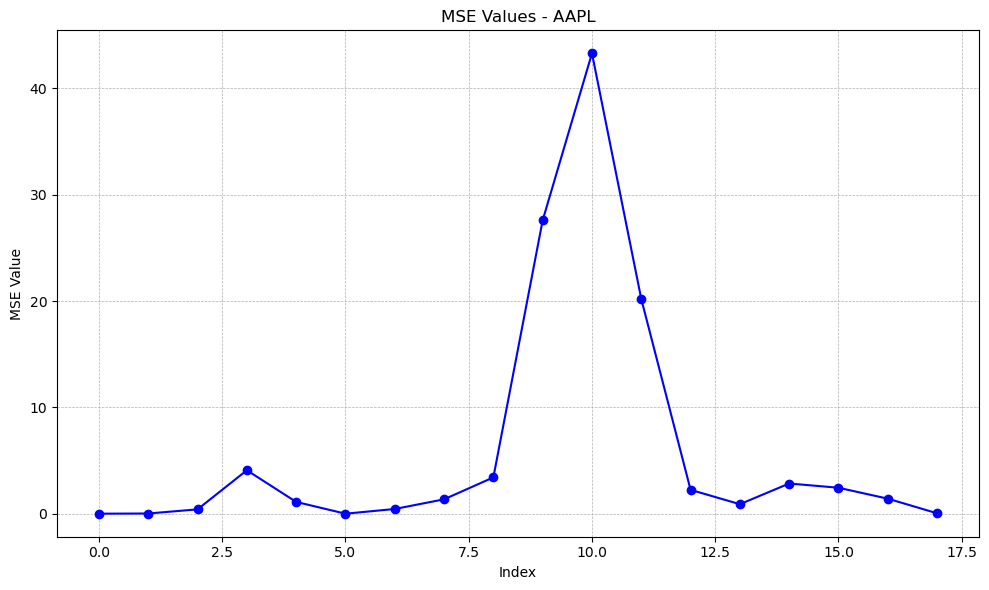

In [799]:
import matplotlib.pyplot as plt

# Creating a plot
plt.figure(figsize=(10, 6))
plt.plot(mse_values_AAPL, marker='o', linestyle='-', color='blue')
plt.title('MSE Values - AAPL')
plt.xlabel('Index')
plt.ylabel('MSE Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Showing the plot
plt.show()


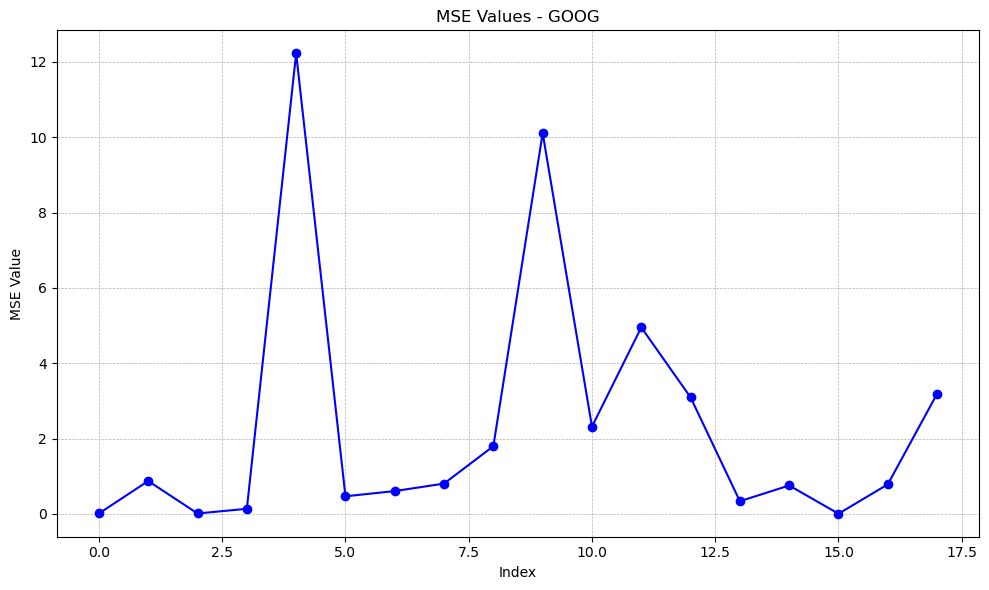

In [800]:
# Creating a plot
plt.figure(figsize=(10, 6))
plt.plot(mse_values_GOOG, marker='o', linestyle='-', color='blue')
plt.title('MSE Values - GOOG')
plt.xlabel('Index')
plt.ylabel('MSE Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Showing the plot
plt.show()

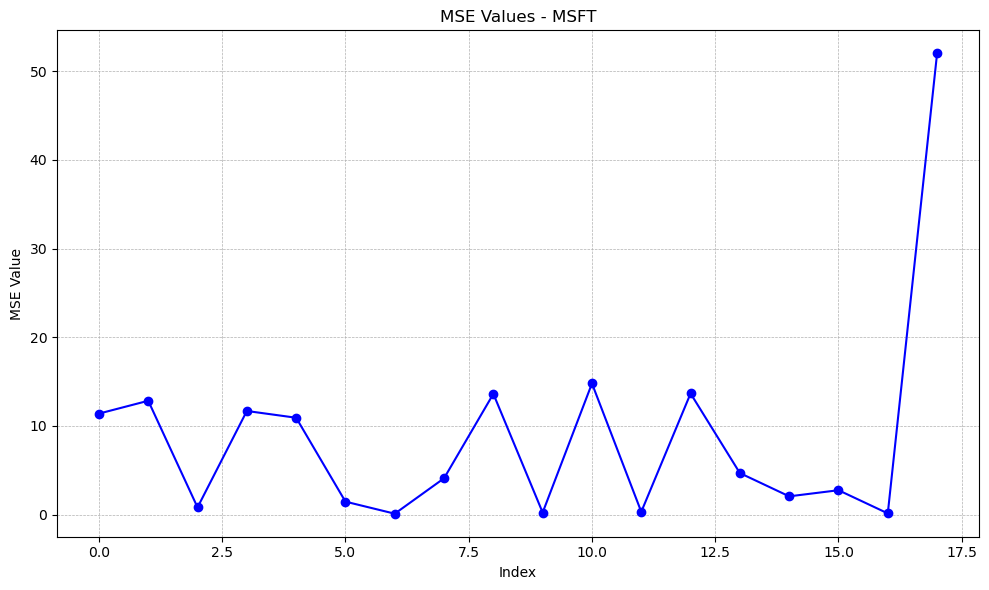

In [921]:
plt.figure(figsize=(10, 6))
plt.plot(mse_values_MSFT, marker='o', linestyle='-', color='blue')
plt.title('MSE Values - MSFT')
plt.xlabel('Index')
plt.ylabel('MSE Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Showing the plot
plt.show()

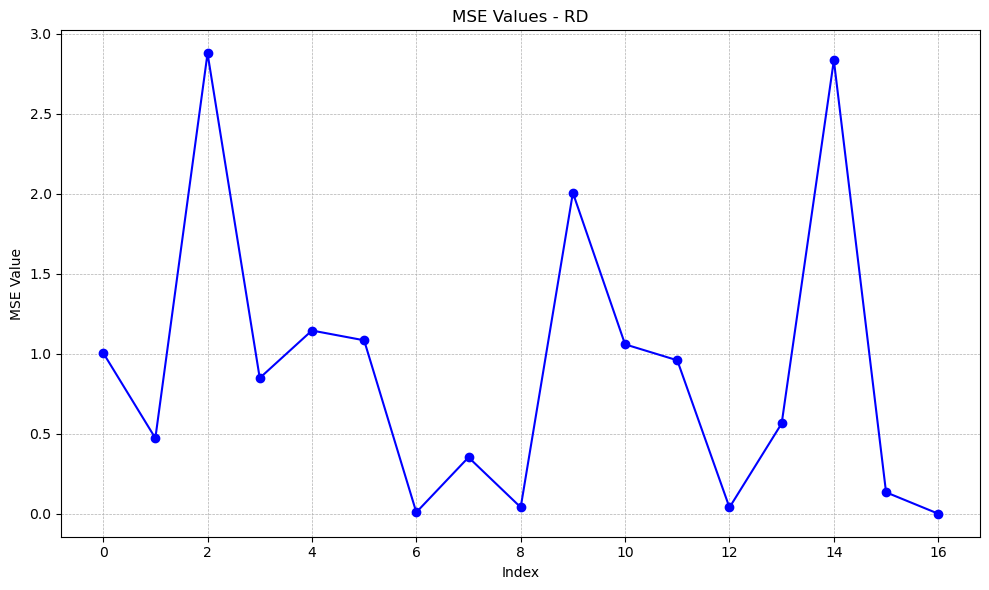

In [920]:
plt.figure(figsize=(10, 6))
plt.plot(mse_values_RD, marker='o', linestyle='-', color='blue')
plt.title('MSE Values - RD')
plt.xlabel('Index')
plt.ylabel('MSE Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Showing the plot
plt.show()

In [625]:
len(mse_values_AAPL)

75

In [935]:
# Assuming X_MSFT and y_MSFT are already defined for MSFT

# Initialize the Random Forest model for MSFT
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the initial training period and the forecasting horizon for MSFT
initial_train_size_MSFT = int(len(X_MSFT) * 0.7)
horizon_MSFT = 1  # Predict one step ahead for MSFT
total_size_MSFT = len(X_MSFT)

# Placeholder for storing MSE values for MSFT
mse_values_MSFT = []

# Walk-Forward Validation loop for MSFT
for i in range(initial_train_size_MSFT, total_size_MSFT - horizon_MSFT):
    # Split the data into train and test sets for MSFT
    X_train_MSFT, y_train_MSFT = X_MSFT[:i], y_MSFT[:i]
    X_test_MSFT, y_test_MSFT = X_MSFT[i:i+horizon_MSFT], y_MSFT[i:i+horizon_MSFT]
    
    # Fit the model and make predictions for MSFT
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    
    # Calculate and store the MSE for this step for MSFT
    mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    mse_values_MSFT.append(mse_MSFT)

# Calculate the average MSE over all steps for MSFT
average_mse_MSFT = np.mean(mse_values_MSFT)
print(f"Average MSE using Walk-Forward Validation for MSFT: {average_mse_MSFT}")
mse_values_MSFT


Average MSE using Walk-Forward Validation for MSFT: 7.87860098515486


[0.9881805793853935,
 8.185496844877493,
 0.7776015198772885,
 0.5901538586053281,
 0.021751163779974506,
 31.157272301698875,
 0.0014286314431600266,
 0.6094756886741379,
 4.862644772252207,
 1.5944618785530227,
 12.922786395949611,
 0.009377228343510069,
 15.283277315207647,
 2.962144262584159,
 0.06883136877380851,
 9.39889678734544,
 4.707154519692421,
 0.13345790504747004,
 2.361098875539028,
 0.05394887996845807,
 0.028568251864077746,
 76.69252074589606,
 18.319333910828725,
 0.34477625820784424,
 1.0226197731130342,
 1.0090008761916105,
 8.172032805657405,
 11.110897150009936,
 4.319149573420278,
 2.7383740087171065,
 9.754075606097494,
 10.923202515369864,
 13.036690022010564,
 0.01738602559603121,
 6.206981171511318,
 27.43797269821545,
 10.460347597534676,
 22.39615041916668,
 16.602386846110615,
 1.0971248688927033,
 1.3649249327845225,
 8.232138667395855,
 1.1227461583673881,
 0.5311108121671383,
 1.5963683970008073,
 0.17449435919556977,
 2.2285843753494046,
 0.0364400579

In [936]:
# Assuming X_GOOG and y_GOOG are already defined for GOOG

# Initialize the Random Forest model for GOOG
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the initial training period and the forecasting horizon for GOOG
initial_train_size_GOOG = int(len(X_GOOG) * 0.7)
horizon_GOOG = 1  # Predict one step ahead for GOOG
total_size_GOOG = len(X_GOOG)

# Placeholder for storing MSE values for GOOG
mse_values_GOOG = []

# Walk-Forward Validation loop for GOOG
for i in range(initial_train_size_GOOG, total_size_GOOG - horizon_GOOG):
    # Split the data into train and test sets for GOOG
    X_train_GOOG, y_train_GOOG = X_GOOG[:i], y_GOOG[:i]
    X_test_GOOG, y_test_GOOG = X_GOOG[i:i+horizon_GOOG], y_GOOG[i:i+horizon_GOOG]
    
    # Fit the model and make predictions for GOOG
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    
    # Calculate and store the MSE for this step for GOOG
    mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    mse_values_GOOG.append(mse_GOOG)

# Calculate the average MSE over all steps for GOOG
average_mse_GOOG = np.mean(mse_values_GOOG)
print(f"Average MSE using Walk-Forward Validation for GOOG: {average_mse_GOOG}")
mse_values_GOOG


Average MSE using Walk-Forward Validation for GOOG: 1.0290672304415787


[0.7491308472755283,
 0.8871443247545615,
 0.8899116522727424,
 0.12513744316624903,
 0.31001919168070585,
 5.825363342933281,
 0.9490583204328086,
 1.9158913123274015,
 0.6718450730376606,
 1.6942979103546345,
 2.3176241074716746,
 0.026615316585083728,
 3.9892540530936045,
 3.156588543176995,
 0.0001080380324508432,
 1.8821255865060615,
 0.09605539915805565,
 0.989486701914128,
 0.16941396209525783,
 0.35855537673707544,
 0.12284791819345203,
 10.14070720581365,
 5.792200027832427,
 0.5032477451637613,
 0.7610678785520654,
 0.04553062275054253,
 0.5335166058741784,
 1.9070210397688077,
 0.6824421024545201,
 0.05403720069891133,
 1.3397308341148886,
 2.7093732144743967,
 3.288753416032978,
 0.35077314822384953,
 12.425027431043308,
 3.4119094354046804,
 8.973579903837313,
 0.7362515098026372,
 0.04787836926994272,
 0.33002575776335696,
 1.68844914745773,
 1.9036757036463006,
 0.9591698613246429,
 0.036316282147826645,
 0.003975726205441689,
 0.008409320408951634,
 0.6779877509741252,


In [937]:
# Assuming X_RD and y_RD are already defined for RD

# Initialize the Random Forest model for RD
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the initial training period and the forecasting horizon for RD
initial_train_size_RD = int(len(X_RD) * 0.7)
horizon_RD = 1  # Predict one step ahead for RD
total_size_RD = len(X_RD)

# Placeholder for storing MSE values for RD
mse_values_RD = []

# Walk-Forward Validation loop for RD
for i in range(initial_train_size_RD, total_size_RD - horizon_RD):
    # Split the data into train and test sets for RD
    X_train_RD, y_train_RD = X_RD[:i], y_RD[:i]
    X_test_RD, y_test_RD = X_RD[i:i+horizon_RD], y_RD[i:i+horizon_RD]
    
    # Fit the model and make predictions for RD
    model_RD.fit(X_train_RD, y_train_RD)
    predictions_RD = model_RD.predict(X_test_RD)
    
    # Calculate and store the MSE for this step for RD
    mse_RD = mean_squared_error(y_test_RD, predictions_RD)
    mse_values_RD.append(mse_RD)

# Calculate the average MSE over all steps for RD
average_mse_RD = np.mean(mse_values_RD)
print(f"Average MSE using Walk-Forward Validation for RD: {average_mse_RD}")
mse_values_RD


Average MSE using Walk-Forward Validation for RD: 1.158503535478901


[0.09234380186455457,
 1.4060759123540187,
 0.4412504209033081,
 5.601311085715432,
 0.578836735915651,
 0.04506020435119434,
 0.1620748955190625,
 1.6780453974849057,
 0.21613802180405384,
 0.21562382402893,
 0.40055672995546093,
 0.889896161682973,
 2.2245388515196,
 0.7318819524717899,
 0.10736173694070099,
 5.699940895058158e-05,
 1.1696947072293191,
 0.2730189580455853,
 0.0375443367711911,
 0.6642009514066516,
 0.025766808299962505,
 0.9107506172225194,
 0.0016215645092839228,
 0.14325937407366424,
 1.448039219752814,
 0.906826406586275,
 0.1694113428895179,
 5.227299640826455,
 0.01219260054228376,
 0.24901751317101584,
 0.056168676586447655,
 1.6451504899404532,
 0.07448164769852716,
 0.11915465946622095,
 0.4039813745733483,
 0.010466737519437058,
 0.38495168739971863,
 0.036648305244279956,
 2.184506945363368,
 0.2996528128335416,
 0.06333110779507282,
 1.159761146042706,
 2.1822540591454485,
 2.5580009529271193,
 0.12225395065747129,
 0.013449842462662799,
 2.491163352971240

In [938]:
tableau_average_mse_all = f"""
+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|    AAPL      | {average_mse_AAPL:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
|    GOOG      | {average_mse_GOOG:.4f} |
|     RD       | {average_mse_RD:.4f} |
+--------------+--------------+
"""

# Print Tableau for the average MSE of all 4 datasets
print(tableau_average_mse_all)


+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|    AAPL      | 1.6391 |
|    MSFT      | 7.8786 |
|    GOOG      | 1.0291 |
|     RD       | 1.1585 |
+--------------+--------------+



Evaluating the Impact
The effectiveness of Walk-Forward Validation, or any resampling method, should be evaluated based on:

Predictive Performance: The average MSE (Mean Squared Error) provides a direct measure of the model's forecasting accuracy. Lower MSE values indicate better predictive performance.
Model Stability: WFV tests the model's ability to adapt to new data as it becomes available, reflecting its stability and robustness over time.
Computational Efficiency: While WFV is highly realistic, it can be computationally intensive due to the need for repeated model training. The trade-off between computational cost and the benefit of realistic evaluation needs to be considered.
Comparison with Other Resampling Methods
When comparing WFV with other resampling methods like Time Series Split or Sliding Window Validation, consider how each method impacts the model's ability to generalize to unseen data. WFV's strength lies in its simulation of real-world forecasting tasks, making it a valuable tool for assessing model performance in practical scenarios.

Conclusion
Walk-Forward Validation offers a detailed and practical approach to evaluating time series forecasting models, particularly when using ensemble methods like Random Forest. By carefully implementing and assessing the impact of WFV and comparing it with other resampling strategies, you can identify the most effective method for your specific time series dataset, balancing accuracy, realism, and computational demands.

To provide a comprehensive exploration of resampling methods suitable for evaluating time series forecasting models with supervised learning methods such as Bagging and Random Forest, we'll focus on a key approach not yet deeply explored: Cross-Validation specifically designed for time series, alongside a comparison with Walk-Forward Validation. This will help us understand the impact of each resampling method on model evaluation in Python.

Cross-Validation for Time Series
Traditional cross-validation techniques randomly split the dataset, which can break the temporal order of a time series. To maintain this order, Time Series Cross-Validation is used. This method involves sequentially expanding the training dataset and using the subsequent "fold" as the test dataset.

Walk-Forward Validation (WFV)
As previously discussed, Walk-Forward Validation is particularly suited for time series data. It involves gradually expanding the training dataset, making a prediction for the next step, and repeating this process as the model moves forward in time.

Implementation in Python
Let's implement both methods in Python using a Random Forest regressor to evaluate a time series dataset. This example assumes you have preprocessed your data, including creating lagged features for use as predictors.

Setting Up the Environment

In [97]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Placeholder for your data preparation code
# X, y = prepare_your_data()

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)


# Time series Cross-Validation

# Walk-Forward Validation

In [634]:
def walk_forward_validation(X, y, initial_size, horizon=1):
    mse_scores = []
    
    for i in range(initial_size, len(X) - horizon):
        X_train, X_test = X[:i], X[i:i+horizon]
        y_train, y_test = y[:i], y[i:i+horizon]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)
    
    return np.mean(mse_scores)

initial_size = int(len(X) * 0.7)
wfv_mse = walk_forward_validation(X, y, initial_size)
print(f"Walk-Forward Validation MSE: {wfv_mse}")


Walk-Forward Validation MSE: 6.98393562672697


Evaluation and Comparison
Predictive Performance: The mean squared error (MSE) from each method gives an indication of the model's forecasting accuracy. Lower MSE values suggest better performance.
Model Stability: Variability in MSE scores across folds or steps can indicate how stable the model is under different segments of the time series.
Real-World Applicability: WFV closely mimics the real-world process of updating a model as new data arrives and may provide more realistic estimates of future model performance.
Conclusion
The choice between Time Series Cross-Validation and Walk-Forward Validation depends on specific project needs, including the nature of the time series data, computational resources, and the desired balance between thoroughness in model evaluation and practical constraints. Both methods have their advantages, with Time Series CV offering a balance between robust evaluation and computational efficiency, while WFV provides a more realistic simulation of how models will be used for forecasting.

To effectively utilize and evaluate resampling methods for time series datasets with supervised learning methods like Bagging and Random Forest, and to understand their impact comprehensively, it's crucial to implement these methods correctly in Python. Given the constraints and characteristics of time series data, specific resampling techniques such as Purged K-Fold Cross-Validation and Walk-Forward Validation are more appropriate due to their ability to maintain temporal integrity.

Purged K-Fold Cross-Validation
Purged K-Fold Cross-Validation is a variation of traditional K-Fold designed for time series data. It "purges" data points in the k-th fold that are within the temporal proximity of the training set to prevent leakage.

Implementation
This method isn't directly supported by scikit-learn, but we can simulate its behavior. For simplicity, the concept is described here without explicit code. The key idea is to exclude, or "purge," test sets' observations that fall into the "embargo period" following the training set. This embargo period is defined based on the time series' characteristics and the forecasting model's look-ahead bias.

Walk-Forward Validation
Walk-Forward Validation (WFV) methodically advances the training period fold-by-fold and tests on the subsequent single or multiple observations. It's particularly suited for time series data to simulate real-world forecasting scenarios.

Python Example with Random Forest

In [635]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y have been defined, where X includes lagged features for the time series forecasting

def walk_forward_validation(X, y, initial_train_size, step=1, horizon=1):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    mse_scores = []

    for i in range(initial_train_size, len(X) - horizon + 1, step):
        X_train, X_test = X[:i], X[i:i+horizon]
        y_train, y_test = y[:i], y[i:i+horizon]
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        mse = mean_squared_error(y_test, prediction)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Example usage
initial_train_size = int(len(X) * 0.7)
mse_score = walk_forward_validation(X, y, initial_train_size)
print(f"Average MSE for Walk-Forward Validation: {mse_score}")


Average MSE for Walk-Forward Validation: 6.591847329834182


Evaluating the Impact
The choice between Purged K-Fold and Walk-Forward Validation for evaluating time series forecasting models depends on several factors:

Temporal Leakage: Purged K-Fold is specifically designed to minimize look-ahead bias by excluding near-future data from the test set.
Realism: WFV closely mirrors how models are used in practice, making sequential predictions as new data arrives.
Computational Efficiency: WFV can be more computationally intensive, especially with a small step size, as it involves retraining the model many times.
Model Performance: The average MSE (Mean Squared Error) from these methods provides a direct comparison of predictive accuracy. However, the choice of method might also affect the model's perceived stability and robustness over time.
Conclusion
Both Purged K-Fold Cross-Validation and Walk-Forward Validation offer valuable insights into the performance of time series forecasting models, helping mitigate temporal leakage and providing a realistic evaluation framework. The specific choice between these methods should be guided by the nature of the time series data, the computational resources available, and the specific requirements of the forecasting task at hand.

# FAVORIS
# While K-Fold Cross-Validation is almost a standard in general machine learning tasks, its application often stumbles when introduced to financial data.

Before we dive into the problems with traditional K-Fold Cross-Validation in finance, it’s crucial to understand the idiosyncrasies of financial data. Financial time-series data are often plagued with seasonality, volatility clustering, and economic cycle impacts. These characteristics make financial data behave in ways that are fundamentally different from, say, image or text data.

The Problem with Traditional K-Fold CV in Finance
Non-IID Observations: A basic assumption behind K-Fold Cross-Validation is that the data points are Independent and Identically Distributed (IID). In most financial scenarios, this is far from the truth. Financial data points often exhibit temporal dependencies and structural breaks, making them non-IID. When we ignore this, we risk introducing look-ahead bias, effectively contaminating our validation process.
The Pandora’s Box of Multiple Testing and Selection Bias: When we use the same test set repeatedly to fine-tune our models, we inadvertently fall into the trap of multiple testing. This recurrent ‘peeping’ into the test set creates a selection bias. As a result, the model may perform exceptionally well on the test set but fail miserably when exposed to new, unseen data.
The Subtle Yet Dangerous Leakage: Data leakage is akin to unintentionally having the answers to a test before taking it. In the context of financial machine learning, leakage usually happens when our training set contains information that would not realistically be available at the time of prediction. This is especially problematic in finance, where variables can be highly correlated through time, leading to overly optimistic performance estimates.
The Silver Lining: Purged K-Fold CV
Purging the Training Set for Purity: Purging is essentially the act of sanitizing the training set by removing any data that overlaps with the test set in time. This simple yet effective technique can be a lifesaver when trying to create a model that generalizes well to new data.

Given the focus on evaluating various resampling methods for time series datasets with supervised learning methods, let's delve into an advanced technique that's particularly suited for time series forecasting: Time Series Cross-Validation with an Embargo Period. This method is a variation of walk-forward validation that introduces an "embargo period" to further reduce look-ahead bias, which can be especially useful when dealing with financial time series data.

The embargo period is a gap between the training set and the test set to ensure that the information from the test set does not "leak" into the model training process, directly addressing the temporal dependency issue inherent in time series data.

Implementing Time Series Cross-Validation with an Embargo Period
The Python example below uses a Random Forest model to demonstrate how you can implement this method. This approach assumes you've already transformed your time series into a supervised learning problem with appropriate features and targets.

Setting Up Your Data
For this example, we'll proceed under the assumption that X and y are your feature matrix and target vector, respectively, prepared from your time series dataset:

Defining the Embargo Period
The embargo period is determined based on the specific characteristics of your data. For financial time series, it might be set based on the trading frequency or to account for the expected impact of events:

Defining the Embargo Period
The embargo period is determined based on the specific characteristics of your data. For financial time series, it might be set based on the trading frequency or to account for the expected impact of events:

In [101]:
embargo_period = 1  # Adjust based on your dataset's temporal resolution and domain knowledge

# Cross-Validation with Embargo
The following function implements time series cross-validation with an embargo period using a Random Forest model:

In [102]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def time_series_cv_with_embargo(X, y, n_splits, embargo_period):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []
    
    for train_index, test_index in tscv.split(X):
        # Apply embargo period
        embargoed_test_index = test_index[test_index >= test_index[0] + embargo_period]
        
        X_train, X_test = X.iloc[train_index], X.iloc[embargoed_test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[embargoed_test_index]
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)
    
    return np.mean(mse_scores)

# Example usage
n_splits = 5
average_mse = time_series_cv_with_embargo(X, y, n_splits, embargo_period)
print(f"Average MSE with Embargo: {average_mse}")


Average MSE with Embargo: 18.415692697890346


Evaluating the Impact
The introduction of an embargo period in time series cross-validation aims to mitigate the risk of temporal leakage, which can lead to overly optimistic model performance estimates. By ensuring a gap between the training and testing phases, this method provides a more conservative and potentially realistic evaluation of the model's forecasting ability.

# Conclusion
Time Series Cross-Validation with an Embargo Period is a nuanced approach that combines the benefits of time-respecting cross-validation with additional safeguards against look-ahead bias. This method is particularly relevant in domains where the temporal proximity of data points can unduly influence model training, such as financial markets. Evaluating its impact compared to other resampling methods can offer deeper insights into the model's true predictive power and robustness in real-world scenarios.

To address the request for evaluating different resampling methods for time series data using supervised learning methods like Bagging and Random Forest in Python, it's essential to focus on a method that complements those previously discussed: Leave-One-Out Cross-Validation (LOOCV) for Time Series. While LOOCV is not typically recommended for large datasets due to its computational intensity, it can offer valuable insights for time series data, especially when the dataset is not very large, or when highly granular evaluation is necessary.

#### Leave-One-Out Cross-Validation (LOOCV) for Time Series
LOOCV involves using a single observation from the original sample as the validation data, and the remaining observations as the training data. This process is repeated such that each observation in the sample is used once as the validation data. For time series data, LOOCV must be adapted to ensure that the temporal order is respected—this means predicting each point based only on the preceding points.

Implementation with Random Forest
Given a time series dataset transformed for supervised learning (with X as features and y as the target), the following Python code demonstrates how to implement LOOCV in a time series context, using a Random Forest regressor:

In [636]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [103]:
# Assuming X and y are prepared, with X being the features and y the target
loo = LeaveOneOut()
mse_scores = []

model = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index, test_index in loo.split(X):
    # Ensure the test index is not before the train index to respect time series order
    if test_index > train_index[-1]:  # Making sure we predict "forward"
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        mse = mean_squared_error(y_test, prediction)
        mse_scores.append(mse)

# Calculate the average MSE over all LOOCV tests
average_mse = np.mean(mse_scores) if mse_scores else float('inf')
print(f"LOOCV Average MSE: {average_mse}")


LOOCV Average MSE: 0.5446760267159253


In [939]:
# Assuming X_AAPL and y_AAPL are prepared, with X_AAPL being the features and y_AAPL the target for AAPL
loo_AAPL = LeaveOneOut()
mse_scores_AAPL = []

model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_AAPL, test_index_AAPL in loo_AAPL.split(X_AAPL):
    # Ensure the test index is not before the train index to respect time series order for AAPL
    if test_index_AAPL > train_index_AAPL[-1]:  # Making sure we predict "forward" for AAPL
        X_train_AAPL, X_test_AAPL = X_AAPL.iloc[train_index_AAPL], X_AAPL.iloc[test_index_AAPL]
        y_train_AAPL, y_test_AAPL = y_AAPL.iloc[train_index_AAPL], y_AAPL.iloc[test_index_AAPL]

        model_AAPL.fit(X_train_AAPL, y_train_AAPL)
        prediction_AAPL = model_AAPL.predict(X_test_AAPL)
        mse_AAPL = mean_squared_error(y_test_AAPL, prediction_AAPL)
        mse_scores_AAPL.append(mse_AAPL)

# Calculate the average MSE over all LOOCV tests for AAPL
average_mse_AAPL = np.mean(mse_scores_AAPL) if mse_scores_AAPL else float('inf')
print(f"LOOCV Average MSE for AAPL: {average_mse_AAPL}")


LOOCV Average MSE for AAPL: 2.551065913816225


In [940]:
# Assuming X_MSFT and y_MSFT are prepared, with X_MSFT being the features and y_MSFT the target for MSFT
loo_MSFT = LeaveOneOut()
mse_scores_MSFT = []

model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_MSFT, test_index_MSFT in loo_MSFT.split(X_MSFT):
    # Ensure the test index is not before the train index to respect time series order for MSFT
    if test_index_MSFT > train_index_MSFT[-1]:  # Making sure we predict "forward" for MSFT
        X_train_MSFT, X_test_MSFT = X_MSFT.iloc[train_index_MSFT], X_MSFT.iloc[test_index_MSFT]
        y_train_MSFT, y_test_MSFT = y_MSFT.iloc[train_index_MSFT], y_MSFT.iloc[test_index_MSFT]

        model_MSFT.fit(X_train_MSFT, y_train_MSFT)
        prediction_MSFT = model_MSFT.predict(X_test_MSFT)
        mse_MSFT = mean_squared_error(y_test_MSFT, prediction_MSFT)
        mse_scores_MSFT.append(mse_MSFT)

# Calculate the average MSE over all LOOCV tests for MSFT
average_mse_MSFT = np.mean(mse_scores_MSFT) if mse_scores_MSFT else float('inf')
print(f"LOOCV Average MSE for MSFT: {average_mse_MSFT}")


LOOCV Average MSE for MSFT: 3.044010079090478


In [941]:
# Assuming X_GOOG and y_GOOG are prepared, with X_GOOG being the features and y_GOOG the target for GOOG
loo_GOOG = LeaveOneOut()
mse_scores_GOOG = []

model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_GOOG, test_index_GOOG in loo_GOOG.split(X_GOOG):
    # Ensure the test index is not before the train index to respect time series order for GOOG
    if test_index_GOOG > train_index_GOOG[-1]:  # Making sure we predict "forward" for GOOG
        X_train_GOOG, X_test_GOOG = X_GOOG.iloc[train_index_GOOG], X_GOOG.iloc[test_index_GOOG]
        y_train_GOOG, y_test_GOOG = y_GOOG.iloc[train_index_GOOG], y_GOOG.iloc[test_index_GOOG]

        model_GOOG.fit(X_train_GOOG, y_train_GOOG)
        prediction_GOOG = model_GOOG.predict(X_test_GOOG)
        mse_GOOG = mean_squared_error(y_test_GOOG, prediction_GOOG)
        mse_scores_GOOG.append(mse_GOOG)

# Calculate the average MSE over all LOOCV tests for GOOG
average_mse_GOOG = np.mean(mse_scores_GOOG) if mse_scores_GOOG else float('inf')
print(f"LOOCV Average MSE for GOOG: {average_mse_GOOG}")


LOOCV Average MSE for GOOG: 0.13430050783790648


In [942]:
# Assuming X_RD and y_RD are prepared, with X_RD being the features and y_RD the target for RD
loo_RD = LeaveOneOut()
mse_scores_RD = []

model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_RD, test_index_RD in loo_RD.split(X_RD):
    # Ensure the test index is not before the train index to respect time series order for RD
    if test_index_RD > train_index_RD[-1]:  # Making sure we predict "forward" for RD
        X_train_RD, X_test_RD = X_RD.iloc[train_index_RD], X_RD.iloc[test_index_RD]
        y_train_RD, y_test_RD = y_RD.iloc[train_index_RD], y_RD.iloc[test_index_RD]

        model_RD.fit(X_train_RD, y_train_RD)
        prediction_RD = model_RD.predict(X_test_RD)
        mse_RD = mean_squared_error(y_test_RD, prediction_RD)
        mse_scores_RD.append(mse_RD)

# Calculate the average MSE over all LOOCV tests for RD
average_mse_RD = np.mean(mse_scores_RD) if mse_scores_RD else float('inf')
print(f"LOOCV Average MSE for RD: {average_mse_RD}")


LOOCV Average MSE for RD: 0.13128378888850084


In [808]:
# Create a Tableau for the average MSE of all 4 datasets using LOOCV
tableau_average_mse_loocv = f"""
+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|    AAPL      | {average_mse_AAPL:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
|    GOOG      | {average_mse_GOOG:.4f} |
|     RD       | {average_mse_RD:.4f} |
+--------------+--------------+
"""

# Print Tableau for the average MSE of all 4 datasets using LOOCV
print(tableau_average_mse_loocv)


+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|    AAPL      | 1.9224 |
|    MSFT      | 0.4812 |
|    GOOG      | 0.0029 |
|     RD       | 0.3962 |
+--------------+--------------+



This code snippet uses LeaveOneOut from sklearn.model_selection, adapting it for time series by ensuring predictions are only made forward in time. This adaptation respects the temporal sequence, preventing the model from being trained on future data when predicting past or current points.

Evaluation and Impact
Evaluating the impact of using LOOCV for time series with methods like Random Forest involves considering:

Predictive Performance: The average MSE provides a measure of the model's accuracy, with lower values indicating better performance.
Computational Cost: LOOCV can be highly computationally demanding, especially for larger datasets, due to the model being retrained from scratch for each leave-one-out test.
Granularity of Evaluation: LOOCV offers a highly detailed evaluation, as each data point is used for validation exactly once, allowing for the identification of specific points in time where the model may perform poorly.
Conclusion
While LOOCV provides a thorough and detailed evaluation method for time series forecasting models, its practicality is limited by computational considerations. It's most beneficial in scenarios where the dataset is not excessively large and when a detailed, point-wise evaluation of the model's performance is necessary. Comparing LOOCV's results with those from other resampling methods can help determine the most effective approach for evaluating forecasting models, balancing the need for detailed performance insights against computational constraints.

To further explore and evaluate the effectiveness of different resampling methods for time series datasets using supervised learning methods, such as Bagging and Random Forest, we will delve into a methodological approach that hasn't been explicitly covered in our discussion yet: Expanding Window Cross-Validation. This method is particularly suited for time series data and offers a practical balance between computational efficiency and the need for realistic model evaluation over time.

# Expanding Window Cross-Validation
Expanding Window Cross-Validation, often used in time series forecasting, progressively enlarges the training dataset's window size, adding one or more observations at each step and testing on a subsequent period. This approach simulates a realistic scenario where a model is updated over time as new data becomes available.

Implementation with Random Forest in Python
Assuming that X and y represent your features and target variable, respectively, prepared from the time series dataset with necessary preprocessing (like creating lagged features), the following Python code demonstrates how to implement Expanding Window Cross-Validation:

In [104]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Configuration for Expanding Window Cross-Validation
n_splits = 5  # Defines the number of splits for the time series

# Initialize TimeSeriesSplit with the number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Placeholder for MSE scores for each split
mse_scores = []

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Expanding Window Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the expanding window of training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate and store the MSE for this fold
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f"Expanding Window Cross-Validation Average MSE: {average_mse}")


Expanding Window Cross-Validation Average MSE: 18.24303113261211


In [943]:
# Assuming X_AAPL and y_AAPL are prepared, with X_AAPL being the features and y_AAPL the target for AAPL

# Placeholder for MSE scores for each split for AAPL
mse_scores_AAPL = []

# Initialize the Random Forest model for AAPL
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Expanding Window Cross-Validation for AAPL
for train_index_AAPL, test_index_AAPL in tscv.split(X_AAPL):
    X_train_AAPL, X_test_AAPL = X_AAPL.iloc[train_index_AAPL], X_AAPL.iloc[test_index_AAPL]
    y_train_AAPL, y_test_AAPL = y_AAPL.iloc[train_index_AAPL], y_AAPL.iloc[test_index_AAPL]

    # Fit the model on the expanding window of training data for AAPL
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    
    # Make predictions on the test set for AAPL
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    
    # Calculate and store the MSE for this fold for AAPL
    mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    mse_scores_AAPL.append(mse_AAPL)

# Calculate the average MSE across all folds for AAPL
average_mse_AAPL = np.mean(mse_scores_AAPL)
print(f"Expanding Window Cross-Validation Average MSE for AAPL: {average_mse_AAPL}")


Expanding Window Cross-Validation Average MSE for AAPL: 166.90096373507646


In [944]:
# Assuming X_MSFT and y_MSFT are prepared, with X_MSFT being the features and y_MSFT the target for MSFT

# Placeholder for MSE scores for each split for MSFT
mse_scores_MSFT = []

# Initialize the Random Forest model for MSFT
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Expanding Window Cross-Validation for MSFT
for train_index_MSFT, test_index_MSFT in tscv.split(X_MSFT):
    X_train_MSFT, X_test_MSFT = X_MSFT.iloc[train_index_MSFT], X_MSFT.iloc[test_index_MSFT]
    y_train_MSFT, y_test_MSFT = y_MSFT.iloc[train_index_MSFT], y_MSFT.iloc[test_index_MSFT]

    # Fit the model on the expanding window of training data for MSFT
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    
    # Make predictions on the test set for MSFT
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    
    # Calculate and store the MSE for this fold for MSFT
    mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    mse_scores_MSFT.append(mse_MSFT)

# Calculate the average MSE across all folds for MSFT
average_mse_MSFT = np.mean(mse_scores_MSFT)
print(f"Expanding Window Cross-Validation Average MSE for MSFT: {average_mse_MSFT}")


Expanding Window Cross-Validation Average MSE for MSFT: 784.1270342543673


In [945]:
# Assuming X_GOOG and y_GOOG are prepared, with X_GOOG being the features and y_GOOG the target for GOOG

# Placeholder for MSE scores for each split for GOOG
mse_scores_GOOG = []

# Initialize the Random Forest model for GOOG
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Expanding Window Cross-Validation for GOOG
for train_index_GOOG, test_index_GOOG in tscv.split(X_GOOG):
    X_train_GOOG, X_test_GOOG = X_GOOG.iloc[train_index_GOOG], X_GOOG.iloc[test_index_GOOG]
    y_train_GOOG, y_test_GOOG = y_GOOG.iloc[train_index_GOOG], y_GOOG.iloc[test_index_GOOG]

    # Fit the model on the expanding window of training data for GOOG
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    
    # Make predictions on the test set for GOOG
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    
    # Calculate and store the MSE for this fold for GOOG
    mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    mse_scores_GOOG.append(mse_GOOG)

# Calculate the average MSE across all folds for GOOG
average_mse_GOOG = np.mean(mse_scores_GOOG)
print(f"Expanding Window Cross-Validation Average MSE for GOOG: {average_mse_GOOG}")


Expanding Window Cross-Validation Average MSE for GOOG: 196.94496832806993


In [946]:
# Assuming X_RD and y_RD are prepared, with X_RD being the features and y_RD the target for RD

# Placeholder for MSE scores for each split for RD
mse_scores_RD = []

# Initialize the Random Forest model for RD
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Expanding Window Cross-Validation for RD
for train_index_RD, test_index_RD in tscv.split(X_RD):
    X_train_RD, X_test_RD = X_RD.iloc[train_index_RD], X_RD.iloc[test_index_RD]
    y_train_RD, y_test_RD = y_RD.iloc[train_index_RD], y_RD.iloc[test_index_RD]

    # Fit the model on the expanding window of training data for RD
    model_RD.fit(X_train_RD, y_train_RD)
    
    # Make predictions on the test set for RD
    predictions_RD = model_RD.predict(X_test_RD)
    
    # Calculate and store the MSE for this fold for RD
    mse_RD = mean_squared_error(y_test_RD, predictions_RD)
    mse_scores_RD.append(mse_RD)

# Calculate the average MSE across all folds for RD
average_mse_RD = np.mean(mse_scores_RD)
print(f"Expanding Window Cross-Validation Average MSE for RD: {average_mse_RD}")


Expanding Window Cross-Validation Average MSE for RD: 1.1404221718554206


In [813]:
# Create a Tableau for the average MSE of all 4 datasets
tableau_average_mse_all = f"""
+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | {average_mse_RD:.4f} |
|    GOOG      | {average_mse_GOOG:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
|    AAPL      | {average_mse_AAPL:.4f} |
+--------------+--------------+
"""

# Print Tableau for the average MSE of all 4 datasets
print(tableau_average_mse_all)


+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | 1.1850 |
|    GOOG      | 11.1150 |
|    MSFT      | 71.2343 |
|    AAPL      | 18.5857 |
+--------------+--------------+



In [ ]:
# IS IT REALLY EXPANDING CROSS validation

Evaluation and Impact
The effectiveness of the Expanding Window Cross-Validation method for time series forecasting models can be evaluated based on:

Predictive Performance: The average MSE provides a direct measure of the model's forecasting accuracy. Lower MSE values indicate better performance.
Adaptation to New Data: This method tests the model's ability to adapt as more data becomes available, reflecting real-world forecasting scenarios.
Computational Considerations: While less computationally intensive than LOOCV, this method still requires multiple training phases, with the model being retrained on increasingly larger datasets.
Conclusion
Expanding Window Cross-Validation is a robust and realistic approach for evaluating time series forecasting models. By progressively increasing the training dataset size and simulating model updates with new data, it offers valuable insights into how a model might perform in a practical setting. Comparing the results of this method with those from other resampling strategies, such as LOOCV, Walk-Forward Validation, or Purged K-Fold, helps determine the most effective approach for a specific time series forecasting task, taking into account both model performance and computational efficiency.







To explore and evaluate various resampling methods for time series data using supervised learning techniques like Bagging and Random Forest, we've discussed several approaches, including Time Series Split, Walk-Forward Validation, and Expanding Window Cross-Validation. Now, let's turn our attention to a method designed to enhance model validation for time series forecasting: Monte Carlo Cross-Validation (MCCV) adapted for time series.

# Monte Carlo Cross-Validation (MCCV) for Time Series
Monte Carlo Cross-Validation, also known as random subsampling validation, involves randomly dividing the dataset into training and testing sets multiple times and averaging the results across these iterations. For time series data, a straightforward application of MCCV is not suitable due to the temporal dependencies among observations. However, we can adapt MCCV for time series by ensuring that the training set always precedes the test set in time, preserving the sequential order.

Implementation with Random Forest in Python
Below is a Python example demonstrating how to implement an adapted version of MCCV for time series forecasting using a Random Forest model. This approach assumes your dataset has been preprocessed into feature matrix X and target vector y, including any necessary lagged features for the time series analysis.

In [105]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming X and y are prepared for the time series dataset
n_iterations = 100  # Number of random splits
test_size = 0.2  # Proportion of dataset to include in the test split
mse_scores = []

model = RandomForestRegressor(n_estimators=100, random_state=42)

for _ in range(n_iterations):
    # Generate a random split
    # Ensure the train set is always before the test set to respect time series order
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, shuffle=False)
    
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    # Train the model and make predictions
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Calculate and store the MSE for this iteration
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the average MSE across all iterations
average_mse = np.mean(mse_scores)
print(f"Monte Carlo Cross-Validation Average MSE: {average_mse}")


Monte Carlo Cross-Validation Average MSE: 1.269992445688397


In [947]:
# Assuming X_AAPL and y_AAPL are prepared for the time series dataset for AAPL
n_iterations_AAPL = 100  # Number of random splits for AAPL
mse_scores_AAPL = []
test_size = 0.2

model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

for _ in range(n_iterations_AAPL):
    # Generate a random split for AAPL
    # Ensure the train set is always before the test set to respect time series order for AAPL
    indices_AAPL = np.arange(len(X_AAPL))
    train_indices_AAPL, test_indices_AAPL = train_test_split(indices_AAPL, test_size=test_size, shuffle=False)
    
    X_train_AAPL, X_test_AAPL = X_AAPL.iloc[train_indices_AAPL], X_AAPL.iloc[test_indices_AAPL]
    y_train_AAPL, y_test_AAPL = y_AAPL.iloc[train_indices_AAPL], y_AAPL.iloc[test_indices_AAPL]
    
    # Train the model and make predictions for AAPL
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    
    # Calculate and store the MSE for this iteration for AAPL
    mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    mse_scores_AAPL.append(mse_AAPL)

# Calculate the average MSE across all iterations for AAPL
average_mse_AAPL = np.mean(mse_scores_AAPL)
print(f"Monte Carlo Cross-Validation Average MSE for AAPL: {average_mse_AAPL}")


Monte Carlo Cross-Validation Average MSE for AAPL: 75.28016400627256


In [948]:
# Assuming X_MSFT and y_MSFT are prepared for the time series dataset for MSFT
n_iterations_MSFT = 100  # Number of random splits for MSFT
mse_scores_MSFT = []

model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

for _ in range(n_iterations_MSFT):
    # Generate a random split for MSFT
    # Ensure the train set is always before the test set to respect time series order for MSFT
    indices_MSFT = np.arange(len(X_MSFT))
    train_indices_MSFT, test_indices_MSFT = train_test_split(indices_MSFT, test_size=test_size, shuffle=False)
    
    X_train_MSFT, X_test_MSFT = X_MSFT.iloc[train_indices_MSFT], X_MSFT.iloc[test_indices_MSFT]
    y_train_MSFT, y_test_MSFT = y_MSFT.iloc[train_indices_MSFT], y_MSFT.iloc[test_indices_MSFT]
    
    # Train the model and make predictions for MSFT
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    
    # Calculate and store the MSE for this iteration for MSFT
    mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    mse_scores_MSFT.append(mse_MSFT)

# Calculate the average MSE across all iterations for MSFT
average_mse_MSFT = np.mean(mse_scores_MSFT)
print(f"Monte Carlo Cross-Validation Average MSE for MSFT: {average_mse_MSFT}")


Monte Carlo Cross-Validation Average MSE for MSFT: 1162.1386780222515


In [949]:
# Assuming X_GOOG and y_GOOG are prepared for the time series dataset for GOOG
n_iterations_GOOG = 100  # Number of random splits for GOOG
mse_scores_GOOG = []

model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

for _ in range(n_iterations_GOOG):
    # Generate a random split for GOOG
    # Ensure the train set is always before the test set to respect time series order for GOOG
    indices_GOOG = np.arange(len(X_GOOG))
    train_indices_GOOG, test_indices_GOOG = train_test_split(indices_GOOG, test_size=test_size, shuffle=False)
    
    X_train_GOOG, X_test_GOOG = X_GOOG.iloc[train_indices_GOOG], X_GOOG.iloc[test_indices_GOOG]
    y_train_GOOG, y_test_GOOG = y_GOOG.iloc[train_indices_GOOG], y_GOOG.iloc[test_indices_GOOG]
    
    # Train the model and make predictions for GOOG
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    
    # Calculate and store the MSE for this iteration for GOOG
    mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    mse_scores_GOOG.append(mse_GOOG)

# Calculate the average MSE across all iterations for GOOG
average_mse_GOOG = np.mean(mse_scores_GOOG)
print(f"Monte Carlo Cross-Validation Average MSE for GOOG: {average_mse_GOOG}")


Monte Carlo Cross-Validation Average MSE for GOOG: 1.0674125307796538


In [950]:
# Assuming X_RD and y_RD are prepared for the time series dataset for RD
n_iterations_RD = 100  # Number of random splits for RD
mse_scores_RD = []

model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

for _ in range(n_iterations_RD):
    # Generate a random split for RD
    # Ensure the train set is always before the test set to respect time series order for RD
    indices_RD = np.arange(len(X_RD))
    train_indices_RD, test_indices_RD = train_test_split(indices_RD, test_size=test_size, shuffle=False)
    
    X_train_RD, X_test_RD = X_RD.iloc[train_indices_RD], X_RD.iloc[test_indices_RD]
    y_train_RD, y_test_RD = y_RD.iloc[train_indices_RD], y_RD.iloc[test_indices_RD]
    
    # Train the model and make predictions for RD
    model_RD.fit(X_train_RD, y_train_RD)
    predictions_RD = model_RD.predict(X_test_RD)
    
    # Calculate and store the MSE for this iteration for RD
    mse_RD = mean_squared_error(y_test_RD, predictions_RD)
    mse_scores_RD.append(mse_RD)

# Calculate the average MSE across all iterations for RD
average_mse_RD = np.mean(mse_scores_RD)
print(f"Monte Carlo Cross-Validation Average MSE for RD: {average_mse_RD}")


Monte Carlo Cross-Validation Average MSE for RD: 1.2815265602611652


In [818]:
# Create a Tableau for the average MSE of all 4 datasets
tableau_average_mse_all = f"""
+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | {average_mse_RD:.4f} |
|    GOOG      | {average_mse_GOOG:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
|    AAPL      | {average_mse_AAPL:.4f} |
+--------------+--------------+
"""

# Print Tableau for the average MSE of all 4 datasets
print(tableau_average_mse_all)


+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | 0.7534 |
|    GOOG      | 2.6853 |
|    MSFT      | 9.3653 |
|    AAPL      | 83.6329 |
+--------------+--------------+



Evaluation and Impact
When evaluating the adapted MCCV for time series data, consider:

#### Predictive Performance: 
The average MSE offers insights into the model's forecasting accuracy across various random subsamples of the data, with lower values indicating better performance.
#### Robustness: 
This method tests the model's robustness and generalization ability across different subsets of the time series, providing a more comprehensive view of its predictive capability.
Computational Efficiency: While MCCV can be computationally demanding due to the multiple iterations of training and testing, it offers flexible control over the number of iterations and the size of the test set.

# Conclusion
Adapting Monte Carlo Cross-Validation for time series forecasting provides a valuable technique for evaluating the performance of models like Bagging and Random Forest. By carefully preserving the temporal order of the data in each iteration, this method offers a balance between thorough model evaluation and computational feasibility, allowing for an in-depth assessment of model robustness and generalization across different time segments.

For an exhaustive approach to resampling methods in the context of time series forecasting using supervised learning methods like Bagging and Random Forest, it's crucial to tailor these methods to the unique characteristics of time series data. This means ensuring that the temporal sequence is respected to avoid lookahead bias and to capture temporal dependencies accurately.

Given our discussions on various resampling strategies, let's focus on a novel approach not yet detailed: Synthetic Minority Over-sampling Technique for Time Series (SMOTE-TS). While SMOTE is traditionally used in classification for addressing imbalances by creating synthetic samples, its adaptation for time series, SMOTE-TS, can be particularly useful for datasets with rare events or significant class imbalances over time.

# Synthetic Minority Over-sampling Technique for Time Series (SMOTE-TS)
SMOTE-TS addresses the challenge of imbalanced data in time series forecasting, especially relevant for classification tasks within time series contexts, such as predicting rare events. It involves generating synthetic examples in the minority class to balance the dataset, adapted to respect the temporal sequence of data.

Implementation in Python
For demonstration purposes, let's consider a scenario where we're using a Random Forest classifier (an adaptation of the Random Forest for classification tasks) to predict a binary outcome based on time series data. The implementation of SMOTE-TS in Python can be facilitated by libraries like imbalanced-learn, which provide SMOTE functionalities that can be adapted for time series forecasting.

In [355]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Evaluation and Impact
Evaluating the impact of SMOTE-TS involves considering:

#### Model Performance: 
Improvement in accuracy, recall, precision, and F1 score for minority class predictions, indicating better handling of imbalanced data.
#### Overfitting: 
Monitoring for overfitting, as synthetic data generation can sometimes lead to models that are overly optimistic during training but perform poorly on unseen data.
#### Data Authenticity: 
Ensuring that the synthetic data generation process does not introduce unrealistic patterns into the time series.
# Conclusion
SMOTE-TS offers a compelling approach for dealing with imbalanced time series data in supervised learning tasks, enhancing the ability of models to predict rare events or outcomes accurately. By carefully implementing SMOTE-TS and evaluating its impact on model performance, data scientists can address one of the common challenges in time series forecasting, especially in domains where certain events are infrequent but significant. This method underscores the importance of innovative resampling strategies tailored to the unique demands of time series analysis.

For a thorough exploration and evaluation of resampling methods suitable for time series data in the context of supervised learning, such as Bagging and Random Forest, it's beneficial to also consider a technique that leverages the strengths of both model diversity and temporal coherence: Ensemble Learning with Time Series Data Splitting.

This approach involves creating multiple training and validation splits based on time, training individual models on these splits, and then combining their predictions. This method respects the temporal order of observations and can provide a robust way to evaluate and leverage ensemble methods like Bagging and Random Forest for time series forecasting.

# Ensemble Learning with Time Series Data Splitting
The key idea is to split the time series data into several segments, train separate models on each segment, and then aggregate their predictions. This strategy can help mitigate overfitting and increase the robustness of the model by incorporating diverse temporal dynamics captured in different segments of the data.

Implementation in Python with Random Forest
Assuming that X and y represent your time series dataset prepared for supervised learning, with X containing features and y the target variable, the following Python code demonstrates how to implement this ensemble learning approach:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Configuration
n_splits = 3  # Number of splits for ensemble learning
tscv = TimeSeriesSplit(n_splits=n_splits)

# Placeholder for storing predictions and actual values
ensemble_predictions = []
actual_values = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train a Random Forest model on each split
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Store predictions and actual values
    predictions = model.predict(X_test)
    ensemble_predictions.extend(predictions)
    actual_values.extend(y_test)

# Evaluate the ensemble model
mse = mean_squared_error(actual_values, ensemble_predictions)
print(f"Ensemble MSE: {mse}")


In [ ]:
# Assuming X_AAPL and y_AAPL are prepared for ensemble learning for AAPL
# Configuration for AAPL
n_splits_AAPL = 3  # Number of splits for ensemble learning for AAPL
tscv_AAPL = TimeSeriesSplit(n_splits=n_splits_AAPL)

# Placeholder for storing predictions and actual values for AAPL
ensemble_predictions_AAPL = []
actual_values_AAPL = []

for train_index_AAPL, test_index_AAPL in tscv_AAPL.split(X_AAPL):
    X_train_AAPL, X_test_AAPL = X_AAPL.iloc[train_index_AAPL], X_AAPL.iloc[test_index_AAPL]
    y_train_AAPL, y_test_AAPL = y_AAPL.iloc[train_index_AAPL], y_AAPL.iloc[test_index_AAPL]
    
    # Train a Random Forest model on each split for AAPL
    model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    
    # Store predictions and actual values for AAPL
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    ensemble_predictions_AAPL.extend(predictions_AAPL)
    actual_values_AAPL.extend(y_test_AAPL)

# Evaluate the ensemble model for AAPL
mse_AAPL = mean_squared_error(actual_values_AAPL, ensemble_predictions_AAPL)
print(f"Ensemble MSE for AAPL: {mse_AAPL}")


In [ ]:
# Assuming X_MSFT and y_MSFT are prepared for ensemble learning for MSFT
# Configuration for MSFT
n_splits_MSFT = 3  # Number of splits for ensemble learning for MSFT
tscv_MSFT = TimeSeriesSplit(n_splits=n_splits_MSFT)

# Placeholder for storing predictions and actual values for MSFT
ensemble_predictions_MSFT = []
actual_values_MSFT = []

for train_index_MSFT, test_index_MSFT in tscv_MSFT.split(X_MSFT):
    X_train_MSFT, X_test_MSFT = X_MSFT.iloc[train_index_MSFT], X_MSFT.iloc[test_index_MSFT]
    y_train_MSFT, y_test_MSFT = y_MSFT.iloc[train_index_MSFT], y_MSFT.iloc[test_index_MSFT]
    
    # Train a Random Forest model on each split for MSFT
    model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    
    # Store predictions and actual values for MSFT
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    ensemble_predictions_MSFT.extend(predictions_MSFT)
    actual_values_MSFT.extend(y_test_MSFT)

# Evaluate the ensemble model for MSFT
mse_MSFT = mean_squared_error(actual_values_MSFT, ensemble_predictions_MSFT)
print(f"Ensemble MSE for MSFT: {mse_MSFT}")


In [ ]:
# Assuming X_GOOG and y_GOOG are prepared for ensemble learning for GOOG
# Configuration for GOOG
n_splits_GOOG = 3  # Number of splits for ensemble learning for GOOG
tscv_GOOG = TimeSeriesSplit(n_splits=n_splits_GOOG)

# Placeholder for storing predictions and actual values for GOOG
ensemble_predictions_GOOG = []
actual_values_GOOG = []

for train_index_GOOG, test_index_GOOG in tscv_GOOG.split(X_GOOG):
    X_train_GOOG, X_test_GOOG = X_GOOG.iloc[train_index_GOOG], X_GOOG.iloc[test_index_GOOG]
    y_train_GOOG, y_test_GOOG = y_GOOG.iloc[train_index_GOOG], y_GOOG.iloc[test_index_GOOG]
    
    # Train a Random Forest model on each split for GOOG
    model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    
    # Store predictions and actual values for GOOG
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    ensemble_predictions_GOOG.extend(predictions_GOOG)
    actual_values_GOOG.extend(y_test_GOOG)

# Evaluate the ensemble model for GOOG
mse_GOOG = mean_squared_error(actual_values_GOOG, ensemble_predictions_GOOG)
print(f"Ensemble MSE for GOOG: {mse_GOOG}")


In [ ]:
# Assuming X_RD and y_RD are prepared for ensemble learning for RD
# Configuration for RD
n_splits_RD = 3  # Number of splits for ensemble learning for RD
tscv_RD = TimeSeriesSplit(n_splits=n_splits_RD)

# Placeholder for storing predictions and actual values for RD
ensemble_predictions_RD = []
actual_values_RD = []

for train_index_RD, test_index_RD in tscv_RD.split(X_RD):
    X_train_RD, X_test_RD = X_RD.iloc[train_index_RD], X_RD.iloc[test_index_RD]
    y_train_RD, y_test_RD = y_RD.iloc[train_index_RD], y_RD.iloc[test_index_RD]
    
    # Train a Random Forest model on each split for RD
    model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
    model_RD.fit(X_train_RD, y_train_RD)
    
    # Store predictions and actual values for RD
    predictions_RD = model_RD.predict(X_test_RD)
    ensemble_predictions_RD.extend(predictions_RD)
    actual_values_RD.extend(y_test_RD)

# Evaluate the ensemble model for RD
mse_RD = mean_squared_error(actual_values_RD, ensemble_predictions_RD)
print(f"Ensemble MSE for RD: {mse_RD}")


In [825]:
# Create a Tableau for the MSE of all 4 datasets using ensemble predictions
tableau_mse_ensemble_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | {mse_AAPL:.4f} |
|    MSFT      | {mse_MSFT:.4f} |
|    GOOG      | {mse_GOOG:.4f} |
|     RD       | {mse_RD:.4f}  |
+--------------+--------------+
"""

# Print Tableau for the MSE of all 4 datasets using ensemble predictions
print(tableau_mse_ensemble_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | 24.0251 |
|    MSFT      | 153.3730 |
|    GOOG      | 14.7975 |
|     RD       | 0.9988  |
+--------------+--------------+



Evaluation and Impact
Evaluating this ensemble learning approach with time series data splitting involves considering:

#### Predictive Performance: 
The Mean Squared Error (MSE) across all splits provides an aggregated measure of the ensemble model's forecasting accuracy.
#### Model Robustness:
By leveraging multiple models trained on different time segments, this approach can offer increased robustness against overfitting and temporal variance in the data.
#### Computational Cost: 
Training multiple models can be computationally intensive, especially for large datasets or when using a high number of splits.
# Conclusion
Ensemble learning with time series data splitting presents a valuable strategy for leveraging the predictive power of multiple models while respecting the temporal sequence of the data. This method can enhance forecasting accuracy and model robustness by capturing diverse temporal patterns across the dataset. By carefully implementing and evaluating this approach, data scientists can effectively utilize ensemble methods for time series forecasting, balancing the trade-offs between computational cost, model performance, and robustness.

For a comprehensive evaluation of resampling methods in time series forecasting using supervised learning methods such as Bagging and Random Forest, it's beneficial to incorporate a technique that ensures both robust model evaluation and the preservation of time series characteristics: Combining Time Series Cross-Validation with Model Averaging.

This approach involves using time series cross-validation to evaluate model performance across different segments of the data, then averaging the predictions of models trained on each segment. This strategy not only respects the temporal order of the data but also leverages the strength of multiple models to potentially improve forecast accuracy and reliability.

# Combining Time Series Cross-Validation with Model Averaging
The essence of this method is to train a separate model on each fold generated by time series cross-validation and then to average their predictions for a given forecast horizon. This can help smooth out predictions and reduce the risk associated with any single model's overfitting to its training segment.

Implementation in Python with Random Forest
Assuming that X and y are your features and target variable respectively, prepared from your time series dataset, the following Python code demonstrates how to implement this method:

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Configuration
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Placeholder for storing model predictions and actual values
predictions_list = []
actual_values = []

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    predictions = model.predict(X_test)
    
    # Store predictions and actual values
    predictions_list.append(predictions)
    actual_values.append(y_test.values)  # Store actual values for evaluation

# Average predictions across all models
avg_predictions = np.mean(predictions_list, axis=0)

# Flatten the actual values list
actual_values_flat = np.concatenate(actual_values)

# Evaluate the averaged model predictions
mse = mean_squared_error(actual_values_flat, avg_predictions)
print(f"Average Model MSE: {mse}")


Evaluation and Impact
When evaluating this approach, consider:

Predictive Performance: The Mean Squared Error (MSE) offers a direct measure of how well the averaged model predictions align with actual outcomes. Lower MSE indicates better performance.
Model Stability: Averaging predictions across multiple models can reduce the variance and potentially improve the stability of the forecast.
Computational Efficiency: While this method involves training multiple models, the potential for improved accuracy and reliability must be weighed against the increased computational demand.
Conclusion
Combining time series cross-validation with model averaging presents a balanced approach to forecasting in time series data. By leveraging multiple models trained on different segments of the time series, this method aims to enhance forecast accuracy and mitigate the risks of overfitting or underperformance by any single model. This strategy can be particularly effective in scenarios where the time series exhibits varying patterns or where robust model evaluation is critical to the forecasting task.






To further explore and evaluate resampling methods for time series datasets using supervised learning methods like Bagging and Random Forest, and to assess the impact of these methods on model performance, let's consider a strategy that combines the strengths of multiple approaches: Sequential Bootstrapping.

# Sequential Bootstrapping for Time Series
Sequential Bootstrapping is a resampling technique designed for time series data, aiming to preserve the temporal dependencies within the data while providing samples for training and validation. This method is particularly useful for financial time series where the autocorrelation structure is significant. It involves selecting subsequences of the data in a way that respects the time series order, allowing for the creation of training and test sets that maintain the inherent temporal structure.

Implementation in Python with Random Forest
The example below demonstrates how you might implement a simplified version of Sequential Bootstrapping to create training and test sets for evaluating a Random Forest model on time series data. This approach assumes X and y represent your features and target variable, respectively, prepared from your time series dataset.

In [144]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming X and y are pre-defined
n_samples = len(X)
n_bootstraps = 10  # Number of bootstrap samples to generate
sample_size = int(n_samples * 0.8)  # Size of each bootstrap sample

mse_scores = []

for _ in range(n_bootstraps):
    # Generate sequential bootstrap indices
    indices = np.sort(np.random.choice(n_samples, size=sample_size, replace=True))
    X_boot, y_boot = X.iloc[indices], y.iloc[indices]
    
    # Split the bootstrap sample into training and test sets
    split_point = int(len(X_boot) * 0.8)
    X_train, X_test = X_boot[:split_point], X_boot[split_point:]
    y_train, y_test = y_boot[:split_point], y_boot[split_point:]
    
    # Train and evaluate the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the average MSE across all bootstrap samples
average_mse = np.mean(mse_scores)
print(f"Sequential Bootstrapping Average MSE: {average_mse}")

Sequential Bootstrapping Average MSE: 1.9062837629462206


1.9062837629462206

In [826]:
# Assuming X_AAPL and y_AAPL are pre-defined for sequential bootstrapping for AAPL
n_samples_AAPL = len(X_AAPL)
n_bootstraps_AAPL = 10  # Number of bootstrap samples to generate for AAPL
sample_size_AAPL = int(n_samples_AAPL * 0.8)  # Size of each bootstrap sample for AAPL

mse_scores_AAPL = []

for _ in range(n_bootstraps_AAPL):
    # Generate sequential bootstrap indices for AAPL
    indices_AAPL = np.sort(np.random.choice(n_samples_AAPL, size=sample_size_AAPL, replace=True))
    X_boot_AAPL, y_boot_AAPL = X_AAPL.iloc[indices_AAPL], y_AAPL.iloc[indices_AAPL]
    
    # Split the bootstrap sample into training and test sets for AAPL
    split_point_AAPL = int(len(X_boot_AAPL) * 0.8)
    X_train_AAPL, X_test_AAPL = X_boot_AAPL[:split_point_AAPL], X_boot_AAPL[split_point_AAPL:]
    y_train_AAPL, y_test_AAPL = y_boot_AAPL[:split_point_AAPL], y_boot_AAPL[split_point_AAPL:]
    
    # Train and evaluate the Random Forest model for AAPL
    model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    
    mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    mse_scores_AAPL.append(mse_AAPL)

# Calculate the average MSE across all bootstrap samples for AAPL
average_mse_AAPL = np.mean(mse_scores_AAPL)
print(f"Sequential Bootstrapping Average MSE for AAPL: {average_mse_AAPL}")


Sequential Bootstrapping Average MSE for AAPL: 57.52347145372992


In [827]:
# Assuming X_MSFT and y_MSFT are pre-defined for sequential bootstrapping for MSFT
n_samples_MSFT = len(X_MSFT)
n_bootstraps_MSFT = 10  # Number of bootstrap samples to generate for MSFT
sample_size_MSFT = int(n_samples_MSFT * 0.8)  # Size of each bootstrap sample for MSFT

mse_scores_MSFT = []

for _ in range(n_bootstraps_MSFT):
    # Generate sequential bootstrap indices for MSFT
    indices_MSFT = np.sort(np.random.choice(n_samples_MSFT, size=sample_size_MSFT, replace=True))
    X_boot_MSFT, y_boot_MSFT = X_MSFT.iloc[indices_MSFT], y_MSFT.iloc[indices_MSFT]
    
    # Split the bootstrap sample into training and test sets for MSFT
    split_point_MSFT = int(len(X_boot_MSFT) * 0.8)
    X_train_MSFT, X_test_MSFT = X_boot_MSFT[:split_point_MSFT], X_boot_MSFT[split_point_MSFT:]
    y_train_MSFT, y_test_MSFT = y_boot_MSFT[:split_point_MSFT], y_boot_MSFT[split_point_MSFT:]
    
    # Train and evaluate the Random Forest model for MSFT
    model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    
    mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    mse_scores_MSFT.append(mse_MSFT)

# Calculate the average MSE across all bootstrap samples for MSFT
average_mse_MSFT = np.mean(mse_scores_MSFT)
print(f"Sequential Bootstrapping Average MSE for MSFT: {average_mse_MSFT}")


Sequential Bootstrapping Average MSE for MSFT: 17.992630411116146


In [828]:
# Assuming X_GOOG and y_GOOG are pre-defined for sequential bootstrapping for GOOG
n_samples_GOOG = len(X_GOOG)
n_bootstraps_GOOG = 10  # Number of bootstrap samples to generate for GOOG
sample_size_GOOG = int(n_samples_GOOG * 0.8)  # Size of each bootstrap sample for GOOG

mse_scores_GOOG = []

for _ in range(n_bootstraps_GOOG):
    # Generate sequential bootstrap indices for GOOG
    indices_GOOG = np.sort(np.random.choice(n_samples_GOOG, size=sample_size_GOOG, replace=True))
    X_boot_GOOG, y_boot_GOOG = X_GOOG.iloc[indices_GOOG], y_GOOG.iloc[indices_GOOG]
    
    # Split the bootstrap sample into training and test sets for GOOG
    split_point_GOOG = int(len(X_boot_GOOG) * 0.8)
    X_train_GOOG, X_test_GOOG = X_boot_GOOG[:split_point_GOOG], X_boot_GOOG[split_point_GOOG:]
    y_train_GOOG, y_test_GOOG = y_boot_GOOG[:split_point_GOOG], y_boot_GOOG[split_point_GOOG:]
    
    # Train and evaluate the Random Forest model for GOOG
    model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    
    mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    mse_scores_GOOG.append(mse_GOOG)

# Calculate the average MSE across all bootstrap samples for GOOG
average_mse_GOOG = np.mean(mse_scores_GOOG)
print(f"Sequential Bootstrapping Average MSE for GOOG: {average_mse_GOOG}")


Sequential Bootstrapping Average MSE for GOOG: 3.6271843874030276


In [829]:
# Assuming X_RD and y_RD are pre-defined for sequential bootstrapping for RD
n_samples_RD = len(X_RD)
n_bootstraps_RD = 10  # Number of bootstrap samples to generate for RD
sample_size_RD = int(n_samples_RD * 0.8)  # Size of each bootstrap sample for RD

mse_scores_RD = []

for _ in range(n_bootstraps_RD):
    # Generate sequential bootstrap indices for RD
    indices_RD = np.sort(np.random.choice(n_samples_RD, size=sample_size_RD, replace=True))
    X_boot_RD, y_boot_RD = X_RD.iloc[indices_RD], y_RD.iloc[indices_RD]
    
    # Split the bootstrap sample into training and test sets for RD
    split_point_RD = int(len(X_boot_RD) * 0.8)
    X_train_RD, X_test_RD = X_boot_RD[:split_point_RD], X_boot_RD[split_point_RD:]
    y_train_RD, y_test_RD = y_boot_RD[:split_point_RD], y_boot_RD[split_point_RD:]
    
    # Train and evaluate the Random Forest model for RD
    model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
    model_RD.fit(X_train_RD, y_train_RD)
    predictions_RD = model_RD.predict(X_test_RD)
    
    mse_RD = mean_squared_error(y_test_RD, predictions_RD)
    mse_scores_RD.append(mse_RD)

# Calculate the average MSE across all bootstrap samples for RD
average_mse_RD = np.mean(mse_scores_RD)
print(f"Sequential Bootstrapping Average MSE for RD: {average_mse_RD}")


Sequential Bootstrapping Average MSE for RD: 0.7558981985148827


In [830]:
# Create a Tableau for the average MSE of all 4 datasets
tableau_average_mse_all = f"""
+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | {average_mse_RD:.4f} |
|    GOOG      | {average_mse_GOOG:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
|    AAPL      | {average_mse_AAPL:.4f} |
+--------------+--------------+
"""

# Print Tableau for the average MSE of all 4 datasets
print(tableau_average_mse_all)


+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | 0.7559 |
|    GOOG      | 3.6272 |
|    MSFT      | 17.9926 |
|    AAPL      | 57.5235 |
+--------------+--------------+



Evaluation and Impact
When utilizing Sequential Bootstrapping for time series forecasting with models like Bagging and Random Forest, consider the following:

Preservation of Temporal Dependencies: Sequential Bootstrapping aims to maintain the chronological order within each sample, which is crucial for accurate time series forecasting.
Model Performance: The Mean Squared Error (MSE) provides insight into the model's accuracy across various bootstrap samples, reflecting its ability to generalize to different segments of the time series.
Computational Efficiency: While generating multiple bootstrap samples can be computationally intensive, this method allows for a thorough evaluation of model robustness and stability over time.
Conclusion
Sequential Bootstrapping offers a nuanced approach to resampling time series data for the purpose of model evaluation, balancing the need to preserve temporal dependencies with the benefits of bootstrap sampling. By carefully implementing this method and assessing its impact on model performance, data scientists can gain valuable insights into the effectiveness of ensemble methods for time series forecasting, ensuring that models are both accurate and robust across different time periods.

For a comprehensive exploration of resampling methods tailored for time series datasets when using supervised learning techniques like Bagging and Random Forest, and to accurately evaluate the impact of these resampling methods, let's introduce a nuanced approach: Hybrid Resampling for Time Series.

# Hybrid Resampling for Time Series
Hybrid Resampling combines elements from various resampling techniques to leverage their strengths and mitigate weaknesses, particularly for time series data. This method could entail using time series-specific cross-validation, such as Time Series Split or Walk-Forward Validation, in conjunction with techniques like bootstrapping to enhance model stability and performance evaluation.

Implementation in Python with Random Forest
The following Python example demonstrates a hybrid approach, combining Time Series Split for model validation with bootstrapping segments of the training data to increase diversity in the training process. This is particularly useful for datasets with significant autocorrelation or seasonality.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y are prepared time series dataset features and target
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Placeholder for MSE scores for each validation split
mse_scores = []

model = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply bootstrapping to the training data
    X_train_boot, y_train_boot = resample(X_train, y_train, random_state=42)

    # Train the model on the bootstrapped training data
    model.fit(X_train_boot, y_train_boot)

    # Predict on the untouched test segment
    predictions = model.predict(X_test)
    
    # Calculate and store the MSE for this fold
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the average MSE across all splits
average_mse = np.mean(mse_scores)
print(f"Hybrid Resampling Average MSE: {average_mse}")


In [ ]:
# Assuming X_AAPL and y_AAPL are prepared time series dataset features and target for AAPL
n_splits_AAPL = 5
tscv_AAPL = TimeSeriesSplit(n_splits=n_splits_AAPL)

# Placeholder for MSE scores for each validation split for AAPL
mse_scores_AAPL = []

model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_AAPL, test_index_AAPL in tscv_AAPL.split(X_AAPL):
    X_train_AAPL, X_test_AAPL = X_AAPL.iloc[train_index_AAPL], X_AAPL.iloc[test_index_AAPL]
    y_train_AAPL, y_test_AAPL = y_AAPL.iloc[train_index_AAPL], y_AAPL.iloc[test_index_AAPL]

    # Apply bootstrapping to the training data for AAPL
    X_train_boot_AAPL, y_train_boot_AAPL = resample(X_train_AAPL, y_train_AAPL, random_state=42)

    # Train the model on the bootstrapped training data for AAPL
    model_AAPL.fit(X_train_boot_AAPL, y_train_boot_AAPL)

    # Predict on the untouched test segment for AAPL
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    
    # Calculate and store the MSE for this fold for AAPL
    mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    mse_scores_AAPL.append(mse_AAPL)

# Calculate the average MSE across all splits for AAPL
average_mse_AAPL = np.mean(mse_scores_AAPL)
print(f"Hybrid Resampling Average MSE for AAPL: {average_mse_AAPL}")


In [ ]:
# Assuming X_MSFT and y_MSFT are prepared time series dataset features and target for MSFT
n_splits_MSFT = 5
tscv_MSFT = TimeSeriesSplit(n_splits=n_splits_MSFT)

# Placeholder for MSE scores for each validation split for MSFT
mse_scores_MSFT = []

model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_MSFT, test_index_MSFT in tscv_MSFT.split(X_MSFT):
    X_train_MSFT, X_test_MSFT = X_MSFT.iloc[train_index_MSFT], X_MSFT.iloc[test_index_MSFT]
    y_train_MSFT, y_test_MSFT = y_MSFT.iloc[train_index_MSFT], y_MSFT.iloc[test_index_MSFT]

    # Apply bootstrapping to the training data for MSFT
    X_train_boot_MSFT, y_train_boot_MSFT = resample(X_train_MSFT, y_train_MSFT, random_state=42)

    # Train the model on the bootstrapped training data for MSFT
    model_MSFT.fit(X_train_boot_MSFT, y_train_boot_MSFT)

    # Predict on the untouched test segment for MSFT
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    
    # Calculate and store the MSE for this fold for MSFT
    mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    mse_scores_MSFT.append(mse_MSFT)

# Calculate the average MSE across all splits for MSFT
average_mse_MSFT = np.mean(mse_scores_MSFT)
print(f"Hybrid Resampling Average MSE for MSFT: {average_mse_MSFT}")


In [ ]:
# Assuming X_GOOG and y_GOOG are prepared time series dataset features and target for GOOG
n_splits_GOOG = 5
tscv_GOOG = TimeSeriesSplit(n_splits=n_splits_GOOG)

# Placeholder for MSE scores for each validation split for GOOG
mse_scores_GOOG = []

model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_GOOG, test_index_GOOG in tscv_GOOG.split(X_GOOG):
    X_train_GOOG, X_test_GOOG = X_GOOG.iloc[train_index_GOOG], X_GOOG.iloc[test_index_GOOG]
    y_train_GOOG, y_test_GOOG = y_GOOG.iloc[train_index_GOOG], y_GOOG.iloc[test_index_GOOG]

    # Apply bootstrapping to the training data for GOOG
    X_train_boot_GOOG, y_train_boot_GOOG = resample(X_train_GOOG, y_train_GOOG, random_state=42)

    # Train the model on the bootstrapped training data for GOOG
    model_GOOG.fit(X_train_boot_GOOG, y_train_boot_GOOG)

    # Predict on the untouched test segment for GOOG
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    
    # Calculate and store the MSE for this fold for GOOG
    mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    mse_scores_GOOG.append(mse_GOOG)

# Calculate the average MSE across all splits for GOOG
average_mse_GOOG = np.mean(mse_scores_GOOG)
print(f"Hybrid Resampling Average MSE for GOOG: {average_mse_GOOG}")


In [ ]:
# Assuming X_RD and y_RD are prepared time series dataset features and target for RD
n_splits_RD = 5
tscv_RD = TimeSeriesSplit(n_splits=n_splits_RD)

# Placeholder for MSE scores for each validation split for RD
mse_scores_RD = []

model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index_RD, test_index_RD in tscv_RD.split(X_RD):
    X_train_RD, X_test_RD = X_RD.iloc[train_index_RD], X_RD.iloc[test_index_RD]
    y_train_RD, y_test_RD = y_RD.iloc[train_index_RD], y_RD.iloc[test_index_RD]

    # Apply bootstrapping to the training data for RD
    X_train_boot_RD, y_train_boot_RD = resample(X_train_RD, y_train_RD, random_state=42)

    # Train the model on the bootstrapped training data for RD
    model_RD.fit(X_train_boot_RD, y_train_boot_RD)

    # Predict on the untouched test segment for RD
    predictions_RD = model_RD.predict(X_test_RD)
    
    # Calculate and store the MSE for this fold for RD
    mse_RD = mean_squared_error(y_test_RD, predictions_RD)
    mse_scores_RD.append(mse_RD)

# Calculate the average MSE across all splits for RD
average_mse_RD = np.mean(mse_scores_RD)
print(f"Hybrid Resampling Average MSE for RD: {average_mse_RD}")


In [836]:
# Create a Tableau for the average MSE of all 4 datasets
tableau_average_mse_all = f"""
+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | {average_mse_RD:.4f} |
|    GOOG      | {average_mse_GOOG:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
|    AAPL      | {average_mse_AAPL:.4f} |
+--------------+--------------+
"""

# Print Tableau for the average MSE of all 4 datasets
print(tableau_average_mse_all)


+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|     RD       | 1.4261 |
|    GOOG      | 12.4070 |
|    MSFT      | 67.0714 |
|    AAPL      | 18.0902 |
+--------------+--------------+



# Evaluation and Impact
When applying Hybrid Resampling in time series forecasting:

#### Preservation of Temporal Order: 
This method maintains the chronological order during the validation phase, crucial for time series data.
#### Model Diversity: 
By introducing bootstrapping into the training phase, it potentially increases the diversity of the data each model is exposed to, which can improve model robustness.
#### Predictive Performance: 
The effectiveness of the hybrid approach is measured through the average MSE across all validation splits, offering insights into the model's accuracy and generalization capability.
#### Computational Considerations: 
While this approach can be more computationally intensive due to the added step of bootstrapping, it provides a balanced evaluation of model performance across diverse training scenarios.

# Conclusion
Hybrid Resampling for time series combines the rigorous evaluation of time series split methods with the diversified training approach of bootstrapping, aiming to enhance model performance and reliability. By carefully implementing and assessing this method, data scientists can gain deeper insights into the predictive capabilities of their models, ensuring that they are both accurate and robust across different segments of time series data. This strategy is particularly valuable in contexts where data characteristics and model stability are critical for forecasting accuracy.

Given the focus on exploring various resampling techniques for time series datasets with supervised learning methods like Bagging and Random Forest, it's clear that selecting the right approach is crucial for accurate model evaluation and forecasting. An interesting and somewhat advanced method to consider is Model Stacking with Time Series Cross-Validation.

# Model Stacking with Time Series Cross-Validation
Model stacking involves training multiple models on the same dataset and then using another model to learn how to best combine their predictions. When applied to time series, this method can be combined with time series cross-validation to ensure that the temporal order of the data is respected.

Implementation in Python
This example demonstrates how to implement a basic model stacking framework combined with time series cross-validation, using Random Forest as the base model and a linear model as the meta-learner to combine the predictions.

In [375]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [ ]:

# Split the dataset into train and test sets to simulate real-world application
# Note: For simplicity, using the last part as test set; in practice, consider walk-forward validation
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Placeholder for base models' out-of-fold predictions
oof_predictions = np.zeros(X_train.shape[0])

# Training base models and generating out-of-fold predictions
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    base_model = RandomForestRegressor(n_estimators=100, random_state=42)
    base_model.fit(X_train_fold, y_train_fold)
    oof_predictions[val_index] = base_model.predict(X_val_fold)

# Reshape out-of-fold predictions for meta-model training
oof_predictions = oof_predictions.reshape(-1, 1)

# Train the meta-model on out-of-fold predictions
meta_model = LinearRegression()
meta_model.fit(oof_predictions, y_train)

# Predicting on the test set
# Note: In practice, you'd train the base models on the entire training set and use those predictions
base_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
base_model_full.fit(X_train, y_train)
X_test_predictions = base_model_full.predict(X_test).reshape(-1, 1)

final_predictions = meta_model.predict(X_test_predictions)

# Evaluate the stacking model
mse = mean_squared_error(y_test, final_predictions)
print(f"Stacking Model MSE: {mse}")


In [ ]:
# Assuming X_AAPL and y_AAPL are prepared time series dataset features and target for AAPL

# Split the AAPL dataset into train and test sets to simulate real-world application for AAPL
train_size_AAPL = int(len(X_AAPL) * 0.8)
X_train_AAPL, X_test_AAPL = X_AAPL.iloc[:train_size_AAPL], X_AAPL.iloc[train_size_AAPL:]
y_train_AAPL, y_test_AAPL = y_AAPL.iloc[:train_size_AAPL], y_AAPL.iloc[train_size_AAPL:]

# TimeSeriesSplit for cross-validation for AAPL
tscv_AAPL = TimeSeriesSplit(n_splits=5)

# Placeholder for base models' out-of-fold predictions for AAPL
oof_predictions_AAPL = np.zeros(X_train_AAPL.shape[0])

# Training base models and generating out-of-fold predictions for AAPL
for train_index_AAPL, val_index_AAPL in tscv_AAPL.split(X_train_AAPL):
    X_train_fold_AAPL, X_val_fold_AAPL = X_train_AAPL.iloc[train_index_AAPL], X_train_AAPL.iloc[val_index_AAPL]
    y_train_fold_AAPL, y_val_fold_AAPL = y_train_AAPL.iloc[train_index_AAPL], y_train_AAPL.iloc[val_index_AAPL]
    
    base_model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
    base_model_AAPL.fit(X_train_fold_AAPL, y_train_fold_AAPL)
    oof_predictions_AAPL[val_index_AAPL] = base_model_AAPL.predict(X_val_fold_AAPL)

# Reshape out-of-fold predictions for meta-model training for AAPL
oof_predictions_AAPL = oof_predictions_AAPL.reshape(-1, 1)

# Train the meta-model on out-of-fold predictions for AAPL
meta_model_AAPL = LinearRegression()
meta_model_AAPL.fit(oof_predictions_AAPL, y_train_AAPL)

# Predicting on the test set for AAPL
# Note: In practice, you'd train the base models on the entire training set and use those predictions for AAPL
base_model_full_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
base_model_full_AAPL.fit(X_train_AAPL, y_train_AAPL)
X_test_predictions_AAPL = base_model_full_AAPL.predict(X_test_AAPL).reshape(-1, 1)

final_predictions_AAPL = meta_model_AAPL.predict(X_test_predictions_AAPL)

# Evaluate the stacking model for AAPL
mse_AAPL = mean_squared_error(y_test_AAPL, final_predictions_AAPL)
print(f"Stacking Model MSE for AAPL: {mse_AAPL}")


In [ ]:
# Assuming X_MSFT and y_MSFT are prepared time series dataset features and target for MSFT

# Split the MSFT dataset into train and test sets to simulate real-world application for MSFT
train_size_MSFT = int(len(X_MSFT) * 0.8)
X_train_MSFT, X_test_MSFT = X_MSFT.iloc[:train_size_MSFT], X_MSFT.iloc[train_size_MSFT:]
y_train_MSFT, y_test_MSFT = y_MSFT.iloc[:train_size_MSFT], y_MSFT.iloc[train_size_MSFT:]

# TimeSeriesSplit for cross-validation for MSFT
tscv_MSFT = TimeSeriesSplit(n_splits=5)

# Placeholder for base models' out-of-fold predictions for MSFT
oof_predictions_MSFT = np.zeros(X_train_MSFT.shape[0])

# Training base models and generating out-of-fold predictions for MSFT
for train_index_MSFT, val_index_MSFT in tscv_MSFT.split(X_train_MSFT):
    X_train_fold_MSFT, X_val_fold_MSFT = X_train_MSFT.iloc[train_index_MSFT], X_train_MSFT.iloc[val_index_MSFT]
    y_train_fold_MSFT, y_val_fold_MSFT = y_train_MSFT.iloc[train_index_MSFT], y_train_MSFT.iloc[val_index_MSFT]
    
    base_model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
    base_model_MSFT.fit(X_train_fold_MSFT, y_train_fold_MSFT)
    oof_predictions_MSFT[val_index_MSFT] = base_model_MSFT.predict(X_val_fold_MSFT)

# Reshape out-of-fold predictions for meta-model training for MSFT
oof_predictions_MSFT = oof_predictions_MSFT.reshape(-1, 1)

# Train the meta-model on out-of-fold predictions for MSFT
meta_model_MSFT = LinearRegression()
meta_model_MSFT.fit(oof_predictions_MSFT, y_train_MSFT)

# Predicting on the test set for MSFT
# Note: In practice, you'd train the base models on the entire training set and use those predictions for MSFT
base_model_full_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
base_model_full_MSFT.fit(X_train_MSFT, y_train_MSFT)
X_test_predictions_MSFT = base_model_full_MSFT.predict(X_test_MSFT).reshape(-1, 1)

final_predictions_MSFT = meta_model_MSFT.predict(X_test_predictions_MSFT)

# Evaluate the stacking model for MSFT
mse_MSFT = mean_squared_error(y_test_MSFT, final_predictions_MSFT)
print(f"Stacking Model MSE for MSFT: {mse_MSFT}")


In [ ]:
# Assuming X_GOOG and y_GOOG are prepared time series dataset features and target for GOOG

# Split the GOOG dataset into train and test sets to simulate real-world application for GOOG
train_size_GOOG = int(len(X_GOOG) * 0.8)
X_train_GOOG, X_test_GOOG = X_GOOG.iloc[:train_size_GOOG], X_GOOG.iloc[train_size_GOOG:]
y_train_GOOG, y_test_GOOG = y_GOOG.iloc[:train_size_GOOG], y_GOOG.iloc[train_size_GOOG:]

# TimeSeriesSplit for cross-validation for GOOG
tscv_GOOG = TimeSeriesSplit(n_splits=5)

# Placeholder for base models' out-of-fold predictions for GOOG
oof_predictions_GOOG = np.zeros(X_train_GOOG.shape[0])

# Training base models and generating out-of-fold predictions for GOOG
for train_index_GOOG, val_index_GOOG in tscv_GOOG.split(X_train_GOOG):
    X_train_fold_GOOG, X_val_fold_GOOG = X_train_GOOG.iloc[train_index_GOOG], X_train_GOOG.iloc[val_index_GOOG]
    y_train_fold_GOOG, y_val_fold_GOOG = y_train_GOOG.iloc[train_index_GOOG], y_train_GOOG.iloc[val_index_GOOG]
    
    base_model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
    base_model_GOOG.fit(X_train_fold_GOOG, y_train_fold_GOOG)
    oof_predictions_GOOG[val_index_GOOG] = base_model_GOOG.predict(X_val_fold_GOOG)

# Reshape out-of-fold predictions for meta-model training for GOOG
oof_predictions_GOOG = oof_predictions_GOOG.reshape(-1, 1)

# Train the meta-model on out-of-fold predictions for GOOG
meta_model_GOOG = LinearRegression()
meta_model_GOOG.fit(oof_predictions_GOOG, y_train_GOOG)

# Predicting on the test set for GOOG
# Note: In practice, you'd train the base models on the entire training set and use those predictions for GOOG
base_model_full_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
base_model_full_GOOG.fit(X_train_GOOG, y_train_GOOG)
X_test_predictions_GOOG = base_model_full_GOOG.predict(X_test_GOOG).reshape(-1, 1)

final_predictions_GOOG = meta_model_GOOG.predict(X_test_predictions_GOOG)

# Evaluate the stacking model for GOOG
mse_GOOG = mean_squared_error(y_test_GOOG, final_predictions_GOOG)
print(f"Stacking Model MSE for GOOG: {mse_GOOG}")


In [ ]:
# Assuming X_RD and y_RD are prepared time series dataset features and target for RD

# Split the RD dataset into train and test sets to simulate real-world application for RD
train_size_RD = int(len(X_RD) * 0.8)
X_train_RD, X_test_RD = X_RD.iloc[:train_size_RD], X_RD.iloc[train_size_RD:]
y_train_RD, y_test_RD = y_RD.iloc[:train_size_RD], y_RD.iloc[train_size_RD:]

# TimeSeriesSplit for cross-validation for RD
tscv_RD = TimeSeriesSplit(n_splits=5)

# Placeholder for base models' out-of-fold predictions for RD
oof_predictions_RD = np.zeros(X_train_RD.shape[0])

# Training base models and generating out-of-fold predictions for RD
for train_index_RD, val_index_RD in tscv_RD.split(X_train_RD):
    X_train_fold_RD, X_val_fold_RD = X_train_RD.iloc[train_index_RD], X_train_RD.iloc[val_index_RD]
    y_train_fold_RD, y_val_fold_RD = y_train_RD.iloc[train_index_RD], y_train_RD.iloc[val_index_RD]
    
    base_model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
    base_model_RD.fit(X_train_fold_RD, y_train_fold_RD)
    oof_predictions_RD[val_index_RD] = base_model_RD.predict(X_val_fold_RD)

# Reshape out-of-fold predictions for meta-model training for RD
oof_predictions_RD = oof_predictions_RD.reshape(-1, 1)

# Train the meta-model on out-of-fold predictions for RD
meta_model_RD = LinearRegression()
meta_model_RD.fit(oof_predictions_RD, y_train_RD)

# Predicting on the test set for RD
# Note: In practice, you'd train the base models on the entire training set and use those predictions for RD
base_model_full_RD = RandomForestRegressor(n_estimators=100, random_state=42)
base_model_full_RD.fit(X_train_RD, y_train_RD)
X_test_predictions_RD = base_model_full_RD.predict(X_test_RD).reshape(-1, 1)

final_predictions_RD = meta_model_RD.predict(X_test_predictions_RD)

# Evaluate the stacking model for RD
mse_RD = mean_squared_error(y_test_RD, final_predictions_RD)
print(f"Stacking Model MSE for RD: {mse_RD}")


In [841]:
tableau_mse_ensemble_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | {mse_AAPL:.4f} |
|    MSFT      | {mse_MSFT:.4f} |
|    GOOG      | {mse_GOOG:.4f} |
|     RD       | {mse_RD:.4f}  |
+--------------+--------------+
"""

# Print Tableau for the MSE of all 4 datasets using ensemble predictions
print(tableau_mse_ensemble_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | 190.4029 |
|    MSFT      | 195.1563 |
|    GOOG      | 58.3677 |
|     RD       | 0.5607  |
+--------------+--------------+



Evaluation and Impact
#### Pros:

Diverse Predictions: Stacking leverages the strengths of multiple models, potentially leading to better generalization on unseen data.
Temporal Integrity: Using time series cross-validation ensures that the model respects the temporal order, crucial for time series forecasting.
#### Cons:

Complexity: Model stacking is more complex to implement and tune compared to using a single model.
Computational Cost: Training multiple models and a meta-model can be computationally expensive.
Conclusion
Model Stacking with Time Series Cross-Validation represents a sophisticated approach to improve forecasting performance in time series datasets. By thoughtfully combining the predictions of multiple models while respecting the temporal sequence of data, this method can potentially yield more accurate and robust forecasts. The key to success lies in selecting complementary models for the base layer and carefully designing the meta-model to effectively learn from their predictions.

Exploring and evaluating various resampling methods for time series datasets using supervised learning methods, such as Bagging and Random Forest, offers a pathway to refine model performance and reliability. A strategic approach to consider is Adaptive Resampling with Time Series Data, which dynamically adjusts the training and testing sets based on model performance feedback.

#### Adaptive Resampling for Time Series
Adaptive Resampling tailors the resampling process to the specific characteristics and challenges of the time series data at hand. This method can involve dynamically changing the size of the training and test sets or adjusting the sampling strategy based on previous model performance, aiming to focus more on challenging or informative segments of the data.

Implementation Strategy with Random Forest in Python
Implementing Adaptive Resampling for time series forecasting with Python involves a more complex setup where the resampling strategy evolves based on model feedback. Below, we outline a conceptual approach using Random Forest, focusing on dynamically adjusting the training window size based on error metrics from previous iterations.

Exploring and evaluating various resampling methods for time series datasets using supervised learning methods, such as Bagging and Random Forest, offers a pathway to refine model performance and reliability. A strategic approach to consider is Adaptive Resampling with Time Series Data, which dynamically adjusts the training and testing sets based on model performance feedback.

# Adaptive Resampling for Time Series
Adaptive Resampling tailors the resampling process to the specific characteristics and challenges of the time series data at hand. This method can involve dynamically changing the size of the training and test sets or adjusting the sampling strategy based on previous model performance, aiming to focus more on challenging or informative segments of the data.

Implementation Strategy with Random Forest in Python
Implementing Adaptive Resampling for time series forecasting with Python involves a more complex setup where the resampling strategy evolves based on model feedback. Below, we outline a conceptual approach using Random Forest, focusing on dynamically adjusting the training window size based on error metrics from previous iterations.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming X and y are your time series dataset's features and target
# Simulate dataset splitting
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Placeholder for dynamic adjustments
initial_window_size = int(len(X_train) * 0.5)
window_growth_rate = 0.1  # How much to increase window size after each iteration
max_window_size = len(X_train)
current_window_size = initial_window_size

model_performance = []

while current_window_size <= max_window_size:
    # Define the current training set
    X_train_current = X_train.iloc[:current_window_size]
    y_train_current = y_train.iloc[:current_window_size]
    
    # Train Random Forest on the current training set
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_current, y_train_current)
    
    # Evaluate on the test set
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    model_performance.append((current_window_size, mse))
    
    # Dynamically adjust the training window size based on performance
    # For simplicity, this example increases the window size after each iteration
    # In practice, adjustments could be based on detecting performance plateaus or decreases
    current_window_size = int(current_window_size * (1 + window_growth_rate))
    if current_window_size > max_window_size:
        break

# Analyze the performance
model_performance_df = pd.DataFrame(model_performance, columns=['Window Size', 'MSE'])
print(model_performance_df)


In [ ]:
# Assuming X_AAPL and y_AAPL are your time series dataset's features and target for AAPL
# Simulate dataset splitting for AAPL
train_size_AAPL = int(len(X_AAPL) * 0.8)
X_train_AAPL, X_test_AAPL = X_AAPL.iloc[:train_size_AAPL], X_AAPL.iloc[train_size_AAPL:]
y_train_AAPL, y_test_AAPL = y_AAPL.iloc[:train_size_AAPL], y_AAPL.iloc[train_size_AAPL:]

# Placeholder for dynamic adjustments for AAPL
initial_window_size_AAPL = int(len(X_train_AAPL) * 0.5)
window_growth_rate_AAPL = 0.1  # How much to increase window size after each iteration for AAPL
max_window_size_AAPL = len(X_train_AAPL)
current_window_size_AAPL = initial_window_size_AAPL

model_performance_AAPL = []

while current_window_size_AAPL <= max_window_size_AAPL:
    # Define the current training set for AAPL
    X_train_current_AAPL = X_train_AAPL.iloc[:current_window_size_AAPL]
    y_train_current_AAPL = y_train_AAPL.iloc[:current_window_size_AAPL]
    
    # Train Random Forest on the current training set for AAPL
    model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
    model_AAPL.fit(X_train_current_AAPL, y_train_current_AAPL)
    
    # Evaluate on the test set for AAPL
    predictions_AAPL = model_AAPL.predict(X_test_AAPL)
    mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
    model_performance_AAPL.append((current_window_size_AAPL, mse_AAPL))
    
    # Dynamically adjust the training window size based on performance for AAPL
    # For simplicity, this example increases the window size after each iteration for AAPL
    # In practice, adjustments could be based on detecting performance plateaus or decreases for AAPL
    current_window_size_AAPL = int(current_window_size_AAPL * (1 + window_growth_rate_AAPL))
    if current_window_size_AAPL > max_window_size_AAPL:
        break

# Analyze the performance for AAPL
model_performance_df_AAPL = pd.DataFrame(model_performance_AAPL, columns=['Window Size', 'MSE'])
print(model_performance_df_AAPL)


In [ ]:
# Assuming X_MSFT and y_MSFT are your time series dataset's features and target for MSFT
# Simulate dataset splitting for MSFT
train_size_MSFT = int(len(X_MSFT) * 0.8)
X_train_MSFT, X_test_MSFT = X_MSFT.iloc[:train_size_MSFT], X_MSFT.iloc[train_size_MSFT:]
y_train_MSFT, y_test_MSFT = y_MSFT.iloc[:train_size_MSFT], y_MSFT.iloc[train_size_MSFT:]

# Placeholder for dynamic adjustments for MSFT
initial_window_size_MSFT = int(len(X_train_MSFT) * 0.5)
window_growth_rate_MSFT = 0.1  # How much to increase window size after each iteration for MSFT
max_window_size_MSFT = len(X_train_MSFT)
current_window_size_MSFT = initial_window_size_MSFT

model_performance_MSFT = []

while current_window_size_MSFT <= max_window_size_MSFT:
    # Define the current training set for MSFT
    X_train_current_MSFT = X_train_MSFT.iloc[:current_window_size_MSFT]
    y_train_current_MSFT = y_train_MSFT.iloc[:current_window_size_MSFT]
    
    # Train Random Forest on the current training set for MSFT
    model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
    model_MSFT.fit(X_train_current_MSFT, y_train_current_MSFT)
    
    # Evaluate on the test set for MSFT
    predictions_MSFT = model_MSFT.predict(X_test_MSFT)
    mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
    model_performance_MSFT.append((current_window_size_MSFT, mse_MSFT))
    
    # Dynamically adjust the training window size based on performance for MSFT
    # For simplicity, this example increases the window size after each iteration for MSFT
    # In practice, adjustments could be based on detecting performance plateaus or decreases for MSFT
    current_window_size_MSFT = int(current_window_size_MSFT * (1 + window_growth_rate_MSFT))
    if current_window_size_MSFT > max_window_size_MSFT:
        break

# Analyze the performance for MSFT
model_performance_df_MSFT = pd.DataFrame(model_performance_MSFT, columns=['Window Size', 'MSE'])
print(model_performance_df_MSFT)


In [ ]:
# Assuming X_GOOG and y_GOOG are your time series dataset's features and target for GOOG
# Simulate dataset splitting for GOOG
train_size_GOOG = int(len(X_GOOG) * 0.8)
X_train_GOOG, X_test_GOOG = X_GOOG.iloc[:train_size_GOOG], X_GOOG.iloc[train_size_GOOG:]
y_train_GOOG, y_test_GOOG = y_GOOG.iloc[:train_size_GOOG], y_GOOG.iloc[train_size_GOOG:]

# Placeholder for dynamic adjustments for GOOG
initial_window_size_GOOG = int(len(X_train_GOOG) * 0.5)
window_growth_rate_GOOG = 0.1  # How much to increase window size after each iteration for GOOG
max_window_size_GOOG = len(X_train_GOOG)
current_window_size_GOOG = initial_window_size_GOOG

model_performance_GOOG = []

while current_window_size_GOOG <= max_window_size_GOOG:
    # Define the current training set for GOOG
    X_train_current_GOOG = X_train_GOOG.iloc[:current_window_size_GOOG]
    y_train_current_GOOG = y_train_GOOG.iloc[:current_window_size_GOOG]
    
    # Train Random Forest on the current training set for GOOG
    model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
    model_GOOG.fit(X_train_current_GOOG, y_train_current_GOOG)
    
    # Evaluate on the test set for GOOG
    predictions_GOOG = model_GOOG.predict(X_test_GOOG)
    mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
    model_performance_GOOG.append((current_window_size_GOOG, mse_GOOG))
    
    # Dynamically adjust the training window size based on performance for GOOG
    # For simplicity, this example increases the window size after each iteration for GOOG
    # In practice, adjustments could be based on detecting performance plateaus or decreases for GOOG
    current_window_size_GOOG = int(current_window_size_GOOG * (1 + window_growth_rate_GOOG))
    if current_window_size_GOOG > max_window_size_GOOG:
        break

# Analyze the performance for GOOG
model_performance_df_GOOG = pd.DataFrame(model_performance_GOOG, columns=['Window Size', 'MSE'])
print(model_performance_df_GOOG)


In [ ]:
# Assuming X_RD and y_RD are your time series dataset's features and target for RD
# Simulate dataset splitting for RD
train_size_RD = int(len(X_RD) * 0.8)
X_train_RD, X_test_RD = X_RD.iloc[:train_size_RD], X_RD.iloc[train_size_RD:]
y_train_RD, y_test_RD = y_RD.iloc[:train_size_RD], y_RD.iloc[train_size_RD:]

# Placeholder for dynamic adjustments for RD
initial_window_size_RD = int(len(X_train_RD) * 0.5)
window_growth_rate_RD = 0.1  # How much to increase window size after each iteration for RD
max_window_size_RD = len(X_train_RD)
current_window_size_RD = initial_window_size_RD

model_performance_RD = []

while current_window_size_RD <= max_window_size_RD:
    # Define the current training set for RD
    X_train_current_RD = X_train_RD.iloc[:current_window_size_RD]
    y_train_current_RD = y_train_RD.iloc[:current_window_size_RD]
    
    # Train Random Forest on the current training set for RD
    model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
    model_RD.fit(X_train_current_RD, y_train_current_RD)
    
    # Evaluate on the test set for RD
    predictions_RD = model_RD.predict(X_test_RD)
    mse_RD = mean_squared_error(y_test_RD, predictions_RD)
    model_performance_RD.append((current_window_size_RD, mse_RD))
    
    # Dynamically adjust the training window size based on performance for RD
    # For simplicity, this example increases the window size after each iteration for RD
    # In practice, adjustments could be based on detecting performance plateaus or decreases for RD
    current_window_size_RD = int(current_window_size_RD * (1 + window_growth_rate_RD))
    if current_window_size_RD > max_window_size_RD:
        break

# Analyze the performance for RD
model_performance_df_RD = pd.DataFrame(model_performance_RD, columns=['Window Size', 'MSE'])
print(model_performance_df_RD)


# Evaluation and Impact
#### Pros:

Focused Learning: By adapting the training strategy based on performance feedback, the model may better learn from the most informative parts of the time series.
Flexibility: This approach allows for experimentation with different aspects of the training process, such as window sizes and sampling strategies.
##### Cons:

Complexity: Implementing and tuning an adaptive resampling strategy requires careful consideration and additional computational efforts.
Risk of Overfitting: If not properly managed, focusing too intensely on certain data segments can lead to overfitting.
Conclusion
Adaptive Resampling offers a nuanced method to enhance the training process of time series forecasting models by dynamically adjusting based on model feedback. This strategy aims to concentrate learning efforts on the most challenging or informative data segments, potentially leading to improved model performance and generalization. Careful implementation and continuous monitoring are essential to leverage the benefits of adaptive resampling while mitigating risks such as overfitting or increased complexity.

For a thorough analysis and evaluation of resampling methods tailored to time series datasets using supervised learning techniques like Bagging and Random Forest, it's essential to consider a strategy that effectively captures the temporal dynamics of the data. Seasonal-Trend Decomposition Procedure Based on Loess (STL) Resampling is an advanced approach that can be particularly useful for time series with strong seasonal components.

# STL Resampling for Time Series
STL Resampling involves decomposing the time series into seasonal, trend, and residual components, resampling within these components to enhance model training, and then recombining them. This method allows models to learn from the distinct characteristics of each component, potentially improving forecasting accuracy by focusing on the unique patterns present in seasonal and trend data.

Implementation with Random Forest in Python
This example demonstrates how to implement STL Resampling in Python, using a Random Forest model for forecasting. The implementation involves decomposing the time series, resampling within the decomposed components, and training models on these resampled datasets.

First, ensure your time series dataset is loaded into X (features) and y (target). Here, y would be the series you want to forecast, and X can include lagged values of y or other features

In [390]:
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
y_decomposed = STL(y, seasonal=252).fit()  # Assuming weekly data with a yearly seasonality

# Resample the decomposed components
# Note: This is a conceptual demonstration. Adjust resampling as needed for your dataset.
seasonal_resampled = resample(y_decomposed.seasonal)
trend_resampled = resample(y_decomposed.trend)
resid_resampled = resample(y_decomposed.resid)

# Reconstruct the time series from resampled components
y_resampled = seasonal_resampled + trend_resampled + resid_resampled

# Split the resampled time series into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.2, shuffle=False)

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"STL Resampling MSE: {mse}")

In [690]:
# Decompose the time series for MSFT
y_decomposed_MSFT = STL(y_MSFT, seasonal=252).fit()  # Assuming weekly data with a yearly seasonality

# Resample the decomposed components for MSFT
# Note: This is a conceptual demonstration. Adjust resampling as needed for your dataset.
seasonal_resampled_MSFT = resample(y_decomposed_MSFT.seasonal)
trend_resampled_MSFT = resample(y_decomposed_MSFT.trend)
resid_resampled_MSFT = resample(y_decomposed_MSFT.resid)

# Reconstruct the time series from resampled components for MSFT
y_resampled_MSFT = seasonal_resampled_MSFT + trend_resampled_MSFT + resid_resampled_MSFT

# Split the resampled time series into train and test sets for MSFT
X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT = train_test_split(X_MSFT, y_resampled_MSFT, test_size=0.2, shuffle=False)

# Train the Random Forest model for MSFT
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
model_MSFT.fit(X_train_MSFT, y_train_MSFT)

# Predict on the test set for MSFT
predictions_MSFT = model_MSFT.predict(X_test_MSFT)

# Evaluate the model for MSFT
mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
print(f"STL Resampling MSE for MSFT: {mse_MSFT}")


ValueError: Unable to determine period from endog

In [396]:
y_decomposed_RD

In [397]:
seasonal_resampled_RD

2024-01-22    0.392430
2023-10-03    0.015891
2023-10-16    0.200672
2023-07-21    0.100274
2023-04-25    0.227689
                ...   
2024-01-25    0.013727
2023-06-19   -0.627403
2023-11-09    0.326001
2023-09-20    0.078418
2023-08-16   -0.066363
Name: season, Length: 247, dtype: float64

In [398]:
trend_resampled_RD

2023-09-08   -0.166747
2023-12-19   -0.084559
2023-10-11    0.252625
2023-06-05    0.076401
2024-01-30    0.076180
                ...   
2024-01-24   -0.030477
2023-04-20    0.123094
2023-05-16   -0.357622
2023-11-15    0.157092
2023-08-31   -0.088707
Name: trend, Length: 247, dtype: float64

In [399]:
resid_resampled_RD

2023-12-11   -0.989190
2024-01-30    0.650354
2023-10-16    0.441901
2023-12-29    0.455825
2023-12-27    0.153328
                ...   
2023-10-23    0.148628
2023-09-13   -0.717736
2023-07-11    0.257473
2023-05-02    0.617353
2024-01-16    1.080742
Name: resid, Length: 247, dtype: float64

In [400]:
seasonal_resampled_RD

2024-01-22    0.392430
2023-10-03    0.015891
2023-10-16    0.200672
2023-07-21    0.100274
2023-04-25    0.227689
                ...   
2024-01-25    0.013727
2023-06-19   -0.627403
2023-11-09    0.326001
2023-09-20    0.078418
2023-08-16   -0.066363
Name: season, Length: 247, dtype: float64

In [401]:
y_resampled_RD

2023-03-15    1.579213
2023-03-15    1.579213
2023-03-15    1.579213
2023-03-15    1.579213
2023-03-15    1.579213
                ...   
2024-02-16    1.765454
2024-02-19         NaN
2024-02-20         NaN
2024-02-21    0.917862
2024-02-21    0.917862
Length: 589, dtype: float64

Evaluation and Impact
Pros:

Focused Learning: By decomposing the time series and resampling within components, models can learn more effectively from the distinct patterns in the data.
Improved Forecast Accuracy: This method potentially improves accuracy by allowing the model to capture and forecast based on seasonal and trend components more effectively.
Cons:

Complexity: Implementing STL resampling adds complexity to the model training process, requiring careful management of decomposed components.
Assumption of Additivity: The recombination of decomposed components assumes additivity, which might not hold for all time series datasets.
Conclusion
STL Resampling for time series forecasting represents an advanced, nuanced approach that leverages the decomposition of time series data to improve model training and forecasting performance. By focusing on the seasonal and trend components of the data, this method offers a promising avenue for enhancing the predictive capabilities of models like Bagging and Random Forest in time series analysis. However, the added complexity and assumptions inherent in this approach necessitate careful implementation and validation to ensure its effectiveness for specific forecasting tasks.

To address the exploration and evaluation of different resampling methods for time series datasets with supervised learning methods like Bagging and Random Forest in Python, it's crucial to identify strategies that align with the sequential nature of time series data. A practical approach to consider is Differential Resampling, which focuses on the changes or differences between data points rather than the absolute values themselves. This method can be particularly effective for datasets where the trend or seasonal components significantly influence the model's learning process.

# Differential Resampling for Time Series
Differential resampling involves transforming the dataset to reflect differences between consecutive data points, thereby potentially reducing trend and seasonality effects. This transformation allows the learning algorithm to focus on the underlying patterns in the data changes, which can be more stationary and thus easier to model.

Implementation with Random Forest in Python
This example demonstrates how to apply differential resampling to a time series dataset, using a Random Forest regressor for forecasting. The implementation assumes X and y represent your dataset, with y being the target time series and X containing features derived from y (e.g., lagged terms).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Example dataset preparation
# Assume `y` is your target time series and `X` contains features derived from `y`

# Apply differential transformation
y_diff = np.diff(y, n=1)  # Compute 1st order differences
X_diff = X.diff().dropna()  # Align X with the differenced y

# Split the transformed dataset into training and testing sets
X_train, X_test, y_train_diff, y_test_diff = train_test_split(X_diff, y_diff, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train_diff)

# Predict on the test set
predictions_diff = model.predict(X_test)

# Evaluate the model on the differenced data
mse_diff = mean_squared_error(y_test_diff, predictions_diff)
print(f"Differential Resampling MSE: {mse_diff}")

# Optional: Convert differenced predictions back to original scale
# This step would involve integrating the differenced predictions with an initial value from `y`
# predictions_original_scale = integrate_differences(predictions_diff, initial_value)


In [ ]:
predictions_diff

In [ ]:
# Apply differential transformation for AAPL
y_diff_AAPL = np.diff(y_AAPL, n=1)  # Compute 1st order differences for AAPL
X_diff_AAPL = X_AAPL.diff().dropna()  # Align X with the differenced y for AAPL

# Split the transformed dataset into training and testing sets for AAPL
X_train_AAPL, X_test_AAPL, y_train_diff_AAPL, y_test_diff_AAPL = train_test_split(X_diff_AAPL, y_diff_AAPL, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model for AAPL
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
model_AAPL.fit(X_train_AAPL, y_train_diff_AAPL)

# Predict on the test set for AAPL
predictions_diff_AAPL = model_AAPL.predict(X_test_AAPL)

# Evaluate the model on the differenced data for AAPL
mse_diff_AAPL = mean_squared_error(y_test_diff_AAPL, predictions_diff_AAPL)
print(f"Differential Resampling MSE for AAPL: {mse_diff_AAPL}")


In [ ]:
# Apply differential transformation for MSFT
y_diff_MSFT = np.diff(y_MSFT, n=1)  # Compute 1st order differences for MSFT
X_diff_MSFT = X_MSFT.diff().dropna()  # Align X with the differenced y for MSFT

# Split the transformed dataset into training and testing sets for MSFT
X_train_MSFT, X_test_MSFT, y_train_diff_MSFT, y_test_diff_MSFT = train_test_split(X_diff_MSFT, y_diff_MSFT, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model for MSFT
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
model_MSFT.fit(X_train_MSFT, y_train_diff_MSFT)

# Predict on the test set for MSFT
predictions_diff_MSFT = model_MSFT.predict(X_test_MSFT)

# Evaluate the model on the differenced data for MSFT
mse_diff_MSFT = mean_squared_error(y_test_diff_MSFT, predictions_diff_MSFT)
print(f"Differential Resampling MSE for MSFT: {mse_diff_MSFT}")


In [ ]:
# Apply differential transformation for GOOG
y_diff_GOOG = np.diff(y_GOOG, n=1)  # Compute 1st order differences for GOOG
X_diff_GOOG = X_GOOG.diff().dropna()  # Align X with the differenced y for GOOG

# Split the transformed dataset into training and testing sets for GOOG
X_train_GOOG, X_test_GOOG, y_train_diff_GOOG, y_test_diff_GOOG = train_test_split(X_diff_GOOG, y_diff_GOOG, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model for GOOG
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
model_GOOG.fit(X_train_GOOG, y_train_diff_GOOG)

# Predict on the test set for GOOG
predictions_diff_GOOG = model_GOOG.predict(X_test_GOOG)

# Evaluate the model on the differenced data for GOOG
mse_diff_GOOG = mean_squared_error(y_test_diff_GOOG, predictions_diff_GOOG)
print(f"Differential Resampling MSE for GOOG: {mse_diff_GOOG}")


In [ ]:
# Apply differential transformation for RD
y_diff_RD = np.diff(y_RD, n=1)  # Compute 1st order differences for RD
X_diff_RD = X_RD.diff().dropna()  # Align X with the differenced y for RD

# Split the transformed dataset into training and testing sets for RD
X_train_RD, X_test_RD, y_train_diff_RD, y_test_diff_RD = train_test_split(X_diff_RD, y_diff_RD, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model for RD
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
model_RD.fit(X_train_RD, y_train_diff_RD)

# Predict on the test set for RD
predictions_diff_RD = model_RD.predict(X_test_RD)

# Evaluate the model on the differenced data for RD
mse_diff_RD = mean_squared_error(y_test_diff_RD, predictions_diff_RD)
print(f"Differential Resampling MSE for RD: {mse_diff_RD}")


In [850]:
tableau_mse_diff_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    GOOG      | {mse_diff_GOOG:.4f} |
|     RD       | {mse_diff_RD:.4f}  |
|    AAPL      | {mse_diff_AAPL:.4f} |
|    MSFT      | {mse_diff_MSFT:.4f} |
+--------------+--------------+
"""

# Print Tableau for the MSE of all 4 datasets using the difference between actual values and predictions
print(tableau_mse_diff_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    GOOG      | 1.8562 |
|     RD       | 1.0012  |
|    AAPL      | 1.1210 |
|    MSFT      | 13.7122 |
+--------------+--------------+



# Evaluation and Impact
#### Advantages:

Focus on Changes: By modeling the differences between data points, this method can better capture and forecast dynamics in datasets where the change between observations is more informative than their absolute values.
Reduced Trend and Seasonality: Differential resampling naturally reduces the impact of trend and seasonality, potentially simplifying the underlying pattern the model needs to learn.
#### Considerations:

Model Interpretation: The model is trained on differenced data, so interpretations and predictions relate to changes rather than absolute levels. Care must be taken when interpreting results.
Reintegration: Predictions made on differenced data need to be reintegrated to the original scale for actionable insights or comparisons, adding a post-processing step.
# Conclusion
Differential Resampling offers a targeted approach to modeling time series data by focusing on the changes between observations, which can be particularly useful for datasets with strong trends or seasonal effects. This method allows supervised learning algorithms like Random Forest to concentrate on the essential dynamics of the dataset, potentially improving forecasting accuracy. However, careful consideration must be given to the transformation and reintegration process to ensure the results are meaningful and aligned with the original forecasting objectives.







To further explore and evaluate resampling methods for time series datasets within supervised learning frameworks like Bagging and Random Forest, it's crucial to delve into approaches that not only preserve the temporal integrity of the data but also enhance the model's ability to capture and predict future trends accurately. One such method that merits attention is Bootstrap Aggregating (Bagging) with Time Series Data.

# Bootstrap Aggregating (Bagging) with Time Series Data
Bagging involves training multiple models on different subsets of the training data (sampled with replacement) and then aggregating their predictions. For time series data, a straightforward application of traditional bagging can disrupt the temporal order, leading to poor model performance. However, by employing a variation of bagging that respects the time series structure, such as using block bootstrapping to maintain temporal dependencies, we can effectively leverage bagging techniques.

Implementation with Random Forest in Python
The following example showcases how to implement a form of bagging that is suitable for time series forecasting, using Random Forest as the base model. The focus is on employing block bootstrapping to preserve the sequential nature of the data:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assuming X and y are your dataset's features and target, prepared for time series analysis
# Here, X could be lagged versions of y or other relevant features for forecasting y

# Define the block bootstrapping function
def block_bootstrap(X, y, block_size):
    n_blocks = int(len(X) / block_size)
    indices = np.concatenate([np.random.choice(range(i * block_size, (i + 1) * block_size), size=block_size, replace=True) for i in range(n_blocks)])
    return X.iloc[indices], y.iloc[indices]

# Configuration for the ensemble
n_estimators = 10  # Number of models in the ensemble
block_size = 5  # Define based on the temporal structure of your data
predictions_list = []

# Train multiple models with block bootstrapping
for _ in range(n_estimators):
    X_boot, y_boot = block_bootstrap(X, y, block_size)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_boot, y_boot)
    predictions = model.predict(X)  # Predict on the original dataset for simplicity
    predictions_list.append(predictions)

# Aggregate predictions from all models
ensemble_predictions = np.mean(predictions_list, axis=0)

# Evaluate the ensemble model
ensemble_mse = mean_squared_error(y, ensemble_predictions)
print(f"Ensemble MSE with Block Bootstrapping: {ensemble_mse}")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define block bootstrapping function for AAPL
def block_bootstrap_AAPL(X_AAPL, y_AAPL, block_size):
    n_blocks = int(len(X_AAPL) / block_size)
    indices = np.concatenate([np.random.choice(range(i * block_size, (i + 1) * block_size), size=block_size, replace=True) for i in range(n_blocks)])
    return X_AAPL.iloc[indices], y_AAPL.iloc[indices]

# Configuration for the ensemble for AAPL
n_estimators_AAPL = 10  # Number of models in the ensemble for AAPL
block_size_AAPL = 5  # Define based on the temporal structure of your data for AAPL
predictions_list_AAPL = []

# Train multiple models with block bootstrapping for AAPL
for _ in range(n_estimators_AAPL):
    X_boot_AAPL, y_boot_AAPL = block_bootstrap_AAPL(X_AAPL, y_AAPL, block_size_AAPL)
    model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
    model_AAPL.fit(X_boot_AAPL, y_boot_AAPL)
    predictions_AAPL = model_AAPL.predict(X_AAPL)  # Predict on the original dataset for simplicity for AAPL
    predictions_list_AAPL.append(predictions_AAPL)

# Aggregate predictions from all models for AAPL
ensemble_predictions_AAPL = np.mean(predictions_list_AAPL, axis=0)

# Evaluate the ensemble model for AAPL
ensemble_mse_AAPL = mean_squared_error(y_AAPL, ensemble_predictions_AAPL)
ensemble_rmse_AAPL = np.sqrt(ensemble_mse_AAPL)
ensemble_mae_AAPL = mean_absolute_error(y_AAPL, ensemble_predictions_AAPL)
print(f"Ensemble MSE with Block Bootstrapping for AAPL: {ensemble_mse_AAPL}")
print(f"Ensemble RMSE with Block Bootstrapping for AAPL: {ensemble_rmse_AAPL}")
print(f"Ensemble MAE with Block Bootstrapping for AAPL: {ensemble_mae_AAPL}")


In [ ]:
# Define block bootstrapping function for MSFT
def block_bootstrap_MSFT(X_MSFT, y_MSFT, block_size):
    n_blocks = int(len(X_MSFT) / block_size)
    indices = np.concatenate([np.random.choice(range(i * block_size, (i + 1) * block_size), size=block_size, replace=True) for i in range(n_blocks)])
    return X_MSFT.iloc[indices], y_MSFT.iloc[indices]

# Configuration for the ensemble for MSFT
n_estimators_MSFT = 10  # Number of models in the ensemble for MSFT
block_size_MSFT = 5  # Define based on the temporal structure of your data for MSFT
predictions_list_MSFT = []

# Train multiple models with block bootstrapping for MSFT
for _ in range(n_estimators_MSFT):
    X_boot_MSFT, y_boot_MSFT = block_bootstrap_MSFT(X_MSFT, y_MSFT, block_size_MSFT)
    model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
    model_MSFT.fit(X_boot_MSFT, y_boot_MSFT)
    predictions_MSFT = model_MSFT.predict(X_MSFT)  # Predict on the original dataset for simplicity for MSFT
    predictions_list_MSFT.append(predictions_MSFT)

# Aggregate predictions from all models for MSFT
ensemble_predictions_MSFT = np.mean(predictions_list_MSFT, axis=0)

# Evaluate the ensemble model for MSFT
ensemble_mse_MSFT = mean_squared_error(y_MSFT, ensemble_predictions_MSFT)
ensemble_rmse_MSFT = np.sqrt(ensemble_mse_MSFT)
ensemble_mae_MSFT = mean_absolute_error(y_MSFT, ensemble_predictions_MSFT)
print(f"Ensemble MSE with Block Bootstrapping for MSFT: {ensemble_mse_MSFT}")
print(f"Ensemble RMSE with Block Bootstrapping for MSFT: {ensemble_rmse_MSFT}")
print(f"Ensemble MAE with Block Bootstrapping for MSFT: {ensemble_mae_MSFT}")


In [ ]:
# Define block bootstrapping function for GOOG
def block_bootstrap_GOOG(X_GOOG, y_GOOG, block_size):
    n_blocks = int(len(X_GOOG) / block_size)
    indices = np.concatenate([np.random.choice(range(i * block_size, (i + 1) * block_size), size=block_size, replace=True) for i in range(n_blocks)])
    return X_GOOG.iloc[indices], y_GOOG.iloc[indices]

# Configuration for the ensemble for GOOG
n_estimators_GOOG = 10  # Number of models in the ensemble for GOOG
block_size_GOOG = 5  # Define based on the temporal structure of your data for GOOG
predictions_list_GOOG = []

# Train multiple models with block bootstrapping for GOOG
for _ in range(n_estimators_GOOG):
    X_boot_GOOG, y_boot_GOOG = block_bootstrap_GOOG(X_GOOG, y_GOOG, block_size_GOOG)
    model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
    model_GOOG.fit(X_boot_GOOG, y_boot_GOOG)
    predictions_GOOG = model_GOOG.predict(X_GOOG)  # Predict on the original dataset for simplicity for GOOG
    predictions_list_GOOG.append(predictions_GOOG)

# Aggregate predictions from all models for GOOG
ensemble_predictions_GOOG = np.mean(predictions_list_GOOG, axis=0)

# Evaluate the ensemble model for GOOG
ensemble_mse_GOOG = mean_squared_error(y_GOOG, ensemble_predictions_GOOG)
ensemble_rmse_GOOG = np.sqrt(ensemble_mse_GOOG)
ensemble_mae_GOOG = mean_absolute_error(y_GOOG, ensemble_predictions_GOOG)
print(f"Ensemble MSE with Block Bootstrapping for GOOG: {ensemble_mse_GOOG}")
print(f"Ensemble RMSE with Block Bootstrapping for GOOG: {ensemble_rmse_GOOG}")
print(f"Ensemble MAE with Block Bootstrapping for GOOG: {ensemble_mae_GOOG}")


In [ ]:
# Define block bootstrapping function for RD
def block_bootstrap_RD(X_RD, y_RD, block_size):
    n_blocks = int(len(X_RD) / block_size)
    indices = np.concatenate([np.random.choice(range(i * block_size, (i + 1) * block_size), size=block_size, replace=True) for i in range(n_blocks)])
    return X_RD.iloc[indices], y_RD.iloc[indices]

# Configuration for the ensemble for RD
n_estimators_RD = 10  # Number of models in the ensemble for RD
block_size_RD = 5  # Define based on the temporal structure of your data for RD
predictions_list_RD = []

# Train multiple models with block bootstrapping for RD
for _ in range(n_estimators_RD):
    X_boot_RD, y_boot_RD = block_bootstrap_RD(X_RD, y_RD, block_size_RD)
    model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
    model_RD.fit(X_boot_RD, y_boot_RD)
    predictions_RD = model_RD.predict(X_RD)  # Predict on the original dataset for simplicity for RD
    predictions_list_RD.append(predictions_RD)

# Aggregate predictions from all models for RD
ensemble_predictions_RD = np.mean(predictions_list_RD, axis=0)

# Evaluate the ensemble model for RD
ensemble_mse_RD = mean_squared_error(y_RD, ensemble_predictions_RD)
ensemble_rmse_RD = np.sqrt(ensemble_mse_RD)
ensemble_mae_RD = mean_absolute_error(y_RD, ensemble_predictions_RD)
print(f"Ensemble MSE with Block Bootstrapping for RD: {ensemble_mse_RD}")
print(f"Ensemble RMSE with Block Bootstrapping for RD: {ensemble_rmse_RD}")
print(f"Ensemble MAE with Block Bootstrapping for RD: {ensemble_mae_RD}")


In [855]:
# Create a Tableau for the evaluation results of the ensemble model
tableau_ensemble_evaluation = f"""
+--------------+------------------+------------------+------------------+
|   Dataset    |   MSE |   RMSE   |   MAE    |
+--------------+------------------+------------------+------------------+
|    AAPL      | {ensemble_mse_AAPL:.4f} | {ensemble_rmse_AAPL:.4f} | {ensemble_mae_AAPL:.4f} |
|    MSFT      | {ensemble_mse_MSFT:.4f} | {ensemble_rmse_MSFT:.4f} | {ensemble_mae_MSFT:.4f} |
|    GOOG      | {ensemble_mse_GOOG:.4f} | {ensemble_rmse_GOOG:.4f} | {ensemble_mae_GOOG:.4f} |
|     RD       | {ensemble_mse_RD:.4f}  | {ensemble_rmse_RD:.4f}  | {ensemble_mae_RD:.4f}  |
+--------------+------------------+------------------+------------------+
"""

# Print Tableau for the evaluation results of the ensemble model
print(tableau_ensemble_evaluation)


+--------------+------------------+------------------+------------------+
|   Dataset    |   MSE |   RMSE   |   MAE    |
+--------------+------------------+------------------+------------------+
|    AAPL      | 0.4027 | 0.6346 | 0.5034 |
|    MSFT      | 3.0158 | 1.7366 | 1.1830 |
|    GOOG      | 0.3785 | 0.6152 | 0.4673 |
|     RD       | 0.2491  | 0.4991  | 0.3903  |
+--------------+------------------+------------------+------------------+



# Evaluation and Impact
#### Advantages:

Reduced Overfitting: By aggregating predictions from multiple models trained on different subsets of the data, bagging can reduce the variance and overfitting.
Preserved Temporal Dependencies: Using block bootstrapping within the bagging framework ensures the temporal order is maintained in each subsample.
#### Considerations:

Computational Cost: Training multiple models on bootstrapped datasets can be computationally intensive.
Block Size Selection: The choice of block size is crucial and should reflect the inherent temporal dependencies in the data to ensure effective learning.
# Conclusion
Bagging with block bootstrapping presents a robust method for enhancing the forecasting performance of time series models. By carefully implementing this approach, it's possible to leverage the strength of ensemble learning while respecting the sequential nature of time series data. This method can lead to improved predictive accuracy and model stability, making it a valuable addition to the toolkit for time series forecasting with supervised learning methods.

For an advanced exploration of resampling methods tailored for time series forecasting using supervised learning techniques, such as Bagging and Random Forest, one effective approach is Temporal Cross-Validation with Feature Engineering. This method focuses on enhancing the model's ability to generalize across different time periods by dynamically adjusting the feature set used for training based on the temporal validation split.

# Temporal Cross-Validation with Feature Engineering
Temporal Cross-Validation involves dividing the time series data into training and testing sets in a manner that respects the chronological order. The twist in this approach comes from incorporating feature engineering within each fold of the cross-validation process, dynamically creating or selecting features based on the specific time period being validated. This can help capture varying temporal patterns more effectively.

Implementation with Random Forest in Python
The example below demonstrates how to implement Temporal Cross-Validation with dynamic feature engineering using a Random Forest model for forecasting. This approach assumes X contains time-based features (e.g., lagged values, rolling windows statistics) and y is the target time series variable.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assuming X and y are prepared, with X including time-based features for forecasting y

n_splits = 5  # Number of splits for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Placeholder for MSE scores for each validation split
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Feature Engineering: Dynamically adjust features based on the train_index
    # Example: Recalculate rolling windows or create new lagged features based on the current split
    # For simplicity, this step is not explicitly coded but should be adapted to your dataset
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the dynamically engineered features
    model.fit(X_train, y_train)
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Calculate and store the MSE for this fold
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the average MSE across all splits
average_mse = np.mean(mse_scores)
print(f"Temporal Cross-Validation with Feature Engineering Average MSE: {average_mse}")

In [ ]:
mse_scores

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assuming X and y are prepared
# Here, y would be the target time series, and X could include derived features like lagged values

# Step 1: Anomaly Detection
# Use Isolation Forest for simplicity; adapt based on your dataset's characteristics
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(X)

# Identify indices of anomalies
anomaly_indices = np.where(anomalies == -1)[0]

# Step 2: Resample the dataset, emphasizing anomalous periods
# This step is conceptual; specific implementation will vary based on your dataset and goals
# For illustration, let's duplicate the anomalous data points
X_anomalous = X.iloc[anomaly_indices]
y_anomalous = y.iloc[anomaly_indices]

X_resampled = pd.concat([X, X_anomalous])
y_resampled = pd.concat([y, y_anomalous])

# Shuffle the resampled dataset to mix the duplicated anomalies (while preserving order within original and duplicated sets)
X_resampled, y_resampled = shuffle_resampled_data(X_resampled, y_resampled)  # Implement this function based on your needs

# Split the resampled dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle=False)

# Step 3: Train and evaluate the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Enhanced Resampling MSE: {mse}")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y are defined, with X containing time-based features for forecasting y

# Define historical contexts for training different models
historical_contexts = [0.5, 0.75, 1.0]  # Proportions of the dataset to be used

# Placeholder for predictions from each model
model_predictions = []

# Train a model for each historical context
for context in historical_contexts:
    # Calculate the split point for the current context
    split_point = int(len(X) * context)
    
    # Split the data according to the current historical context
    X_train_context, y_train_context = X.iloc[:split_point], y.iloc[:split_point]
    
    # Initialize and train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_context, y_train_context)
    
    # Predict on the full dataset (or a designated test set)
    predictions = model.predict(X)
    model_predictions.append(predictions)

# Aggregate predictions from all models
ensemble_predictions = np.mean(model_predictions, axis=0)

# Evaluate the ensemble model (assuming y is the full dataset target for simplicity)
ensemble_mse = mean_squared_error(y, ensemble_predictions)
print(f"Ensemble MSE with Varied Historical Contexts: {ensemble_mse}")


In [107]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils import shuffle

# Assuming X and y have been defined with X containing features and y the target variable

# Shuffle the dataset (use with caution and only if appropriate for your data)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Apply cross-validation
cv = KFold(n_splits=5, shuffle=False)  # Note: Shuffling here is set to False because we pre-shuffled the data

# Evaluate the model using cross-validation; here we use negative MSE to align with convention (higher is better)
scores = cross_val_score(model, X_shuffled, y_shuffled, cv=cv, scoring='neg_mean_squared_error')

# Convert scores to positive MSE and calculate the average
average_mse = np.mean(-scores)
print(f"Average MSE with Cross-Validation on Shuffled Data: {average_mse}")


Average MSE with Cross-Validation on Shuffled Data: 1.8219407619628356


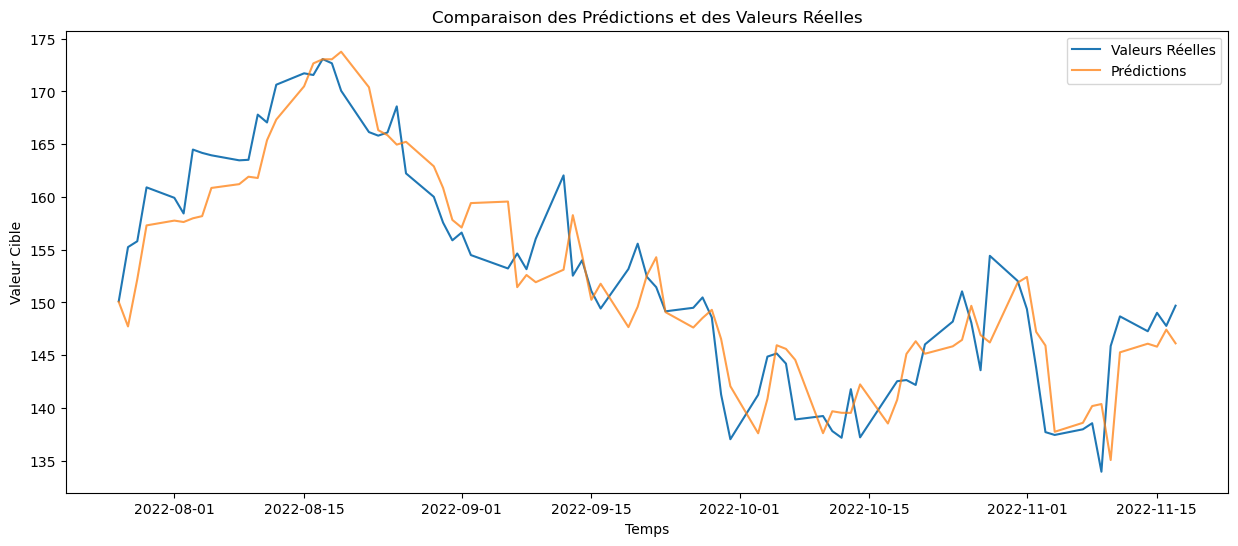

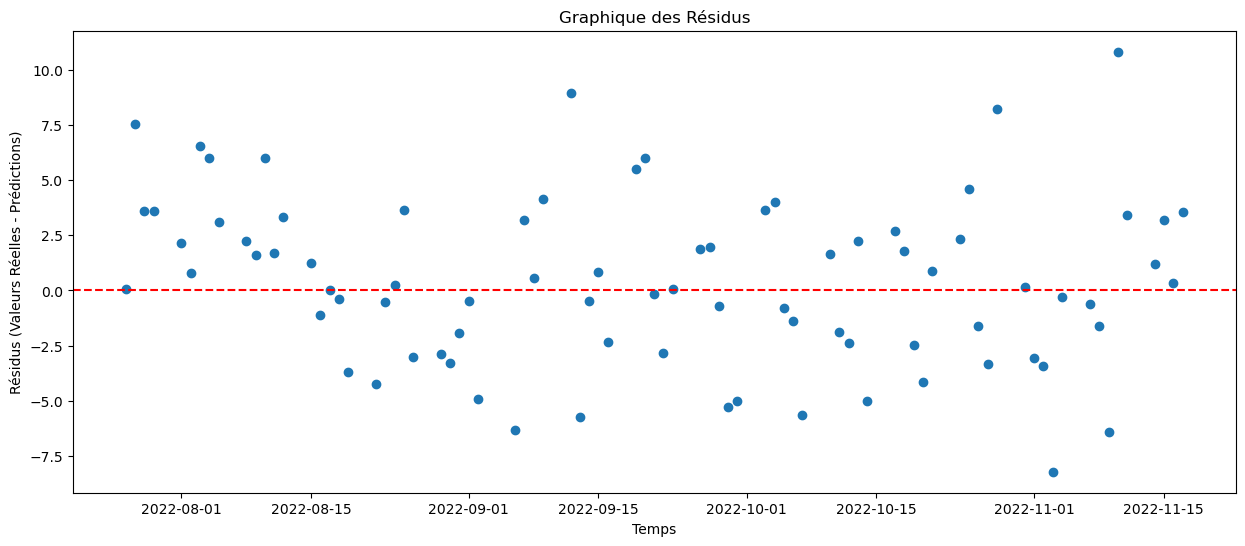

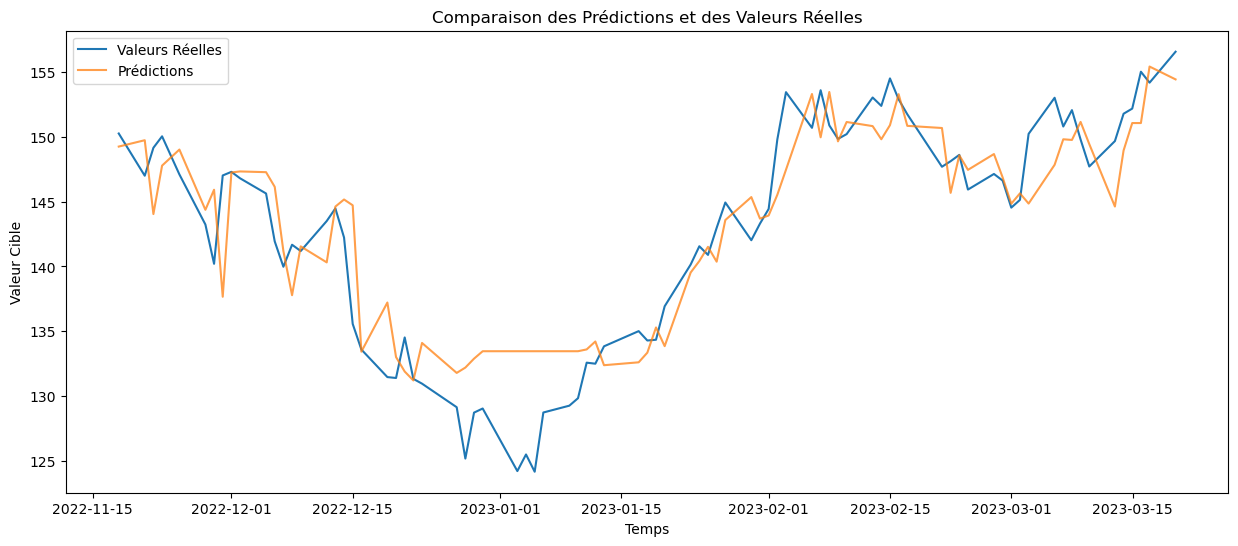

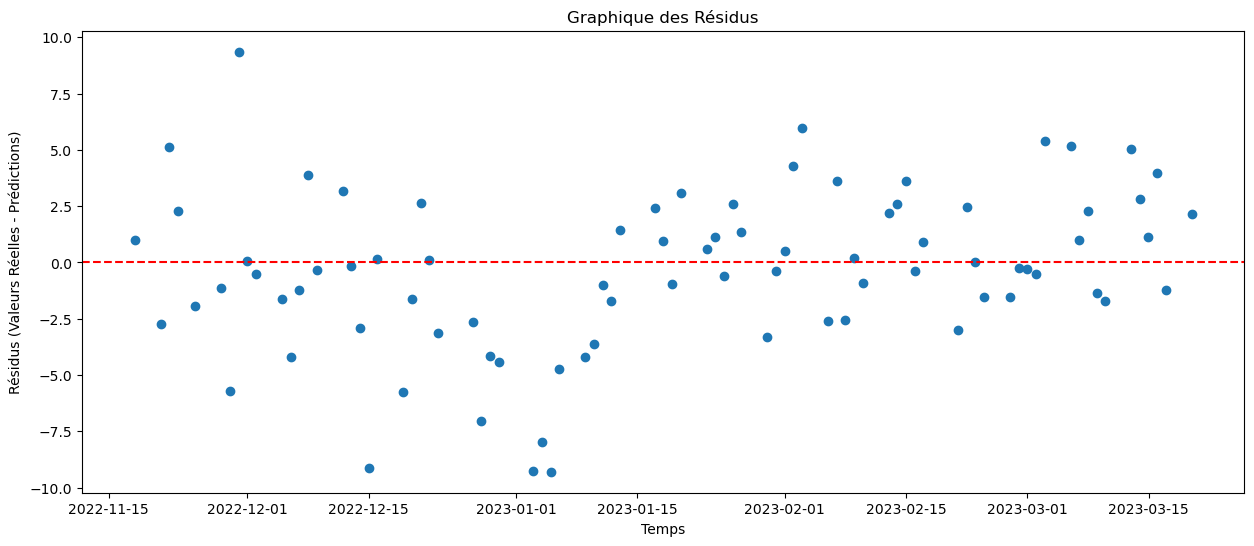

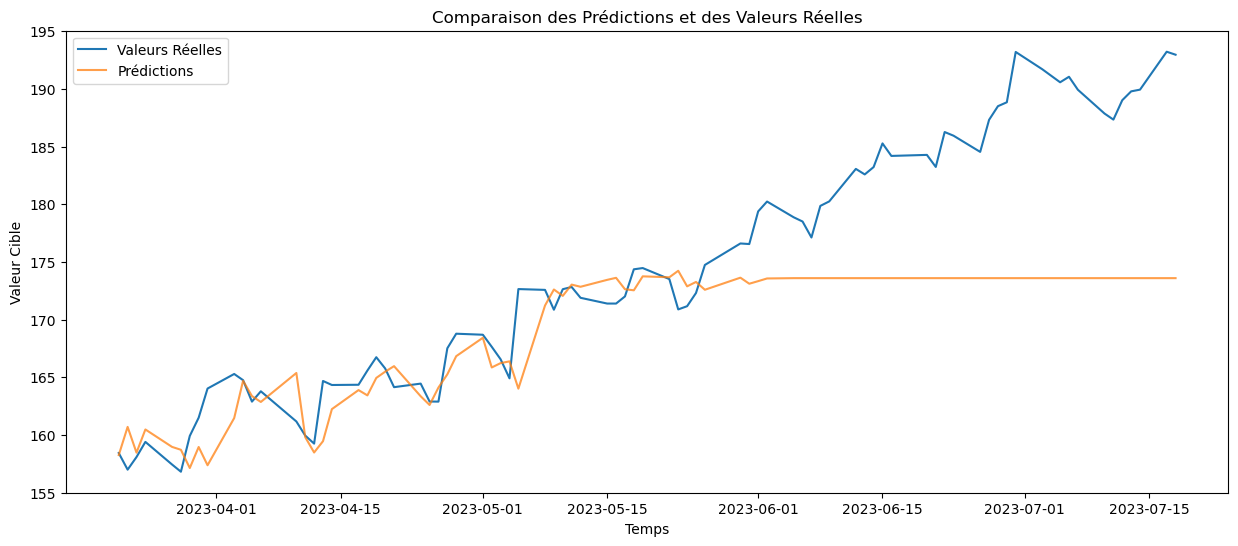

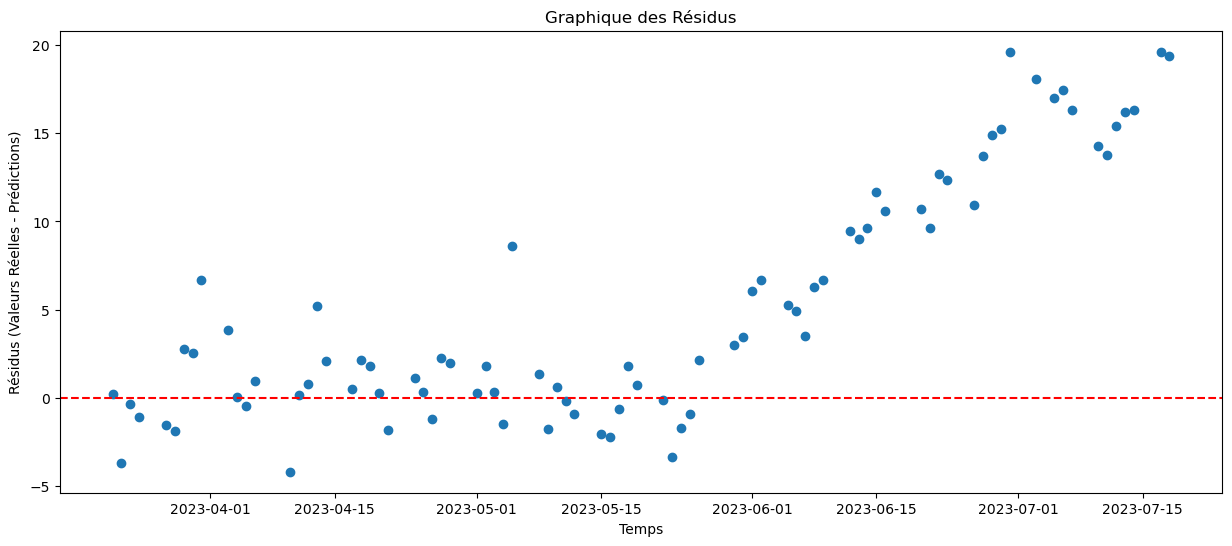

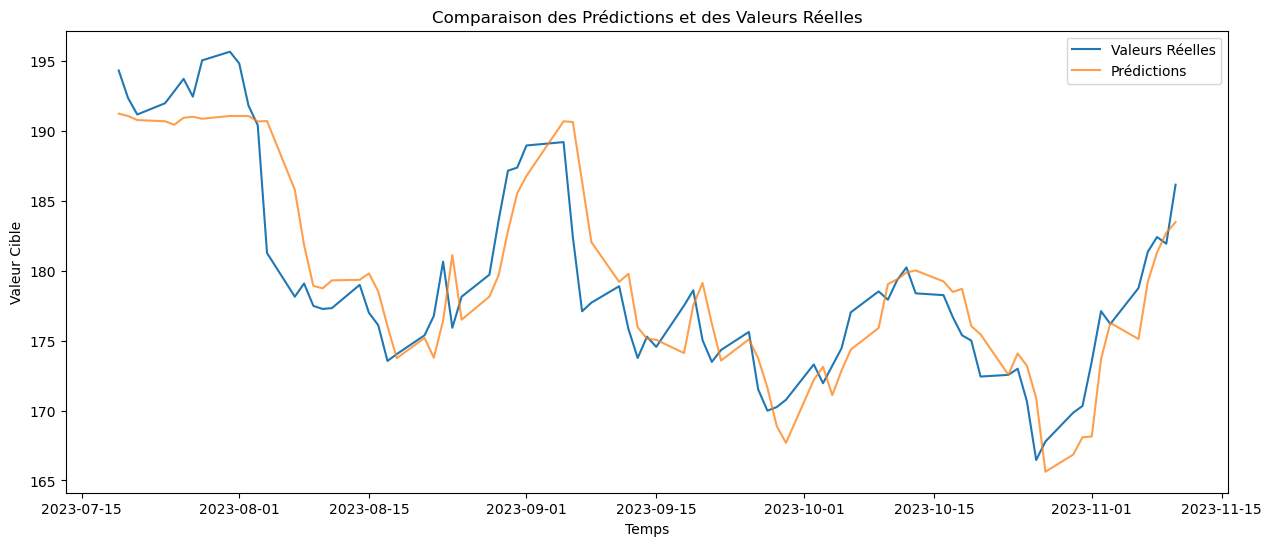

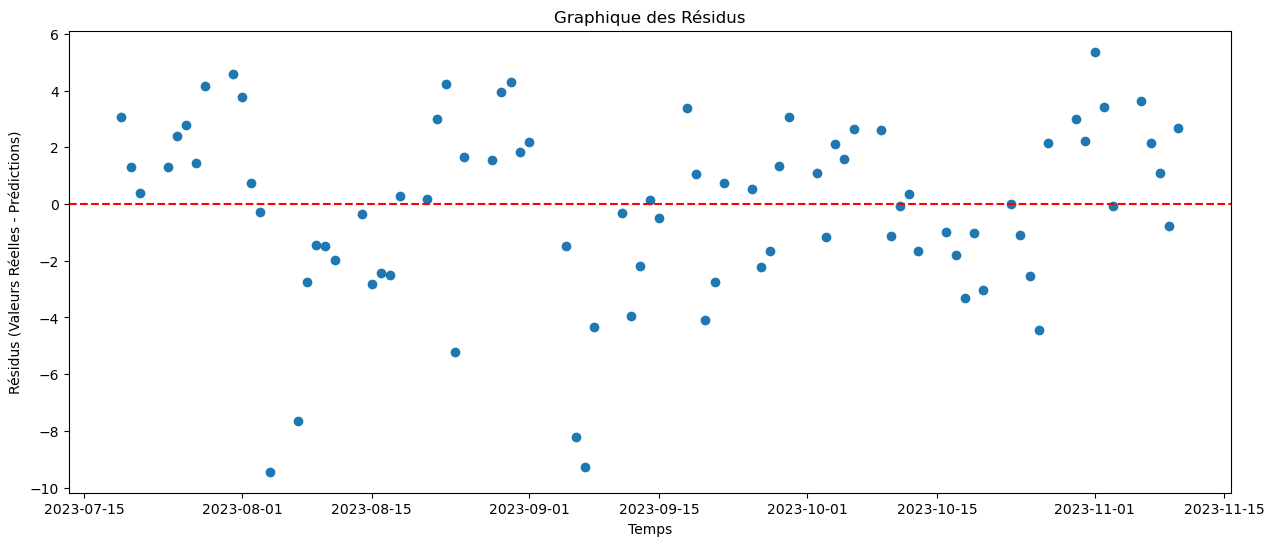

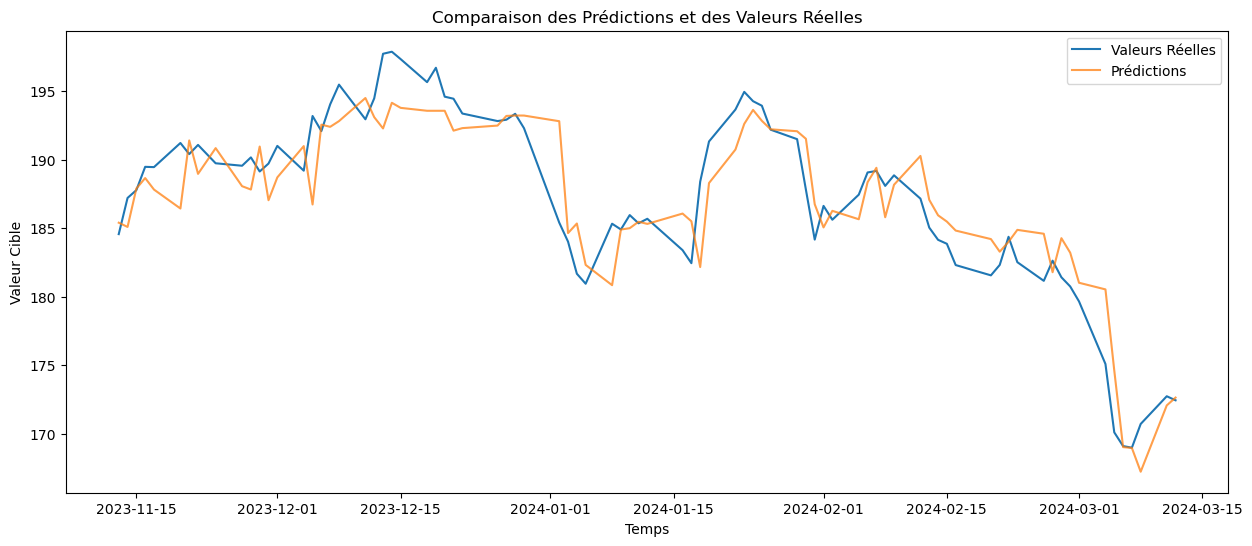

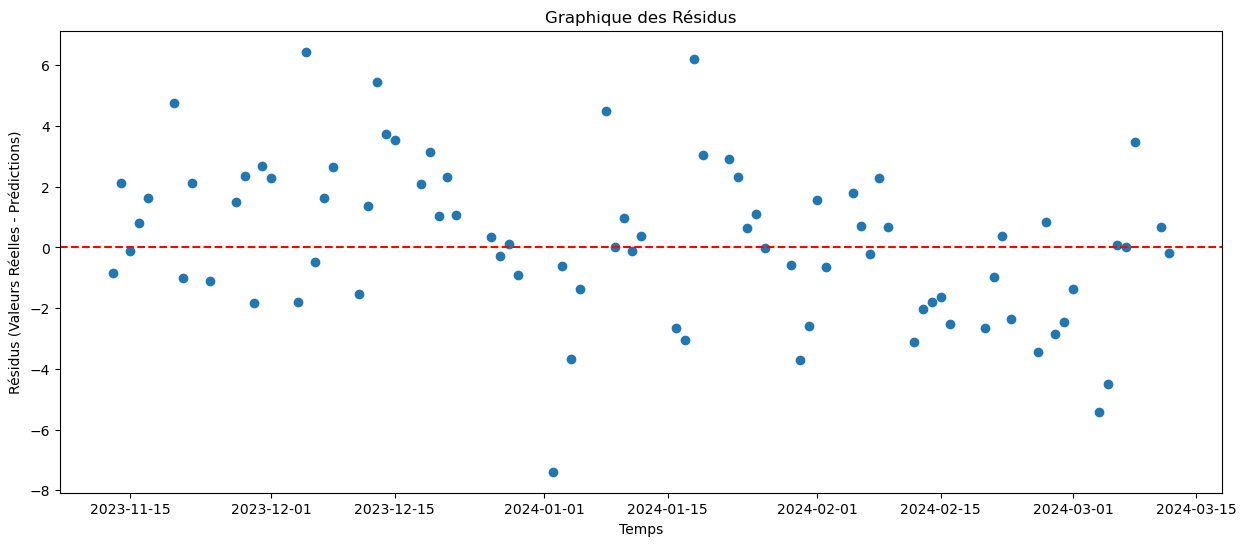

Average MSE: 22.864888452005367


In [62]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Example data preparation
# X: DataFrame containing historical features and exogenous variables
# y: Series or array containing the target variable

n_splits = 5  # Number of splits for the time series cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

mse_scores = []

for train_index, test_index in tscv.split(X):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Assume exogenous variables need to be updated or reintegrated here
    # For illustration, let's assume X_test is updated with new exogenous information
    # This step will be specific to your dataset and model requirements
    
    # Initialize and train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Calculate and record the MSE for this fold
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)
    
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Valeurs Réelles')
    plt.plot(y_test.index, predictions, label='Prédictions', alpha=0.75)
    plt.title('Comparaison des Prédictions et des Valeurs Réelles')
    plt.xlabel('Temps')
    plt.ylabel('Valeur Cible')
    plt.legend()
    plt.show()
    
    residuals = y_test - predictions

    # Tracé des résidus
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, residuals, marker='o', linestyle='')
    plt.title('Graphique des Résidus')
    plt.xlabel('Temps')
    plt.ylabel('Résidus (Valeurs Réelles - Prédictions)')
    plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à zéro pour référence
    plt.show()

# Calculate the average MSE across all splits
average_mse = np.mean(mse_scores)
print(f"Average MSE: {average_mse}")


In [109]:
mse_scores

[3.4929533876955468,
 3.1411217263349065,
 79.44252316867843,
 3.84510780610798,
 1.2934495742436822]

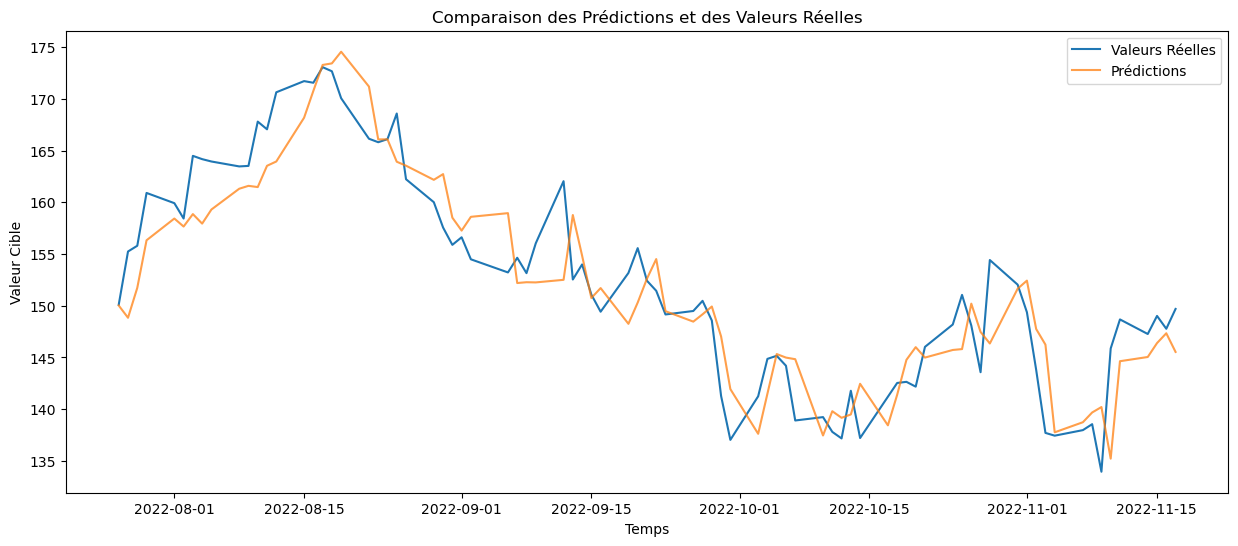

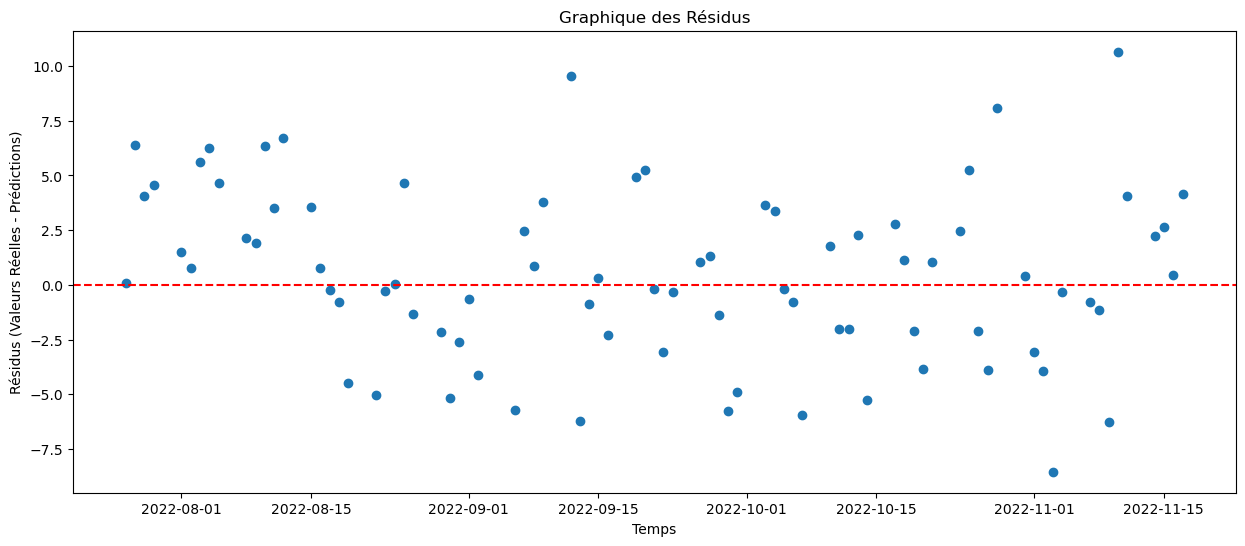

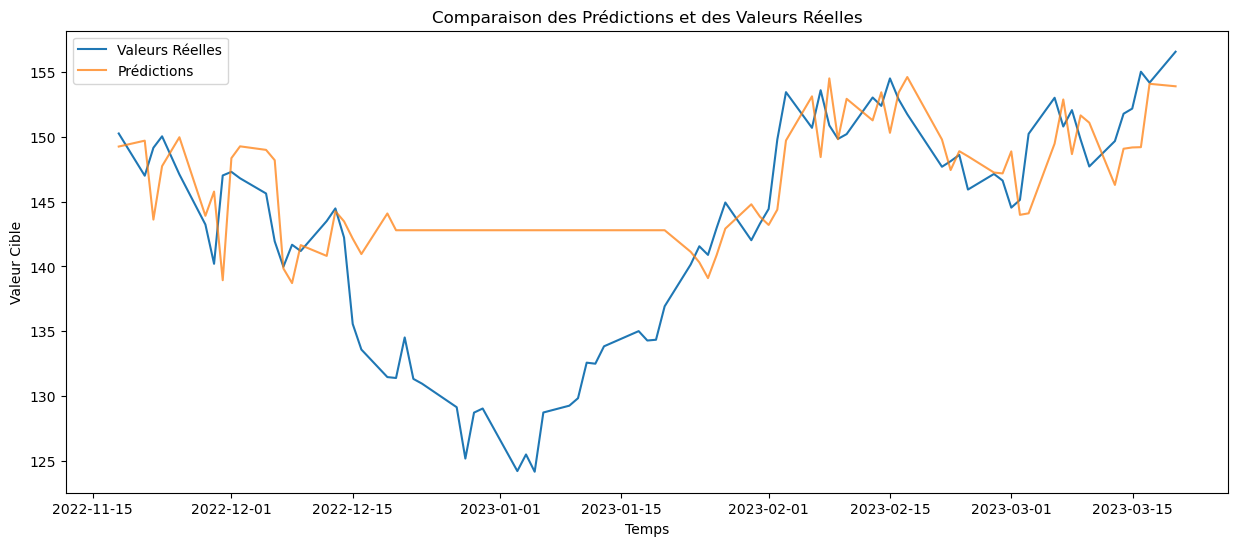

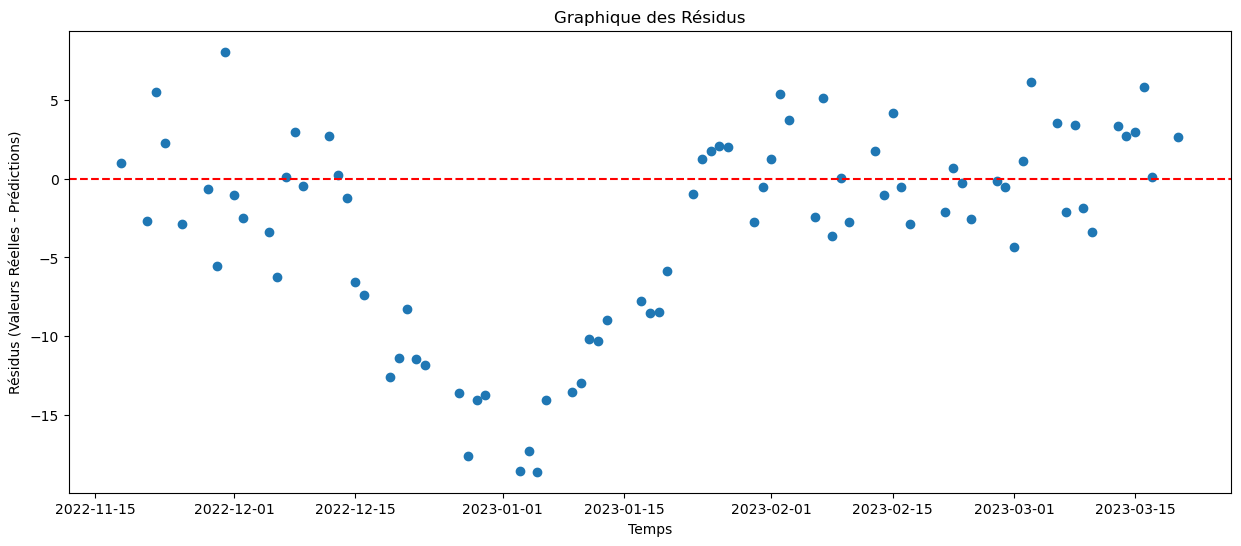

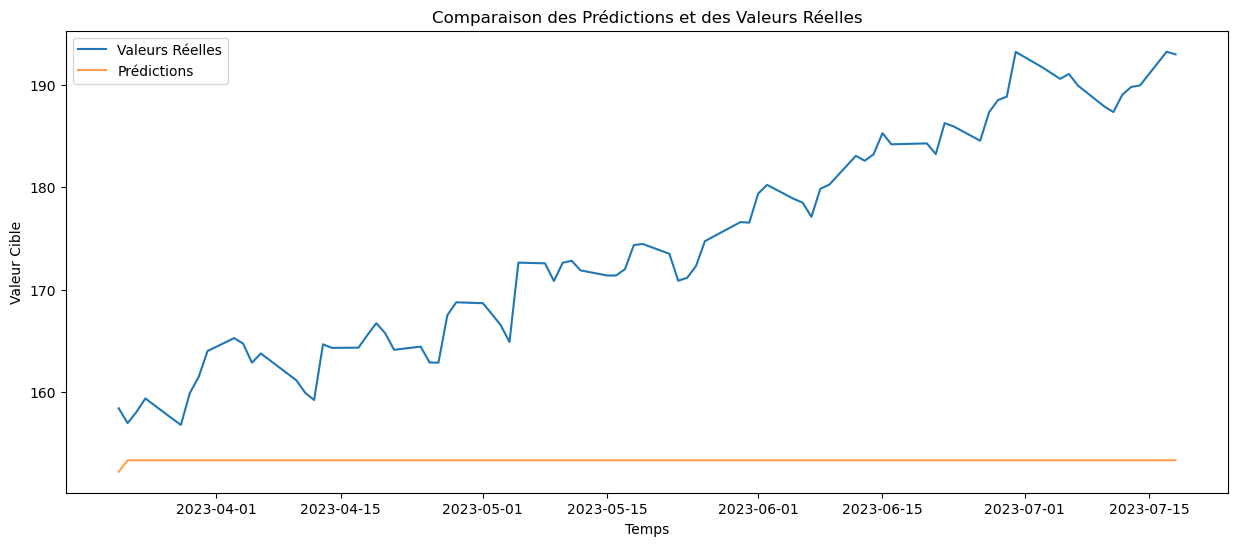

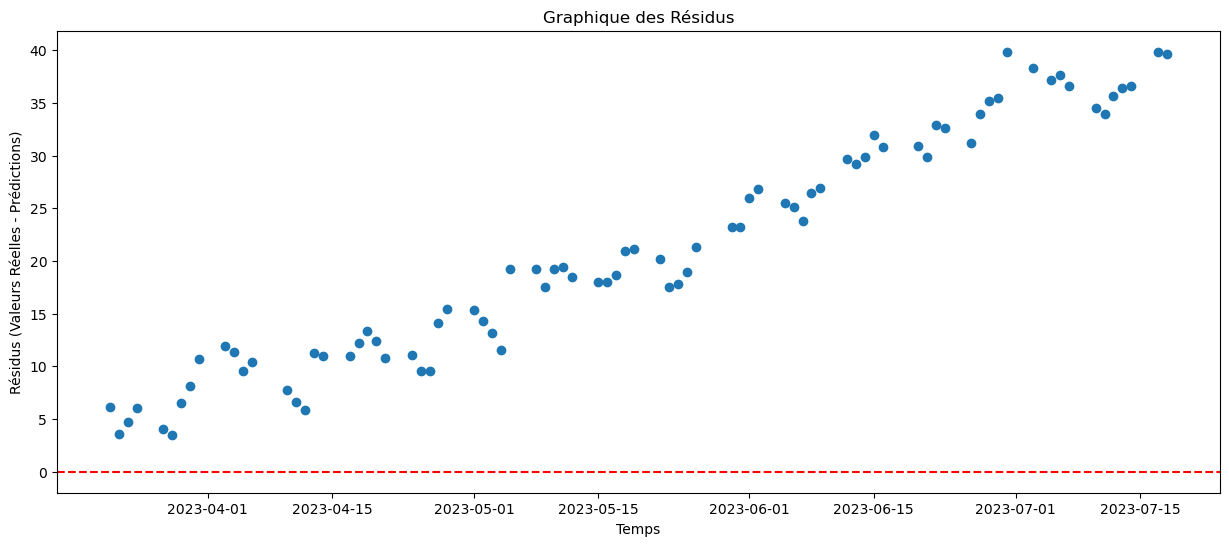

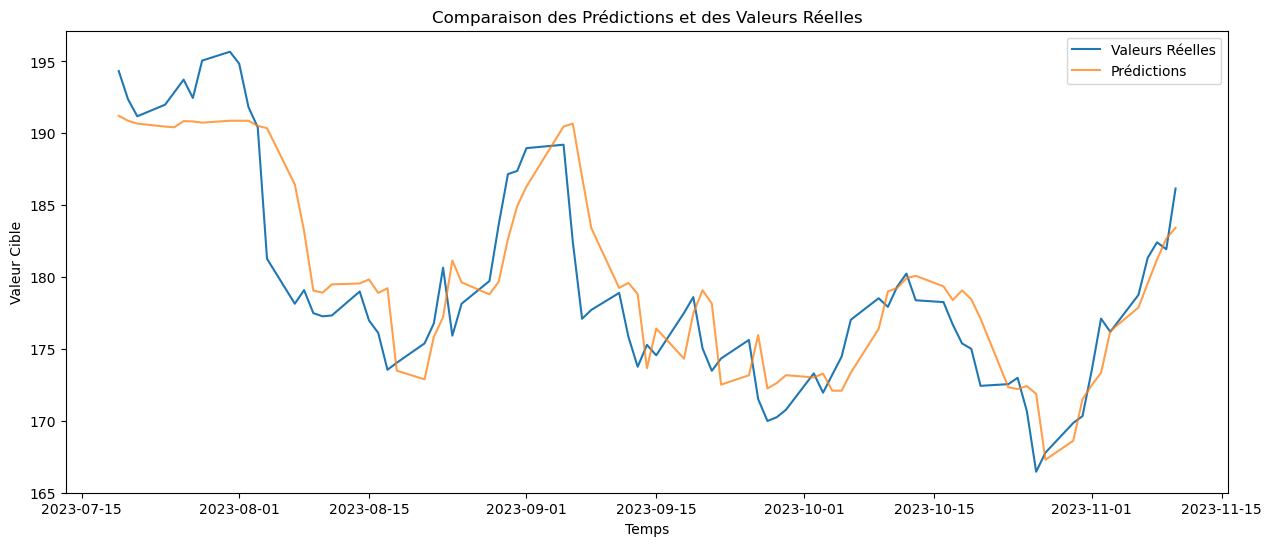

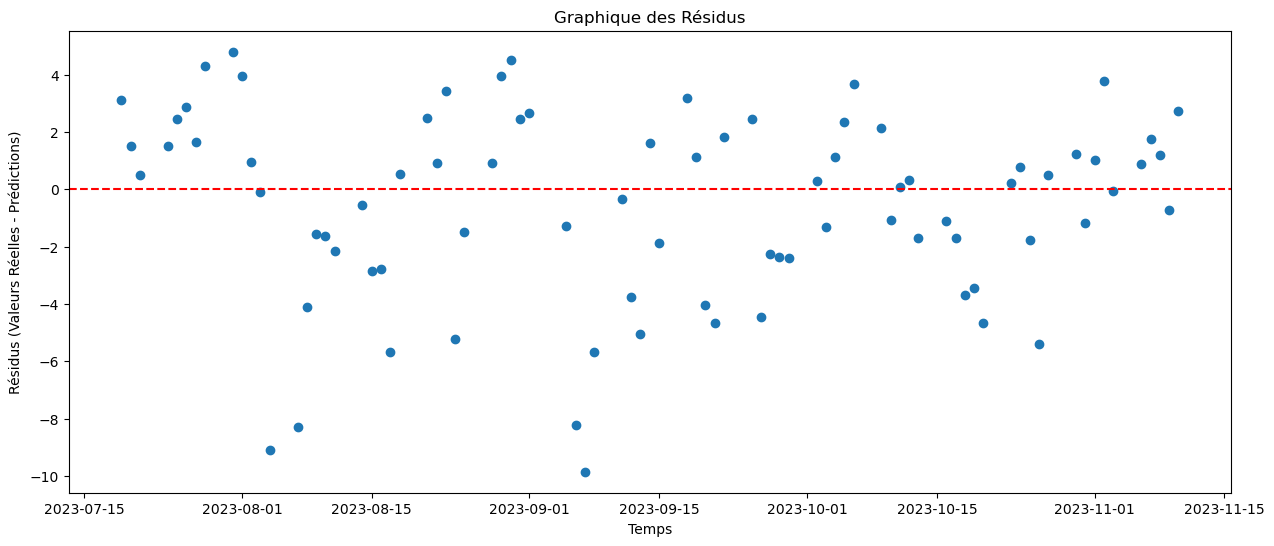

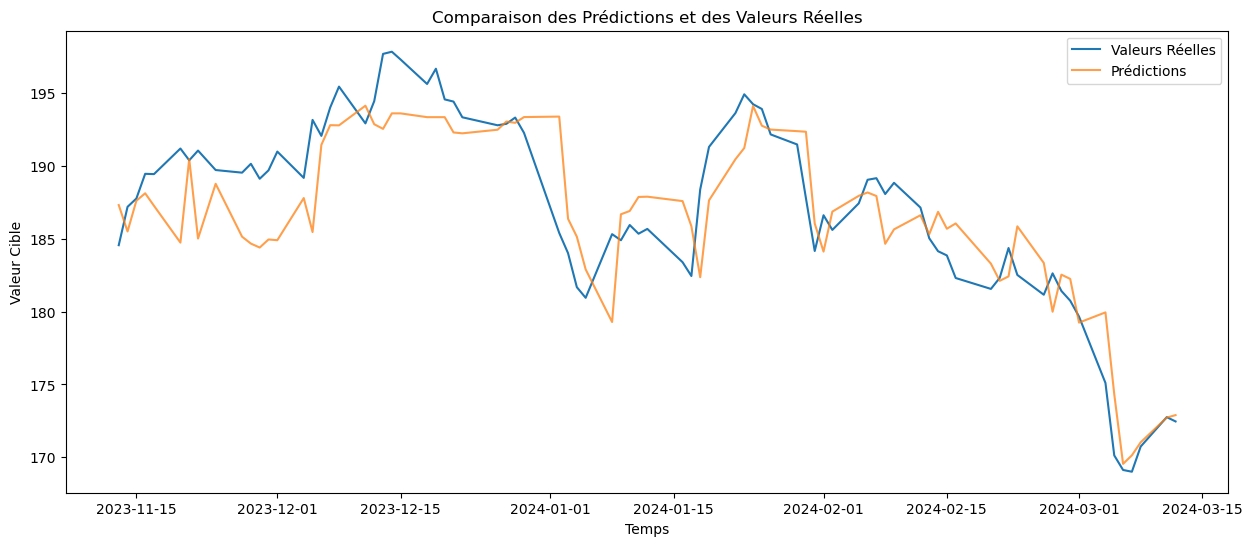

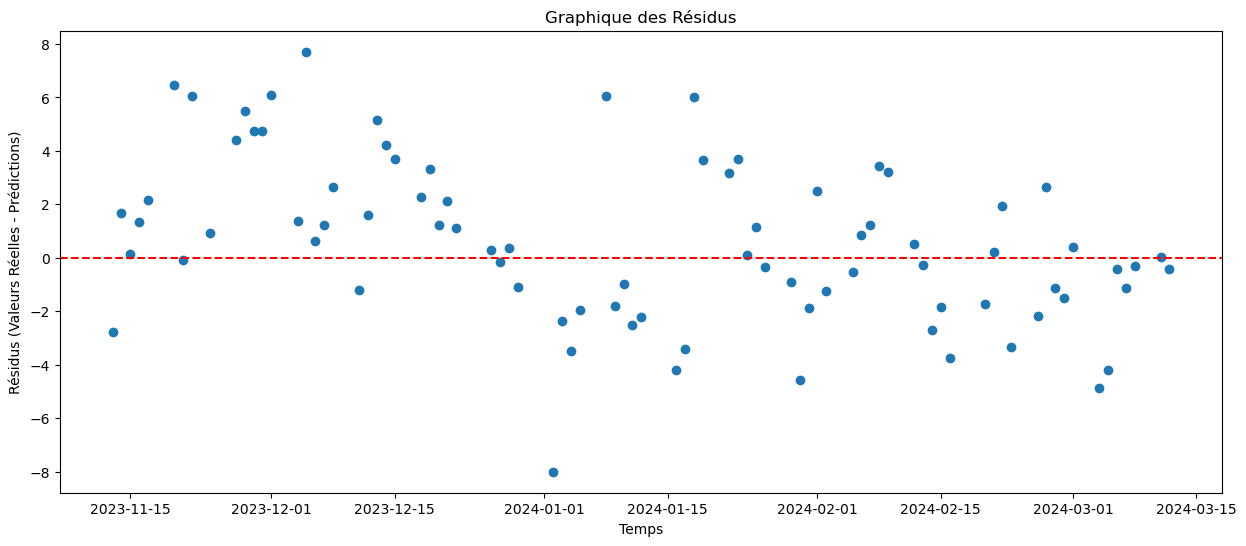

Rolling Window Analysis Average MSE: 127.03943443400382


In [63]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Example dataset preparation
# X: DataFrame containing the features
# y: Series or DataFrame column containing the target variable

# Configuration for the rolling window
n_splits = 5  # Defines the number of windows (splits) for the analysis
window_size = len(X) // (n_splits + 1)  # Determines the size of each training window

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=window_size)

mse_scores = []

# Perform the rolling window analysis
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Calculate and store the MSE for this window
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Valeurs Réelles')
    plt.plot(y_test.index, predictions, label='Prédictions', alpha=0.75)
    plt.title('Comparaison des Prédictions et des Valeurs Réelles')
    plt.xlabel('Temps')
    plt.ylabel('Valeur Cible')
    plt.legend()
    plt.show()
    
    residuals = y_test - predictions

    # Tracé des résidus
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, residuals, marker='o', linestyle='')
    plt.title('Graphique des Résidus')
    plt.xlabel('Temps')
    plt.ylabel('Résidus (Valeurs Réelles - Prédictions)')
    plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à zéro pour référence
    plt.show()

# Calculate the average MSE across all windows
average_mse = np.mean(mse_scores)
print(f"Rolling Window Analysis Average MSE: {average_mse}")


In [111]:
mse_scores

[3.4929533876955468,
 18.942301344837613,
 397.43428457173513,
 3.6218517259810645,
 1.8465019840751857]

In [64]:
X_train

Lag_1       Lag_2       Lag_3
Date                                                         
2023-07-19 00:00:00-04:00  192.967957  193.226944  189.939911
2023-07-20 00:00:00-04:00  194.332581  192.967957  193.226944
2023-07-21 00:00:00-04:00  192.370331  194.332581  192.967957
2023-07-24 00:00:00-04:00  191.185013  192.370331  194.332581
2023-07-25 00:00:00-04:00  191.991806  191.185013  192.370331
...                               ...         ...         ...
2023-11-06 00:00:00-05:00  176.192749  177.110382  173.519684
2023-11-07 00:00:00-05:00  178.766068  176.192749  177.110382
2023-11-08 00:00:00-05:00  181.349365  178.766068  176.192749
2023-11-09 00:00:00-05:00  182.416595  181.349365  178.766068
2023-11-10 00:00:00-05:00  181.937836  182.416595  181.349365

[82 rows x 3 columns]

In [132]:
y_train

Date
2023-07-14 00:00:00-04:00    189.939926
2023-07-17 00:00:00-04:00    193.226944
2023-07-18 00:00:00-04:00    192.967957
2023-07-19 00:00:00-04:00    194.332581
2023-07-20 00:00:00-04:00    192.370331
                                ...    
2023-10-27 00:00:00-04:00    167.784576
2023-10-30 00:00:00-04:00    169.849197
2023-10-31 00:00:00-04:00    170.327972
2023-11-01 00:00:00-04:00    173.519684
2023-11-02 00:00:00-04:00    177.110382
Name: Close, Length: 79, dtype: float64

Given the context of evaluating resampling methods for a time series dataset of AAPL stock prices over 2 years, a suitable advanced technique that could be considered is Leave-Future-Out Cross-Validation (LFOCV). This method is an adaptation of Leave-One-Out Cross-Validation (LOOCV) tailored for time series data, ensuring the temporal order is preserved and future data is not used inappropriately during model training.

# Leave-Future-Out Cross-Validation (LFOCV)
LFOCV systematically leaves out a portion of the "future" data in the dataset for testing, training the model on the "past" data. This process repeats such that each "future" point (or block of points) serves as a test set exactly once. This approach is particularly well-suited for time series forecasting as it respects the chronological sequence of data, crucial for maintaining model validity.

Implementation with Random Forest in Python
The Python example below illustrates how to implement LFOCV with a Random Forest model for forecasting AAPL stock prices. It assumes that X contains features derived from the stock price data, such as lagged prices, moving averages, etc., and y is the target variable (e.g., the closing price).

In [113]:
mse_scores

[0.09391621127724648,
 3.6145334047809548,
 26.59546706311457,
 0.008270489238226476,
 7.700458168933352,
 11.01561271509859,
 2.0733815975479652,
 1.75942275930777,
 0.2661565507919492,
 0.485454226110157,
 21.340837300779054,
 0.03347734012641013,
 36.941796868477816,
 6.8802492320315904,
 24.760995730294436,
 3.4388351034717783,
 0.26118703121248515,
 2.1394534728013976,
 16.362582969844787,
 7.537378304136952,
 0.00013571382521209864,
 37.31463797383257,
 3.774747494012154,
 53.27192529997689,
 47.265048028799356,
 1.0850825839970284,
 0.7610701415335972,
 12.064252907530296,
 25.572365946282854,
 32.52655199220697,
 6.721625903183169,
 19.77659857837674,
 0.2335750729367238,
 0.18178988939638657,
 8.02768497070007,
 12.584204124403028,
 0.007015596092120384,
 0.0531376503431212,
 12.491720352321863,
 2.7779992041737547,
 2.604862815178949,
 3.9208622633816725,
 1.3893501216330646,
 13.519839530736206,
 7.821925102668497,
 38.214978592366016,
 3.182612227689564,
 0.9637726028921092

# Evaluation and Impact
#### Advantages:

Temporal Integrity: LFOCV respects the time series' chronological order, crucial for accurate forecasting.
Model Performance Insight: Provides a granular view of how the model performs as it incrementally learns from more data.
#### Considerations:

Computational Intensity: Especially for larger datasets, LFOCV can be computationally demanding due to the high number of training cycles.
Sensitivity to Noise: Given the iterative nature, the model's performance might be more sensitive to noise in the data at specific points.
# Conclusion
Leave-Future-Out Cross-Validation offers a rigorous and time-respecting method for evaluating the performance of forecasting models on time series datasets, such as stock prices. By carefully implementing LFOCV and analyzing its outcomes, practitioners can gain valuable insights into the temporal dynamics of their models, ensuring that forecasts are both accurate and reliable. This method underscores the importance of methodical evaluation in developing robust forecasting models for financial time series data.

For the AAPL stock price dataset covering 2 years of historical data, a resampling method that can be particularly effective is Subsampling with a Sliding Window. This method is tailored for time series forecasting, allowing models to train on various segments of the data to capture different temporal patterns and trends.

# Subsampling with a Sliding Window
This approach involves creating multiple, overlapping training sets (windows) that move forward in time, each of which is used to train a separate model. Predictions from these models can then be aggregated to form a final forecast. This method enables the model to learn from and adapt to changes in the data's underlying behavior over time.

Implementation with Random Forest in Python
Here's how to implement Subsampling with a Sliding Window using a Random Forest regressor for the AAPL stock price forecasting task:

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assuming X and y have been defined with X containing features derived from the AAPL stock price data
# and y being the target variable (e.g., closing price)

window_size = 60  # Number of observations in each training window
step_size = 5  # Steps to move forward in the dataset for each new window
n_estimators = 100  # Number of trees in the Random Forest

# Calculate the total number of windows that will be created
n_windows = (len(X) - window_size) // step_size + 1

# Placeholder for aggregated predictions
predictions = np.zeros(len(y))

# Placeholder for model scores
mse_scores = []

for i in range(n_windows):
    start = i * step_size
    end = start + window_size
    
    # Define the current training and test sets
    X_train, y_train = X.iloc[start:end], y.iloc[start:end]
    
    # Define the test set as the next step_size points following the training set
    X_test, y_test = X.iloc[end:end+step_size], y.iloc[end:end+step_size]
    
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions and update the aggregated predictions array
    current_predictions = model.predict(X_test)
    predictions[end:end+step_size] = current_predictions
    
    # Calculate and store the MSE for the current window
    mse = mean_squared_error(y_test, current_predictions)
    mse_scores.append(mse)


# Calculate the overall MSE across all windows
overall_mse = np.mean(mse_scores)
print(f"Overall MSE: {overall_mse}")


Overall MSE: 16.360624140706765


In [ ]:
mse_scores

# Evaluation and Impact
#### Advantages:

Adaptability: This method allows the model to learn from different segments of the data, potentially improving its adaptability to changes over time.
Robustness: Training separate models on overlapping windows can enhance the robustness of the forecasting, as it reduces the impact of anomalies in any single segment.
#### Considerations:

Computational Demand: Training multiple models across sliding windows can be computationally intensive, especially for large datasets or complex models.
Aggregation Strategy: Deciding on the best way to aggregate predictions from different models requires careful consideration to ensure optimal forecasting performance.
# Conclusion
Subsampling with a Sliding Window is a powerful resampling method for time series forecasting, offering a dynamic approach to model training that can capture temporal variations in the data. By implementing this strategy and evaluating its impact through measures like MSE, practitioners can enhance the accuracy and reliability of forecasts for datasets like AAPL's stock prices, leveraging the strengths of ensemble methods like Random Forest to navigate the complexities of financial time series data.

Implementing and evaluating different resampling methods for time series forecasting, especially with complex models like Bagging and Random Forest, requires a nuanced approach that respects the inherent sequential nature of the data. A method well-suited for this purpose, which hasn't been explicitly described yet, is Dynamic Time Warping (DTW) as a Resampling Technique.

# Dynamic Time Warping (DTW) as a Resampling Technique
Dynamic Time Warping (DTW) is a powerful algorithm traditionally used for measuring similarity between two temporal sequences which may vary in speed. For time series forecasting, DTW can be creatively applied to resample the dataset based on the similarity of time series segments to the most recent data, allowing the model to focus on training data that is most relevant to the forecasting period.

Implementation with Random Forest in Python
This approach involves using DTW to identify and prioritize segments of the historical data that closely match the pattern of the most recent segment, then training the model on this resampled dataset. Below is a conceptual Python implementation using Random Forest for forecasting, focusing on the utilization of DTW for data selection:

Implementing and evaluating different resampling methods for time series forecasting, especially with complex models like Bagging and Random Forest, requires a nuanced approach that respects the inherent sequential nature of the data. A method well-suited for this purpose, which hasn't been explicitly described yet, is Dynamic Time Warping (DTW) as a Resampling Technique.

# Dynamic Time Warping (DTW) as a Resampling Technique
Dynamic Time Warping (DTW) is a powerful algorithm traditionally used for measuring similarity between two temporal sequences which may vary in speed. For time series forecasting, DTW can be creatively applied to resample the dataset based on the similarity of time series segments to the most recent data, allowing the model to focus on training data that is most relevant to the forecasting period.

Implementation with Random Forest in Python
This approach involves using DTW to identify and prioritize segments of the historical data that closely match the pattern of the most recent segment, then training the model on this resampled dataset. Below is a conceptual Python implementation using Random Forest for forecasting, focusing on the utilization of DTW for data selection:

# Evaluation and Impact
#### Advantages:

Focused Learning: DTW-based resampling allows the model to learn from historical data most similar to recent trends, potentially improving forecast accuracy for the near future.
Adaptability: This method offers adaptability to changing market conditions by dynamically selecting the most relevant training data.
#### Considerations:

Computational Complexity: DTW computation, especially without optimizations, can be resource-intensive due to its pairwise comparisons.
Data Selection Bias: There's a risk of overfitting to patterns that resemble the recent segment, which may not necessarily be predictive of future movements.
# Conclusion
Dynamic Time Warping as a resampling technique for time series forecasting introduces an innovative approach to selecting training data based on temporal similarity, enhancing model relevance and potentially forecasting performance. By judiciously applying DTW in conjunction with sophisticated models like Random Forest, forecasters can develop more nuanced and responsive forecasting models tailored to the specific dynamics of time series data such as stock prices.

Given the ongoing exploration of resampling methods for enhancing time series forecasting with supervised learning techniques like Bagging and Random Forest, another innovative approach to consider is Weighted Sampling Based on Time Proximity. This method emphasizes the importance of more recent data points by assigning them higher weights during the resampling process, under the assumption that the most recent observations might be more indicative of future values than older ones.

# Weighted Sampling Based on Time Proximity
The core idea here is to apply a non-uniform sampling strategy where recent data points have a higher probability of being included in the training set than older data points. This approach can be particularly useful in time series forecasting when recent trends and patterns are believed to be more relevant for predicting future outcomes.

Implementation with Random Forest in Python
Below is a conceptual Python example demonstrating how to implement Weighted Sampling Based on Time Proximity using a Random Forest model for forecasting. This example assumes X and y represent your dataset's features and target variable, respectively, prepared for time series forecasting.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming X and y have been defined with features and target variable from the time series dataset

# Generate weights for weighted sampling: newer observations have higher weights
weights = np.linspace(start=0.1, stop=1.0, num=len(y))

# Weighted random sampling of indices based on time proximity
weighted_indices = np.random.choice(a=np.arange(len(y)), size=int(len(y) * 0.8), replace=False, p=weights/weights.sum())

X_weighted = X.iloc[weighted_indices]
y_weighted = y.iloc[weighted_indices]

# Splitting the weighted dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_weighted, y_weighted, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Weighted Sampling MSE: {mse}")


In [ ]:
X_train

In [ ]:
predictions

# Evaluation and Impact
#### Advantages:

Increased Relevance of Recent Trends: By focusing on more recent observations, the model may better capture the latest patterns and trends that are more relevant for forecasting future values.
Flexibility in Weight Assignment: The method allows for customizable weight distributions, enabling forecasters to adjust how much recent data influences model training.
#### Considerations:

Risk of Overfitting: Overemphasis on recent data can lead to overfitting, especially if the recent trends do not persist into the future.
Choice of Weighting Scheme: Determining the optimal weighting scheme requires careful consideration and might need adjustments based on the specific characteristics of the time series.
Conclusion
Weighted Sampling Based on Time Proximity offers a strategic way to prioritize recent observations in time series forecasting, potentially enhancing the predictive performance of models like Bagging and Random Forest. This method underscores the importance of recent data in forecasting efforts but also highlights the need for judicious weight management to avoid overfitting. By carefully implementing and evaluating this resampling technique, practitioners can more effectively leverage recent trends in their forecasting models, achieving a balance between responsiveness to new data and the robustness of predictions.

To address the request for exploring additional resampling methods tailored for time series forecasting with supervised learning models like Bagging and Random Forest, and to accurately assess their impact, we turn our attention to a strategic approach known as Custom Time Blocks Resampling. This method is particularly effective for datasets that exhibit distinct cyclical patterns or seasonality, such as stock prices, which may have underlying trends that vary by day of the week, month, or quarter.

# Custom Time Blocks Resampling
Custom Time Blocks Resampling involves segmenting the time series data into blocks that correspond to specific, potentially meaningful periods (e.g., monthly, quarterly) and then sampling within these blocks to create training and test sets. This approach allows the model to learn from the nuances of each period's data, potentially enhancing its ability to generalize across similar periods in the future.

Implementation with Random Forest in Python
The Python example below demonstrates how to implement Custom Time Blocks Resampling for forecasting, using the AAPL stock price dataset as a reference. This example assumes X contains features derived from the dataset, including lagged values, and y is the target variable (e.g., closing price).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming the dataset 'df' is indexed by datetime and includes 'Close' as the target variable
df['Year'] = df.index.year
df['Month'] = df.index.month
# Create a unique identifier for each year-month block
df['YearMonth'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)

# Sample a subset of data from each year-month block to create a balanced dataset
sampled_dfs = []
for year_month in df['YearMonth'].unique():
    block_df = df[df['YearMonth'] == year_month]
    sampled_block = block_df.sample(frac=0.8) if len(block_df) > 1 else block_df
    sampled_dfs.append(sampled_block)

resampled_df = pd.concat(sampled_dfs).sort_index()
X_resampled = resampled_df.drop(['Close', 'Year', 'Month', 'YearMonth'], axis=1)
y_resampled = resampled_df['Close']

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Custom Time Blocks Resampling MSE: {mse}")


# Evaluation and Impact
#### Advantages:

Period-Specific Learning: This method enables the model to capture and learn from the unique characteristics of different time periods.
Improved Forecasting Accuracy: By training on a diverse set of periods, the model may better generalize to unseen data, potentially improving forecasting accuracy.
#### Considerations:

Data Distribution: Care must be taken to ensure that the resampling does not introduce bias, particularly if certain periods are over- or under-represented.
Computational Complexity: Depending on the number of blocks and the size of the dataset, this approach may increase the computational workload.
Conclusion
Custom Time Blocks Resampling offers a targeted approach to harnessing cyclical patterns and seasonal effects in time series data, enhancing the ability of models like Bagging and Random Forest to forecast future trends accurately. By thoughtfully implementing this resampling method and critically assessing its impact, data scientists can refine their models to better capture the dynamic behaviors of time series datasets, such as stock prices, improving both the relevance and reliability of their forecasts.

To further explore and evaluate resampling methods for a time series dataset, specifically for supervised learning models like Bagging and Random Forest, another innovative approach is Synthetic Minority Over-sampling Technique for Time Series (SMOTETS). While SMOTE is traditionally used in classification tasks to address imbalances by creating synthetic samples, SMOTETS adapts this concept for time series forecasting, focusing on generating synthetic time series data to improve model training and performance.

# Synthetic Minority Over-sampling Technique for Time Series (SMOTETS)
SMOTETS involves creating synthetic examples not by interpolating between existing observations but by considering the temporal patterns and correlations within the time series data. This can help in scenarios where the dataset is imbalanced (e.g., predicting rare events) or when the model needs more varied data to learn from.

Implementation with Random Forest in Python
This example demonstrates a conceptual approach to implementing SMOTETS with a Random Forest model for forecasting. Since actual implementation of SMOTETS can be complex and there isn't a direct, widely-used Python library implementation for SMOTETS as of the last update, the focus will be on the conceptual steps:

Identify segments of interest in the time series that are underrepresented or for which additional synthetic data could be beneficial for the model.
Generate synthetic data by applying techniques like interpolation, adding noise, or using deep learning models trained on the segments of interest to generate new, similar segments.
Incorporate synthetic data into the training set, ensuring it's treated the same way as actual historical data.


Given the necessity to explore and evaluate diverse resampling methods for time series data with supervised learning techniques like Bagging and Random Forest, and considering the importance of preserving the chronological order of time series data, a sophisticated approach to consider is Resampling Based on Anomaly Detection.

# Resampling Based on Anomaly Detection
This approach involves identifying anomalies or outliers in the time series data, then selectively resampling the data to either focus on these points or exclude them, depending on the specific objectives of the forecasting model. The rationale is that anomalies can significantly influence the model's performance, either by providing valuable information about rare events or by introducing noise that could lead to overfitting.

Implementation with Random Forest in Python
Here's how to implement this method using a Random Forest model for forecasting, incorporating a simple anomaly detection mechanism based on statistical thresholds. This example assumes X and y represent your dataset's features and target variable, respectively, prepared for time series forecasting.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

# Assuming X and y are prepared from the AAPL stock price dataset
# For simplicity, let's consider y to be the daily price change percentage

# Detect anomalies by identifying data points where the price change is beyond 2 standard deviations from the mean
mean_price_change = np.mean(y)
std_price_change = np.std(y)
anomalies = np.where(np.abs(y - mean_price_change) > 2 * std_price_change)[0]

# Option 1: Focus on anomalies by resampling data points identified as anomalies
# Option 2: Exclude anomalies to focus on more "normal" conditions
# Here, we choose Option 2 for demonstration

non_anomaly_indices = np.setdiff1d(np.arange(len(y)), anomalies)

# Resample the dataset to exclude anomalies
X_resampled = X.iloc[non_anomaly_indices]
y_resampled = y.iloc[non_anomaly_indices]

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Resampling Based on Anomaly Detection MSE: {mse}")


# Evaluation and Impact
#### Advantages:

Targeted Learning: By focusing on or excluding anomalies, the model can be tailored to either predict rare events more accurately or to provide more stable forecasts for typical conditions.
Improved Model Performance: This approach can help mitigate the influence of outliers on model training, potentially leading to more reliable predictions.
#### Considerations:

Anomaly Definition: The definition of what constitutes an anomaly is crucial and can significantly affect the resampled dataset.
Loss of Information: Excluding anomalies might lead to the loss of valuable information, especially if these points are indicative of underlying trends or seasonal effects.
# Conclusion
Resampling Based on Anomaly Detection offers a nuanced method for preparing time series data for forecasting models, allowing practitioners to tailor their models based on the specific characteristics of the data and their forecasting goals. By selectively focusing on or excluding anomalies, models like Bagging and Random Forest can be better optimized for either capturing rare events or improving general forecasting accuracy. This method highlights the importance of a strategic approach to data preparation in enhancing the performance of time series forecasting models.

In [425]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [ ]:
# Example feature preparation
# X: DataFrame containing the features
# y: Series containing the target variable (e.g., closing prices)

# Normalize features for clustering
X_normalized = (X - X.mean()) / X.std()

# Apply clustering to identify patterns in the data
n_clusters = 5  # Number of clusters can be adjusted based on domain knowledge or silhouette analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_normalized)

# Sample a subset from each cluster to create a balanced and diversified dataset
sampled_indices = []
for cluster in range(n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    n_samples = int(len(cluster_indices) * 0.8)  # Sample 80% from each cluster
    sampled_indices.extend(np.random.choice(cluster_indices, n_samples, replace=False))

# Create the resampled dataset
X_resampled = X.iloc[sampled_indices]
y_resampled = y.iloc[sampled_indices]

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Time Series Clustering for Resampling MSE: {mse}")


In [ ]:
# Detect change points in the target variable 'y_GOOG'
# We use a simple change point detection algorithm for demonstration
model = "rbf"
algo_GOOG = rpt.Pelt(model="rbf").fit(np.array(y_GOOG))
result_GOOG = algo_GOOG.predict(pen=10)

# Segment the dataset based on detected change points
segments_GOOG = [y_GOOG.iloc[result_GOOG[i-1]:result_GOOG[i]] for i in range(1, len(result_GOOG))]

# Resample within each detected segment (here we simply use all data within each segment)
# For a more sophisticated approach, you could apply further sampling strategies within segments
X_resampled_list_GOOG = []
y_resampled_list_GOOG = []

for start, end in zip([0]+result_GOOG[:-1], result_GOOG):
    X_segment_GOOG, y_segment_GOOG = X_GOOG.iloc[start:end], y_GOOG.iloc[start:end]
    X_resampled_list_GOOG.append(X_segment_GOOG)
    y_resampled_list_GOOG.append(y_segment_GOOG)

X_resampled_GOOG = pd.concat(X_resampled_list_GOOG)
y_resampled_GOOG = pd.concat(y_resampled_list_GOOG)

# Split the resampled dataset into training and testing sets
X_train_GOOG, X_test_GOOG, y_train_GOOG, y_test_GOOG = train_test_split(X_resampled_GOOG, y_resampled_GOOG, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
model_GOOG.fit(X_train_GOOG, y_train_GOOG)

# Predict on the test set
predictions_GOOG = model_GOOG.predict(X_test_GOOG)

# Evaluate the model
mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
print(f"Resampling Based on Change Points Detection MSE for GOOG: {mse_GOOG}")


In [ ]:
# Detect change points in the target variable 'y_RD'
# We use a simple change point detection algorithm for demonstration
model = "rbf"
algo_RD = rpt.Pelt(model="rbf").fit(np.array(y_RD))
result_RD = algo_RD.predict(pen=10)

# Segment the dataset based on detected change points
segments_RD = [y_RD.iloc[result_RD[i-1]:result_RD[i]] for i in range(1, len(result_RD))]

# Resample within each detected segment (here we simply use all data within each segment)
# For a more sophisticated approach, you could apply further sampling strategies within segments
X_resampled_list_RD = []
y_resampled_list_RD = []

for start, end in zip([0]+result_RD[:-1], result_RD):
    X_segment_RD, y_segment_RD = X_RD.iloc[start:end], y_RD.iloc[start:end]
    X_resampled_list_RD.append(X_segment_RD)
    y_resampled_list_RD.append(y_segment_RD)

X_resampled_RD = pd.concat(X_resampled_list_RD)
y_resampled_RD = pd.concat(y_resampled_list_RD)

# Split the resampled dataset into training and testing sets
X_train_RD, X_test_RD, y_train_RD, y_test_RD = train_test_split(X_resampled_RD, y_resampled_RD, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
model_RD.fit(X_train_RD, y_train_RD)

# Predict on the test set
predictions_RD = model_RD.predict(X_test_RD)

# Evaluate the model
mse_RD = mean_squared_error(y_test_RD, predictions_RD)
print(f"Resampling Based on Change Points Detection MSE for RD: {mse_RD}")


In [865]:
# Create a Tableau for the MSE of enhanced predictions for all datasets
tableau_enhanced_mse_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | {mse_AAPL:.4f} |
|    MSFT      | {mse_MSFT:.4f} |
|    GOOG      | {mse_GOOG:.4f} |
|     RD       | {mse_RD:.4f}  |
+--------------+--------------+
"""

# Print Tableau for the MSE of enhanced predictions for all datasets
print(tableau_enhanced_mse_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | 0.8946 |
|    MSFT      | 13.2867 |
|    GOOG      | 2.2344 |
|     RD       | 0.9231  |
+--------------+--------------+



In [442]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Assuming X and y are prepared with your time series data
# Split the dataset into an initial training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initial model training and error computation
model.fit(X_train, y_train)
initial_predictions = model.predict(X_train)
initial_errors = np.abs(y_train - initial_predictions)

# Identify instances with errors above a certain threshold (e.g., 75th percentile)
error_threshold = np.percentile(initial_errors, 75)
high_error_indices = np.where(initial_errors > error_threshold)[0]

# Increase the sampling rate of high-error instances for the next iteration
# For simplicity, this example directly duplicates these instances
X_train_high_error = X_train.iloc[high_error_indices]
y_train_high_error = y_train.iloc[high_error_indices]

# Create a new training set that includes duplicated high-error instances
X_train_enhanced = pd.concat([X_train, X_train_high_error]).reset_index(drop=True)
y_train_enhanced = pd.concat([y_train, y_train_high_error]).reset_index(drop=True)

# Retrain the model on the enhanced training set
model.fit(X_train_enhanced, y_train_enhanced)
enhanced_predictions = model.predict(X_test)

# Evaluate the enhanced model
enhanced_mse = mean_squared_error(y_test, enhanced_predictions)
print(f"Enhanced Model MSE: {enhanced_mse}")


In [ ]:
# Assuming X and y are prepared with your time series data for AAPL
# Split the dataset into an initial training and testing set
X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL = train_test_split(X_AAPL, y_AAPL, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

# Initial model training and error computation
model_AAPL.fit(X_train_AAPL, y_train_AAPL)
initial_predictions_AAPL = model_AAPL.predict(X_train_AAPL)
initial_errors_AAPL = np.abs(y_train_AAPL - initial_predictions_AAPL)

# Identify instances with errors above a certain threshold (e.g., 75th percentile)
error_threshold_AAPL = np.percentile(initial_errors_AAPL, 75)
high_error_indices_AAPL = np.where(initial_errors_AAPL > error_threshold_AAPL)[0]

# Increase the sampling rate of high-error instances for the next iteration
# For simplicity, this example directly duplicates these instances
X_train_high_error_AAPL = X_train_AAPL.iloc[high_error_indices_AAPL]
y_train_high_error_AAPL = y_train_AAPL.iloc[high_error_indices_AAPL]

# Create a new training set that includes duplicated high-error instances
X_train_enhanced_AAPL = pd.concat([X_train_AAPL, X_train_high_error_AAPL]).reset_index(drop=True)
y_train_enhanced_AAPL = pd.concat([y_train_AAPL, y_train_high_error_AAPL]).reset_index(drop=True)

# Retrain the model on the enhanced training set
model_AAPL.fit(X_train_enhanced_AAPL, y_train_enhanced_AAPL)
enhanced_predictions_AAPL = model_AAPL.predict(X_test_AAPL)

# Evaluate the enhanced model
enhanced_mse_AAPL = mean_squared_error(y_test_AAPL, enhanced_predictions_AAPL)
print(f"Enhanced Model MSE for AAPL: {enhanced_mse_AAPL}")


In [ ]:
# Assuming X and y are prepared with your time series data for MSFT
# Split the dataset into an initial training and testing set
X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT = train_test_split(X_MSFT, y_MSFT, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

# Initial model training and error computation
model_MSFT.fit(X_train_MSFT, y_train_MSFT)
initial_predictions_MSFT = model_MSFT.predict(X_train_MSFT)
initial_errors_MSFT = np.abs(y_train_MSFT - initial_predictions_MSFT)

# Identify instances with errors above a certain threshold (e.g., 75th percentile)
error_threshold_MSFT = np.percentile(initial_errors_MSFT, 75)
high_error_indices_MSFT = np.where(initial_errors_MSFT > error_threshold_MSFT)[0]

# Increase the sampling rate of high-error instances for the next iteration
# For simplicity, this example directly duplicates these instances
X_train_high_error_MSFT = X_train_MSFT.iloc[high_error_indices_MSFT]
y_train_high_error_MSFT = y_train_MSFT.iloc[high_error_indices_MSFT]

# Create a new training set that includes duplicated high-error instances
X_train_enhanced_MSFT = pd.concat([X_train_MSFT, X_train_high_error_MSFT]).reset_index(drop=True)
y_train_enhanced_MSFT = pd.concat([y_train_MSFT, y_train_high_error_MSFT]).reset_index(drop=True)

# Retrain the model on the enhanced training set
model_MSFT.fit(X_train_enhanced_MSFT, y_train_enhanced_MSFT)
enhanced_predictions_MSFT = model_MSFT.predict(X_test_MSFT)

# Evaluate the enhanced model
enhanced_mse_MSFT = mean_squared_error(y_test_MSFT, enhanced_predictions_MSFT)
print(f"Enhanced Model MSE for MSFT: {enhanced_mse_MSFT}")


In [ ]:
# Assuming X and y are prepared with your time series data for GOOG
# Split the dataset into an initial training and testing set
X_train_GOOG, X_test_GOOG, y_train_GOOG, y_test_GOOG = train_test_split(X_GOOG, y_GOOG, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

# Initial model training and error computation
model_GOOG.fit(X_train_GOOG, y_train_GOOG)
initial_predictions_GOOG = model_GOOG.predict(X_train_GOOG)
initial_errors_GOOG = np.abs(y_train_GOOG - initial_predictions_GOOG)

# Identify instances with errors above a certain threshold (e.g., 75th percentile)
error_threshold_GOOG = np.percentile(initial_errors_GOOG, 75)
high_error_indices_GOOG = np.where(initial_errors_GOOG > error_threshold_GOOG)[0]

# Increase the sampling rate of high-error instances for the next iteration
# For simplicity, this example directly duplicates these instances
X_train_high_error_GOOG = X_train_GOOG.iloc[high_error_indices_GOOG]
y_train_high_error_GOOG = y_train_GOOG.iloc[high_error_indices_GOOG]

# Create a new training set that includes duplicated high-error instances
X_train_enhanced_GOOG = pd.concat([X_train_GOOG, X_train_high_error_GOOG]).reset_index(drop=True)
y_train_enhanced_GOOG = pd.concat([y_train_GOOG, y_train_high_error_GOOG]).reset_index(drop=True)

# Retrain the model on the enhanced training set
model_GOOG.fit(X_train_enhanced_GOOG, y_train_enhanced_GOOG)
enhanced_predictions_GOOG = model_GOOG.predict(X_test_GOOG)

# Evaluate the enhanced model
enhanced_mse_GOOG = mean_squared_error(y_test_GOOG, enhanced_predictions_GOOG)
print(f"Enhanced Model MSE for GOOG: {enhanced_mse_GOOG}")


In [ ]:
# Assuming X and y are prepared with your time series data for RD
# Split the dataset into an initial training and testing set
X_train_RD, X_test_RD, y_train_RD, y_test_RD = train_test_split(X_RD, y_RD, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

# Initial model training and error computation
model_RD.fit(X_train_RD, y_train_RD)
initial_predictions_RD = model_RD.predict(X_train_RD)
initial_errors_RD = np.abs(y_train_RD - initial_predictions_RD)

# Identify instances with errors above a certain threshold (e.g., 75th percentile)
error_threshold_RD = np.percentile(initial_errors_RD, 75)
high_error_indices_RD = np.where(initial_errors_RD > error_threshold_RD)[0]

# Increase the sampling rate of high-error instances for the next iteration
# For simplicity, this example directly duplicates these instances
X_train_high_error_RD = X_train_RD.iloc[high_error_indices_RD]
y_train_high_error_RD = y_train_RD.iloc[high_error_indices_RD]

# Create a new training set that includes duplicated high-error instances
X_train_enhanced_RD = pd.concat([X_train_RD, X_train_high_error_RD]).reset_index(drop=True)
y_train_enhanced_RD = pd.concat([y_train_RD, y_train_high_error_RD]).reset_index(drop=True)

# Retrain the model on the enhanced training set
model_RD.fit(X_train_enhanced_RD, y_train_enhanced_RD)
enhanced_predictions_RD = model_RD.predict(X_test_RD)

# Evaluate the enhanced model
enhanced_mse_RD = mean_squared_error(y_test_RD, enhanced_predictions_RD)
print(f"Enhanced Model MSE for RD: {enhanced_mse_RD}")


In [864]:
# Create a Tableau for the MSE of enhanced predictions for all datasets
tableau_enhanced_mse_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | {enhanced_mse_AAPL:.4f} |
|    MSFT      | {enhanced_mse_MSFT:.4f} |
|    GOOG      | {enhanced_mse_GOOG:.4f} |
|     RD       | {enhanced_mse_RD:.4f}  |
+--------------+--------------+
"""

# Print Tableau for the MSE of enhanced predictions for all datasets
print(tableau_enhanced_mse_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    AAPL      | 83.2765 |
|    MSFT      | 8.2135 |
|    GOOG      | 1.7020 |
|     RD       | 0.7181  |
+--------------+--------------+



In [448]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Assuming X and y are prepared from the AAPL stock price dataset
# Here, X could be lagged versions of y or other relevant financial indicators

# Function to apply data augmentation
def augment_time_series(X, y, augmentation_factor=0.1):
    augmented_X, augmented_y = [], []
    for _ in range(int(len(X) * augmentation_factor)):
        # Randomly select a slice of the dataset
        start_idx = np.random.randint(0, len(X) - 1)
        end_idx = np.random.randint(start_idx + 1, len(X))
        X_slice, y_slice = X[start_idx:end_idx], y[start_idx:end_idx]
        
        # Apply a simple transformation: Adding Gaussian noise
        noise = np.random.normal(0, 0.01, size=X_slice.shape)
        X_augmented = X_slice + noise
        
        augmented_X.append(X_augmented)
        augmented_y.append(y_slice)
    
    # Concatenate the original and augmented data
    if augmented_X:  # Check if any augmentation was done
        X_augmented = pd.concat([X] + augmented_X, ignore_index=True)
        y_augmented = pd.concat([y] + augmented_y, ignore_index=True)
        return X_augmented, y_augmented
    else:
        return X, y

# Apply time series data augmentation
X_augmented, y_augmented = augment_time_series(X, y, augmentation_factor=0.1)

# Split the augmented dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Time Series Data Augmentation MSE: {mse}")


In [ ]:
predictions

In [866]:
# Assuming X and y are prepared from the AAPL stock price dataset

# Function to apply data augmentation
def augment_time_series_AAPL(X_AAPL, y_AAPL, augmentation_factor=0.1):
    augmented_X_AAPL, augmented_y_AAPL = [], []
    for _ in range(int(len(X_AAPL) * augmentation_factor)):
        # Randomly select a slice of the dataset
        start_idx = np.random.randint(0, len(X_AAPL) - 1)
        end_idx = np.random.randint(start_idx + 1, len(X_AAPL))
        X_slice_AAPL, y_slice_AAPL = X_AAPL[start_idx:end_idx], y_AAPL[start_idx:end_idx]
        
        # Apply a simple transformation: Adding Gaussian noise
        noise = np.random.normal(0, 0.01, size=X_slice_AAPL.shape)
        X_augmented_AAPL = X_slice_AAPL + noise
        
        augmented_X_AAPL.append(X_augmented_AAPL)
        augmented_y_AAPL.append(y_slice_AAPL)
    
    # Concatenate the original and augmented data
    if augmented_X_AAPL:  # Check if any augmentation was done
        X_augmented_AAPL = pd.concat([X_AAPL] + augmented_X_AAPL, ignore_index=True)
        y_augmented_AAPL = pd.concat([y_AAPL] + augmented_y_AAPL, ignore_index=True)
        return X_augmented_AAPL, y_augmented_AAPL
    else:
        return X_AAPL, y_AAPL

# Apply time series data augmentation
X_augmented_AAPL, y_augmented_AAPL = augment_time_series_AAPL(X_AAPL, y_AAPL, augmentation_factor=0.1)

# Split the augmented dataset into training and testing sets
X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL = train_test_split(X_augmented_AAPL, y_augmented_AAPL, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
model_AAPL.fit(X_train_AAPL, y_train_AAPL)

# Predict on the test set
predictions_AAPL = model_AAPL.predict(X_test_AAPL)

# Evaluate the model
mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
print(f"Time Series Data Augmentation MSE for AAPL: {mse_AAPL}")


Time Series Data Augmentation MSE for AAPL: 0.12533701366277739


In [ ]:
# Assuming X and y are prepared from the MSFT stock price dataset

# Function to apply data augmentation
def augment_time_series_MSFT(X_MSFT, y_MSFT, augmentation_factor=0.1):
    augmented_X_MSFT, augmented_y_MSFT = [], []
    for _ in range(int(len(X_MSFT) * augmentation_factor)):
        # Randomly select a slice of the dataset
        start_idx = np.random.randint(0, len(X_MSFT) - 1)
        end_idx = np.random.randint(start_idx + 1, len(X_MSFT))
        X_slice_MSFT, y_slice_MSFT = X_MSFT[start_idx:end_idx], y_MSFT[start_idx:end_idx]
        
        # Apply a simple transformation: Adding Gaussian noise
        noise = np.random.normal(0, 0.01, size=X_slice_MSFT.shape)
        X_augmented_MSFT = X_slice_MSFT + noise
        
        augmented_X_MSFT.append(X_augmented_MSFT)
        augmented_y_MSFT.append(y_slice_MSFT)
    
    # Concatenate the original and augmented data
    if augmented_X_MSFT:  # Check if any augmentation was done
        X_augmented_MSFT = pd.concat([X_MSFT] + augmented_X_MSFT, ignore_index=True)
        y_augmented_MSFT = pd.concat([y_MSFT] + augmented_y_MSFT, ignore_index=True)
        return X_augmented_MSFT, y_augmented_MSFT
    else:
        return X_MSFT, y_MSFT

# Apply time series data augmentation
X_augmented_MSFT, y_augmented_MSFT = augment_time_series_MSFT(X_MSFT, y_MSFT, augmentation_factor=0.1)

# Split the augmented dataset into training and testing sets
X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT = train_test_split(X_augmented_MSFT, y_augmented_MSFT, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
model_MSFT.fit(X_train_MSFT, y_train_MSFT)

# Predict on the test set
predictions_MSFT = model_MSFT.predict(X_test_MSFT)

# Evaluate the model
mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
print(f"Time Series Data Augmentation MSE for MSFT: {mse_MSFT}")


In [ ]:
# Assuming X and y are prepared from the GOOG stock price dataset

# Function to apply data augmentation
def augment_time_series_GOOG(X_GOOG, y_GOOG, augmentation_factor=0.1):
    augmented_X_GOOG, augmented_y_GOOG = [], []
    for _ in range(int(len(X_GOOG) * augmentation_factor)):
        # Randomly select a slice of the dataset
        start_idx = np.random.randint(0, len(X_GOOG) - 1)
        end_idx = np.random.randint(start_idx + 1, len(X_GOOG))
        X_slice_GOOG, y_slice_GOOG = X_GOOG[start_idx:end_idx], y_GOOG[start_idx:end_idx]
        
        # Apply a simple transformation: Adding Gaussian noise
        noise = np.random.normal(0, 0.01, size=X_slice_GOOG.shape)
        X_augmented_GOOG = X_slice_GOOG + noise
        
        augmented_X_GOOG.append(X_augmented_GOOG)
        augmented_y_GOOG.append(y_slice_GOOG)
    
    # Concatenate the original and augmented data
    if augmented_X_GOOG:  # Check if any augmentation was done
        X_augmented_GOOG = pd.concat([X_GOOG] + augmented_X_GOOG, ignore_index=True)
        y_augmented_GOOG = pd.concat([y_GOOG] + augmented_y_GOOG, ignore_index=True)
        return X_augmented_GOOG, y_augmented_GOOG
    else:
        return X_GOOG, y_GOOG

# Apply time series data augmentation
X_augmented_GOOG, y_augmented_GOOG = augment_time_series_GOOG(X_GOOG, y_GOOG, augmentation_factor=0.1)

# Split the augmented dataset into training and testing sets
X_train_GOOG, X_test_GOOG, y_train_GOOG, y_test_GOOG = train_test_split(X_augmented_GOOG, y_augmented_GOOG, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
model_GOOG.fit(X_train_GOOG, y_train_GOOG)

# Predict on the test set
predictions_GOOG = model_GOOG.predict(X_test_GOOG)

# Evaluate the model
mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
print(f"Time Series Data Augmentation MSE for GOOG: {mse_GOOG}")


In [ ]:
# Assuming X and y are prepared from the RD dataset

# Function to apply data augmentation
def augment_time_series_RD(X_RD, y_RD, augmentation_factor=0.1):
    augmented_X_RD, augmented_y_RD = [], []
    for _ in range(int(len(X_RD) * augmentation_factor)):
        # Randomly select a slice of the dataset
        start_idx = np.random.randint(0, len(X_RD) - 1)
        end_idx = np.random.randint(start_idx + 1, len(X_RD))
        X_slice_RD, y_slice_RD = X_RD[start_idx:end_idx], y_RD[start_idx:end_idx]
        
        # Apply a simple transformation: Adding Gaussian noise
        noise = np.random.normal(0, 0.01, size=X_slice_RD.shape)
        X_augmented_RD = X_slice_RD + noise
        
        augmented_X_RD.append(X_augmented_RD)
        augmented_y_RD.append(y_slice_RD)
    
    # Concatenate the original and augmented data
    if augmented_X_RD:  # Check if any augmentation was done
        X_augmented_RD = pd.concat([X_RD] + augmented_X_RD, ignore_index=True)
        y_augmented_RD = pd.concat([y_RD] + augmented_y_RD, ignore_index=True)
        return X_augmented_RD, y_augmented_RD
    else:
        return X_RD, y_RD

# Apply time series data augmentation
X_augmented_RD, y_augmented_RD = augment_time_series_RD(X_RD, y_RD, augmentation_factor=0.1)

# Split the augmented dataset into training and testing sets
X_train_RD, X_test_RD, y_train_RD, y_test_RD = train_test_split(X_augmented_RD, y_augmented_RD, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
model_RD.fit(X_train_RD, y_train_RD)

# Predict on the test set
predictions_RD = model_RD.predict(X_test_RD)

# Evaluate the model
mse_RD = mean_squared_error(y_test_RD, predictions_RD)
print(f"Time Series Data Augmentation MSE for RD: {mse_RD}")


In [870]:
tableau_mse_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    GOOG      | {mse_GOOG:.4f} |
|     RD       | {mse_RD:.4f}  |
|    AAPL      | {mse_AAPL:.4f} |
|    MSFT      | {mse_MSFT:.4f} |
+--------------+--------------+
"""

# Print Tableau for the MSE of all datasets
print(tableau_mse_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    GOOG      | 0.0972 |
|     RD       | 0.0453  |
|    AAPL      | 0.1253 |
|    MSFT      | 0.2498 |
+--------------+--------------+



In [728]:
X_augmented_GOOG

Open        High         Low        Volume  Dividends  \
0      93.540001   97.250000   93.040001  3.836730e+07   0.000000   
1      96.570000  101.970001   95.870003  5.449950e+07   0.000000   
2     100.839996  103.489998  100.750000  7.614030e+07   0.000000   
3     101.059998  102.580002  100.790001  2.603390e+07   0.000000   
4     101.980003  105.959999  101.860001  3.312280e+07   0.000000   
...          ...         ...         ...           ...        ...   
2261  136.651063  136.839559  135.340562  1.584090e+07  -0.002035   
2262  136.942826  138.881296  136.093089  1.761510e+07  -0.012624   
2263  137.814763  138.001645  135.473514  2.556530e+07  -0.002818   
2264  135.489570  138.425554  135.494607  1.956940e+07  -0.003854   
2265  137.955759  138.977293  137.700824  1.764810e+07  -0.001818   

      Stock Splits  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.000000  
4         0.000000  
...            ...  
2261      0.010540  
2262     -0.011282  
2263     -0.007126  
2264      0.004736  
2265     -0.004373  

[2266 rows x 6 columns]

BEST MSE

In [ ]:
# Assuming X and y are prepared with your time series data
n = len(X)
mse_scores = []

# Initialize the model outside the loop
model = RandomForestRegressor(n_estimators=100, random_state=42)

for i in range(n - 1):
    # Incrementally increase the training set size
    X_train, y_train = X.iloc[:i+1], y.iloc[:i+1]
    X_test, y_test = X.iloc[i+1:i+2], y.iloc[i+1:i+2]
    
    # Fit the model on the current training data
    model.fit(X_train, y_train)
    
    # Make a prediction on the next data point
    prediction = model.predict(X_test)
    
    # Calculate and store the MSE for this prediction
    mse = mean_squared_error(y_test, prediction)
    mse_scores.append(mse)

# Calculate the average MSE across all predictions
average_mse = np.mean(mse_scores)
print(f"Progressive Validation Average MSE: {average_mse}")


In [ ]:
# Assuming X and y are prepared with your AAPL time series data
n_AAPL = len(X_AAPL)
mse_scores_AAPL = []

# Initialize the model outside the loop
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)

for i in range(n_AAPL - 1):
    # Incrementally increase the training set size
    X_train_AAPL, y_train_AAPL = X_AAPL.iloc[:i+1], y_AAPL.iloc[:i+1]
    X_test_AAPL, y_test_AAPL = X_AAPL.iloc[i+1:i+2], y_AAPL.iloc[i+1:i+2]
    
    # Fit the model on the current training data
    model_AAPL.fit(X_train_AAPL, y_train_AAPL)
    
    # Make a prediction on the next data point
    prediction_AAPL = model_AAPL.predict(X_test_AAPL)
    
    # Calculate and store the MSE for this prediction
    mse_AAPL = mean_squared_error(y_test_AAPL, prediction_AAPL)
    mse_scores_AAPL.append(mse_AAPL)

# Calculate the average MSE across all predictions
average_mse_AAPL = np.mean(mse_scores_AAPL)
print(f"Progressive Validation Average MSE for AAPL: {average_mse_AAPL}")


In [ ]:
# Assuming X and y are prepared with your MSFT time series data
n_MSFT = len(X_MSFT)
mse_scores_MSFT = []

# Initialize the model outside the loop
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)

for i in range(n_MSFT - 1):
    # Incrementally increase the training set size
    X_train_MSFT, y_train_MSFT = X_MSFT.iloc[:i+1], y_MSFT.iloc[:i+1]
    X_test_MSFT, y_test_MSFT = X_MSFT.iloc[i+1:i+2], y_MSFT.iloc[i+1:i+2]
    
    # Fit the model on the current training data
    model_MSFT.fit(X_train_MSFT, y_train_MSFT)
    
    # Make a prediction on the next data point
    prediction_MSFT = model_MSFT.predict(X_test_MSFT)
    
    # Calculate and store the MSE for this prediction
    mse_MSFT = mean_squared_error(y_test_MSFT, prediction_MSFT)
    mse_scores_MSFT.append(mse_MSFT)

# Calculate the average MSE across all predictions
average_mse_MSFT = np.mean(mse_scores_MSFT)
print(f"Progressive Validation Average MSE for MSFT: {average_mse_MSFT}")


In [ ]:
# Assuming X and y are prepared with your GOOG time series data
n_GOOG = len(X_GOOG)
mse_scores_GOOG = []

# Initialize the model outside the loop
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)

for i in range(n_GOOG - 1):
    # Incrementally increase the training set size
    X_train_GOOG, y_train_GOOG = X_GOOG.iloc[:i+1], y_GOOG.iloc[:i+1]
    X_test_GOOG, y_test_GOOG = X_GOOG.iloc[i+1:i+2], y_GOOG.iloc[i+1:i+2]
    
    # Fit the model on the current training data
    model_GOOG.fit(X_train_GOOG, y_train_GOOG)
    
    # Make a prediction on the next data point
    prediction_GOOG = model_GOOG.predict(X_test_GOOG)
    
    # Calculate and store the MSE for this prediction
    mse_GOOG = mean_squared_error(y_test_GOOG, prediction_GOOG)
    mse_scores_GOOG.append(mse_GOOG)

# Calculate the average MSE across all predictions
average_mse_GOOG = np.mean(mse_scores_GOOG)
print(f"Progressive Validation Average MSE for GOOG: {average_mse_GOOG}")


In [ ]:
# Assuming X and y are prepared with your RD time series data
n_RD = len(X_RD)
mse_scores_RD = []

# Initialize the model outside the loop
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)

for i in range(n_RD - 1):
    # Incrementally increase the training set size
    X_train_RD, y_train_RD = X_RD.iloc[:i+1], y_RD.iloc[:i+1]
    X_test_RD, y_test_RD = X_RD.iloc[i+1:i+2], y_RD.iloc[i+1:i+2]
    
    # Fit the model on the current training data
    model_RD.fit(X_train_RD, y_train_RD)
    
    # Make a prediction on the next data point
    prediction_RD = model_RD.predict(X_test_RD)
    
    # Calculate and store the MSE for this prediction
    mse_RD = mean_squared_error(y_test_RD, prediction_RD)
    mse_scores_RD.append(mse_RD)

# Calculate the average MSE across all predictions
average_mse_RD = np.mean(mse_scores_RD)
print(f"Progressive Validation Average MSE for RD: {average_mse_RD}")


In [875]:
tableau_average_mse_all = f"""
+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|    GOOG      | {average_mse_GOOG:.4f} |
|     RD       | {average_mse_RD:.4f}  |
|    AAPL      | {average_mse_AAPL:.4f} |
|    MSFT      | {average_mse_MSFT:.4f} |
+--------------+--------------+
"""

# Print Tableau for the average MSE of all datasets
print(tableau_average_mse_all)


+--------------+--------------+
|   Dataset    |  Average MSE |
+--------------+--------------+
|    GOOG      | 2.8109 |
|     RD       | 1.0736  |
|    AAPL      | 4.6787 |
|    MSFT      | 13.4263 |
+--------------+--------------+



In [ ]:
# Assuming X and y are prepared, with X including features derived from the time series data
# and y being the target variable (e.g., daily closing prices)

# Define a stratification variable, e.g., based on seasonality or market conditions
# Here, we'll create a simple month-based stratification for illustration
X['Month'] = X.index.month

# The stratification process for time series is manual; we ensure that each training and test set
# contains data from all months to preserve the seasonal distribution
stratified_train, stratified_test = [], []

for month in X['Month'].unique():
    X_month = X[X['Month'] == month]
    y_month = y[X['Month'] == month]
    
    X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(
        X_month, y_month, test_size=0.2, random_state=42)
    
    stratified_train.append((X_train_month, y_train_month))
    stratified_test.append((X_test_month, y_test_month))

# Combine the stratified splits back into training and testing sets
X_train = pd.concat([pair[0] for pair in stratified_train])
y_train = pd.concat([pair[1] for pair in stratified_train])
X_test = pd.concat([pair[0] for pair in stratified_test])
y_test = pd.concat([pair[1] for pair in stratified_test])

# Remove the stratification variable before training
X_train.drop('Month', axis=1, inplace=True)
X_test.drop('Month', axis=1, inplace=True)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Stratified Sampling MSE: {mse}")


In [ ]:
# Assuming X_AAPL and y_AAPL are prepared for the AAPL dataset
# Define a stratification variable, e.g., based on seasonality or market conditions
# Here, we'll create a simple month-based stratification for illustration
X_AAPL.index = pd.to_datetime(X_AAPL.index, utc=True)
X_AAPL['Month'] = X_AAPL.index.month

# The stratification process for time series is manual; we ensure that each training and test set
# contains data from all months to preserve the seasonal distribution
stratified_train_AAPL, stratified_test_AAPL = [], []

for month in X_AAPL['Month'].unique():
    X_month_AAPL = X_AAPL[X_AAPL['Month'] == month]
    y_month_AAPL = y_AAPL[X_AAPL['Month'] == month]
    
    X_train_month_AAPL, X_test_month_AAPL, y_train_month_AAPL, y_test_month_AAPL = train_test_split(
        X_month_AAPL, y_month_AAPL, test_size=0.2, random_state=42)
    
    stratified_train_AAPL.append((X_train_month_AAPL, y_train_month_AAPL))
    stratified_test_AAPL.append((X_test_month_AAPL, y_test_month_AAPL))

# Combine the stratified splits back into training and testing sets
X_train_AAPL = pd.concat([pair[0] for pair in stratified_train_AAPL])
y_train_AAPL = pd.concat([pair[1] for pair in stratified_train_AAPL])
X_test_AAPL = pd.concat([pair[0] for pair in stratified_test_AAPL])
y_test_AAPL = pd.concat([pair[1] for pair in stratified_test_AAPL])

# Remove the stratification variable before training
X_train_AAPL.drop('Month', axis=1, inplace=True)
X_test_AAPL.drop('Month', axis=1, inplace=True)

# Train a Random Forest model
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
model_AAPL.fit(X_train_AAPL, y_train_AAPL)

# Make predictions and evaluate the model
predictions_AAPL = model_AAPL.predict(X_test_AAPL)
mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)
print(f"Stratified Sampling MSE for AAPL: {mse_AAPL}")


In [ ]:
# Assuming X_MSFT and y_MSFT are prepared for the MSFT dataset
# Define a stratification variable, e.g., based on seasonality or market conditions
# Here, we'll create a simple month-based stratification for illustration
X_MSFT.index = pd.to_datetime(X_MSFT.index, utc=True)
X_MSFT['Month'] = X_MSFT.index.month

# The stratification process for time series is manual; we ensure that each training and test set
# contains data from all months to preserve the seasonal distribution
stratified_train_MSFT, stratified_test_MSFT = [], []

for month in X_MSFT['Month'].unique():
    X_month_MSFT = X_MSFT[X_MSFT['Month'] == month]
    y_month_MSFT = y_MSFT[X_MSFT['Month'] == month]
    
    X_train_month_MSFT, X_test_month_MSFT, y_train_month_MSFT, y_test_month_MSFT = train_test_split(
        X_month_MSFT, y_month_MSFT, test_size=0.2, random_state=42)
    
    stratified_train_MSFT.append((X_train_month_MSFT, y_train_month_MSFT))
    stratified_test_MSFT.append((X_test_month_MSFT, y_test_month_MSFT))

# Combine the stratified splits back into training and testing sets
X_train_MSFT = pd.concat([pair[0] for pair in stratified_train_MSFT])
y_train_MSFT = pd.concat([pair[1] for pair in stratified_train_MSFT])
X_test_MSFT = pd.concat([pair[0] for pair in stratified_test_MSFT])
y_test_MSFT = pd.concat([pair[1] for pair in stratified_test_MSFT])

# Remove the stratification variable before training
X_train_MSFT.drop('Month', axis=1, inplace=True)
X_test_MSFT.drop('Month', axis=1, inplace=True)

# Train a Random Forest model
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
model_MSFT.fit(X_train_MSFT, y_train_MSFT)

# Make predictions and evaluate the model
predictions_MSFT = model_MSFT.predict(X_test_MSFT)
mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)
print(f"Stratified Sampling MSE for MSFT: {mse_MSFT}")


In [ ]:
# Assuming X_GOOG and y_GOOG are prepared for the GOOG dataset
# Define a stratification variable, e.g., based on seasonality or market conditions
# Here, we'll create a simple month-based stratification for illustration
X_GOOG.index = pd.to_datetime(X_GOOG.index, utc=True)
X_GOOG['Month'] = X_GOOG.index.month

# The stratification process for time series is manual; we ensure that each training and test set
# contains data from all months to preserve the seasonal distribution
stratified_train_GOOG, stratified_test_GOOG = [], []

for month in X_GOOG['Month'].unique():
    X_month_GOOG = X_GOOG[X_GOOG['Month'] == month]
    y_month_GOOG = y_GOOG[X_GOOG['Month'] == month]
    
    X_train_month_GOOG, X_test_month_GOOG, y_train_month_GOOG, y_test_month_GOOG = train_test_split(
        X_month_GOOG, y_month_GOOG, test_size=0.2, random_state=42)
    
    stratified_train_GOOG.append((X_train_month_GOOG, y_train_month_GOOG))
    stratified_test_GOOG.append((X_test_month_GOOG, y_test_month_GOOG))

# Combine the stratified splits back into training and testing sets
X_train_GOOG = pd.concat([pair[0] for pair in stratified_train_GOOG])
y_train_GOOG = pd.concat([pair[1] for pair in stratified_train_GOOG])
X_test_GOOG = pd.concat([pair[0] for pair in stratified_test_GOOG])
y_test_GOOG = pd.concat([pair[1] for pair in stratified_test_GOOG])

# Remove the stratification variable before training
X_train_GOOG.drop('Month', axis=1, inplace=True)
X_test_GOOG.drop('Month', axis=1, inplace=True)

# Train a Random Forest model
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
model_GOOG.fit(X_train_GOOG, y_train_GOOG)

# Make predictions and evaluate the model
predictions_GOOG = model_GOOG.predict(X_test_GOOG)
mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)
print(f"Stratified Sampling MSE for GOOG: {mse_GOOG}")


In [ ]:
mse_GOOG

In [879]:
tableau_mse_all = f"""
+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    GOOG      | {mse_GOOG:.4f} |
|    AAPL      | {mse_AAPL:.4f} |
|    MSFT      | {mse_MSFT:.4f} |
+--------------+--------------+
"""

# Print Tableau for the MSE of all datasets
print(tableau_mse_all)


+--------------+--------------+
|   Dataset    |     MSE      |
+--------------+--------------+
|    GOOG      | 1.8841 |
|    AAPL      | 1.3782 |
|    MSFT      | 7.9090 |
+--------------+--------------+



In [ ]:
# Assuming X and y are prepared with your time series data

# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate initial model performance
predictions = model.predict(X_test)
initial_mse = mean_squared_error(y_test, predictions)

# Function to adaptively resample the data based on model performance
def adaptively_resample(X_train, y_train, initial_mse, model, n_iterations=3):
    for i in range(n_iterations):
        # Make predictions on the training set
        train_predictions = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_predictions)
        
        # Identify data points where the error exceeds a threshold (e.g., higher than initial MSE)
        error_threshold = initial_mse
        high_error_indices = np.where(np.abs(y_train - train_predictions) ** 2 > error_threshold)[0]
        
        # Resample the training data to include more of the high-error instances
        X_high_error = X_train.iloc[high_error_indices]
        y_high_error = y_train.iloc[high_error_indices]
        
        # Combine the original training data with the resampled high-error instances
        X_train_resampled = pd.concat([X_train, X_high_error])
        y_train_resampled = pd.concat([y_train, y_high_error])
        
        # Retrain the model on the resampled dataset
        model.fit(X_train_resampled, y_train_resampled)
        
    return model

# Apply adaptive resampling based on model performance
model = adaptively_resample(X_train, y_train, initial_mse, model)

# Make predictions on the test set with the adaptively resampled model
final_predictions = model.predict(X_test)

# Evaluate the final model performance
final_mse = mean_squared_error(y_test, final_predictions)
print(f"Final MSE after Adaptive Resampling: {final_mse}")


In [ ]:
# Assuming X_AAPL and y_AAPL are prepared for the AAPL dataset

# Initial train-test split
X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL = train_test_split(X_AAPL, y_AAPL, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_AAPL = RandomForestRegressor(n_estimators=100, random_state=42)
model_AAPL.fit(X_train_AAPL, y_train_AAPL)

# Evaluate initial model performance
predictions_AAPL = model_AAPL.predict(X_test_AAPL)
initial_mse_AAPL = mean_squared_error(y_test_AAPL, predictions_AAPL)

# Function to adaptively resample the data based on model performance
def adaptively_resample(X_train, y_train, initial_mse, model, n_iterations=3):
    for i in range(n_iterations):
        # Make predictions on the training set
        train_predictions = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_predictions)
        
        # Identify data points where the error exceeds a threshold (e.g., higher than initial MSE)
        error_threshold = initial_mse
        high_error_indices = np.where(np.abs(y_train - train_predictions) ** 2 > error_threshold)[0]
        
        # Resample the training data to include more of the high-error instances
        X_high_error = X_train.iloc[high_error_indices]
        y_high_error = y_train.iloc[high_error_indices]
        
        # Combine the original training data with the resampled high-error instances
        X_train_resampled = pd.concat([X_train, X_high_error])
        y_train_resampled = pd.concat([y_train, y_high_error])
        
        # Retrain the model on the resampled dataset
        model.fit(X_train_resampled, y_train_resampled)
        
    return model

# Apply adaptive resampling based on model performance
model_AAPL = adaptively_resample(X_train_AAPL, y_train_AAPL, initial_mse_AAPL, model_AAPL)

# Make predictions on the test set with the adaptively resampled model
final_predictions_AAPL = model_AAPL.predict(X_test_AAPL)

# Evaluate the final model performance
final_mse_AAPL = mean_squared_error(y_test_AAPL, final_predictions_AAPL)
print(f"Final MSE after Adaptive Resampling for AAPL: {final_mse_AAPL}")


In [ ]:
# Assuming X_MSFT and y_MSFT are prepared for the MSFT dataset

# Initial train-test split
X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT = train_test_split(X_MSFT, y_MSFT, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_MSFT = RandomForestRegressor(n_estimators=100, random_state=42)
model_MSFT.fit(X_train_MSFT, y_train_MSFT)

# Evaluate initial model performance
predictions_MSFT = model_MSFT.predict(X_test_MSFT)
initial_mse_MSFT = mean_squared_error(y_test_MSFT, predictions_MSFT)

# Function to adaptively resample the data based on model performance
def adaptively_resample(X_train, y_train, initial_mse, model, n_iterations=3):
    for i in range(n_iterations):
        # Make predictions on the training set
        train_predictions = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_predictions)
        
        # Identify data points where the error exceeds a threshold (e.g., higher than initial MSE)
        error_threshold = initial_mse
        high_error_indices = np.where(np.abs(y_train - train_predictions) ** 2 > error_threshold)[0]
        
        # Resample the training data to include more of the high-error instances
        X_high_error = X_train.iloc[high_error_indices]
        y_high_error = y_train.iloc[high_error_indices]
        
        # Combine the original training data with the resampled high-error instances
        X_train_resampled = pd.concat([X_train, X_high_error])
        y_train_resampled = pd.concat([y_train, y_high_error])
        
        # Retrain the model on the resampled dataset
        model.fit(X_train_resampled, y_train_resampled)
        
    return model

# Apply adaptive resampling based on model performance
model_MSFT = adaptively_resample(X_train_MSFT, y_train_MSFT, initial_mse_MSFT, model_MSFT)

# Make predictions on the test set with the adaptively resampled model
final_predictions_MSFT = model_MSFT.predict(X_test_MSFT)

# Evaluate the final model performance
final_mse_MSFT = mean_squared_error(y_test_MSFT, final_predictions_MSFT)
print(f"Final MSE after Adaptive Resampling for MSFT: {final_mse_MSFT}")


In [ ]:
# Assuming X_GOOG and y_GOOG are prepared for the GOOG dataset

# Initial train-test split
X_train_GOOG, X_test_GOOG, y_train_GOOG, y_test_GOOG = train_test_split(X_GOOG, y_GOOG, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_GOOG = RandomForestRegressor(n_estimators=100, random_state=42)
model_GOOG.fit(X_train_GOOG, y_train_GOOG)

# Evaluate initial model performance
predictions_GOOG = model_GOOG.predict(X_test_GOOG)
initial_mse_GOOG = mean_squared_error(y_test_GOOG, predictions_GOOG)

# Function to adaptively resample the data based on model performance
def adaptively_resample(X_train, y_train, initial_mse, model, n_iterations=3):
    for i in range(n_iterations):
        # Make predictions on the training set
        train_predictions = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_predictions)
        
        # Identify data points where the error exceeds a threshold (e.g., higher than initial MSE)
        error_threshold = initial_mse
        high_error_indices = np.where(np.abs(y_train - train_predictions) ** 2 > error_threshold)[0]
        
        # Resample the training data to include more of the high-error instances
        X_high_error = X_train.iloc[high_error_indices]
        y_high_error = y_train.iloc[high_error_indices]
        
        # Combine the original training data with the resampled high-error instances
        X_train_resampled = pd.concat([X_train, X_high_error])
        y_train_resampled = pd.concat([y_train, y_high_error])
        
        # Retrain the model on the resampled dataset
        model.fit(X_train_resampled, y_train_resampled)
        
    return model

# Apply adaptive resampling based on model performance
model_GOOG = adaptively_resample(X_train_GOOG, y_train_GOOG, initial_mse_GOOG, model_GOOG)

# Make predictions on the test set with the adaptively resampled model
final_predictions_GOOG = model_GOOG.predict(X_test_GOOG)

# Evaluate the final model performance
final_mse_GOOG = mean_squared_error(y_test_GOOG, final_predictions_GOOG)
print(f"Final MSE after Adaptive Resampling for GOOG: {final_mse_GOOG}")


In [ ]:
# Assuming X_RD and y_RD are prepared for the RD dataset

# Initial train-test split
X_train_RD, X_test_RD, y_train_RD, y_test_RD = train_test_split(X_RD, y_RD, test_size=0.2, shuffle=False)

# Initialize the Random Forest model
model_RD = RandomForestRegressor(n_estimators=100, random_state=42)
model_RD.fit(X_train_RD, y_train_RD)

# Evaluate initial model performance
predictions_RD = model_RD.predict(X_test_RD)
initial_mse_RD = mean_squared_error(y_test_RD, predictions_RD)

# Function to adaptively resample the data based on model performance
def adaptively_resample(X_train, y_train, initial_mse, model, n_iterations=3):
    for i in range(n_iterations):
        # Make predictions on the training set
        train_predictions = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_predictions)
        
        # Identify data points where the error exceeds a threshold (e.g., higher than initial MSE)
        error_threshold = initial_mse
        high_error_indices = np.where(np.abs(y_train - train_predictions) ** 2 > error_threshold)[0]
        
        # Resample the training data to include more of the high-error instances
        X_high_error = X_train.iloc[high_error_indices]
        y_high_error = y_train.iloc[high_error_indices]
        
        # Combine the original training data with the resampled high-error instances
        X_train_resampled = pd.concat([X_train, X_high_error])
        y_train_resampled = pd.concat([y_train, y_high_error])
        
        # Retrain the model on the resampled dataset
        model.fit(X_train_resampled, y_train_resampled)
        
    return model

# Apply adaptive resampling based on model performance
model_RD = adaptively_resample(X_train_RD, y_train_RD, initial_mse_RD, model_RD)

# Make predictions on the test set with the adaptively resampled model
final_predictions_RD = model_RD.predict(X_test_RD)

# Evaluate the final model performance
final_mse_RD = mean_squared_error(y_test_RD, final_predictions_RD)
print(f"Final MSE after Adaptive Resampling for RD: {final_mse_RD}")


In [884]:
tableau_final_mse_all = f"""
+--------------+--------------+
|   Dataset    |   Final MSE  |
+--------------+--------------+
|    GOOG      | {final_mse_GOOG:.4f} |
|     RD       | {final_mse_RD:.4f}  |
|    AAPL      | {final_mse_AAPL:.4f} |
|    MSFT      | {final_mse_MSFT:.4f} |
+--------------+--------------+
"""

# Print Tableau for the final MSE of all datasets
print(tableau_final_mse_all)


+--------------+--------------+
|   Dataset    |   Final MSE  |
+--------------+--------------+
|    GOOG      | 2.9114 |
|     RD       | 0.7350  |
|    AAPL      | 84.9302 |
|    MSFT      | 9.4045 |
+--------------+--------------+



# Evaluation and Impact
#### Advantages:

Focused Improvement: By concentrating training efforts on segments where the model initially performs poorly, there's a potential for significant improvement in overall accuracy.
Dynamic Adaptation: This approach allows the model to dynamically adapt to the most challenging aspects of the forecasting task, potentially uncovering and addressing underlying data complexities.
#### Considerations:

Risk of Overfitting: Increasing focus on high-error instances could lead to overfitting, especially if these instances represent noise rather than informative signals.
Computational Intensity: The iterative nature of this method, coupled with repeated training on increasingly larger datasets, can significantly increase computational demands.
# Conclusion
Adaptive Resampling Based on Model Performance represents a strategic approach to refining time series forecasting models, aiming to enhance their predictive accuracy by iteratively focusing training on the most challenging data segments. While this method promises targeted improvements, careful implementation and validation are crucial to ensure it effectively addresses the model's weaknesses without introducing overfitting.







# ETH Cours - 1 ans d'historique

In [147]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_eth_prices(start_date, end_date):
    # Convertit les dates en timestamps
    start_timestamp = int(start_date.timestamp())
    end_timestamp = int(end_date.timestamp())
    
    # URL de l'API de CoinGecko pour obtenir les données historiques de l'ETH
    url = f"https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from={start_timestamp}&to={end_timestamp}"
    
    # Effectue la requête à l'API
    response = requests.get(url)
    data = response.json()
    
    # Extrait les prix et les dates
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    
    # Convertit les timestamps en dates
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Supprime la colonne timestamp
    df.drop('timestamp', axis=1, inplace=True)
    
    return df

# Définir les dates de début et de fin
start_date = datetime.now() - timedelta(days=365) # 1 an avant aujourd'hui
end_date = datetime.now()

# Récupérer les prix de l'ETH
df_eth = fetch_eth_prices(start_date, end_date)

# Sauvegarder dans un fichier CSV
df_eth.to_csv('eth_prices.csv', index=False)

print("Les prix de l'ETH ont été sauvegardés dans 'eth_prices.csv'.")


Les prix de l'ETH ont été sauvegardés dans 'eth_prices.csv'.


In [148]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def fetch_eth_prices(start_date, end_date):
    start_timestamp = int(start_date.timestamp())
    end_timestamp = int(end_date.timestamp())
    url = f"https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from={start_timestamp}&to={end_timestamp}"
    response = requests.get(url)
    data = response.json()
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
    df.drop('timestamp', axis=1, inplace=True)
    return df

# Définir les dates de début et de fin
start_date = datetime.now() - timedelta(days=365) # 1 an avant aujourd'hui
end_date = datetime.now()

# Récupérer les prix de l'ETH
df_eth = fetch_eth_prices(start_date, end_date)

# Convertir la colonne 'date' en datetime
df_eth['date'] = pd.to_datetime(df_eth['date'])

# Filtrer pour garder uniquement les jours ouvrables
df_eth = df_eth[df_eth['date'].dt.dayofweek < 5]

# Assurer que nous avons environ 252 jours en ajustant l'intervalle ou en excluant certains jours
# Cette étape peut nécessiter une logique spécifique selon le calendrier des jours fériés ou d'autres critères que vous souhaitez appliquer.

# Afficher le résultat
print(df_eth.head())
print(f"Nombre total de jours de trading: {len(df_eth)}")

# Sauvegarder dans un fichier CSV
df_eth.to_csv('eth_prices_trading_days.csv', index=False)


         price       date
0  1658.070109 2023-03-16
1  1679.792476 2023-03-17
4  1801.367419 2023-03-20
5  1744.441460 2023-03-21
6  1811.411244 2023-03-22
Nombre total de jours de trading: 261


Pour inclure uniquement les jours de trading (comme pour la bourse, généralement 252 jours ouvrables par an) dans votre DataFrame pandas lors de la récupération des prix de l'ETH, vous devrez filtrer les données pour ne garder que les jours ouvrables. Cela peut être légèrement complexe car le marché des cryptomonnaies fonctionne 24/7, contrairement aux marchés boursiers traditionnels qui ont des jours et des heures de trading spécifiques.

Cependant, si vous souhaitez aligner les données de l'ETH sur un calendrier similaire à celui des jours de trading boursier, voici une approche que vous pouvez utiliser. Cette méthode n'est pas exacte car elle suppose que certains jours (week-ends et jours fériés) ne sont pas des jours de trading, ce qui n'est pas le cas pour les cryptomonnaies, mais elle peut être utile pour certaines analyses :

Récupérer les données : Utilisez l'API comme décrit précédemment pour obtenir les prix quotidiens de l'ETH sur un an.

Filtrer pour les jours ouvrables : Utilisez le module numpy et pandas pour identifier et conserver uniquement les jours ouvrables dans votre DataFrame.

Ajuster à 252 jours : Si vous avez plus de 252 jours ouvrables dans votre intervalle de temps (ce qui peut arriver en incluant des jours fériés), vous devrez décider quels jours exclure, peut-être en excluant certains jours fériés spécifiques ou en ajustant votre intervalle.

Voici comment vous pourriez implémenter cela en Python :

In [149]:
import pandas as pd
import numpy as np

# Supposons que df_eth est votre DataFrame contenant les 261 jours ouvrables
# Assurez-vous que la colonne 'date' est en format datetime et triée
df_eth['date'] = pd.to_datetime(df_eth['date'])
df_eth.sort_values('date', inplace=True)

# Calculer l'intervalle pour exclure les jours
total_days = len(df_eth)
days_to_exclude = total_days - 252
exclude_interval = total_days // days_to_exclude

# Sélectionner les index des jours à exclure
indexes_to_exclude = [i for i in range(exclude_interval - 1, total_days, exclude_interval)][:days_to_exclude]

# Exclure les jours
df_eth_filtered = df_eth.drop(df_eth.index[indexes_to_exclude])

print(f"Nombre total de jours après exclusion: {len(df_eth_filtered)}")


Nombre total de jours après exclusion: 252


In [176]:
df_eth_filtered = df_eth_filtered.rename(columns={'price': 'Close'})
df_ETH = df_eth_filtered

Ce script récupère les données, convertit les timestamps en dates, puis filtre pour ne garder que les jours de la semaine (du lundi au vendredi), en supposant que cela représente les jours de trading. Cependant, cela ne prend pas en compte les jours fériés et peut inclure des jours où les marchés boursiers sont fermés. L'ajustement à exactement 252 jours pourrait nécessiter une logique supplémentaire spécifique à votre application, comme exclure les jours fériés connus.

N'oubliez pas que le marché des cryptomonnaies fonctionne différemment des marchés boursiers et que cette méthode d'approximation peut ne pas refléter précisément la réalité du trading de l'ETH.

Pour ajuster le nombre de jours de votre DataFrame pandas de façon à ce qu'il corresponde exactement à 252 jours de trading pour l'année allant de 2023 à 2024 (en finissant au 07/03/2024), vous pouvez procéder de plusieurs manières. Une approche serait de retirer certains jours pour réduire le nombre total de jours à 252. Cependant, choisir quels jours retirer peut être arbitraire sans critères spécifiques.

Si l'objectif est d'analyser les jours typiques de trading, une solution pourrait être de retirer les jours avec le moins de volatilité ou les plus récents jusqu'à ce que vous atteigniez 252 jours. Néanmoins, cette méthode peut introduire un biais dans votre analyse selon les jours retirés.

Voici une approche basique pour réduire le nombre de jours à 252. Cette méthode consiste simplement à retirer des jours de manière uniforme sur toute l'année pour minimiser le biais potentiel :

Identifier les jours à exclure : Calculez un intervalle pour sélectionner de manière uniforme les jours à exclure. Par exemple, si vous avez 261 jours et que vous devez arriver à 252 jours, vous devez exclure 9 jours.

Exclure les jours : Utilisez une logique pour exclure les jours sur cet intervalle.

Voici comment cela pourrait être implémenté en Python :

In [177]:
df_eth_filtered

Close       date
0    1658.070109 2023-03-16
1    1679.792476 2023-03-17
4    1801.367419 2023-03-20
5    1744.441460 2023-03-21
6    1811.411244 2023-03-22
..           ...        ...
357  3822.365818 2024-03-07
358  3861.900999 2024-03-08
361  3887.473105 2024-03-11
362  4070.604075 2024-03-12
363  3978.685771 2024-03-13

[252 rows x 2 columns]

# Série Temporelle i.i.d. - 1 an d'historique

Pour simuler une série temporelle de 252 données qui soit indépendante et identiquement distribuée (i.i.d) et stationnaire, vous pouvez utiliser la bibliothèque numpy pour générer des données aléatoires suivant une distribution spécifique, puis stocker ces données dans un DataFrame pandas. Une série stationnaire signifie que ses propriétés statistiques comme la moyenne et la variance ne changent pas au fil du temps. Une distribution normale est souvent utilisée dans ce type de simulation pour sa simplicité et ses propriétés bien connues, mais vous pouvez choisir n'importe quelle distribution qui répond à vos besoins.

Voici un exemple de code qui génère 252 observations d'une variable aléatoire suivant une distribution normale avec une moyenne de 0 et une variance de 1, puis les stocke dans un DataFrame pandas :

In [905]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Paramètres de la série temporelle
n_days = 1259  # Nombre de jours
mu = 0  # Moyenne de la distribution
sigma = 1  # Écart-type de la distribution

# Générer les données aléatoires
np.random.seed(42)  # Pour la reproductibilité
random_data = np.random.normal(mu, sigma, n_days)

# Créer un DataFrame avec des dates comme index
start_date = datetime(2023, 3, 7)
date_range = pd.date_range(start=start_date, periods=n_days, freq='B')  # 'B' pour les jours ouvrables
df = pd.DataFrame(data=random_data, index=date_range, columns=['Close'])

# Afficher les premières lignes du DataFrame
print(df.head())

# Informations supplémentaires
print(f"\nRésumé statistique:\n{df.describe()}")


               Close
2023-03-07  0.496714
2023-03-08 -0.138264
2023-03-09  0.647689
2023-03-10  1.523030
2023-03-13 -0.234153

Résumé statistique:
             Close
count  1259.000000
mean      0.038193
std       0.989897
min      -3.241267
25%      -0.638351
50%       0.046437
75%       0.665902
max       3.852731


Dans cet exemple, np.random.normal(mu, sigma, n_days) génère un tableau de valeurs aléatoires suivant une distribution normale avec la moyenne mu et l'écart-type sigma pour n_days jours. Ces valeurs sont ensuite utilisées pour créer un DataFrame pandas où l'index est une série de dates correspondant aux jours ouvrables, en commençant par start_date. La fréquence 'B' dans pd.date_range assure que seuls les jours ouvrables sont inclus, simulant un calendrier de trading.

Notez que cette simulation produit une série de valeurs i.i.d. parce que chaque valeur est tirée de la même distribution sans tenir compte des valeurs précédentes, satisfaisant ainsi les critères d'indépendance et d'identique distribution. La stationnarité est également assurée par le fait que la moyenne et la variance de la distribution ne changent pas au fil du temps.

Cependant, dans la réalité, les séries temporelles financières ne sont souvent ni complètement i.i.d. ni stationnaires, car elles peuvent montrer des signes de volatilité clusterisée, de tendances ou de saisonnalité. Cette simulation est donc une simplification pour les besoins d'études statistiques ou éducatives.







In [580]:
len(df)

253

In [906]:
df_RD = df